# Configuration

## Packages to import

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

from insight import *

import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import csv
from datetime import datetime
import re
from tqdm import tqdm
import multiprocessing as mp
from collections import OrderedDict
import time
import pandas as pd

## Settings dictionary

In [2]:
# [USER SETTINGS]
example = 'apple'  # Debug
# Examples of companies
example_companies = {
    'apple': ['AAPL', 320193],
    'baxter': ['BAX', 10456],
    'facebook': ['FB', 1326801],
    'google': ['GOOGL', 1652044],
    'microsoft': ['MSFT', 789019]
}

_s = {
    'path_stage_1_data': '/home/alex/Desktop/filtered_text_data/nd_data/',
    'path_stock_database': '/home/alex/Desktop/Insight project/Database/Ticker_stock_price.csv',
    'path_cik_ticker_lookup': '/home/alex/Desktop/Insight project/Database/cik_ticker.csv',
    'path_master_dictionary': '/home/alex/Desktop/Insight project/Database/LoughranMcDonald_MasterDictionary_2018.csv',
    'path_dump_crsp': '/home/alex/Desktop/Insight project/Database/dump_crsp_2001_2005.txt',
    'metrics': ['diff_jaccard', 'diff_cosine_tf', 'diff_cosine_tf_idf', 'diff_minEdit', 'diff_simple', 'sing_LoughranMcDonald'],
    'differentiation_mode': 'intersection',
    'ticker': example_companies[example][0],
    'cik': example_companies[example][1],
    'time_range': [(2010, 1), (2012, 4)],
    'bin_count': 5,
    'report_type': ['10-K', '10-Q'],
    'sections_to_parse_10k': [],
    'sections_to_parse_10q': [],
    'type_daily_price': 'closing'
}

In [3]:
_s['pf_init_value'] = 1000000
_s['epsilon'] = 0.0001  # Rounding error
# Calculated settings
_s['list_qtr'] = qtrs.create_qtr_list(_s['time_range'])

if _s['bin_count'] == 5:
    _s['bin_labels'] = ['Q'+str(n) for n in range(1, _s['bin_count']+1)]
elif _s['bin_count'] == 10:
    _s['bin_labels'] = ['D'+str(n) for n in range(1, _s['bin_count']+1)]
else:
    raise ValueError('[ERROR] This type of bin has not been implemented yet.')

# Reports considered to calculate the differences
if _s['differentiation_mode'] == 'intersection':
    _s['lag'] = 1
    _s['sections_to_parse_10k'] = ['1a', '3', '7', '7a', '9a']
    _s['sections_to_parse_10q'] = ['_i_2', '_i_3', '_i_4', 'ii_1', 'ii_1a']
elif _s['differentiation_mode'] == 'yearly':
    _s['lag'] = 4
    _s['sections_to_parse_10k'] = []
    _s['sections_to_parse_10q'] = []

_s['intersection_table'] = {
        '10-K': ['1a', '3', '7', '7a', '9a'],
        '10-Q': ['ii_1a', 'ii_1', '_i_2', '_i_3', '_i_4']
}  # Exhibits are not taken into account
_s['straight_table'] = {
    '10-K': ['1', '1a', '1b', '2', '3', '4', '5', '6', '7', '7a', '8', '9', '9a', '9b', '10', '11', '12', '13', '14', '15'],
    '10-Q': ['_i_1', '_i_2', '_i_3', '_i_4', 'ii_1', 'ii_1a', 'ii_2', 'ii_3', 'ii_4', 'ii_5', 'ii_6']
}

In [4]:
# Transfer s to a read only dict
read_only_dict = pre_processing.ReadOnlyDict()
for key in _s:  # Brute force copy
    read_only_dict[key] = _s[key]
s = read_only_dict  # Copy back
s.set_read_state(read_only=True)  # Set as read only

# Load external tables

## Load master dictionary for sentiment analysis

In [5]:
master_dictionary = pre_processing.load_master_dictionary(s['path_master_dictionary'])

 ...Loading Master Dictionary 85000
Master Dictionary loaded from file: 
  /home/alex/Desktop/Insight project/Database/LoughranMcDonald_MasterDictionary_2018.csv
  86,486 words loaded in master_dictionary.



## Extract the list of CIK for which we have complete data

The main problem in our case is that we have 3 different database to play with:
1. The SEC provides information based on the CIK of the entity
2. Given that the CIK is used by no one else, we use a lookup table to transform that into tickers. But we do not have all the correspondances, so the list of useful CIK is shrunk.
3. Finally, we only have stock prices for so many tickers. So that shrinks the CIK list even further.

We end up with a reduced list of CIK that we can play with.

### Find all the unique CIK from the SEC filings

In [6]:
cik_path = pre_processing.load_cik_path(s)

[INFO] Loaded 306,198 10-X
[INFO] Shrunk to 276,841 ['10-K', '10-Q']


 38%|███▊      | 104379/276841 [00:00<00:00, 1043786.02it/s]

[INFO] Found 14,549 unique CIK in master index


100%|██████████| 276841/276841 [00:00<00:00, 1045013.55it/s]

[INFO] cik_path contains data on 14,549 CIK numbers


### Get the largest {CIK: ticker} possible given our lookup table

In [7]:
lookup = pre_processing.load_lookup(s)
print("[INFO] Loaded {:,} CIK/Tickers correspondances.".format(len(lookup)))

[INFO] Loaded 13,738 CIK/Tickers correspondances.


In [8]:
cik_path, lookup = pre_processing.intersection_sec_lookup(cik_path, lookup)
print("[INFO] Intersected SEC & lookup.")
print("cik_path: {:,} CIK | lookup: {:,} CIK"
      .format(len(cik_path), len(lookup)))

[INFO] Intersected SEC & lookup.
cik_path: 8,207 CIK | lookup: 8,207 CIK


### Load stock data and drop all CIKs for which we don't have data

In [9]:
# Load all stock prices
stock_data = pre_processing.load_stock_data(s)

100%|██████████| 30563446/30563446 [01:23<00:00, 367484.93it/s]


In [10]:
lookup, stock_data = pre_processing.intersection_lookup_stock(lookup, stock_data)
print("[INFO] Intersected lookup & stock data.")
print("lookup: {:,} tickers | stock_data: {:,} tickers"
      .format(len(lookup.values()), len(stock_data)))

4668
[INFO] Intersected lookup & stock data.
lookup: 4,791 tickers | stock_data: 4,668 tickers


## Back propagate these intersection all the way to cik_path

Technically, we have just done it for lookup. So we only need to re-run an intersection for lookup and sec.

In [11]:
cik_path, lookup = pre_processing.intersection_sec_lookup(cik_path, lookup)
print("[INFO] Intersected SEC & lookup.")
print("cik_path: {:,} CIK | lookup: {:,} CIK"
      .format(len(cik_path), len(lookup)))

[INFO] Intersected SEC & lookup.
cik_path: 4,791 CIK | lookup: 4,791 CIK


## Sanity check

At this point, cik_path and lookup should have the same number of keys as the CIK is unique in the path database.

However, multiple CIK can redirect to the same ticker if the company changed its ticker over time. That should be a very limited amount of cases though.

In [12]:
assert cik_path.keys() == lookup.keys()
assert len(set(lookup.values())) == len(set(stock_data.keys()))

At that point, we have a {CIK: ticker} for which the stock is known, which will enable comparison and all down the road.

## Review all CIKs: make sure there is only one submission per quarter

In this section, the goal is to build a list of CIK that will successfully be parsed for the time_range considered.
It should be trivial for a vast majority of the CIK, but ideally there should be only one document per quarter for each CIK from the moment they are listed to the moment they are delisted.

In [13]:
# Create the list of quarters to consider
cik_path = pre_processing.review_cik_publications(cik_path, s)
print("[INFO] Removed all the CIK that did not have one report per quarter.")
print("cik_dict: {:,} CIK".format(len(cik_path)))

100%|██████████| 4791/4791 [00:00<00:00, 8837.63it/s]


[INFO] 607 CIKs caused trouble
[INFO] Removed all the CIK that did not have one report per quarter.
cik_dict: 4,184 CIK


In [14]:
print("[INFO] We are left with {:,} CIKs that meet our requirements:".format(len(cik_path)))
print("- The ticker can be looked up in the CIK/ticker tabke")
print("- The stock data is available for that ticker")
print("- There is one and only one report per quarter")

[INFO] We are left with 4,184 CIKs that meet our requirements:
- The ticker can be looked up in the CIK/ticker tabke
- The stock data is available for that ticker
- There is one and only one report per quarter


In [15]:
"""
# [DEBUG]: isolate a subset of companies
company = 'apple'
cik_path = {
    example_companies['apple'][1]: cik_path[example_companies['apple'][1]],
    example_companies['microsoft'][1]: cik_path[example_companies['microsoft'][1]]
}
cik_path.keys()
"""

"\n# [DEBUG]: isolate a subset of companies\ncompany = 'apple'\ncik_path = {\n    example_companies['apple'][1]: cik_path[example_companies['apple'][1]],\n    example_companies['microsoft'][1]: cik_path[example_companies['microsoft'][1]]\n}\ncik_path.keys()\n"

# Parse files

Now we have a list of CIK that should make it until the end. It is time to open the relevant reports and start parsing. This step takes a lot of time and can get arbitrarily long as the metrics get fancier.

You do not want to keep in RAM all the parsed data. However, there are only ~100 quarters for which we have data and the stage 2 files are no more than 1 Mb in size (Apple seems to top out at ~ 325 kb). So 100 Mb per core + others, that's definitely doable. More cores will use more RAM, but the usage remains reasonable.

We use multiprocessing to go through N CIK at once but a single core is dedicated to going through a given CIK for the specified time_range. Such a core can be running for a while if the company has been in business for the whole time_range and publish a lot of text data in its 10-K.

In [16]:
#quarterly_submissions = {key: [] for key in list_qtr}
#stg2parser = parser.stage_2_parser(s)

def process_cik(data):
    # This function will be multiprocessed
    # Probably via imap_unordered call as all CIK are independent
    # 0. expand argument list
    cik = data[0]
    file_list = data[1]
    s = data[2]
    
    # 1. Parse all reports
    quarterly_submissions = {key: [] for key in s['list_qtr']}
    stg2parser = parser.stage_2_parser(s)
    file_list = sorted(file_list)
    for path_report in file_list:
        split_path = path_report.split('/')
        qtr = (int(split_path[-3]), int(split_path[-2][3]))  # Ex: (2016, 3)
        """
        try:
            assert qtr in s['list_qtr']  # Should always be True
        except:
            print(qtr)
            print(s['list_qtr'])
            raise
        """
        if qtr in quarterly_submissions.keys():
            published = split_path[-1].split('_')[0]
            published = datetime.strptime(published, '%Y%m%d').date()
            type_report = split_path[-1].split('_')[1]
            if type_report in s['report_type']:
                with open(path_report, errors='ignore') as f:
                    text_report = f.read()
                parsed_report = {}
                parsed_report['0'] = {'type': type_report, 'published': published, 'qtr': qtr}
                parsed_report['input'] = text_report
                #print(path_report)
                
                """Attempt to parse the report"""
                try:
                    parsed_report = stg2parser.parse(parsed_report)
                except:
                    # If it fails, we need to skip the whole CIK as it becomes a real mess otherwise.
                    print("[WARNING] {} failed parsing".format(path_report))
                    #raise
                    return (cik, {}, 1)
                quarterly_submissions[qtr].append(parsed_report)
    
    # Delete empty qtr - because not listed or delisted
    quarterly_submissions = {k: v for k, v in quarterly_submissions.items() if len(v) > 0}
    if len(quarterly_submissions) == 0:  # None of the reports were 10-Q or 10-K
        return (cik, {}, 2)
    idx_first_qtr = s['list_qtr'].index(sorted(list(quarterly_submissions.keys()))[0])
    idx_last_qtr = s['list_qtr'].index(sorted(list(quarterly_submissions.keys()))[-1])

    # Sanity checks: there should not be any issue here, but you never know
    for key in quarterly_submissions.keys():
        if len(quarterly_submissions[key]) == 0:
            print("[WARNING] No report were found for {} in the paths".format(key))
        elif len(quarterly_submissions[key]) > 1:
            print("[WARNING] {} reports were released in {}".format(len(quarterly_submissions[key]), key))
    """
    # Look for the first quarter for that company - might not have been listed at the start of the time_range
    for idx in range(sorted(s['list_qtr'])):
        if s['list_qtr'][idx] in quarterly_submissions.keys():
            idx_first_qtr = idx
            break
    # Look for the last quarter for that company - might have been delisted before the end of the time_range
    for idx in range(sorted(s['list_qtr']))[::-1]:
        if s['list_qtr'][idx] in quarterly_submissions.keys():
            idx_last_qtr = idx
            break
    """
    
    # 2. Process the pair differences
    if idx_last_qtr < idx_first_qtr + s['lag']:
        time.sleep(1)
        print("idx_first_qtr: {} | idx_last_qtr: {} | lag: {}".format(idx_first_qtr, idx_last_qtr, s['lag']))
        #print(cik)
        #print(file_list)
        print("[WARNING] Not enough valid reports for CIK {} in this time_range. Skipping.".format(cik))
        quarterly_results = {}  # This CIK will be easy to remove later on
        return (cik, {}, 3)
    
    quarterly_results = {key: 0 for key in s['list_qtr'][idx_first_qtr+s['lag']:idx_last_qtr+1]}  # Include last index
    assert idx_last_qtr>=idx_first_qtr+s['lag']
    for current_idx in range(idx_first_qtr+s['lag'], idx_last_qtr+1):
        previous_idx = current_idx - s['lag']
        current_qtr = s['list_qtr'][current_idx]
        previous_qtr = s['list_qtr'][previous_idx]
        
        try:
            submissions_current_qtr = quarterly_submissions[current_qtr]
            submissions_previous_qtr = quarterly_submissions[previous_qtr]
        except:
            print("This means that for a quarter, we only had an extra document not a real 10-X")
            return (cik, {}, 4)
        try:
            assert len(submissions_current_qtr) == 1
            assert len(submissions_previous_qtr) == 1
        except:
            print("Damn should not have crashed here...")
            return (cik, {}, 5)
        print("[INFO] Comparing current qtr {} to previous qtr {}"
              .format(s['list_qtr'][current_idx], s['list_qtr'][previous_idx]))
        
        data = [submissions_current_qtr[0], submissions_previous_qtr[0], s]
        #print(submissions_current_qtr)
        final_result = analyze_reports(data)
        quarterly_results[current_qtr] = final_result
    return (cik, quarterly_results, 0)
        

In [17]:
def calculate_metrics(current_text, previous_text, s):
    """
    Calculate the metrics for a given pair of section text
    """
    section_result = {m: 0 for m in s['metrics']}
    sample = 100
    for m in s['metrics']:
        # Should use a decorator here
        if m == 'diff_jaccard':
            section_result[m] =  metrics.diff_jaccard(current_text, previous_text)
        elif m == 'diff_cosine_tf':
            section_result[m] =  metrics.diff_cosine_tf(current_text, previous_text)
        elif m == 'diff_cosine_tf_idf':
            section_result[m] =  metrics.diff_cosine_tf_idf(current_text, previous_text)
        elif m == 'diff_minEdit':
             section_result[m] = metrics.diff_minEdit(current_text[:sample], previous_text[:sample])
        elif m == 'diff_simple':
            section_result[m] = metrics.diff_simple(current_text[:sample], previous_text[:sample])
        elif m == 'sing_LoughranMcDonald':
            section_result[m] = metrics.sing_sentiment(current_text, master_dictionary)
        else:
            raise ValueError('[ERROR] Requested method has not been implemented!')
    return section_result

In [24]:
def average_report_scores(result, word_count, s):
    """
    Calculate the weighted average for each metric"""
    final_result = {m: 0 for m in s['metrics']}
    #nb_metrics = len(result.keys())
    #print(result.keys())
    #assert nb_metrics == len(s['metrics'])
    assert result.keys() == word_count.keys()
    
    # Create a few totals for the weighted averages
    stc = {k: v[0] for k, v in word_count.items()}  # stp: section_total_current
    stp = {k: v[1] for k, v in word_count.items()}  # stp: section_total_previous
    sts = sum(stc.values())  # section_total_single, basically nb words in all sections of interest in current text
    _std = {k: v[0] + v[1] for k, v in word_count.items()}  # temp
    std = sum(_std.values())  # section_total_diff, basically nb words in all sections of interest in both text
    
    # Weight each metric by the number of words involved in its computation.
    for section in result.keys():
        for m in final_result.keys():
            if m[:4] == 'sing':
                try:
                    final_result[m] += result[section][m]*(stc[section]/sts)  # Consider only the nb words in current doc
                except:
                    print(result[section][m], (stc[section]/sts))
                    raise
            elif m[:4] == 'diff':
                final_result[m] += result[section][m]*((stc[section]+stp[section])/std)  # Divide by the total nb or words involved in both sections
            else:
                raise ValueError('[ERROR] This type of operation is not supported. How do I average it?')
    
    # Sanity check: make sure the values are meaningful
    epsilon = 0.0001  # Account for rounding errors
    for m in final_result.keys():
        if m[:4] == 'sing':  # else case already handled above
            try:
                assert -1 - s['epsilon'] <= final_result[m] <= 1 + s['epsilon']
            except:
                print(final_result)
                raise
        elif m[:4] == 'diff':
            try:
                assert - s['epsilon'] <= final_result[m] <= 1 + s['epsilon']
            except:
                print(final_result)
                raise
    return final_result

In [25]:
def analyze_reports(data):
    # This function is designed to be multiprocessed
    # Data is a list of dict containing the data to be used   
    current = data[0]
    previous = data[1]
    s = data[2]
    
    # We need to calculate the same things at the same time for comparison purposes. 
    word_count = dict()  # Counts the number of words in each section
    if s['differentiation_mode'] == 'intersection':  # Reports could be the same or different
        sections_to_consider = s['intersection_table']['10-K']
        result = {section: {} for section in sections_to_consider}  # 10-K notation
        #print("Created", result)
        
        for idx in range(len(sections_to_consider)):            
            current_section = s['intersection_table'][current['0']['type']][idx]
            previous_section = s['intersection_table'][previous['0']['type']][idx]
            #print("Working on {}".format(tuple((current_section, previous_section))))
            
            try:
                current_text, previous_text = pre_processing.normalize_texts(current[current_section], previous[previous_section])
            except KeyError:
                if current_section == 'ii_1a' or previous_section == 'ii_1a':
                    # That means there were no update on the 10-Q
                    # Not great but for now let's give it a similarity of 1
                    print("Typical issue - we will fill the section_result manually")
                    for m in s['metrics']:
                        section_result[m] = 1
                    result[sections_to_consider[idx]] = section_result
                    continue
                else:
                    raise KeyError('[ERROR] Something went wrong')
            word_count[sections_to_consider[idx]] = [len(current_text.split()), len(previous_text.split())]
            result[sections_to_consider[idx]] = calculate_metrics(current_text, previous_text, s)
    
    elif s['differentiation_mode'] == 'yearly':
        assert current['0']['type'] == previous['0']['type']
        report_type = current['0']['type']
        result = {section: {} for section in s['straight_table'][report_type]}  # 10-K notation
        
        for idx in range(len(s['straight_table'][report_type])):            
            current_section = s['straight_table'][report_type][idx]
            previous_section = s['straight_table'][report_type][idx]
            #print("Working on {}".format(tuple((current_section, previous_section))))
            
            try:
                current_text, previous_text = pre_processing.normalize_texts(current[current_section], previous[previous_section])
            except KeyError:
                if 1:
                #if current_section == 'ii_1a' or previous_section == 'ii_1a':
                    # That means there were no update on the 10-Q
                    # Not great but for now let's give it a similarity of 1
                    print("Typical issue - we will fill the section_result manually")
                    for m in s['metrics']:
                        section_result[m] = 1
                    result[s['straight_table'][report_type][idx]] = section_result
                    continue
                else:
                    raise KeyError('[ERROR] Sections {} and {} are not implemented.'.format(current_section, previous_section))
            word_count[sections_to_consider[idx]] = len(current_text.split()) + len(previous_text.split())
            result[s['straight_table'][report_type][idx]] = calculate_metrics(current_text, previous_text, s)
    else:
        raise ValueError('[ERROR] This differentiation mode is unknown!')
    
    
    # Final step: we take the average of each metric
    final_result = average_report_scores(result, word_count, s)    

    # Sanity checks
    assert type(final_result) == dict
    assert len(final_result) == len(s['metrics'])
    for key in final_result.keys():
        assert -1 - s['epsilon']<= final_result[key] <= 1 + s['epsilon']
    # Transfer the metadata
    final_result['0'] = current['0']
    print(final_result)
    
    return final_result  # Simple dictionary

In [26]:
# Processing the reports will be done in parrallel in a random order
cik_scores = {k: 0 for k in cik_path.keys()}  # Organized by ticker
#debug = [[k, v, {**s}] for k, v in cik_path.items() if k==98338]  # settings are cast to dict for pickling
debug = [[k, v, {**s}] for k, v in cik_path.items()]  # settings are cast to dict for pickling

data_to_process = debug[:1000]  # Debug
#print(data_to_process)
#result = process_cik(data_to_process[0])
#cik_perf[result[0]] = result[1]
#print(cik_perf)
#assert 0
processing_stats = [0, 0, 0, 0, 0, 0]
#qtr_metric_result = {key: [] for key in s['list_qtr']}
with mp.Pool(processes=min(mp.cpu_count(), len(data_to_process))) as p:
#with mp.Pool(processes=min(mp.cpu_count(), 1)) as p:
    print("[INFO] Starting a pool of {} workers".format(min(mp.cpu_count(), len(data_to_process))))

    with tqdm(total=len(data_to_process)) as pbar:
        for i, value in tqdm(enumerate(p.imap_unordered(process_cik, data_to_process))):
            pbar.update()
            #qtr = list_qtr[i]
            # Each quarter gets a few metrics
            if value[1] == {}:
                # The parsing failed
                del cik_scores[value[0]]
            else:
                cik_scores[value[0]] = value[1]
            processing_stats[value[2]] += 1
           
        #qtr_metric_result[value['0']['qtr']] = value
print("[INFO] {} CIK failed to be processed.".format(sum(processing_stats[1:])))
print("Detailed stats:", processing_stats)



  0%|          | 0/1000 [00:00<?, ?it/s]


0it [00:00, ?it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Starting a pool of 8 workers
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Sectio



  0%|          | 1/1000 [00:01<21:27,  1.29s/it]


1it [00:01,  1.28s/it]

[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found t

[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.820793088336409, 'diff_cosine_tf': 0.9815922017245378, 'diff_cosine_tf_idf': 0.9772431179942781, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00021483268843903333, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.003375508058417541, 'diff_cosine_tf': 0.038998693906451144, 'diff_cosine_tf_idf': 0.022002812051954927, 'diff_minEdit': 0.17808401867081572, 'diff_simple': 0.21771080596366624, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 6, 14), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.00781613762224843, 'diff_cosine_tf': 0.09139476171723371, 'diff_cosine_tf_idf': 0.057449862861607116, 



  0%|          | 2/1000 [00:02<22:22,  1.35s/it]


2it [00:02,  1.34s/it]

{'diff_jaccard': 0.0019959250048926717, 'diff_cosine_tf': 0.03163948573969301, 'diff_cosine_tf_idf': 0.01849404515102925, 'diff_minEdit': 0.42364053672316376, 'diff_simple': 0.2316276361754431, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 6, 14), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.6510813327488576, 'diff_cosine_tf': 0.9624306228538935, 'diff_cosine_tf_idf': 0.95671373092321, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0017594243648834365, '0': {'type': '10-Q', 'published': datetime.date(2012, 9, 24), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.003624047220288364, 'diff_cosine_tf': 0.04523578100347992, 'diff_cosine_tf_idf': 0.025600372913751075, 'diff_minEdit': 0.7643546818854364, 'diff_simple': 0.19974997282676857, 'sing_LoughranMcDonald': -0.0013044427842515977, '0': {'type': 



  0%|          | 3/1000 [00:02<16:27,  1.01it/s]


3it [00:02,  1.01it/s]

{'diff_jaccard': 0.880659434633624, 'diff_cosine_tf': 0.9900619367821617, 'diff_cosine_tf_idf': 0.9888628606097636, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0011404468469448676, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.849773016926045, 'diff_cosine_tf': 0.991424873394707, 'diff_cosine_tf_idf': 0.9897739952229097, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001411784041286702, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.8165114586808954, 'diff_cosine_tf': 0.9931562811226052, 



  0%|          | 5/1000 [00:03<12:40,  1.31it/s]


5it [00:03,  1.31it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.007364173705985902, 'diff_cosine_tf': 0.18529001984530077, 'diff_cosine_tf_idf': 0.14210598589584436, 'diff_minEdit': 0.833077749251914, 'diff_simple': 0.4351857521227574, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.7944444444444445, 'diff_cosine_tf': 0.8666666666666665, 'diff_cosine_tf_idf': 0.7958954792317016, 'diff_minEdit': 0.9333333333333333, 'diff_simple': 0.9784072871572871, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO] Co



  1%|          | 6/1000 [00:03<09:56,  1.67it/s]

[INFO] No ToC found


[WARNING] Section 1a was found to be empty.


6it [00:03,  1.67it/s]

[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.004637595168702565, 'diff_cosine_tf': 0.07799940483281023, 'diff_cosine_tf_idf': 0.04686505633299456, 'diff_minEdit': 0.7086481685197712, 'diff_simple': 0.2364247432328714, 'sing_LoughranMcDonald': -0.0031169712684809936, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 17), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.7161852412155307, 'diff_cosine_tf': 0.9671925439119831, 'diff_cosine_tf_idf': 0.9571053487380847, 'diff_minEdit': 0.9959225032425421, 'diff_simple': 0.9928236057068741, 'sing_LoughranMcDonald': -0.00251480669668803, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 13), 'qtr': (2010, 3)}}
[INFO] Found a T

[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.6722946426516486, 'diff_cosine_tf': 0.9593888982098205, 'diff_cosine_tf_idf': 0.9515419976048499, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005647955989554632, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 1), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.002022886268934505, 'diff_cosine_tf': 0.0886173108687071, 'diff_cosine_tf_idf': 0.053800271906662346, 'diff_minEdit': 0.7806995196784962, 'diff_simple': 0.19522875882042656, 'sing_LoughranMcDonald': -0.00010177791075301348, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 28), 'qtr': (2011, 2



  1%|          | 7/1000 [00:04<10:56,  1.51it/s]


7it [00:04,  1.52it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.6943321152995425, 'diff_cosine_tf': 0.9724728156379844, 'diff_cosine_tf_idf': 0.9626765772182617, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004512524302679506, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 31), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
{'diff_jaccard': 0.7619917162991239, 'diff_cosine_tf': 0.9571730269254265, 'diff_cosine_tf_idf': 0.9534597026826629, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -8.227737734501934e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 27), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 3 was found to be



  1%|          | 8/1000 [00:04<10:23,  1.59it/s]


8it [00:04,  1.59it/s]

[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.6315610713014862, 'diff_cosine_tf': 0.9528539526605745, 'diff_cosine_tf_idf': 0.942433069958026, 'diff_minEdit': 0.9999189792798313, 'diff_simple': 0.9999773141983528, 'sing_LoughranMcDonald': -0.0001316399355698108, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 25), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.009915952337965326, 'diff_cosine_tf': 0.09010486805926451, 'diff_cosine_tf_idf': 0.05297627214230241, 'diff_minEdit': 0.7576866580682144, 'diff_simple': 0.2088570622173505, 'sing_LoughranMcDonald': -0.0004120140604825729, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': [

{'diff_jaccard': 0.8119739551428278, 'diff_cosine_tf': 0.9738136452836916, 'diff_cosine_tf_idf': 0.9691186004210819, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0018291483324783967, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.0036689300860973276, 'diff_cosine_tf': 0.08193092768452681, 'diff_cosine_tf_idf': 0.046476927652986916, 'diff_minEdit': 0.1931410916580844, 'diff_simple': 0.21207065982185677, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
[INFO] No ToC found
{'diff_jaccard': 0.8019866496881459, 'diff_cosine_tf': 0.9579201422186562, 'diff_cosine_tf_idf': 0.9438773770926842, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006814447387397063, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2



  1%|          | 11/1000 [00:05<08:23,  1.97it/s]


11it [00:05,  1.97it/s]

[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.6821469882715543, 'diff_cosine_tf': 0.9658496374874951, 'diff_cosine_tf_idf': 0.9538909026681198, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.002051185760735576, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.7695103856760832, 'diff_cosine_tf': 0.983608705187462



  1%|          | 12/1000 [00:05<07:12,  2.28it/s]


12it [00:05,  2.29it/s]

[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
This is the res {'_i_1': [(6476, 6498)], '_i_2': [(29598, 29622)], '_i_3': [(64460, 64485)], '_i_4': [(65862, 65884)], 'ii_1': [(67300, 67318)], 'ii_1a': [], 'ii_2': [(67891, 67916)], 'ii_4': [(68040, 68057)], 'ii_5': [(68088, 68110)], 'ii_6': [(68175, 68197)]}
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR2/20120504_10-Q_edgar_data_1171486_0001193125-12-210830_1.txt failed parsing




  1%|▏         | 13/1000 [00:06<05:37,  2.92it/s]


13it [00:06,  2.93it/s]

[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100319_10-K_edgar_data_1122342_0001122342-10-000005_1.txt failed parsing




  1%|▏         | 14/1000 [00:06<04:48,  3.42it/s]


14it [00:06,  3.42it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.021890058737573326, 'diff_cosine_tf': 0.09420557945305891, 'diff_cosine_tf_idf': 0.06149226868469172, 'diff_minEdit': 0.7546533271288972, 'diff_simple': 0.21339234652012828, 'sing_LoughranMcDonald': 0.0



  2%|▏         | 15/1000 [00:07<07:46,  2.11it/s]


15it [00:07,  2.11it/s]

[INFO] No ToC found
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.00678847297771814, 'diff_cosine_tf': 0.055200903049601596, 'diff_cosine_tf_idf': 0.034944240635349996, 'diff_minEdit': 0.7509753786348133, 'diff_simple': 0.2015915204457925, 'sing_LoughranMcDonald': -0.00043723290628512276, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 17), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.009419353862367842, 'diff_cosine_tf': 0.05264904903889332, 'diff_cosine_tf_idf': 0.03429398340854167, 'diff_minEdit': 0.7575895237560688, 'diff_simple': 0.20805403447442417, 'sing_LoughranMcDonald': -0.0003392702396332936, '0': {'type': '10-Q', 'publi



  2%|▏         | 16/1000 [00:07<06:59,  2.34it/s]

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)





16it [00:07,  2.33it/s]

{'diff_jaccard': 0.0015780380825060176, 'diff_cosine_tf': 0.0724449347085442, 'diff_cosine_tf_idf': 0.045439550941774105, 'diff_minEdit': 0.7858080653732944, 'diff_simple': 0.1540214610066787, 'sing_LoughranMcDonald': -0.000118317579200641, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 4), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.011438218748930888, 'diff_cosine_tf': 0.08641085863494073, 'diff_cosine_tf_idf': 0.05506306660046616, 'diff_minEdit': 0.7507634642103076, 'diff_simple': 0.21162571143419737, 'sing_LoughranMcDonald': -0.0038163125053803934, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 3), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.005882694228411059, 'diff_cosine_tf': 0.04628139853518642, 'diff_cosine_tf_idf': 0.029377759749474402, 'diff_minEdit': 0.20757894736842103, 'diff_simple': 0.2108251626304677, 'sing_LoughranMcDonald': 0.0, '



  2%|▏         | 17/1000 [00:07<06:05,  2.69it/s]


17it [00:07,  2.70it/s]

{'diff_jaccard': 0.7752655549656005, 'diff_cosine_tf': 0.9631921740178377, 'diff_cosine_tf_idf': 0.9477137453206429, 'diff_minEdit': 0.9289803496828098, 'diff_simple': 0.9478632214142039, 'sing_LoughranMcDonald': 3.9103957019151706e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.004695106678794559, 'diff_cosine_tf': 0.0562608722774094, 'diff_cosine_tf_idf': 0.03185676411106428, 'diff_minEdit': 0.7382026083795001, 'diff_simple': 0.20044817723041045, 'sing_LoughranMcDonald': -0.0037719306161694867, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 16), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.005255096777262977, 'diff_cosine_tf': 0.051605406228916996, 'diff_cosine_tf_idf': 0.03265824393644772, 'diff_minEdit': 0.20561830292499275, 'diff_simple': 0.2130245636889837, 'sing_LoughranMcDonald': 0.0, '0':



  2%|▏         | 18/1000 [00:07<05:10,  3.16it/s]


18it [00:07,  3.16it/s]

{'diff_jaccard': 0.830075949271376, 'diff_cosine_tf': 0.9639866363790468, 'diff_cosine_tf_idf': 0.9471174693047992, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00016819601964612963, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8584613896442703, 'diff_cosine_tf': 0.9776927781454697, 'diff_cosine_tf_idf': 0.9634301551185188, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 5.682778320217086e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}




  2%|▏         | 19/1000 [00:08<04:17,  3.81it/s]


19it [00:08,  3.82it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.9159288604863836, 'diff_cosine_tf': 0.9982237931304362, 'diff_cosine_tf_idf': 0.9980520100887073, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0001112392315250207, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.0015464593353096356, 'diff_cosine_tf': 0.07221563116379806, 'diff_cosine_tf_idf': 0.04519093988705961, 'diff_minEdit': 0.15218970668115156, 'diff_simple': 0.22095940224985597, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[WARNING] Section 9a



  2%|▏         | 20/1000 [00:08<05:29,  2.97it/s]


20it [00:08,  2.97it/s]

{'diff_jaccard': 0.0014422636060393505, 'diff_cosine_tf': 0.06208222221944993, 'diff_cosine_tf_idf': 0.038751575080693025, 'diff_minEdit': 0.7832407766766911, 'diff_simple': 0.15396812912473068, 'sing_LoughranMcDonald': -0.0004696877888746722, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.6774543330658476, 'diff_cosine_tf': 0.9771730222257657, 'diff_cosine_tf_idf': 0.9728239573580431, 'diff_minEdit': 0.9378962528339144, 'diff_simple': 0.9834774820232646, 'sing_LoughranMcDonald': -0.0005748987066827593, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 3), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.9678918543443745, 'diff_cosine_tf': 0.9979084722883192, 'diff_cosine_tf_idf': 0.9962762866622842, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003661353041612954, '0': {'type': '10



  2%|▏         | 22/1000 [00:08<04:28,  3.64it/s]


22it [00:08,  3.65it/s]

{'diff_jaccard': 0.7118282722363796, 'diff_cosine_tf': 0.989967159537529, 'diff_cosine_tf_idf': 0.9827686529111012, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005713423824487837, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.0015157598165746542, 'diff_cosine_tf': 0.04881988518231935, 'diff_cosine_tf_idf': 0.029410807671779438, 'diff_minEdit': 0.19810782154799766, 'diff_simple': 0.21215036069807391, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 24), 'qtr': (2011, 1)}}
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0017851882303142202, 'diff_cosine_tf'



  2%|▏         | 23/1000 [00:09<08:13,  1.98it/s]


23it [00:09,  1.97it/s]

{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.5429782082324455, 'diff_simple': 0.22489851717956227, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.7772132281918013, 'diff_cosine_tf': 0.9855955316771894, 'diff_cosine_tf_idf': 0.9839490310254778, 'diff_minEdit': 0.9985239979195399, 'diff_simple': 0.9955129536754014, 'sing_LoughranMcDonald': -9.845351948027576e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.7558823529411764, 'diff_cosine_tf': 0.8529411764705881, 'diff_cosine_tf_idf': 0.7651478411571525, 'diff_minEdit': 0.8802521008403362, 'diff_simple': 0.969484479838447, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}



  2%|▏         | 24/1000 [00:10<07:20,  2.21it/s]


24it [00:10,  2.22it/s]

[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.7558823529411764, 'diff_cosine_tf': 0.8529411764705881, 'diff_cosine_tf_idf': 0.7651478411571525, 'diff_minEdit': 0.9243697478991596, 'diff_simple': 0.9753668327796234, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] 

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.9084967320261439, 'diff_cosine_tf': 0.9369747899159662, 'diff_cosine_tf_idf': 0.9026691750136624, 'diff_minEdit': 0.9684873949579832, 'diff_simple': 0.9905695611577964, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
{'diff_jaccard': 0.1694915254237288, 'diff_cosine_tf': 0.16949152542372878, 'diff_cosine_tf_idf': 0.16949152542372878, 'diff_minEdit': 0.4898305084745762, 'diff_simple': 0.38660537252210603, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 26), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.1694915254237288, 'diff_cosine_tf': 0.16949152542372878, 'diff_cosine_tf_idf': 0.16949152542372878, 'diff_minEdit': 0.6617231638418078, 'diff_



  3%|▎         | 26/1000 [00:11<08:14,  1.97it/s]


26it [00:11,  1.97it/s]

[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.005101822272779949, 'diff_cosine_tf': 0.008344255283315553, 'diff_cosine_tf_idf': 0.006841927990313681, 'diff_minEdit': 0.9720877313397766, 'diff_simple': 0.23129326670172187, 'sing_LoughranMcDonald': -0.0003593238728580246, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}




  3%|▎         | 27/1000 [00:11<06:25,  2.52it/s]


27it [00:11,  2.52it/s]

[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0010435140561439362, 'diff_cosine_tf': 0.0848179714042593, 'diff_cosine_tf_idf': 0.051577370524030795, 'diff_minEdit': 0.7804463277205744, 'diff_simple': 0.16823506256254875, 'sing_LoughranMcDonald': -7.591477691582562e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be



  3%|▎         | 28/1000 [00:11<06:01,  2.69it/s]

[INFO] No ToC found





28it [00:11,  2.67it/s]

[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.7763092255416367, 'diff_cosine_tf': 0.9838046705340614, 'diff_cosine_tf_idf': 0.9749247503774627, 'diff_minEdit': 0.656784991583396, 'diff_simple': 0.5907844852224259, 'sing_LoughranMcDonald': -3.698317948040899e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 8), 'qtr': (2010, 4)}}
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.0009347116450387762, '

{'diff_jaccard': 0.003204060651034419, 'diff_cosine_tf': 0.008731618186704121, 'diff_cosine_tf_idf': 0.006757578350923511, 'diff_minEdit': 0.7506375411046239, 'diff_simple': 0.1667854388307204, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}


  3%|▎         | 29/1000 [00:12<08:33,  1.89it/s]


29it [00:12,  1.88it/s]

[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
{'diff_jaccard': 0.6586889195793183, 'diff_cosine_tf': 0.9632883203930065, 'diff_cosine_tf_idf': 0.9457191310386974, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005156559110430726, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 29), 'qtr': (2010, 4)}}
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.4125, 'diff_simple': 0.2582806954647911, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 27), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.904793360863883, 'diff_cosine_tf': 0.9721900847445321, 'diff_cosine_tf_idf': 0.9712232678781871, 'diff_minEdit': 0.993916990920882, 'diff_simple': 0.9900238651102464, 'sing_LoughranMcDonald': -0.001292384586950701



  3%|▎         | 30/1000 [00:13<08:53,  1.82it/s]


30it [00:13,  1.82it/s]

{'diff_jaccard': 0.037951279618411396, 'diff_cosine_tf': 0.07360969195781195, 'diff_cosine_tf_idf': 0.050682493852193165, 'diff_minEdit': 0.8212744105739461, 'diff_simple': 0.17993015421701639, 'sing_LoughranMcDonald': -0.028930534254808345, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.694236780597542, 'diff_cosine_tf': 0.9320084579490586, 'diff_cosine_tf_idf': 0.9164370365147462, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00034421862551852806, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 26), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
{'diff_jaccard': 0.0026995404176196666, 'diff_cosine_tf': 0.06466864477962844, 'diff_cosine_tf_idf': 0.03905699512279056, 'diff_minEdit': 0.7098105073507344, 'diff_simple': 0.21312221935232242, 'sing_LoughranMcDonald':



  3%|▎         | 31/1000 [00:13<08:38,  1.87it/s]


31it [00:13,  1.87it/s]

{'diff_jaccard': 0.0031705093895109475, 'diff_cosine_tf': 0.08148947479262478, 'diff_cosine_tf_idf': 0.05011083006537451, 'diff_minEdit': 0.20120865659452836, 'diff_simple': 0.2143027688509721, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 21), 'qtr': (2012, 1)}}
{'diff_jaccard': 0.5744900771817613, 'diff_cosine_tf': 0.8873209599696766, 'diff_cosine_tf_idf': 0.855541397393472, 'diff_minEdit': 0.9784173100464794, 'diff_simple': 0.9457617564488237, 'sing_LoughranMcDonald': -0.002132154230085959, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 16), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.846434400921266, 'diff_cosine_tf': 0.9828314101237053, 'diff_cosine_tf



  3%|▎         | 33/1000 [00:14<07:55,  2.04it/s]


33it [00:14,  2.04it/s]

[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.7074423768260111, 'diff_cosine_tf': 0.9533824396578762, 'diff_cosine_tf_idf': 0.9347358809930684, 'diff_minEdit': 0.998502081318589, 'diff_simple': 0.9994907076483203, 'sing_LoughranMcDonald': -0.0025059161516924363, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 14), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_



  3%|▎         | 34/1000 [00:14<06:27,  2.49it/s]


34it [00:14,  2.50it/s]

[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7214477496602494, 'diff_cosine_tf': 0.9670535534354416, 'diff_cosine_tf_idf': 0.9508339379172941, 'diff_minEdit': 0.9987685354458663, 'diff_simple': 0.9995566727605119, 'sing_LoughranMcDonald': -0.0025362601015297063, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 21), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.00207112202645222, 'diff_cosine_tf': 0.04597592120668726, 'diff_cosine_tf_idf': 0.0260018698489004, 'diff_minEdit': 0.7522873612532608, 'diff_simple': 0.21557395853481895, 'sing_LoughranMcDonald': -0.0007993716804339325, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[ERROR] Here is full_sect: |[]|




  4%|▎         | 36/1000 [00:14<04:52,  3.30it/s]


36it [00:14,  3.31it/s]

[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.743069873208043, 'diff_cosine_tf': 0.9752086421113071, 'diff_cosine_tf_idf': 0.9705609232280703, 'diff_minEdit': 0.7758116286224543, 'diff_simple': 0.8557003849443969, 'sing_LoughranMcDonald': -0.0004473021111101451, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 5), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.07152613835286921, 'diff_cosine_tf': 0.12065501599160128, 'diff_cosine_tf_idf': 0.09922911997996636, 'diff_minEdit': 0.2572019945432308, 'diff_simple': 0.2699599755529845, 'sing_LoughranMcDonald': -0.00963949091074144, '0': {'type': '10-Q', '



  4%|▎         | 37/1000 [00:16<10:51,  1.48it/s]


37it [00:16,  1.48it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.8380325036863321, 'diff_cosine_tf': 0.9866421793579694, 'diff_cosine_tf_idf': 0.9832045946626103, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -3.361559942804776e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR4/20101109_10-Q_edgar_data_712771_0001144204-10-058480_1.txt failed parsing
[INFO] No ToC found
{'diff_jaccard': 0.803108381005311, 'diff_cosine_tf': 0.9916450620710617, 'diff_cosine_tf_idf': 0.9852634934018282, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 5.227507577759145e-06, '0': {'type': '10-Q', 'published': datetime.date(2011,

[INFO] Found a ToC!


  4%|▍         | 39/1000 [00:17<09:26,  1.70it/s]


39it [00:17,  1.70it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.0015854803362809855, 'diff_cosine_tf': 0.05885643965004649, 'diff_cosine_tf_idf': 0.03716553697624243, 'diff_minEdit': 0.3438382018616223, 'diff_simple': 0.22055839499830227, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 9, 1), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.779737651973138, 'diff_cosine_tf': 0.9875529318805408, 'diff_cosine_tf_idf': 0.9801120339910084, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -2.26846640655218e-06, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0, 'diff_cosine_tf':



  4%|▍         | 40/1000 [00:19<17:30,  1.09s/it]


40it [00:19,  1.09s/it]

{'diff_jaccard': 0.003452502735967347, 'diff_cosine_tf': 0.02505209806603438, 'diff_cosine_tf_idf': 0.013934316428624919, 'diff_minEdit': 0.7536156932179838, 'diff_simple': 0.20380984773543284, 'sing_LoughranMcDonald': -0.0001049548465574619, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.8129855803995951, 'diff_cosine_tf': 0.9866581221815138, 'diff_cosine_tf_idf': 0.9817729423705739, 'diff_minEdit': 0.9993206714030967, 'diff_simple': 0.9997463839904894, 'sing_LoughranMcDonald': -0.0006393558439753299, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 22), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.9101946701902061, 'diff_cosine_tf': 0.9926811031605771, 'diff_cosine_tf_idf': 0.9915705014684835, 'di



  4%|▍         | 41/1000 [00:19<13:54,  1.15it/s]


41it [00:19,  1.15it/s]

{'diff_jaccard': 0.004519829123113578, 'diff_cosine_tf': 0.07677851014833086, 'diff_cosine_tf_idf': 0.05062734685398139, 'diff_minEdit': 0.18960759720480197, 'diff_simple': 0.22148757165464614, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 9), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.0028835890421630896, 'diff_cosine_tf': 0.07082424765506976, 'diff_cosine_tf_idf': 0.042738873832335496, 'diff_minEdit': 0.7464340156794425, 'diff_simple': 0.20120813421874675, 'sing_LoughranMcDonald': -0.0017315128241753787, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 30), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.004905430461471915, 'diff_cosine_tf': 0.07739565763863947, 'diff_cosine_tf_idf': 0.051055550189853124, 'diff_minE



  4%|▍         | 42/1000 [00:20<14:01,  1.14it/s]


42it [00:20,  1.14it/s]

{'diff_jaccard': 0.7714999362063935, 'diff_cosine_tf': 0.9864147316309132, 'diff_cosine_tf_idf': 0.9779376910507104, 'diff_minEdit': 0.8812845013243558, 'diff_simple': 0.8423228210015596, 'sing_LoughranMcDonald': -0.00025059653875859634, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 23), 'qtr': (2012, 4)}}




  4%|▍         | 43/1000 [00:20<10:22,  1.54it/s]


43it [00:20,  1.54it/s]

{'diff_jaccard': 0.8974223327427651, 'diff_cosine_tf': 0.9570542331042169, 'diff_cosine_tf_idf': 0.9393425216957912, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006986166836214058, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 27), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.036435892967244865, 'diff_cosine_tf': 0.5175902869386447, 'diff_cosine_tf_idf': 0.48303004750507145, 'diff_minEdit': 0.7723936745260929, 'diff_simple': 0.6647246593033074, 'sing_LoughranMcDonald': -0.00014668203309355462, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.8747657544730807, 'diff_cosine_tf': 0.9714594596179655, 'diff_cosine_tf_idf': 0.9580349272763394, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006938972916554058, '0': {'type': '10-Q', 'published': datetime.date(20



  4%|▍         | 44/1000 [00:21<11:26,  1.39it/s]


44it [00:21,  1.39it/s]

[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.28802336862634415, 'diff_cosine_tf': 0.8189039182586321, 'diff_cosine_tf_idf': 0.8011100949767292, 'diff_minEdit': 0.9620519087523277, 'diff_simple': 0.9507342949440427, 'sing_LoughranMcDonald': -0.0009927385241107576, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 8), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
[INFO] No ToC found
This is the res {'_i_1': [(3882, 3900)], '_i_2': [(48090, 48109)], '_i_3': [(87597, 87618)], '_i_4': [(93398, 93415)], 'ii_1a': [], 'ii_6': [(96091, 96108)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20



  4%|▍         | 45/1000 [00:22<10:08,  1.57it/s]


45it [00:22,  1.57it/s]

[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.5928330972207527, 'diff_cosine_tf': 0.9681299192676264, 'diff_cosine_tf_idf': 0.9580592646075631, 'diff_minEdit': 0.9216526042056425, 'diff_simple': 0.9786035446132355, 'sing_LoughranMcDonald': -0.0006295854725767209, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.0016406419572949362, 'diff_cosine_tf': 0.05046048007699878, 'diff_cosine_tf_idf': 0.03174632906107782, 'diff_minEdit': 0.2658979676482787, 'diff_simple': 0.2120845615357094, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 28), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.0021451518281222623, 'diff_cosine_tf': 0.05938816008677671, 'diff_cosine_tf_idf



  5%|▍         | 46/1000 [00:22<09:19,  1.71it/s]


46it [00:22,  1.69it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.0015147884683547408, 'diff_cosine_tf': 0.053417648405173906, 'diff_cosine_tf_idf': 0.03361758301530911, 'diff_minEdit': 0.737493202503109, 'diff_simple': 0.20986775257963766, 'sing_LoughranMcDonald': -0.0008314166672243802, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[I

[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.04162382590419805, 'diff_cosine_tf': 0.06345454273853098, 'diff_cosine_tf_idf': 0.04892128120298267, 'diff_minEdit': 0.6688252023627215, 'diff_simple': 0.2778018072782109, 'sing_LoughranMcDonald': -0.011000159749145623, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 3), 'qtr': (2012, 1)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.0315560661809262, 'diff_cosine_tf': 0.16250113691542972, 'diff_cosine_tf_idf': 0.11091421816216894, 'diff_minEdit': 0.7137519901577652, 'diff_simple': 0.30912008179133244, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 2), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr



  5%|▍         | 47/1000 [00:25<21:10,  1.33s/it]


47it [00:25,  1.33s/it]

{'diff_jaccard': 0.8448730208413127, 'diff_cosine_tf': 0.9883036622629892, 'diff_cosine_tf_idf': 0.9840592128231365, 'diff_minEdit': 0.9999071565886053, 'diff_simple': 0.9999631695558103, 'sing_LoughranMcDonald': -0.0019506740369274965, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 12), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.003607742238276762, 'diff_cosine_tf': 0.08439271618675377, 'diff_cosine_tf_idf': 0.05098348289446467, 'diff_minEdit': 0.2031714417036923, 'diff_simple': 0.2256908180581659, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 11, 28), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.8689545024098722, 'diff_cosine_tf': 0.9734335842339752, 'diff_cosine_tf_idf': 0.9626736541824502, 'diff_minEdit': 0.9970893970893971, 'diff_simple': 0.9986902286902287, 'sing_LoughranMcDonald': -0.0005945731555934256, '0': {'type': '10-Q', 'published': datetime.date(2011, 1, 13), 'qtr': (201



  5%|▍         | 49/1000 [00:26<16:37,  1.05s/it]


49it [00:26,  1.05s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.008635317715856307, 'diff_cosine_tf': 0.13451726189491747, 'diff_cosine_tf_idf': 0.10059980980829131, 'diff_minEdit': 0.9534682010787212, 'diff_simple': 0.39772900295852126, 'sing_LoughranMcDonald': -0.0005069110135263861, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 13), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.003415927763703792, 'diff_cosine_tf': 0.06296094451651575, 'diff_cosine



  5%|▌         | 50/1000 [00:27<13:42,  1.15it/s]

[INFO] No ToC found





50it [00:27,  1.16it/s]

[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100430_10-Q_edgar_data_82020_0000950123-10-041427_1.txt failed parsing




  5%|▌         | 51/1000 [00:27<10:55,  1.45it/s]


51it [00:27,  1.45it/s]

{'diff_jaccard': 0.7144410988795387, 'diff_cosine_tf': 0.9432372412267478, 'diff_cosine_tf_idf': 0.9387682875466483, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000434232415165593, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.6961151061318082, 'diff_cosine_tf': 0.9636765303990075, 'diff_cosine_tf_idf': 0.9560152758585603, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00046541604531876953, '



  5%|▌         | 52/1000 [00:28<12:48,  1.23it/s]


52it [00:28,  1.23it/s]

[INFO] No ToC found
This is the res {'_i_3': [(68383, 68404)], '_i_4': [(72560, 72577)], 'ii_1a': [(75328, 75342)], 'ii_5': [], 'ii_6': [(153877, 153894)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR3/20100722_10-Q_edgar_data_901219_0000950123-10-067270_1.txt failed parsing
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.6617709456246089, 'diff_cosine_tf': 0.9599551294387919, 'diff_cosine_tf_idf': 0.94082893485009, 'diff_minEdit': 0.9332516134438106, 'diff_simple': 0.9905277695036421, 'sing_LoughranMcDonald': -0.0008897981424661889, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)



  5%|▌         | 54/1000 [00:29<11:49,  1.33it/s]


54it [00:29,  1.33it/s]

{'diff_jaccard': 0.004934192425139455, 'diff_cosine_tf': 0.12811461063312732, 'diff_cosine_tf_idf': 0.07457191915296334, 'diff_minEdit': 0.7756664725236548, 'diff_simple': 0.1946319184215588, 'sing_LoughranMcDonald': -1.485560520232511e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 9), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.793975528914668, 'diff_cosine_tf': 0.9781307751670236, 'diff_cosine_tf_idf': 0.9742932357151421, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -1.7151228066076115e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.7183303555031925, 'diff_cosine_tf': 0.9384509139418984, 'diff_cosine_tf_idf': 0.9298944179409815, 'diff_minEdit': 0.9628571428571429, 'diff_simple': 0.9640952380952381, 'sing



  6%|▌         | 55/1000 [00:30<10:06,  1.56it/s]


55it [00:30,  1.56it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be em

[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.7323849898535357, 'diff_cosine_tf': 0.9888831497083239, 'diff_cosine_tf_idf': 0.9863867575323467, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.003356380946696238, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 11), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.003039886378576063, 'diff_cosine_tf': 0.0803639759499042, 'diff_cosine_tf_idf': 0.04904651018004819, 'diff_minEdit': 0.20353191921242256, 'diff_simple': 0.30269232527311785, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 15), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.9551891449826965, 'diff_cosine_tf': 0.9980210236995608, 'diff_cosine_tf_idf': 0.9975985250329883, 'diff_minEdit': 0.94949548885

[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.6988174811185558, 'diff_cosine_tf': 0.9826335844546861, 'diff_cosine_tf_idf': 0.9809456632974182, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000993673631724048, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}




  6%|▌         | 56/1000 [00:34<27:40,  1.76s/it]


56it [00:34,  1.76s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.7545775232728013, 'diff_cosine_tf': 0.9791986320912922, 'diff_cosine_tf_idf': 0.9742554014608866, 'diff_minEdit': 0.999921587487454, 'diff_simple': 0.9998844447183532, 'sing_LoughranMcDonald': -0.001793512972018046, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
{'diff_jaccard': 0.917958734908008, 'diff_cosine_tf': 0.998211814315011, 'diff_cosine_tf_idf': 0.9977562162252966, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00038352156124355055, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
{'diff_jaccard': 0.001141675331308721, 'diff_cosine_tf': 0.050257789116093715, 'diff_cosine_tf



  6%|▌         | 57/1000 [00:34<20:07,  1.28s/it]


57it [00:34,  1.29s/it]

[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 0.7845455465414048, 'diff_cosine_tf': 0.9822673630480165, 'diff_cosine_tf_idf': 0.9775872626274684, 'diff_minEdit': 0.9954399508129526, 'diff_simple': 0.9955687657617391, 'sing_LoughranMcDonald': -0.000693558926272052, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 11), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'si



  6%|▌         | 59/1000 [00:35<15:12,  1.03it/s]

{'diff_jaccard': 0.0012462399217157878, 'diff_cosine_tf': 0.05063254531560035, 'diff_cosine_tf_idf': 0.031030990458772015, 'diff_minEdit': 0.708817702784758, 'diff_simple': 0.22550581900673783, 'sing_LoughranMcDonald': -0.00035183959407314745, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}





59it [00:35,  1.03it/s]

[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)


{'diff_jaccard': 0.9631760032939976, 'diff_cosine_tf': 0.9964392482866722, 'diff_cosine_tf_idf': 0.9930594362103271, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0052415281398910125, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 29), 'qtr': (2010, 4)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23003082175048828, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.015691302550472134, 'diff_cosine_tf': 0.06929544848355913, 'diff_cosine_tf_idf': 0.042693025448221227, 'diff_minEdit': 0.296488427773344, 'diff_simple': 0.18758034153146946, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 15), 'qtr': (2011, 1)}}
[I



  6%|▌         | 60/1000 [00:35<14:10,  1.11it/s]


60it [00:35,  1.10it/s]

{'diff_jaccard': 0.5987854737854739, 'diff_cosine_tf': 0.712794263518901, 'diff_cosine_tf_idf': 0.6274248962705088, 'diff_minEdit': 0.8333333333333334, 'diff_simple': 0.7990647388673704, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.895850929871401, 'diff_cosine_tf': 0.9958707819165713, 'diff_cosine_tf_idf': 0.9948087817496405, 'diff_minEdit': 0.9988009455790989, 'diff_simple': 0.9991047060323939, 'sing_LoughranMcDonald': -0.0004734533916206792, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
{'diff_jaccard': 0.9416666666666667, 'diff_cosine_tf': 0.9666666666666665, 'diff_cosine_tf_idf': 0.9422079444641002, 'diff_minEdit': 0.9833333333333334, 'diff_simple': 0.9951388888888888, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published':



  6%|▌         | 61/1000 [00:36<11:47,  1.33it/s]


61it [00:36,  1.33it/s]

[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.9070795621729834, 'diff_cosine_tf': 0.9978050023172508, 'diff_cosine_tf_idf': 0.9971575690732826, 'diff_minEdit': 0.9993547607008597, 'diff_simple': 0.9997483566733353, 'sing_LoughranMcDonald': -0.00026523919037126385, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[INFO] No ToC found
{'diff_jaccard': 0.874504577512744, 'diff_cosine_tf': 0.9746927818422402, 'diff_cosine_tf_idf': 0.9645096215054371, 'diff_minEdit': 0.9966349389481781, 'diff_simple': 0.9979809633689068, 'sing_LoughranMcDonald': -0.00016494024312110336, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing cu

[INFO] No ToC found


  6%|▌         | 62/1000 [00:36<09:00,  1.74it/s]


62it [00:36,  1.74it/s]

[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23013439488158438, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.8354708041618186, 'diff_cosine_tf': 0.9778831037348923, 'diff_cosine_tf_idf': 0.9704766415258892, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0015091686663388781, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.8833333333333334, 'diff_simple': 0.9628682880427066, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.d



  6%|▋         | 63/1000 [00:36<06:59,  2.23it/s]


63it [00:36,  2.21it/s]

[INFO] No ToC found
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.8666666666666667, 'diff_simple': 0.973155755742965, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 3), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.0010876942207810813, 'diff_cosine_tf': 0.05186610984847741, 'diff_cosine_tf_idf': 0.03150022448722076, 'diff_minEdit': 0.2566694607432244, 'diff_simple': 0.2738322999515836, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 21), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.41090909090909084, 'diff_simple': 0.2593314155568901, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 24), 'qtr': (2



  6%|▋         | 64/1000 [00:36<05:48,  2.69it/s]


64it [00:36,  2.70it/s]

[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.8833333333333333, 'diff_simple': 0.9617271843143936, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_simple': 0.973155755742965, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to



  6%|▋         | 65/1000 [00:37<05:43,  2.72it/s]


65it [00:37,  2.73it/s]

{'diff_jaccard': 0.001184776581803808, 'diff_cosine_tf': 0.048702142631167275, 'diff_cosine_tf_idf': 0.029743588465018875, 'diff_minEdit': 0.7074619211719776, 'diff_simple': 0.22731492489857877, 'sing_LoughranMcDonald': -0.0003026035987452315, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 27), 'qtr': (2012, 2)}}
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Sectio



  7%|▋         | 66/1000 [00:37<07:28,  2.08it/s]


66it [00:37,  2.09it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.8468371462662565, 'diff_cosine_tf': 0.9955613587512124, 'diff_cosine_tf_idf': 0.9944574766328204, 'diff_minEdit': 0.9409379766545628, 'diff_simple': 0.9880247355387279, 'sing_LoughranMcDonald': -0.0002591881145138981, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}




  7%|▋         | 67/1000 [00:38<07:50,  1.98it/s]


67it [00:38,  1.99it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was fou



  7%|▋         | 68/1000 [00:40<15:51,  1.02s/it]


68it [00:40,  1.02s/it]

{'diff_jaccard': 0.9153100598202615, 'diff_cosine_tf': 0.9888242961755382, 'diff_cosine_tf_idf': 0.9832920074823099, 'diff_minEdit': 0.9948686313546252, 'diff_simple': 0.9977250932338839, 'sing_LoughranMcDonald': -0.0011154471424552287, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8818524497046732, 'diff_cosine_tf': 0.9902479173649703, 'diff_cosine_tf_idf': 0.9862712182868203, 'diff_minEdit': 0.9974503099374487, 'diff_simple': 0.998062235552461, 'sing_LoughranMcDonald': -0.0011434144941762738, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing curre



  7%|▋         | 69/1000 [00:42<18:28,  1.19s/it]


69it [00:42,  1.19s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.6457833437716695, 'diff_cosine_tf': 0.9740438884802669, 'diff_cosine_tf_idf': 0.9721384561357802, 'diff_minEdit': 0.9313542108947364, 'diff_simple': 0.8462334324042092, 'sing_LoughranMcDonald': -0.0016241756780684309, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 15), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.9088142808267858, 'diff_cosine_tf': 0.988864170009889, 'diff_cosine_tf_idf': 0.9851999735228505, 'diff_minEdit': 0.9956715078446706, 'diff_simple': 0.9976972421733649, 'sing_LoughranMcDonald': -0.0014005843110002666, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012,



  7%|▋         | 70/1000 [00:42<15:28,  1.00it/s]


70it [00:42,  1.00it/s]

{'diff_jaccard': 0.001871946947706694, 'diff_cosine_tf': 0.08546226595115808, 'diff_cosine_tf_idf': 0.05185544599031822, 'diff_minEdit': 0.7507065882929219, 'diff_simple': 0.1976961211190401, 'sing_LoughranMcDonald': -0.0011615341699784678, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 15), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.6452476883368418, 'diff_cosine_tf': 0.952468388598707, 'diff_cosine_tf_idf': 0.9444544580851766, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0003718127572255117, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 14), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] 



  7%|▋         | 71/1000 [00:43<12:49,  1.21it/s]


71it [00:43,  1.21it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.002498909388024197, 'diff_cosine_tf': 0.06988749319449386, 'diff_cosine_tf_idf': 0.0421185527645396, 'diff_minEdit': 0.6858457595526563, 'diff_simple': 0.2565468864494924, 'sing_LoughranMcDonald': -0.0006224880963143146, '



  7%|▋         | 72/1000 [00:44<13:37,  1.14it/s]


72it [00:44,  1.14it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.0020028613547923564, 'diff_cosine_tf': 0.07262477860479964, 'diff_cosine_tf_idf': 0.04386497244186963, 'diff_minEdit': 0.6838125647164349, 'diff_simple': 0.25932784372328055, 'sing_LoughranMcDonald': -0.0008875129790762078, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.8548979633818695, 'diff_cosine_tf': 0.9739066271739578, 'diff_cosine_tf_idf': 0.9579189119217957, 'diff_minEdit': 0.9987828248088612, 'diff_simple': 0.995654684567634, 'sing_LoughranMcDonald': -0.0007835955786634414, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.7789157428722397, 'diff_cosine_tf': 0.9839058696785277, 'diff_cosine_tf_idf': 0.9821843817



  7%|▋         | 73/1000 [00:45<15:15,  1.01it/s]


73it [00:45,  1.01it/s]

[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.0018350911920485167, 'diff_cosine_tf': 0.036030540627795545, 'diff_cosine_tf_idf': 0.020362427151139745, 'diff_minEdit': 0.738903800594788, 'diff_simple': 0.21051973154889228, 'sing_LoughranMcDonald': -0.0017219047976185368, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.9142572046388925, 'diff_cosine_tf': 0.9903677217370884, 'diff_cosine_tf_idf': 0.9885772865817406, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0003794910253888421, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 4), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a w

{'diff_jaccard': 0.575640240742929, 'diff_cosine_tf': 0.9702273233299602, 'diff_cosine_tf_idf': 0.9652120240932458, 'diff_minEdit': 0.9152208417711126, 'diff_simple': 0.9020800722456351, 'sing_LoughranMcDonald': -0.000980463681030247, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.8065980024724927, 'diff_cosine_tf': 0.9759408059464405, 'diff_cosine_tf_idf': 0.9688100948701803, 'diff_minEdit': 0.9490228183974642, 'diff_simple': 0.9456867560929529, 'sing_LoughranMcDonald': -0.0019640887397735646, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 11), 'qtr': (2010, 3)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.003991122329130142, 'diff_cosine_tf': 0.05976

[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.0039702466527424575, 'diff_cosine_tf': 0.06866407060505565, 'diff_cosine_tf_idf': 0.041455530393499064, 'diff_minEdit': 0.19557708508845828, 'diff_simple': 0.21337389145771302, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 22), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.004638457001744957, 'diff_cosine_tf': 0.04605145905359396, 'diff_cosine_tf_idf': 0.027591793048472535, 'diff_minEdit': 0.7474517087816567, 'diff_simple': 0.19871635029430068, 'sing_LoughranMcDonald': -0.0014759139591108404, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 26), 'qtr': (2012, 2)}}
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.



  7%|▋         | 74/1000 [00:48<24:40,  1.60s/it]


74it [00:48,  1.60s/it]

[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.003653229741847909, 'diff_cosine_tf': 0.06959881972733928, 'diff_cosine_tf_idf': 0.04184532722643678, 'diff_minEdit': 0.7593262405678476, 'diff_simple': 0.19766345240454597, 'sing_LoughranMcDonald': -0.0010276084684427134, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
{'diff_jaccard': 0.8908608211187066, 'diff_cosine_tf': 0.9916940568528256, 'diff_cosine_tf_idf': 0.9890178336236137, 'diff_minEdit': 0.8376768775398667, 'diff_simple': 0.8747793055307543, 'sing_LoughranMcDonald': -0.00045082351763967856, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.8356625660956363, 'diff_cosine_tf': 0.9859985421458949, 'diff_cosine_tf_idf': 0.977730065318832, 'diff_m



  8%|▊         | 75/1000 [00:48<18:09,  1.18s/it]


75it [00:48,  1.18s/it]

[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.6714847951112514, 'diff_cosine_tf': 0.9336664294354543, 'diff_cosine_tf_idf': 0.9121518943179348, 'diff_minEdit': 0.9704112505602869, 'diff_simple': 0.968709099058718, 'sing_LoughranMcDonald': -0.002048678148911076, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
{'diff_jaccard': 0.002743059221421255, 'diff_cosine_tf': 0.11219398585805192, 'diff_cosine_tf_idf': 0.08730637625052924, 'diff_minEdit': 0.7911416249662038, 'diff_simple': 0.32110949390663507, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}




  8%|▊         | 77/1000 [00:48<12:59,  1.18it/s]


77it [00:48,  1.18it/s]

{'diff_jaccard': 0.7892273034010556, 'diff_cosine_tf': 0.9869346617056205, 'diff_cosine_tf_idf': 0.9844879484958161, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0009750981772603613, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 5), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.0021016768978210014, 'diff_cosine_tf': 0.09588864224779402, 'diff_cosine_tf_idf': 0.05808009984101863, 'diff_minEdit': 0.20318880477173662, 'diff_simple': 0.2158174103241692, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.0021911933453934392, 'diff_cosine_tf': 0.07772866854138827, 'diff_cosine_tf_idf': 0.04697028230719695, 'diff_minEdit': 0.7813274029190771, 'diff_simple': 0.19693148957748022, 'sing_LoughranMcDonald': -0.001543565883288572, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 29), 'qtr': (2010, 3)}}
[INFO] Comparing 



  8%|▊         | 79/1000 [00:50<13:09,  1.17it/s]


79it [00:50,  1.16it/s]

[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.0018211741161728477, 'diff_cosine_tf': 0.054625670209458355, 'diff_cosine_tf_idf': 0.03264508914696803, 'diff_minEdit': 0.7578992796032289, 'diff_simple': 0.21397005558706028, 'sing_LoughranMcDonald': -0.0007914036488130052, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_ja

[INFO] No ToC found
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.7408626035508061, 'diff_cosine_tf': 0.9841024531627132, 'diff_cosine_tf_idf': 0.9792542868010987, 'diff_minEdit': 0.9998932688202646, 'diff_simple': 0.9995342639429731, 'sing_LoughranMcDonald': -0.0010202599334415928, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 14), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.001849284225662266, 'diff_cosine_tf': 0.06063516231682861, 'diff_cosine_tf_idf': 0.039081294516739945, 'diff_minEdit': 0.1852143068282589, 'diff_simple': 0.21268082667491028, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 22), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.474677405



  8%|▊         | 80/1000 [00:52<19:17,  1.26s/it]


80it [00:52,  1.26s/it]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.0026180828570514314, 'diff_cosine_tf': 0.06887269807311658, 'diff_cosine_tf_idf': 0.044308177079659866, 'diff_minEdit': 0.7807386292622515, 'diff_simple': 0.19420646673156144, 'sing_LoughranMcDonald': -0.00039966421295047614, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[WARNING] Section _i_4 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.23992673992673993, 'diff_cosine_tf': 0.2524398526853466, 'diff_cosine_tf_idf': 0.24237081943577765, 'diff_minEdit': 0.7737556561085972, 'diff_simple': 0.41280093951849683, 'sing_LoughranMcDonald': -0.05084348297644696, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 17), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
{'diff_



  8%|▊         | 81/1000 [00:53<16:17,  1.06s/it]


81it [00:53,  1.06s/it]

{'diff_jaccard': 0.005355842112458918, 'diff_cosine_tf': 0.10413275159183837, 'diff_cosine_tf_idf': 0.060618476043095205, 'diff_minEdit': 0.8233516302143753, 'diff_simple': 0.16120125280430625, 'sing_LoughranMcDonald': -0.0014566550853752271, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 12), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.8538388515782662, 'diff_cosine_tf': 0.9711576199733336, 'diff_cosine_tf_idf': 0.9621151532514951, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001206120801659279, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 11), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.8030230591502517, 'diff_cosine_tf': 0.9524656299308067, 'diff_cosine_tf_idf': 0.9302632809491284, 'diff_minEdit': 0.9922672672672673, 'diff_simple': 0.9



  8%|▊         | 82/1000 [00:54<14:50,  1.03it/s]


82it [00:54,  1.03it/s]

[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23003082175048828, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_simple': 0.9516197691197692, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.759564453475086, 'diff_cosine_tf': 0.9826998022605574, 'diff_cosine_tf_idf': 0.9794259126139925, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.


  8%|▊         | 83/1000 [00:54<12:13,  1.25it/s]


83it [00:54,  1.25it/s]

[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8533801703274816, 'diff_cosine_tf': 0.9933173231979033, 'diff_cosine_tf_idf': 0.9916351321456655, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008323172231444099, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0017087754095375612, 'diff_cosine_tf': 0.07768109601789336, 'diff_cosine_tf_idf': 0.047011220363232034, 'diff_minEdit': 0.7221126575630252, 'diff_simple': 0.21125032903395632, 'sing_LoughranMcDonald': -0.0

[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.7871565515000479, 'diff_cosine_tf': 0.9718923358595046, 'diff_cosine_tf_idf': 0.9567405644890873, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000477279020902978, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 5, 21), 'qtr': (2010, 2)}}
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 



  8%|▊         | 85/1000 [00:57<14:30,  1.05it/s]


85it [00:57,  1.05it/s]

{'diff_jaccard': 0.1503907397614431, 'diff_cosine_tf': 0.16492859278680289, 'diff_cosine_tf_idf': 0.15487491049238772, 'diff_minEdit': 0.8421995849839653, 'diff_simple': 0.31338750718213904, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.022772486291633826, 'diff_cosine_tf': 0.05337524475845458, 'diff_cosine_tf_idf': 0.03724712048884058, 'diff_minEdit': 0.6962758202696282, 'diff_simple': 0.23661890094192223, 'sing_LoughranMcDonald': -0.005332912578370092, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.7735986154791867, 'diff_cosine_tf': 0.9877974046538708, 'diff_cosine_tf_idf': 0.9860638680125741, 'diff_minEdit': 0.9295335677039089, 'diff_simple': 0.9821524105754277, 'sing_LoughranMcDonald': -0.001027435

[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.9609967314755534, 'diff_cosine_tf': 0.9992703311281523, 'diff_cosine_tf_idf': 0.9985603305747932, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.01828100435377555, 'diff_cosine_tf': 0.055453166811914964, 'diff_cosine_tf_idf': 0.03631798004860214, 'diff_minEdit': 0.29860788863109045, 'diff_simple': 0.2639875312162378, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)




  9%|▊         | 86/1000 [00:57<13:49,  1.10it/s]


86it [00:57,  1.09it/s]

{'diff_jaccard': 0.7921596914517893, 'diff_cosine_tf': 0.990058126966852, 'diff_cosine_tf_idf': 0.9885582082854546, 'diff_minEdit': 0.9995882867582728, 'diff_simple': 0.999440069991251, 'sing_LoughranMcDonald': -0.00017124904344959497, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0179900400489913, 'diff_cosine_tf': 0.057298755492290354, 'diff_cosine_tf_idf': 0.03728912944562495, 'diff_minEdit': 0.692445124085002, 'diff_simple': 0.23788227814477247, 'sing_LoughranMcDonald': -0.0038110679189253802, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.9603461515185892, 'd



  9%|▊         | 87/1000 [00:58<11:07,  1.37it/s]

{'diff_jaccard': 0.3989018993586424, 'diff_cosine_tf': 0.8578479203989982, 'diff_cosine_tf_idf': 0.8335226093578038, 'diff_minEdit': 0.9464376285468445, 'diff_simple': 0.8488674722371704, 'sing_LoughranMcDonald': -0.0004270440033480406, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 2), 'qtr': (2012, 1)}}


[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found





87it [00:58,  1.37it/s]

{'diff_jaccard': 0.002748172547421681, 'diff_cosine_tf': 0.06145343790578234, 'diff_cosine_tf_idf': 0.034802447954058145, 'diff_minEdit': 0.7552981518110086, 'diff_simple': 0.203974903979475, 'sing_LoughranMcDonald': -0.0010667726653353787, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 29), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
{'diff_jaccard': 0.9518514465346559, 'diff_cosine_tf': 0.9855959524881396, 'diff_cosine_tf_idf': 0.9777569561641788, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.009402900202618275, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 28), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.001483551217931993, 'diff_cosine_tf': 0.07483011209894361, 'diff_cosine_tf_idf': 0.04525540399870147, 'diff_minEdit': 0.20618256051326914, 'diff_simple': 0.21203074806488886, 'sing_LoughranMcDonald': 0.0, '0': {'type': '



  9%|▉         | 88/1000 [00:58<10:22,  1.46it/s]


88it [00:58,  1.47it/s]

[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.6607054148037755, 'diff_cosine_tf': 0.8402810304449647, 'diff_cosine_tf_idf': 0.746532377637128, 'diff_minEdit': 0.8992974238875879, 'diff_simple': 0.9547457178420524, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 26), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.002148171885005978, 'diff_cosine_tf': 0.060067994417671425, 'diff_cosine_tf_idf': 0.03591171370735543, 'diff_minEdit': 0.21944526408970194, 'diff_simple': 0.21947372017085665, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 24), 'qtr': (2011, 1)}}
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312



  9%|▉         | 89/1000 [00:58<07:51,  1.93it/s]


89it [00:58,  1.94it/s]

[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.004110774220086621, 'diff_cosine_tf': 0.06482443718707614, 'diff_cosine_tf_idf': 0.04263967263266895, 'diff_minEdit': 0.7499358736252605, 'diff_simple': 0.19967835514149745, 'sing_LoughranMcDonald': -0.0003791627353921053, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 28), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.7098379745635632, 'diff_cosine_tf': 0.9815341905145161, 'diff_cosine_tf_idf': 0.97965932415



  9%|▉         | 90/1000 [00:59<08:02,  1.89it/s]


90it [00:59,  1.89it/s]

[INFO] No ToC found
{'diff_jaccard': 0.7724194342571826, 'diff_cosine_tf': 0.9938404399541692, 'diff_cosine_tf_idf': 0.9916134087234558, 'diff_minEdit': 0.997107812762222, 'diff_simple': 0.9819530905077263, 'sing_LoughranMcDonald': -0.001525269003412719, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 31), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.0024494509176505724, 'diff_cosine_tf': 0.06085922512308014, 'diff_cosine_tf_idf': 0.03944756719872115, 'diff_minEdit': 0.20351081883750527, 'diff_simple': 0.2148480893359718, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[INFO] 



  9%|▉         | 91/1000 [00:59<06:44,  2.25it/s]


91it [00:59,  2.25it/s]

[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.7297979797979798, 'diff_cosine_tf': 0.8405529953917048, 'diff_cosine_tf_idf': 0.7466257225460292, 'diff_minEdit': 0.9170506912442397, 'diff_simple': 0.9734737932318576, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 28), 'qtr': (2010, 3)}}
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7297979797979798, 'diff_cosine_tf': 0.8405529953917048, 'diff_cosine_tf_idf': 0.7466257225460292, 'diff_minEdit': 0.9170506912442397, 'diff_simple': 0.9734737932318576, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 27), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
{'diff_jaccard': 0.002673810272831451, 'diff



  9%|▉         | 92/1000 [01:00<07:28,  2.02it/s]


92it [01:00,  2.02it/s]

{'diff_jaccard': 0.7255540126953984, 'diff_cosine_tf': 0.9536687595459006, 'diff_cosine_tf_idf': 0.9492075997118175, 'diff_minEdit': 0.9888300967343079, 'diff_simple': 0.9606367291667013, 'sing_LoughranMcDonald': -0.002022163253712793, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 25), 'qtr': (2012, 4)}}
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
This is the res {'_i_1': [(4677, 4727)], '_i_2': [], '_i_3': [(4349, 4373)], '_i_4': [(4428, 4447)], 'ii_1': [(4501, 4518)], 'ii_1a': [(4539, 4556)], 'ii_6': [(4573, 4593)]}
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR4/20101112_10-Q_edgar_data_1474735_0001474735-10-000013_1.txt failed parsing




  9%|▉         | 94/1000 [01:00<05:56,  2.54it/s]


94it [01:00,  2.54it/s]

[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23081706253672907, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 30), 'qtr': (2010, 2)}}
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_s



 10%|▉         | 95/1000 [01:01<08:15,  1.83it/s]


95it [01:01,  1.83it/s]

[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.005640463242093737, 'diff_cosine_tf': 0.08970443131599973, 'diff_cosine_tf_idf': 0.05555673264439147, 'diff_minEdit': 0.7541891531952384, 'diff_simple': 0.19945918782454716, 'sing_LoughranMcDonald': -0.0035103736700957525, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7539815466084566, 'diff_cosine_tf': 0.9760287995365249, 'diff_cosine_tf_idf': 0.9717851880342347, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0030134400179439454, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 9), 'qtr': (2011, 1)}}
[INFO] Comparing 



 10%|▉         | 96/1000 [01:01<06:58,  2.16it/s]


96it [01:01,  2.13it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.8424617210052612, 'diff_cosine_tf': 0.9792894787050205, 'diff_cosine_tf_idf': 0.9707324151522272, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.002933445297236808, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.004754605139389765, 'diff_cosine_tf': 0.08880085766601736, 'diff_cosine_tf_idf': 0.054814171268995696, 'diff_minEdit': 0.20424769703172974, 'diff_simple': 0.21472102635423912, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 8, 29), 'qtr': (2011, 3)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.005576665236851284



 10%|▉         | 97/1000 [01:02<08:11,  1.84it/s]


97it [01:02,  1.85it/s]

[INFO] No ToC found
{'diff_jaccard': 0.003091901694195101, 'diff_cosine_tf': 0.0891995822637918, 'diff_cosine_tf_idf': 0.05457760081199045, 'diff_minEdit': 0.2000849102377486, 'diff_simple': 0.21487012530047297, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 6, 30), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.008530046596839973, 'diff_cosine_tf': 0.0692362022284817, 'diff_cosine_tf_idf': 0.044665930462893265, 'diff_minEdit': 0.7682921165679785, 'diff_simple': 0.20405688897397242, 'sing_LoughranMcDonald': -5.179736539090472e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 9, 1), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (



 10%|▉         | 98/1000 [01:03<09:09,  1.64it/s]


98it [01:03,  1.64it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7746068716949001, 'diff_cosine_tf': 0.9917844655595159, 'diff_cosine_tf_idf': 0.9896265755549196, 'diff_minEdit': 0.9967077499231435, 'diff_simple': 0.9955554623962438, 'sing_LoughranMcDonald': -0.001138788886883105, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}


[INFO] Found a ToC!


 10%|▉         | 99/1000 [01:03<07:39,  1.96it/s]


99it [01:03,  1.97it/s]

[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.2293481540953436, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_simple': 0.973279082029082, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 26), 'qtr': (2010, 3)}}
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 4) to previo



 10%|█         | 100/1000 [01:04<10:14,  1.46it/s]


100it [01:04,  1.47it/s]

[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_



 10%|█         | 101/1000 [01:05<11:30,  1.30it/s]


101it [01:05,  1.30it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.6211987139462104, 'diff_cosine_tf': 0.964426577962529, 'diff_cosine_tf_idf': 0.9568721105654302, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0002296177936747128, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.4786204291802621, 'diff_cosine_tf': 0.9396347909744417, 'diff_cosine_tf_idf': 0.9266616356891298, 'diff_minEdit': 0.9997448725607327, 



 10%|█         | 102/1000 [01:06<13:44,  1.09it/s]


102it [01:06,  1.09it/s]

{'diff_jaccard': 0.805530171606809, 'diff_cosine_tf': 0.9843762890524733, 'diff_cosine_tf_idf': 0.9814723994212738, 'diff_minEdit': 0.9996160035108251, 'diff_simple': 0.9997542422469281, 'sing_LoughranMcDonald': -0.0007283323072700991, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 13), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING]

[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.7181345588208691, 'diff_cosine_tf': 0.9623757208248226, 'diff_cosine_tf_idf': 0.9540062577147228, 'diff_minEdit': 0.9971660766523934, 'diff_simple': 0.9981862890575318, 'sing_LoughranMcDonald': -0.0006330628782905562, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.021275380117391995, 'diff_cosine_tf': 0.21259830552417514, 'diff_cosine_tf_idf': 0.15311666371031957, 'diff_minEdit': 0.7059578628074407, 'diff_simple': 0.5191651549070047, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 27), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.41090909090909084, 'diff_

[INFO] Found a ToC!
{'diff_jaccard': 0.0018586182015169449, 'diff_cosine_tf': 0.03951786323514411, 'diff_cosine_tf_idf': 0.023838813801008468, 'diff_minEdit': 0.727174988753936, 'diff_simple': 0.22009044925878996, 'sing_LoughranMcDonald': -0.001431548595965416, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}




 10%|█         | 103/1000 [01:09<21:21,  1.43s/it]


103it [01:09,  1.43s/it]

{'diff_jaccard': 0.7568137648683377, 'diff_cosine_tf': 0.9908503451313242, 'diff_cosine_tf_idf': 0.9890348372423775, 'diff_minEdit': 0.9964531446845625, 'diff_simple': 0.9967841845140033, 'sing_LoughranMcDonald': -0.00010425004598406143, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 1), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.00909651544503619, 'diff_cosine_tf': 0.47380908489642276, 'diff_cosine_tf_idf': 0.37306454165877756, 'diff_minEdit': 0.9261003935624429, 'diff_simple': 0.8201390874341726, 'sing_LoughranMcDonald': -0.0018600096978893086, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 1), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
{'diff_jaccard': 0.001570514508290466, 'diff_cosine_tf': 0.08527264928461832, 'diff_cosine_tf_idf': 0.055828430582910545, 'diff_minEdit': 0.7520637584669985, 'diff_simple': 0.1983204960972638, 'sing_LoughranMcDonald': -0.00033194790443492704, '0': {'type': '10-Q', 'publish



 10%|█         | 105/1000 [01:09<15:13,  1.02s/it]


105it [01:09,  1.02s/it]

{'diff_jaccard': 0.0011705976089599805, 'diff_cosine_tf': 0.06771706521208455, 'diff_cosine_tf_idf': 0.0409931618889351, 'diff_minEdit': 0.10134883053522742, 'diff_simple': 0.22992335742037534, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 13), 'qtr': (2012, 1)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.001202658133845885, 'diff_cosine_tf': 0.06191723588757838, 'diff_cosine_tf_idf': 0.0374529527784523, 'diff_minEdit': 0.7165044116163415, 'diff_simple': 0.21191523575402474, 'sing_LoughranMcDonald': -0.0019710035944613975, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.8194869580993374, 'diff_cosine_tf': 0.9788568548197479, 'diff_cosine_tf_idf': 0.9750393312769382, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0002695736690250868, '0': {'type': '



 11%|█         | 106/1000 [01:10<14:37,  1.02it/s]


106it [01:10,  1.02it/s]

{'diff_jaccard': 0.0015954204047144791, 'diff_cosine_tf': 0.09064777361825462, 'diff_cosine_tf_idf': 0.05509800328995533, 'diff_minEdit': 0.7516986854341027, 'diff_simple': 0.19864623041186785, 'sing_LoughranMcDonald': -0.0003206513865947993, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8152137549227324, 'diff_cosine_tf': 0.9703058374804447, 'diff_cosine_tf_idf': 0.9651034295338612, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0002880229654124264, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) 



 11%|█         | 107/1000 [01:11<12:59,  1.15it/s]


107it [01:11,  1.15it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Sec



 11%|█         | 108/1000 [01:12<13:59,  1.06it/s]


108it [01:12,  1.06it/s]

[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.0029528055527997684, 'diff_cosine_tf': 0.09017279574294602, 'diff_cosine_tf_idf': 0.0514236062846601, 'diff_minEdit': 0.3477477477477478, 'diff_simple': 0.14658655880029925, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 9, 15), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.0033417503058483598, 'diff_cosine_tf': 0.08112471241024295, 'diff_cosine_tf_idf': 0.04622096453577813, 'diff_minEdit': 0.7448868055555555, 'diff_simple': 0.2051145038167939, 'sing_LoughranMcDonald': -0.0026669871699761664, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 4), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.7370378308036348, 'diff_cosine_tf': 0.9482722460847188, 'diff_cosine_tf_idf': 0.9370602112183556, 'diff_minEdit': 0.9787150349650349, 'dif



 11%|█         | 109/1000 [01:13<14:30,  1.02it/s]


109it [01:13,  1.02it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WAR



 11%|█         | 110/1000 [01:15<20:06,  1.36s/it]


110it [01:15,  1.36s/it]

{'diff_jaccard': 0.001496400197339086, 'diff_cosine_tf': 0.06477311240282503, 'diff_cosine_tf_idf': 0.03673132650149352, 'diff_minEdit': 0.7794550854544325, 'diff_simple': 0.14917975214012627, 'sing_LoughranMcDonald': -0.00039585738078865446, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.9192242720000193, 'diff_cosine_tf': 0.988358068224948, 'diff_cosine_tf_idf': 0.9881699323180991, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0008502029857473657, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to b



 11%|█         | 111/1000 [01:16<20:04,  1.35s/it]


111it [01:16,  1.36s/it]

{'diff_jaccard': 0.0026134643199125594, 'diff_cosine_tf': 0.08159122102551959, 'diff_cosine_tf_idf': 0.04883727149990846, 'diff_minEdit': 0.6991587695269119, 'diff_simple': 0.2378954682329184, 'sing_LoughranMcDonald': -0.0014324171422540441, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 22), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a 

[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.0030813282113752293, 'diff_cosine_tf': 0.08179918982533549, 'diff_cosine_tf_idf': 0.049391931442387814, 'diff_minEdit': 0.20697406340057634, 'diff_simple': 0.21099207309471957, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 11, 19), 'qtr': (2012, 4)}}




 11%|█         | 112/1000 [01:18<18:54,  1.28s/it]


112it [01:18,  1.28s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7695328790844771, 'diff_cosine_tf': 0.9669712295310988, 'diff_cosine_tf_idf': 0.9636899702276365, 'diff_minEdit': 0.8636111210562537, 'diff_simple': 0.9254109853425131, 'sing_LoughranMcDonald': -0.00039732102109171004, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.11157890656616959, 'diff_cosine_tf': 0.35274762187493586, 'diff_cosine_tf_idf': 0.31011450543023794, 'diff_minEdit': 0.43423913043478257, 'diff_simple': 0.49819322617862283, 'sing_LoughranMcDonald': -0.005991058470202734, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 27), 'qtr': (2011, 4)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 1) to previous qtr



 11%|█▏        | 113/1000 [01:18<16:23,  1.11s/it]


113it [01:18,  1.11s/it]

[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.7376175997796424, 'diff_cosine_tf': 0.9848808921757439, 'diff_cosine_tf_idf': 0.9832234575044302, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005907349511143145, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.0014611558515307862, 'diff_cosine_tf': 0.05776643626164594, 'diff_cosine_tf_idf': 0.03273353085476673, 'diff_minEdit': 0.7738306259152815, 'diff_simple': 0.15335450399567993, 'sing_LoughranMcDonald': -0.0003256825143



 11%|█▏        | 114/1000 [01:19<13:13,  1.12it/s]


114it [01:19,  1.12it/s]

{'diff_jaccard': 0.003596152905869823, 'diff_cosine_tf': 0.06477215073057724, 'diff_cosine_tf_idf': 0.03896281124834089, 'diff_minEdit': 0.7680087166445526, 'diff_simple': 0.1981778649587597, 'sing_LoughranMcDonald': -0.0006528562696790105, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.7027383571761511, 'diff_cosine_tf': 0.9677306995501095, 'diff_cosine_tf_idf': 0.9618804710233312, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0004743236255812288, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 4), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
{'diff_jaccard': 0.8796565868555095, 'diff_cosine_tf': 0.

[WARNING] Section ii_1a was found to be empty.


 12%|█▏        | 115/1000 [01:19<12:32,  1.18it/s]


115it [01:19,  1.17it/s]

[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.7184499444077989, 'diff_cosine_tf': 0.9579106105497456, 'diff_cosine_tf_idf': 0.9544532679640616, 'diff_minEdit': 0.9942158207590306, 'diff_simple': 0.9772606693961892, 'sing_LoughranMcDonald': -0.0036511885225725335, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 3), 'qtr': (2011, 1)}}
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.003887812560048065, 'diff_cosine_tf': 0.06304862610634868, 'diff_cosine_tf_idf': 0.0359742491374422, 'diff_minEdit': 0.7682993574998016, 'diff_simple': 0.19817375984221375, 'sing_LoughranMcDonald': -0.0004966226112077495, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[WARNING] /hom



 12%|█▏        | 118/1000 [01:20<10:20,  1.42it/s]


118it [01:20,  1.42it/s]

{'diff_jaccard': 0.009021045060198397, 'diff_cosine_tf': 0.06109917948113323, 'diff_cosine_tf_idf': 0.03574259477223549, 'diff_minEdit': 0.8134781939432145, 'diff_simple': 0.18481317798312571, 'sing_LoughranMcDonald': -0.003426677560058818, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found


[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR1/20120330_10-K_edgar_data_1433833_0001193125-12-142600_1.txt failed parsing


 12%|█▏        | 119/1000 [01:21<08:32,  1.72it/s]


119it [01:21,  1.72it/s]

{'diff_jaccard': 0.0028226007204580086, 'diff_cosine_tf': 0.047127882602566604, 'diff_cosine_tf_idf': 0.02686206219458322, 'diff_minEdit': 0.7606119928558136, 'diff_simple': 0.18769361145323576, 'sing_LoughranMcDonald': -0.0008658578111341851, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.17394541259515695, 'diff_cosine_tf': 0.234826545597056, 'diff_cosine_tf_idf': 0.21160733741548962, 'diff_minEdit': 0.7607708000941595, 'diff_simple': 0.35567885981555836, 'sing_LoughranMcDonald': -4.787237042461624e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
{'diff_jaccard': 0.0028226007204580086, 'diff_cosine_tf': 0.047127882602566604, 'diff_cosine_tf_idf': 0.02686206219458322, 'diff_minEdit': 0.23540408398044288, 'diff_simple': 0.20553824807294171, 'sing_Lou



 12%|█▏        | 120/1000 [01:22<10:34,  1.39it/s]


120it [01:22,  1.39it/s]

[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0019767527122353185, 'diff_cosine_tf': 0.08679903033619288, 'diff_cosine_tf_idf': 0.05668065892726149, 'diff_minEdit': 0.6794373254476755, 'diff_simple': 0.27026938093369696, 'sing_LoughranMcDonald': -0.0007288543902749022, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 17), 'qtr': (2010, 2)}}
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7550832151877499, 'diff_cosine_tf': 0.9811746286095206, 'diff_cosine_tf_idf': 0.975888844543747, 'diff_minEdit': 0.99393933627645, 'diff_simple': 0.9934891155427005, 'sing_LoughranMcDonald': -0.0007005237482020316, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 2), 'qtr': (2012, 1)}}
[INF



 12%|█▏        | 122/1000 [01:22<08:44,  1.67it/s]


122it [01:22,  1.68it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.002892602177014334, 'diff_cosine_tf': 0.06983614563475753, 'diff_cosine_tf_idf': 0.03953533719999072, 'diff_minEdit': 0.6826022564896405, 'diff_simple': 0.23462933262630875, 'sing_LoughranMcDonald': -0.0013453314113706781, '0': {'type': '10-Q', 'published': datetime.date(2011, 6, 3), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.7079385680018859, 'diff_cosine_tf': 0.973838898724483, 'diff_cosine_tf_idf': 0.9695254118269611, 'diff_minEdit': 0.9890939426618104, 'diff_simple': 0.9953649256312693, 'sing_LoughranMcDonald': -0.0012500524294747429, '0': {'



 12%|█▏        | 123/1000 [01:23<09:34,  1.53it/s]


123it [01:23,  1.53it/s]

[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.0022055689683854064, 'diff_cosine_tf': 0.07209883084922311, 'diff_cosine_tf_idf': 0.04093378215891641, 'diff_minEdit': 0.196791395516992, 'diff_simple': 0.21240333824576516, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 23), 'qtr': (2011, 1)}}
[WARNING] Section _i_4 was found to be empty.
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.002792675370460021, 'diff_cosine_tf': 0.08374569176436923, 'diff_cosine_tf_idf': 0.05065491289315133, 'diff_minEdit': 0.7022724279418467, 'diff_simple': 0.24271135633940438, 'sing_LoughranMcDonald': -0.0008415395105519832, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1':



 12%|█▏        | 124/1000 [01:24<08:09,  1.79it/s]


124it [01:24,  1.78it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.680147153994137, 'diff_cosine_tf': 0.8984033140571648, 'diff_cosine_tf_idf': 0.8937412408393487, 'diff_minEdit': 0.94080886307411, 'diff_simple': 0.9911213294611165, 'sing_LoughranMcDonald': 5.052579414630077e-06, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 11), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.8085816567778724, 'diff_cosine_tf': 0.9455625808105409, 'd



 12%|█▎        | 125/1000 [01:24<09:03,  1.61it/s]


125it [01:24,  1.61it/s]

{'diff_jaccard': 0.1724137931034483, 'diff_cosine_tf': 0.17241379310344826, 'diff_cosine_tf_idf': 0.17241379310344826, 'diff_minEdit': 0.6608169129720853, 'diff_simple': 0.35771520359615916, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.946969696969697, 'diff_cosine_tf': 0.9696969696969695, 'diff_cosine_tf_idf': 0.9474617676946365, 'diff_minEdit': 0.984848484848485, 'diff_simple': 0.9903581267217632, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999998, 'diff_cosine_tf_idf': 0.9999999999999998, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 11



 13%|█▎        | 126/1000 [01:25<09:47,  1.49it/s]


126it [01:25,  1.49it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.021593138710389873, 'diff_cosine_tf': 0.6167629702797419, 'diff_cosine_tf_idf': 0.5516660086258944, 'diff_minEdit': 0.7041688554655461, 'diff_simple': 0.5025587714504863, 'sing_LoughranMcDonald': -0.00013410517744147043, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
{'diff_jaccard': 0.7944444444444445, 'diff_cosine_tf': 0.8666666666666665, 'diff_cosine_tf_idf': 0.7958954792317016, 'diff_minEdit': 0.9333333333333333, 'diff_simple': 0.9784072871572871, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 6), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.7800505050505051, 'diff_cosine_tf': 0.8733333333333332, 'diff_cosine_tf_idf': 0.804227976767163, 'diff_minEdit': 0.9333333333333335, 'diff_simple



 13%|█▎        | 127/1000 [01:28<18:53,  1.30s/it]


127it [01:28,  1.30s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0009001948072882653, 'diff_cosine_tf': 0.06511930147502613, 'diff_cosine_tf_idf': 0.03947301711203956, 'diff_minEdit': 0.7058738517072692, 'diff_simple': 0.24423380962082533, 'sing_LoughranMcDonald': -0.0001680490877777105, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[W



 13%|█▎        | 128/1000 [01:29<17:16,  1.19s/it]


128it [01:29,  1.19s/it]

[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.9097120369117923, 'diff_cosine_tf': 0.972282467485654, 'diff_cosine_tf_idf': 0.968283103365293, 'diff_minEdit': 0.988935289288646, 'diff_simple': 0.9933611735731878, 'sing_LoughranMcDonald': -0.00044190776339583007, '0': {'type': '10-Q', 'published': datetime.date(2010, 9, 8), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.9021874130833488, 'diff_cosine_tf': 0.9707348679568328, 'diff_cosine_tf_idf': 0.9573073753465816, 'diff_minEdit': 0.9765484656942918, 'diff_simple': 0.9762272350993377, 'sing_LoughranMcDonald': -0.0004444529857811157, '0': {'type': '10-Q', 'published': datetime.date(2010, 12, 8), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.002930426526541068, 'diff_cosine_tf': 0.08706992029570733, 'diff_cosine_tf_idf': 0.05238086261912112, 'diff_minEdit': 0.1134742951907130



 13%|█▎        | 129/1000 [01:30<18:36,  1.28s/it]


129it [01:30,  1.28s/it]

[INFO] No ToC found
{'diff_jaccard': 0.8106791675973106, 'diff_cosine_tf': 0.9794681205235362, 'diff_cosine_tf_idf': 0.977494077256116, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004078109884962808, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.001992056287549309, 'diff_cosine_tf': 0.060514026221828, 'diff_cosine_tf_idf': 0.0364645737369306, 'diff_minEdit': 0.7839698855838484, 'diff_simple': 0.1950009373524799, 'sing_LoughranMcDonald': -0.0007808220933332305, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.001992



 13%|█▎        | 130/1000 [01:32<19:11,  1.32s/it]


130it [01:32,  1.32s/it]

{'diff_jaccard': 0.002556880948942018, 'diff_cosine_tf': 0.06286526304300769, 'diff_cosine_tf_idf': 0.04087040398211143, 'diff_minEdit': 0.16862714629787898, 'diff_simple': 0.20094051305348845, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 22), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.7796508221438875, 'diff_cosine_tf': 0.9916455956911973, 'diff_cosine_tf_idf': 0.9867008306809536, 'diff_minEdit': 0.975739815526518, 'diff_simple': 0.9786510376633359, 'sing_LoughranMcDonald': -0.000524411930185709, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0034446049



 13%|█▎        | 131/1000 [01:33<18:20,  1.27s/it]


131it [01:33,  1.27s/it]

{'diff_jaccard': 0.35131609890867294, 'diff_cosine_tf': 0.4210072437709731, 'diff_cosine_tf_idf': 0.39793419294558174, 'diff_minEdit': 0.845234291799787, 'diff_simple': 0.5038045996634393, 'sing_LoughranMcDonald': -0.0009169095682805223, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.0016985040342075818, 'diff_cosine_tf': 0.07472921502924203, 'diff_cosine_tf_idf': 0.04314565950939429, 'diff_minEdit': 0.7663645405130074, 'diff_simple': 0.19215182542934614, 'sing_LoughranMcDonald': -0.0007366437490039767, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.8325881922835643, 'diff_cosine_tf': 0.991041351834157, 'diff_cosine_tf_idf':



 13%|█▎        | 132/1000 [01:33<14:07,  1.02it/s]


132it [01:33,  1.02it/s]

{'diff_jaccard': 0.0013964348151935457, 'diff_cosine_tf': 0.04842855069880677, 'diff_cosine_tf_idf': 0.029802472469581034, 'diff_minEdit': 0.7826244278869603, 'diff_simple': 0.21648318860913188, 'sing_LoughranMcDonald': -0.0005243325735114166, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 9), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.6884394881027353, 'diff_cosine_tf': 0.864133385219205, 'diff_cosine_tf_idf': 0.8463291207479661, 'diff_minEdit': 0.8509428557317135, 'diff_simple': 0.923875316784279, 'sing_LoughranMcDonald': -0.0006723629513832538, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to



 13%|█▎        | 133/1000 [01:35<15:46,  1.09s/it]


133it [01:35,  1.09s/it]

[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.0012790441782438247, 'diff_cosine_tf': 0.0574452118264598, 'diff_cosine_tf_idf': 0.03515862563134949, 'diff_minEdit': 0.19999999999999998, 'diff_simple': 0.23099055197708632, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 12, 13), 'qtr': (2012, 4)}}




 13%|█▎        | 134/1000 [01:35<11:37,  1.24it/s]


134it [01:35,  1.24it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found 



 14%|█▎        | 135/1000 [01:37<16:35,  1.15s/it]


135it [01:37,  1.15s/it]

[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7470804753246199, 'diff_cosine_tf': 0.9787195160376305, 'diff_cosine_tf_idf': 0.974476027998713, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007135643140787558, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 4), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
{'diff_jaccard': 0.0017207540282802955, 'diff_cosine_tf': 0.07187207316134149, 'diff_cosine_tf_idf': 0.043297235781358516, 'diff_minEdit': 0.764603429334203, 'diff_simple': 0.199117892905134, 'sing_LoughranMcDonald': -0.0012435094116972723, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!



 14%|█▎        | 136/1000 [01:37<14:16,  1.01it/s]


136it [01:37,  1.01it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7499560152850204, 'diff_cosine_tf': 0.9762404445842531, 'diff_cosine_tf_idf': 0.9701362517160431, 'diff_minEdit': 0.9990248490248491, 'diff_simple': 0.9998732303732304, 'sing_LoughranMcDonald': -0.0005854002256711271, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 28), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[W



 14%|█▎        | 137/1000 [01:38<12:41,  1.13it/s]


137it [01:38,  1.13it/s]

[INFO] No ToC found
{'diff_jaccard': 0.0817815952344688, 'diff_cosine_tf': 0.17123225709037715, 'diff_cosine_tf_idf': 0.14108812646499194, 'diff_minEdit': 0.7425345916956343, 'diff_simple': 0.27471689650299347, 'sing_LoughranMcDonald': -0.0004585849562343904, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 6), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.0969372271064527, 'diff_cosine_tf': 0.1784727648031565, 'diff_cosine_tf_idf': 0.14881119654607794, 'diff_minEdit': 0.5624348359398957, 'diff_simple': 0.21839505045752364, 'sing_LoughranMcDonald': -0.008602826003384946, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 26), 'qtr': (2012, 4)}}




 14%|█▍        | 138/1000 [01:38<09:44,  1.48it/s]


138it [01:38,  1.48it/s]

[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2012



 14%|█▍        | 139/1000 [01:39<09:31,  1.51it/s]


139it [01:39,  1.51it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.8011008154592826, 'diff_cosine_tf': 0.9727528630138694, 'diff_cosine_tf_idf': 0.9543335588103286, 'diff_minEdit': 0.9930254844431872, 'diff_simple': 0.9821981646114138, 'sing_LoughranMcDonald': -0.0017325902807443156, '0': {'type': '10-Q', 'published': datetime.date(2012, 9, 7), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.8754873604692964, 'diff_cosine_tf': 0.9770642930217552, 'diff_cosine_tf_idf': 0.9762800618858395, 'diff_minEdit': 0.9897399749373433, 'diff_simple': 0.9956907894736842, 'sing_LoughranMcDonald': -0.0005948968829424347, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing



 14%|█▍        | 140/1000 [01:39<07:57,  1.80it/s]


140it [01:39,  1.80it/s]

{'diff_jaccard': 0.7878118530353434, 'diff_cosine_tf': 0.9673019211059549, 'diff_cosine_tf_idf': 0.9661892698369405, 'diff_minEdit': 0.9952932032127126, 'diff_simple': 0.9966111063131531, 'sing_LoughranMcDonald': -0.0005440508302487323, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0028000489788552073, 'diff_cosine_tf': 0.07536552360293199, 'diff_cosine_tf_idf': 0.04564808743223083, 'diff_minEdit': 0.12537935634483915, 'diff_simple': 0.24643260246198154, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 12, 2), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 1a was fo



 14%|█▍        | 141/1000 [01:40<10:55,  1.31it/s]


141it [01:40,  1.31it/s]

{'diff_jaccard': 0.004916907711936107, 'diff_cosine_tf': 0.08715900837282071, 'diff_cosine_tf_idf': 0.050916350619568486, 'diff_minEdit': 0.8218154206086975, 'diff_simple': 0.1597625154760821, 'sing_LoughranMcDonald': -0.0005216091884027893, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
idx_first_qtr: 11 | idx_last_qtr: 11 | lag: 1
[WARNING] Not enough valid reports for CIK 1270073 in this time_range. Skipping.




 14%|█▍        | 142/1000 [01:40<08:15,  1.73it/s]




{'diff_jaccard': 0.004916907711936107, 'diff_cosine_tf': 0.08715900837282071, 'diff_cosine_tf_idf': 0.050916350619568486, 'diff_minEdit': 0.4629938227266197, 'diff_simple': 0.16059375517468646, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}


142it [01:40,  1.74it/s]

[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0028095338787924016, 'diff_cosine_tf': 0.08762692018458945, 'diff_cosine_tf_idf': 0.051039881379465864, 'diff_minEdit': 0.8068737509958652, 'diff_simple': 0.16476249117952807, 'sing_LoughranMcDonald': -0.0002873802698319433, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{

[WARNING] Section 9a was found to be empty.


 14%|█▍        | 143/1000 [01:41<09:09,  1.56it/s]


143it [01:41,  1.56it/s]

[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100510_10-Q_edgar_data_1016125_0001016125-10-000011_1.txt failed parsing
{'diff_jaccard': 0.003576075784235966, 'diff_cosine_tf': 0.07204226629737422, 'diff_cosine_tf_idf': 0.0413673550265931, 'diff_minEdit': 0.7455222258450168, 'diff_simple': 0.20027029919582254, 'sing_LoughranMcDonald': -0.0006068779084220258, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 21), 'qtr': (2010, 2)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.8255464520586951, 'diff_cosine_tf': 0.9842878565058447, 'diff_cosine_tf_idf': 0.9766271950000273, 'diff_minEdit': 0.9936307369

[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
This is the res {'_i_1': [(61175, 61194)], '_i_2': [], '_i_3': [(93136, 93157)], '_i_4': [(93401, 93418)], 'ii_1': [(94519, 94533)], 'ii_1a': [(94653, 94667)], 'ii_2': [(120370, 120391)], 'ii_3': [(120500, 120517)], 'ii_5': [(120582, 120596)], 'ii_6': [(120650, 120667)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR3/20100806_10-Q_edgar_data_868671_0000950123-10-074135_1.txt failed parsing




 14%|█▍        | 145/1000 [01:43<09:15,  1.54it/s]


145it [01:43,  1.54it/s]

{'diff_jaccard': 0.002351298500193706, 'diff_cosine_tf': 0.07597910536102431, 'diff_cosine_tf_idf': 0.04578727844791107, 'diff_minEdit': 0.757953273006177, 'diff_simple': 0.19035473175526446, 'sing_LoughranMcDonald': -0.0004417624305971346, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 4), 'qtr': (2011, 2)}}
{'diff_jaccard': 0.8074930631382993, 'diff_cosine_tf': 0.971092037008675, 'diff_cosine_tf_idf': 0.9580037369688952, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -8.392430013256776e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 19), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.0025995066018786447, 'diff_cosine_tf': 0.08734120363134686, 'diff_cosine_tf_idf': 0.05346373449394344, 'diff_minEdit': 0.7179160403031679, 'diff_simple': 0.22776335014443091, 'sing_LoughranMcDonald': -0.000490770746375502, '0': {'type': '10-Q', 'published': datetime.date(201



 15%|█▍        | 146/1000 [01:43<07:42,  1.85it/s]

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)





146it [01:43,  1.84it/s]

{'diff_jaccard': 0.5432692307692307, 'diff_cosine_tf': 0.5825958082397396, 'diff_cosine_tf_idf': 0.552760584060445, 'diff_minEdit': 0.8782051282051282, 'diff_simple': 0.6392640438441964, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 26), 'qtr': (2012, 2)}}
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.4125, 'diff_simple': 0.2582806954647911, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 16), 'qtr': (2011, 1)}}
{'diff_jaccard': 0.7249631582078804, 'diff_cosine_tf': 0.9855474333882537, 'diff_cosine_tf_idf': 0.9809867039436101, 'diff_minEdit': 0.9971027596353268, 'diff_simple': 0.9922995110460758, 'sing_LoughranMcDonald': -0.00042911354000824023, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 3), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Co



 15%|█▍        | 147/1000 [01:43<07:53,  1.80it/s]


147it [01:43,  1.81it/s]

{'diff_jaccard': 0.0020714873992919436, 'diff_cosine_tf': 0.07999897653709487, 'diff_cosine_tf_idf': 0.04825676496021713, 'diff_minEdit': 0.214855720122574, 'diff_simple': 0.20694021006011748, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 22), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.6468222351739816, 'diff_cosine_tf': 0.9229468933248239, 'diff_cosine_tf_idf': 0.9075521598632781, 'diff_minEdit': 0.9543684373069796, 'diff_simple': 0.9613098086180802, 'sing_LoughranMcDonald': -9.548991942635811e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 23), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.0014142593590855805, 'diff_cosine_tf': 0.07258485103147422, 'diff_cosine_tf_idf': 0.04377151151743771, 'diff_minEdit': 0.7233641997655093, 'diff_simple': 0.22586521168006218, 'sing_LoughranMcDonald': -0.0007537125010761517, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr'



 15%|█▍        | 149/1000 [01:44<06:09,  2.30it/s]


149it [01:44,  2.31it/s]

{'diff_jaccard': 0.7286077295404356, 'diff_cosine_tf': 0.9874193363780954, 'diff_cosine_tf_idf': 0.985023023859927, 'diff_minEdit': 0.9991555614197124, 'diff_simple': 0.9991217194155406, 'sing_LoughranMcDonald': -0.0005425042693110008, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.7602182757423303, 'diff_cosine_tf': 0.9852780641155063, 'diff_cosine_tf_idf': 0.9822235823009343, 'diff_minEdit': 0.9980999296270233, 'diff_simple': 0.9988599577762141, 'sing_LoughranMcDonald': -0.0008835744177307347, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 31), 'qtr': (2012, 3)}}
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.7661155082573163,



 15%|█▌        | 150/1000 [01:44<06:29,  2.18it/s]


150it [01:44,  2.18it/s]

[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.0011685982687043065, 'diff_cosine_tf': 0.07614845942457751, 'diff_cosine_tf_idf': 0.0461590850459581, 'diff_minEdit': 0.10655379054503955, 'diff_simple': 0.256710158197448, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 27), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.668167701863354, 'diff_simple': 0.20675135132753436, 'sing_LoughranMcDonald': -0.03155555555555555, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] S



 15%|█▌        | 151/1000 [01:45<07:53,  1.79it/s]


151it [01:45,  1.80it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.018093837554651424, 'diff_cosine_tf': 0.03921183172676331, 'diff_cosine_tf_idf': 0.026441901236877986, 'diff_minEdit': 0.7364584153478728, 'diff_simple': 0.19814841392197313, 'sing_LoughranMcDonald': -0.00526602811281229, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[WARNING] Section ii_1 was fou



 15%|█▌        | 152/1000 [01:46<08:32,  1.65it/s]


152it [01:46,  1.65it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.0032688869634276293, 'diff_cosine_tf': 0.05238309271614152, 'diff_cosine_tf_idf': 0.03144056044862709, 'diff_minEdit': 0.40348114380439287, 'diff_simple': 0.12724699827188235, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 16), 'qtr': (2011, 1)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empt



 15%|█▌        | 153/1000 [01:46<07:51,  1.80it/s]


153it [01:46,  1.80it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.7949612440483962, 'diff_cosine_tf': 0.9838098302897764, 'diff_cosine_tf_idf': 0.9804564549778448, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00028756747495404286, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 8), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 0.004370241990301441, 'diff_cosine_tf': 0.04418442887798179, 'diff_cosine_tf_idf': 0.025712665838680076, 'diff_minEdit': 0.3894720152211828, 'diff_simple': 0.13885698309281944, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 10), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.0048944381978425835, 'diff_cosine_tf': 0.05106561194870902, 'diff_cosine_tf_idf': 0.029812



 15%|█▌        | 154/1000 [01:47<10:56,  1.29it/s]


154it [01:47,  1.29it/s]

[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.7075385547865434, 'diff_cosine_tf': 0.9801379682347298, 'diff_cosine_tf_idf': 0.9778360443364682, 'diff_minEdit': 0.9990640599001663, 'diff_simple': 0.9994009983361065, 'sing_LoughranMcDonald': -0.0014827481876802657, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 27), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0028402876551985303, 'diff_cosine_tf': 0.06717717049326884, 'diff_cosine_tf_idf': 0.038539693647633246, 'diff_minEdit': 0.38589569160997733, 'diff_simple': 0.1297190631977982, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 10), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.002804154047672018, 'diff_cosine_tf': 0.04804992112624493, 'diff_cosine_t



 16%|█▌        | 155/1000 [01:48<10:49,  1.30it/s]


155it [01:48,  1.30it/s]

{'diff_jaccard': 0.7563316461448141, 'diff_cosine_tf': 0.936765335547821, 'diff_cosine_tf_idf': 0.9084719568463031, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0009522611470872357, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 8), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.8879032009439076, 'diff_cosine_tf': 0.9881871155089952, 'diff_cosine_tf_idf': 0.9819008077467692, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008060996083972094, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 4), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.002988779882646942, 'diff_cosine_tf': 0.045359449309707624, 'diff_cosine_tf_idf': 0.027271625161466004, 'diff_minEdit': 0.21072996706915473, 'diff_simple': 0.2107937199565391, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 11), 'qtr'

[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.011956076109789902, 'diff_cosine_tf': 0.4447042106240766, 'diff_cosine_tf_idf': 0.3478127961273263, 'diff_minEdit': 0.9516681555952603, 'diff_simple': 0.8184448331166476, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}




 16%|█▌        | 156/1000 [01:49<11:54,  1.18it/s]


156it [01:49,  1.18it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0026176086534111464, 'diff_cosine_tf': 0.046006275949664076, 'diff_cosine_tf_idf': 0.028552398726967607, 'diff_minEdit': 0.7009881273635935, 'diff_simple': 0.20875146894719696, 'sing_LoughranMcDonald': -0.0009265178591737248, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.8200244154896439, 'diff_cosine_tf': 0.9781654012616257, 'diff_cosine_tf_idf': 0.9693238492007724, 'diff_minEdit': 0.9980603207153028, 'diff_simple': 0.9960556884466547, 'sing_LoughranMcDonald': -0.0013051709314941872, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
{'diff_jaccard': 0.00286450894197



 16%|█▌        | 157/1000 [01:50<10:07,  1.39it/s]


157it [01:50,  1.39it/s]

{'diff_jaccard': 0.8018140832724067, 'diff_cosine_tf': 0.9777285507874969, 'diff_cosine_tf_idf': 0.9716003508712866, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0012680018826075389, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
{'diff_jaccard': 0.0037863662464404186, 'diff_cosine_tf': 0.10406597309085311, 'diff_cosine_tf_idf': 0.06371718641924963, 'diff_minEdit': 0.7511798557092181, 'diff_simple': 0.19789843635727603, 'sing_LoughranMcDonald': -0.0006454856374125489, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 12), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.8242496177529969, 'diff_cosine_tf': 0.9861005547614317, 'd



 16%|█▌        | 158/1000 [01:50<08:17,  1.69it/s]


158it [01:50,  1.68it/s]

{'diff_jaccard': 0.7636333519109901, 'diff_cosine_tf': 0.9481256565335509, 'diff_cosine_tf_idf': 0.9309969724284409, 'diff_minEdit': 0.9906639681399751, 'diff_simple': 0.992659455865782, 'sing_LoughranMcDonald': -0.0005260973092045024, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 10), 'qtr': (2011, 1)}}
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7674985535812887, 'diff_cosine_tf': 0.9399708321450541, 'diff_cosine_tf_idf': 0.9250708378540055, 'diff_minEdit': 0.9987612998445037, 'diff_simple': 0.9952839564690548, 'sing_LoughranMcDonald': -0.0020



 16%|█▌        | 159/1000 [01:50<06:54,  2.03it/s]


159it [01:50,  2.03it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.001748655180207485, 'diff_cosine_tf': 0.08038078479545427, 'diff_cosine_tf_idf': 0.04575543722096013, 'diff_minEdit': 0.721503956723326, 'diff_simple': 0.21863650798577866, 'sing_LoughranMcDonald': -0.0007371248458366465, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.006082802921616523, 'diff_cosine_tf': 0.32837734086075593, 'diff_cosine_tf_idf': 0.2481642818341482, 'diff_minEdit': 0.860441493460804, 'diff_simple': 0.7564530451591415, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}




 16%|█▌        | 160/1000 [01:51<07:16,  1.92it/s]


160it [01:51,  1.92it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to



 16%|█▌        | 161/1000 [01:52<09:05,  1.54it/s]


161it [01:52,  1.54it/s]

[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found



 16%|█▌        | 162/1000 [01:53<10:11,  1.37it/s]


162it [01:53,  1.37it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found t

[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.04836681250955419, 'diff_cosine_tf': 0.06831048391513048, 'diff_cosine_tf_idf': 0.05377330216789181, 'diff_minEdit': 0.784309695101062, 'diff_simple': 0.2038277774726783, 'sing_LoughranMcDonald': -0.007066494166827514, '0': {'type': '10-Q', 'published': datetime.date(2012, 12, 5), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.27440969359294365, 'diff_cosine_tf': 0.7557054282343092, 'diff_cosine_tf_idf': 0.729083131709849, 'diff_minEdit': 0.996344715038038, 'diff_simple': 0.9757654607



 16%|█▋        | 163/1000 [01:55<15:37,  1.12s/it]


163it [01:55,  1.12s/it]

[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.0037969189366985332, 'diff_cosine_tf': 0.09864748943820344, 'diff_cosine_tf_idf': 0.060534076124870106, 'diff_minEdit': 0.7549118101091691, 'diff_simple': 0.2006298614897069, 'sing_LoughranMcDonald': -0.0002616725929995213, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.0025861832578350325, 'diff_cosine_tf': 0.06588516501564146, 'diff_cosine_tf_idf': 0.04253113401507103, 'diff_minEdit': 0.18728312493942034, 'diff_simple': 0.2146594185687745, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 9), '

{'diff_jaccard': 0.8022478671722998, 'diff_cosine_tf': 0.9875017679240053, 'diff_cosine_tf_idf': 0.982904142085282, 'diff_minEdit': 0.9690873629463032, 'diff_simple': 0.9802539581119846, 'sing_LoughranMcDonald': -0.00027065707131945663, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 27), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7432123610307465, 'diff_cosine_tf': 0.9354708707492576, 'diff_cosine_tf_idf': 0.9187876620407742, 'diff_minEdit': 0.9994519832985386, 'diff_simple': 0.9996492693110647, 'sing_LoughranMcDonald': -0.00021516790097859012, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 2), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_



 16%|█▋        | 164/1000 [01:56<15:14,  1.09s/it]


164it [01:56,  1.09s/it]

{'diff_jaccard': 0.8325596343332246, 'diff_cosine_tf': 0.9905181293311894, 'diff_cosine_tf_idf': 0.9890365384850444, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006403390968500401, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
{'diff_jaccard': 0.0015385876652773403, 'diff_cosine_tf': 0.09302472135120551, 'diff_cosine_tf_idf': 0.05655663110932389, 'diff_minEdit': 0.3969556243550052, 'diff_simple': 0.19924826106807664, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 28), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.4275964400251291, 'diff_cosine_tf': 0.909287129068915, 'diff_cosine_tf_idf': 0.8987875554481133, 'diff_minEdit': 0.9577905228195598, 'diff_simple': 0.6986243329316577, 'sing_LoughranMcDonald'



 16%|█▋        | 165/1000 [01:56<11:13,  1.24it/s]


165it [01:56,  1.24it/s]

{'diff_jaccard': 0.7777818522902294, 'diff_cosine_tf': 0.9719221124791425, 'diff_cosine_tf_idf': 0.9640829470212195, 'diff_minEdit': 0.9994888023369036, 'diff_simple': 0.9995910418695229, 'sing_LoughranMcDonald': -0.00022008184395103816, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 1), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.003720662147300624, 'diff_cosine_tf': 0.08569546511831311, 'diff_cosine_tf_idf': 0.051882472969634885, 'diff_minEdit': 0.7581700390505954, 'diff_simple': 0.1898642814113838, 'sing_LoughranMcDonald': -0.0004162720623052468, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 27), 'qtr': (2011, 2)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0021392526317263886, 'diff_cosine_tf': 0.09012067987869993, 'diff_cosine_tf_idf': 0.054680694140693105, 'diff_minEdit': 0.20124193933604007, 'diff_simple': 0.2108598588506409, 'sing_Lough



 17%|█▋        | 167/1000 [01:56<09:01,  1.54it/s]


167it [01:56,  1.54it/s]

[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.7558066374556788, 'diff_cosine_tf': 0.9320723982337557, 'diff_cosine_tf_idf': 0.9296908953476577, 'diff_minEdit': 0.9895215056959872, 'diff_simple': 0.9645876784210611, 'sing_LoughranMcDonald': -0.0010708292743943585, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 10), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.023767783263757426, 'diff_cosine_tf': 0.04981730690146784, 'diff_cosine_tf_idf': 0.03464610590438774, 'diff_minEdit': 0.7493547979764936, 'diff_simple': 0.22514567053615792, 'sing_LoughranMcDonald': -0.01628250596916165, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.8510486529673705, 'diff_cosine_tf': 0.9890279948929074, 'diff_cosine_tf_idf': 0.986473463046694, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_L



 17%|█▋        | 168/1000 [01:57<08:13,  1.69it/s]


168it [01:57,  1.69it/s]

{'diff_jaccard': 0.0015337880340744838, 'diff_cosine_tf': 0.05571159919644751, 'diff_cosine_tf_idf': 0.03164755232203346, 'diff_minEdit': 0.10271954674220962, 'diff_simple': 0.23084034340332596, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 16), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.003794767521983322, 'diff_cosine_tf': 0.03632473553754372, 'diff_cosine_tf_idf': 0.02419236730987512, 'diff_minEdit': 0.29160651334564375, 'diff_simple': 0.24549474798396137, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 28), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.03374070646797919, 'diff_cosine_tf': 0.04541756215493088, 'diff_cosine_tf_idf': 0.03618675002631755, 'diff_minEdit': 0.7097539520140139, 'diff_simple': 0.25293996286362697, 'sing_LoughranMcDonald': -0.028742279287855936, '0': {'type': '10



 17%|█▋        | 169/1000 [01:58<08:26,  1.64it/s]


169it [01:58,  1.64it/s]

[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.8402228526108833, 'diff_cosine_tf': 0.9918855728089877, 'diff_cosine_tf_idf': 0.9885651549877261, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0010054502413285654, '0': {'type': '10-Q', 'published': datetime.date(2011,



 17%|█▋        | 170/1000 [01:59<11:03,  1.25it/s]


170it [01:59,  1.24it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section ii_1 was found to 



 17%|█▋        | 171/1000 [02:00<11:48,  1.17it/s]


171it [02:00,  1.18it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100216_10-Q_edgar_data_1302901_0001065407-10-000112_1.txt failed parsing




 17%|█▋        | 172/1000 [02:00<08:54,  1.55it/s]


172it [02:00,  1.56it/s]

[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.851667624344544, 'diff_cosine_tf': 0.9758082912436337, 'diff_cosine_tf_idf': 0.9736362070625385, 'diff_minEdit': 0.9598246955946499, 'diff_simple': 0.9864660447921946, 'sing_LoughranMcDonald': -0.0004499604572535442, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 3), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be em

[WARNING] Section 7 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.07892816344373614, 'diff_cosine_tf': 0.36619399392981367, 'diff_cosine_tf_idf': 0.34146434427877703, 'diff_minEdit': 0.6741897556487068, 'diff_simple': 0.6411468410089354, 'sing_LoughranMcDonald': -0.0006681344896020409, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0017133727263270514, 'diff_cosine_tf': 0.05694553850672185, 'diff_cosine_tf_idf': 0.03539196734177761, 'diff_minEdit': 0.39688746275498504, 'diff_simple': 0.23118625919206087, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 5, 31), 'qtr': (2012, 2)}}
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'dif

{'diff_jaccard': 0.8505819772832519, 'diff_cosine_tf': 0.9561485315901295, 'diff_cosine_tf_idf': 0.9517161734704962, 'diff_minEdit': 0.9825096631294461, 'diff_simple': 0.9882596787326967, 'sing_LoughranMcDonald': -0.0008112490835817961, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 16), 'qtr': (2012, 3)}}
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 21), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.9083347836724912, 'diff_cosine_tf': 0.9867377594590405, 'diff_cosine_tf_idf': 0.984361060204829, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0



 17%|█▋        | 173/1000 [02:02<16:05,  1.17s/it]

{'diff_jaccard': 0.8229899066191827, 'diff_cosine_tf': 0.9914147610610848, 'diff_cosine_tf_idf': 0.9889584663884048, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0013512545306610354, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}





173it [02:02,  1.17s/it]

[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.9192848543893939, 'diff_cosine_tf': 0.996626708698325, 'diff_cosine_tf_idf': 0.9952411089222754, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00045274992527024677, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.0022078807806100364, 'diff_cosine_tf': 0.08296651070935566, 'diff_cosine_tf_idf': 0.050045615522814196, 'diff_minEdit': 0.1843994534840392, 'diff_simple': 0.21469430093080277, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 28), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.004636076520102953, 'diff_cosine_tf': 0.0741944063527708, 'diff_cosine_tf_idf': 0.04291665719487909, 'diff_minEdit': 0.7740421267210835, 'diff_simp

[WARNING] Section 7a was found to be empty.


 17%|█▋        | 174/1000 [02:02<12:00,  1.15it/s]


174it [02:02,  1.15it/s]

[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.6348057356968625, 'diff_cosine_tf': 0.9200137553369252, 'diff_cosine_tf_idf': 0.896542162915871, 'diff_minEdit': 0.7683857126936364, 'diff_simple': 0.8469809428284855, 'sing_LoughranMcDonald': -0.002421991262215023, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 31), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.0021208822054097297, 'diff_cosine_tf': 0.08123398271156548, 'diff_cosine_tf_idf': 0.048937664466082935, 'diff_minEdit': 0.7759338243583481, 'diff_simple': 0.19645207844658166, 'sing_LoughranMcDonald': -0.001327465706601245, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.014602475396261371, 'diff_cosine_tf': 0.3434949610858



 18%|█▊        | 175/1000 [02:03<09:11,  1.50it/s]


175it [02:03,  1.50it/s]

{'diff_jaccard': 0.9129799600596712, 'diff_cosine_tf': 0.9978923831918348, 'diff_cosine_tf_idf': 0.9968923608696743, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004450911395167137, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.7477143692948484, 'diff_cosine_tf': 0.9897223576044822, 'diff_cosine_tf_idf': 0.9863398971906223, 'diff_minEdit': 0.9899879256624236, 'diff_simple': 0.9986538905564535, 'sing_LoughranMcDonald': -0.0010620834567094165, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.0027787311795446977, 'diff_cosine_tf': 0.04419973042770461, 'diff_cosine_tf_idf': 0.027890035094136807, 'diff_minEdit': 0.072791545



 18%|█▊        | 176/1000 [02:03<07:27,  1.84it/s]


176it [02:03,  1.84it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.002865749729203802, 'diff_cosine_tf': 0.04443491508963923, 'diff_cosine_tf_idf': 0.02830912027041468, 'diff_minEdit': 0.7099064071274805, 'diff_simple': 0.29070858544186395, 'sing_LoughranMcDonald': -0.00046992158728602124, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.0029608214073024693, 'diff_cosine_tf': 0.065489658552135, 'diff_cosine_tf_idf': 0.03708338019635362, 'diff_minEdit': 0.746902543822959, 'diff_simple': 0.20405297441669243, 'sing_LoughranMcDonald': -0.0011217566047430768, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.8405693448212711, 'diff_cosi



 18%|█▊        | 177/1000 [02:04<08:28,  1.62it/s]


177it [02:04,  1.62it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.004148411670081358, 'diff_cosine_tf': 0.06108450878505399, 'diff_cosine_tf_idf': 0.035248455988174165, 'diff_minEdit': 0.7561774344386354, 'diff_simple': 0.19525636461917759, 'sing_LoughranMcDonald': -0.0020373677455192366, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 4), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to prev



 18%|█▊        | 178/1000 [02:04<07:38,  1.79it/s]


178it [02:04,  1.78it/s]

{'diff_jaccard': 0.7543762880077942, 'diff_cosine_tf': 0.9579017941874237, 'diff_cosine_tf_idf': 0.9536919167025786, 'diff_minEdit': 0.9123966645044955, 'diff_simple': 0.8225205354680976, 'sing_LoughranMcDonald': -0.0011405430262546546, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.002569385378735926, 'diff_cosine_tf': 0.05433936666243519, 'diff_cosine_tf_idf': 0.030644853061854792, 'diff_minEdit': 0.1931557431095872, 'diff_simple': 0.19328892571068468, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 24), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to pr



 18%|█▊        | 179/1000 [02:05<08:09,  1.68it/s]


179it [02:05,  1.66it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100329_10-K_edgar_data_1229195_0001144204-10-016346_1.txt failed parsing




 18%|█▊        | 180/1000 [02:05<07:54,  1.73it/s]


180it [02:05,  1.73it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC fou

[WARNING] Section 3 was found to be empty.


 18%|█▊        | 181/1000 [02:07<12:16,  1.11it/s]


181it [02:07,  1.11it/s]

[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.005910094992460037, 'diff_cosine_tf': 0.0735510422974717, 'diff_cosine_tf_idf': 0.04591031694160434, 'diff_minEdit': 0.741535931174089, 'diff_simple': 0.2193451185214946, 'sing_LoughranMcDonald': -0.001182690956520584, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.838013761827991, 'diff_cosine_tf': 0.9846663862512706, 'diff_cosine_tf_idf': 0.9822279111197036, 'diff_minEdit': 1.0, 'diff_simple': 1.0,



 18%|█▊        | 182/1000 [02:08<12:11,  1.12it/s]


182it [02:08,  1.12it/s]

[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WAR



 18%|█▊        | 183/1000 [02:09<13:50,  1.02s/it]


183it [02:09,  1.02s/it]

{'diff_jaccard': 0.0035133320635936547, 'diff_cosine_tf': 0.0891099043102203, 'diff_cosine_tf_idf': 0.054042609187858644, 'diff_minEdit': 0.19659863945578226, 'diff_simple': 0.21361991339857636, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 16), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.6690282709558181, 'diff_cosine_tf': 0.9942724569797274, 'diff_cosine_tf_idf': 0.9933973061660717, 'diff_minEdit': 0.9994959539157866, 'diff_simple': 0.9995967631326294, 'sing_LoughranMcDonald': -0.00048752163996136324, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 3), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.003624833944237456, 'diff_cosine_tf': 0.07865040507575788, 'diff_cosine_tf_idf': 0.047627136121021464, 'diff_minEdit': 0.7508054899129141, 'diff_simple': 0.19693240077354757, 'sing_LoughranMcDonald': -0.0038726244156648587, 

[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)


 18%|█▊        | 184/1000 [02:10<11:40,  1.17it/s]


184it [02:10,  1.17it/s]

[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] Section 7a was found to be empty.
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100514_10-Q_edgar_data_909724_0000909724-10-000026_1.txt failed parsing
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8037175777950784, 'diff_cosine_tf': 0.94765856432291, 'diff_cosine_tf_idf': 0.9144472496277033, 'diff_minEdit': 0.9921252166377816, 'diff_simple': 0.9949046793760832, 'sing_LoughranMcDonald': -0.0035687865663408397, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.



 19%|█▊        | 186/1000 [02:10<08:36,  1.58it/s]


186it [02:10,  1.58it/s]

{'diff_jaccard': 0.886292864874567, 'diff_cosine_tf': 0.9649660458250122, 'diff_cosine_tf_idf': 0.9337415231647024, 'diff_minEdit': 0.9913615148960667, 'diff_simple': 0.9931230339042292, 'sing_LoughranMcDonald': -0.0035240324176102644, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 5), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.6531144318111841, 'diff_cosine_tf': 0.9851465692773691, 'diff_cosine_tf_idf': 0.9820729335920485, 'diff_minEdit': 0.9994088345058338, 'diff_simple': 0.9996216540837337, 'sing_LoughranMcDonald': -0.00046116001872216017, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR3/20110812_10-Q_edgar_data_770460_0000950123-1



 19%|█▊        | 187/1000 [02:10<06:25,  2.11it/s]


187it [02:10,  2.11it/s]

[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.6771368795421912, 'diff_cosine_tf': 0.9921256683864466, 'diff_cosine_tf_idf': 0.9893956141872103, 'diff_minEdit': 0.999472161966739, 'diff_simple': 0.9995777295733913, 'sing_LoughranMcDonald': -0.0004404503422937192, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0020430947756880846, 'diff_cosine_tf': 0.06797736234574768, 'diff_cosine_tf_idf': 0.04138947108325678, 'diff_minEdit': 0.392053264604811, 'diff_simple': 0.12673023617778476, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 7), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012,



 19%|█▉        | 188/1000 [02:11<08:45,  1.54it/s]


188it [02:11,  1.54it/s]

[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.7283393894173504, 'diff_cosine_tf': 0.959591987487254, 'diff_cosine_tf_idf': 0.9541600824744432, 'diff_minEdit': 0.9740433035217868, 'diff_simple': 0.9744531460977586, 'sing_LoughranMcDonald': -0.00210814213815493, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 29), 'qtr': (2011, 3)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.673795953261763, 'diff_cosine_tf': 0.9866374641445285, 'diff_cosine_tf_idf': 0.9851735299386822, 'diff_minEdit': 0.9592540353702129, 'diff_simple': 0.9513895377397048, 'sing_LoughranMcDonald': -0.0005365481796696687, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[I



 19%|█▉        | 189/1000 [02:12<09:50,  1.37it/s]


189it [02:12,  1.37it/s]

[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.6466253314994055, 'diff_cosine_tf': 0.9792279570505773, 'diff_cosine_tf_idf': 0.9761711566005599, 'diff_minEdit': 0.9459786821705426, 'diff_simple': 0.9051011122345805, 'sing_LoughranMcDonald': -0.00045076336252715464, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNIN



 19%|█▉        | 190/1000 [02:12<08:06,  1.66it/s]


190it [02:12,  1.67it/s]

[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7254259779136383, 'diff_cosine_tf': 0.994417806611705, 'diff_cosine_tf_idf': 0.9930782574390689, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00040250825650953225, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jacc



 19%|█▉        | 191/1000 [02:13<09:24,  1.43it/s]

[WARNING] Section _i_3 was found to be empty.





191it [02:13,  1.43it/s]

[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.2293481540953436, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
{'diff_jaccard': 0.7476969501458274, 'diff_cosine_tf': 0.9097480694280023, 'diff_cosine_tf_idf': 0.88075543810135, 'diff_minEdit': 0.

[WARNING] Section 9a was found to be empty.


 19%|█▉        | 192/1000 [02:14<09:53,  1.36it/s]


192it [02:14,  1.36it/s]

{'diff_jaccard': 0.7725815069564784, 'diff_cosine_tf': 0.976914128347006, 'diff_cosine_tf_idf': 0.9649060601711655, 'diff_minEdit': 0.9940667136113501, 'diff_simple': 0.9933072529536029, 'sing_LoughranMcDonald': -0.0019313264971593488, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 10), 'qtr': (2010, 4)}}
{'diff_jaccard': 0.0019121534312854513, 'diff_cosine_tf': 0.08333747251001107, 'diff_cosine_tf_idf': 0.05436949611212398, 'diff_minEdit': 0.202978619226375, 'diff_simple': 0.21245345031440116, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 16), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.7899769194865701, 'diff_cosine_tf': 0.9568401675975238, 'diff_cosine_tf_idf': 0.9442163873320994, 'diff_minEdit': 0.9990105298037628, 'diff_simple': 0.9978971870028058, 'sing_LoughranMcDonald': -0.00047333358113498485, '0': {'t



 19%|█▉        | 193/1000 [02:15<08:50,  1.52it/s]


193it [02:15,  1.52it/s]

{'diff_jaccard': 0.623495363413495, 'diff_cosine_tf': 0.9234266628598082, 'diff_cosine_tf_idf': 0.9191439080146073, 'diff_minEdit': 0.9880597755505689, 'diff_simple': 0.9640959533132459, 'sing_LoughranMcDonald': -0.0012937047174918588, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 15), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.0030972352444128253, 'diff_cosine_tf': 0.08869717494173283, 'diff_cosine_tf_idf': 0.05210043201535407, 'diff_minEdit': 0.3479009039169736, 'diff_simple': 0.22210954850152187, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 11, 16), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.6245652637017433, 'diff_cosine_tf': 0.9692126501560371, 'diff_cosine_tf_idf': 0.9673218467961621, 'diff_minEdit': 0.8162386356712993, 'diff_simple': 0.8353318311892994, 'sing_LoughranMcDonald': 3.3705000373



 19%|█▉        | 194/1000 [02:15<07:11,  1.87it/s]

[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!





194it [02:15,  1.86it/s]

{'diff_jaccard': 0.003284238867517453, 'diff_cosine_tf': 0.07835913546832603, 'diff_cosine_tf_idf': 0.046259918749175746, 'diff_minEdit': 0.7883643383643384, 'diff_simple': 0.2268853927424364, 'sing_LoughranMcDonald': -0.0001745191751859397, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 2), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
{'diff_jaccard': 0.7084388788149475, 'diff_cosine_tf': 0.9175944668891608, 'diff_cosine_tf_idf': 0.9046647953263734, 'diff_minEdit': 0.9534951116892861, 'diff_simple': 0.9364805729930173, 'sing_LoughranMcDonald': -0.00013579671747149672, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}




 20%|█▉        | 195/1000 [02:15<05:48,  2.31it/s]


195it [02:15,  2.31it/s]

[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100301_10-K_edgar_data_106926_0000950123-10-019298_1.txt failed parsing
[INFO] No ToC found
{'diff_jaccard': 0.7835012699693127, 'diff_cosine_tf': 0.9531443411597561, 'diff_cosine_tf_idf': 0.9486482898679445, 'diff_minEdit': 0.996871690184154, 'diff_simple': 0.9927038976965182, 'sing_LoughranMcDonald': -0.0003507935244198947, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 3), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[I



 20%|█▉        | 197/1000 [02:16<05:33,  2.41it/s]


197it [02:16,  2.42it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.7152587483417815, 'diff_cosine_tf': 0.948118444869548, 'diff_cosine_tf_idf': 0.9367829257287338, 'diff_minEdit': 0.9895510988608373, 'diff_simple': 0.9584524071224445, 'sing_LoughranMcDonald': -0.0008003688362009323, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 27), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.012716739409279441, 'diff_cosine_tf': 0.4279429064464047, 'diff_cosine_tf_idf': 0.33089625528457123, 'diff_minEdit': 0.9589988168336795, 'diff_simple': 0.7883206527120153, 'sing_LoughranMcDonald': -0.0012663411832538323, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 29), 'qtr': (2010, 3)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Comparing cu



 20%|█▉        | 198/1000 [02:16<06:20,  2.11it/s]


198it [02:16,  2.10it/s]

{'diff_jaccard': 0.0021814024158296965, 'diff_cosine_tf': 0.096131517263816, 'diff_cosine_tf_idf': 0.058433650331970635, 'diff_minEdit': 0.20054061952074806, 'diff_simple': 0.21367130511597612, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 14), 'qtr': (2011, 1)}}
{'diff_jaccard': 0.9024883627106401, 'diff_cosine_tf': 0.9868711326151253, 'diff_cosine_tf_idf': 0.9831711465328062, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0017330339327866204, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 1), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.769122713277201, 'diff_cosine_tf': 0.9797577617476831, 'diff_cosine_tf_idf': 0.9745463242924869, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006871657396091207, '0': {'type': '10-Q', 'pub



 20%|█▉        | 199/1000 [02:17<06:54,  1.93it/s]


199it [02:17,  1.94it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.702524161091022, 'diff_cosine_tf': 0.9305448106974601, 'diff_cosine_tf_idf': 0.9208049930943397, 'diff_minEdit': 0.9366534288348344, 'diff_simple': 0.8901992766470462, 'sing_LoughranMcDonald': -0.0008089184996166054, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.9074748137302125, 'diff_cosine_tf': 0.9804736631034363, 'diff_cosine_tf_idf': 0.9769394906937433, 'diff_minEdit': 0.9969920887814526, 'diff_simple': 0.9995187342050325, 'sing_LoughranMcDonald': -0.0017805395093097459, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}




 20%|██        | 200/1000 [02:17<05:24,  2.47it/s]


200it [02:17,  2.47it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.48998419242642827, 'diff_cosine_tf': 0.9697212902099256, 'diff_cosine_tf_idf': 0.9639221198255643, 'diff_minEdit': 0.7540036700308617, 'diff_simple': 0.749083743431479, 'sing_LoughranMcDonald': -0.0006045059667362986, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}




 20%|██        | 201/1000 [02:17<04:47,  2.78it/s]

[INFO] Found a ToC!





201it [02:17,  2.70it/s]

[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[W

[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.746433989381554, 'diff_cosine_tf': 0.8617780461413148, 'diff_cosine_tf_idf': 0.8337312049455513, 'diff_minEdit': 0.9806368758092172, 'diff_simple': 0.9504402595692313, 'sing_LoughranMcDonald': -0.00028330305418812474, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 10), 'qtr': (2012, 3)}}
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.7786299392196588, 'diff_cosine_tf': 0.9453536971030889, 'diff_cosine_tf_idf': 0.9238681433562561, 'diff_minEdit': 0.9957745027311141, 'diff_simple': 0.9875114370073629, 'sing_LoughranMcDonald': -0.00033988813298963655, '0': {'type': '10-Q', 'publis



 20%|██        | 202/1000 [02:20<12:39,  1.05it/s]


202it [02:20,  1.05it/s]

[INFO] No ToC found
{'diff_jaccard': 0.6665584398346899, 'diff_cosine_tf': 0.9551856692634106, 'diff_cosine_tf_idf': 0.9529158937699512, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006848177408787233, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
{'diff_jaccard': 0.9449340210009113, 'diff_cosine_tf': 0.9969009230176714, 'diff_cosine_tf_idf': 0.9952179810192809, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004556450663137588, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 4), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
{'diff_jaccard': 0.



 20%|██        | 203/1000 [02:20<09:34,  1.39it/s]


203it [02:20,  1.39it/s]

{'diff_jaccard': 0.0024547654864932223, 'diff_cosine_tf': 0.056416877516592905, 'diff_cosine_tf_idf': 0.03555892465254902, 'diff_minEdit': 0.1271013241220495, 'diff_simple': 0.20308881242117016, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 1), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
{'diff_jaccard': 0.0028247454090178994, 'diff_cosine_tf': 0.07433984863212885, 'diff_cosine_tf_idf': 0.04469261568331362, 'diff_minEdit': 0.7402206902532085, 'diff_simple': 0.20613864374736876, 'sing_LoughranMcDonald': -0.0008976853798729964, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.6624483768753919, 'diff_cosine_tf': 0.9456972964839906, 'diff_cosine_tf_idf': 0.9422755944502913, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007215071814820012, '0': {'type'



 20%|██        | 204/1000 [02:20<09:11,  1.44it/s]


204it [02:20,  1.45it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.9110443420605041, 'diff_cosine_tf': 0.9944811156331452, 'diff_cosine_tf_idf': 0.9931152805531231, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006032292423699269, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.1724137931034483, 'diff_cosine_tf': 0.17241379310344826, 'diff_cosine_tf_idf': 0.17241379310344826, 'diff_minEdit': 0.6608169129720853, 'diff_simple': 0.358362560855348, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 3), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)



 20%|██        | 205/1000 [02:21<09:05,  1.46it/s]


205it [02:21,  1.46it/s]

{'diff_jaccard': 0.1724137931034483, 'diff_cosine_tf': 0.17241379310344826, 'diff_cosine_tf_idf': 0.17241379310344826, 'diff_minEdit': 0.4896551724137931, 'diff_simple': 0.38595007288644106, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 23), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0017559343681745661, 'diff_cosine_tf': 0.051132333831725774, 'diff_cosine_tf_idf': 0.03190976880785471, 'diff_minEdit': 0.7584835710409731, 'diff_simple': 0.19141490511279663, 'sing_LoughranMcDonald': -0.001223307378748514, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
{'diff_jaccard': 0.1724137931034483, 'diff_cosine_tf': 0.17241379310344826, 'diff_cosine_tf_idf': 0.17241379310344826, 'diff_minEdit': 0.6608169129720853, 'diff_simple': 0.358362560855348, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 25), 'qtr': (2012, 2)}}
[INFO] 



 21%|██        | 206/1000 [02:21<07:06,  1.86it/s]


206it [02:21,  1.86it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.937772079004406, 'diff_cosine_tf': 0.9926961555403337, 'diff_cosine_tf_idf': 0.9917377930726318, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001159560259650178, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 6), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7 wa



 21%|██        | 207/1000 [02:22<07:15,  1.82it/s]


207it [02:22,  1.83it/s]

[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 28), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Sect



 21%|██        | 208/1000 [02:22<07:10,  1.84it/s]


208it [02:22,  1.84it/s]

[INFO] No ToC found
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.6817668445710138, 'diff_cosine_tf': 0.9837951866098072, 'diff_cosine_tf_idf': 0.9782495322833632, 'diff_minEdit': 0.9921666757330143, 'diff_simple': 0.9864875156394496, 'sing_LoughranMcDonald': -0.0009069683346750429, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 28), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
{'diff_jaccard': 0.002337408917992827, 'diff_cosine_tf': 0.032165011614729726, 'diff_cosine_tf_idf': 0.019313911174627992, 'diff_minEdit': 0.22259678120922138, 'diff_simple': 0.20704986236963302, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 8), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0032229299382240738, 'diff_cosine_tf': 0.07475743043432972, 'diff_cosine_tf_idf': 0.04572738360935593, 'diff_minEdit': 



 21%|██        | 209/1000 [02:23<07:01,  1.87it/s]


209it [02:23,  1.88it/s]

[WARNING] Section 7a was found to be empty.


[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.7010242715003043, 'diff_cosine_tf': 0.9738210487651622, 'diff_cosine_tf_idf': 0.9693689616016609, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0016438139466642626, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 28), 'qtr': (2011, 3)}}
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.7667869014589471, 'diff_cosine_tf': 0.9887827085370241, 'diff_cosine_tf_idf': 0.9864794173682955, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001604823829013911, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 27), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Fou



 21%|██        | 210/1000 [02:24<08:40,  1.52it/s]


210it [02:24,  1.52it/s]

[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7661194916614238, 'diff_cosine_tf': 0.9714914369454705, 'diff_cosine_tf_idf': 0.9672241277620832, 'diff_minEdit': 0.9855702972333641, 'diff_simple': 0.9826720148102437, 'sing_LoughranMcDonald': -0.0004032545271119656, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.0028172336270780875, 'diff_cosine_tf': 0.07414804560167583, 'diff_cosine_tf_idf': 0.047995644550225744, 'diff_minEdit': 0.1067251750320481, 'diff_simple': 0.32374963397770823, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 10), 'qtr': (2011, 1)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
This is the res {'_i_1': [(4989, 5007)], '_i_2': [(65303, 65322)], '_i_3': [(99793, 99814)], '_i_4': [(101543, 101560)],



 21%|██        | 211/1000 [02:24<07:01,  1.87it/s]


211it [02:24,  1.86it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.0029917896835099794, 'diff_cosine_tf': 0.05539316807485872, 'diff_cosine_tf_idf': 0.03589217570787497, 'diff_minEdit': 0.7828648513019377, 'diff_simple': 0.2945003331396617, 'sing_LoughranMcDonald': -0.0007204920647169476, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 16), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.002002044806616259, 'diff_cosine_tf': 0.053919212426272685, 'diff_cosine_tf_idf': 0.030505750642262294, 'diff_minEdit': 0.7484611156911238, 'diff_simple': 0.20511097965425448, 'sing_LoughranMcDonald': -0.0008431534054875071, '0':

[WARNING] Section 3 was found to be empty.


 21%|██        | 212/1000 [02:25<09:48,  1.34it/s]


212it [02:25,  1.34it/s]

[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8413828906938737, 'diff_cosine_tf': 0.9925437318808304, 'diff_cosine_tf_idf': 0.9884959272629441, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0007364006920983937, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 10), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.783959626687945, 'diff_cosine_tf': 0.9561367324326802, 'diff_cosine_tf_idf': 0.9508637941829331, 'diff_minEdit': 0.9906969828913692, 'diff_simple': 0.9833485286152736, 'sing_LoughranMcDonald': -0.0005913740960124223, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Sectio

{'diff_jaccard': 0.001685254381022143, 'diff_cosine_tf': 0.05215823924780116, 'diff_cosine_tf_idf': 0.029501264333362597, 'diff_minEdit': 0.1822925577416595, 'diff_simple': 0.22125472461441748, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 24), 'qtr': (2012, 1)}}


 21%|██▏       | 213/1000 [02:26<08:47,  1.49it/s]


213it [02:26,  1.50it/s]

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.0017537358153408632, 'diff_cosine_tf': 0.05573071085455432, 'diff_cosine_tf_idf': 0.031530125698154166, 'diff_minEdit': 0.7185107246846837, 'diff_simple': 0.21256202237165253, 'sing_LoughranMcDonald': -0.0004892399645994384, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.5977287477876284, 'diff_cosine_tf': 0.9120128598903616, 'diff_cosine_tf_idf': 0.9027750574529878, 'diff_minEdit': 0.9710894356235872, 'diff_simple': 0.9498681020668118, 'sing_LoughranMcDon



 21%|██▏       | 214/1000 [02:27<09:58,  1.31it/s]


214it [02:27,  1.31it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.7996456104261749, 'diff_cosine_tf': 0.966516775023214, 'diff_cosine_tf_idf': 0.9634962899488583, 'diff_minEdit': 0.9714949264974562, 'diff_simple': 0.9716749585406301, 'sing_LoughranMcDonald': -0.0005671318796178646, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 3 was found 



 22%|██▏       | 215/1000 [02:28<11:49,  1.11it/s]


215it [02:28,  1.11it/s]

{'diff_jaccard': 0.011375669162620757, 'diff_cosine_tf': 0.04948361154808957, 'diff_cosine_tf_idf': 0.030246728100929345, 'diff_minEdit': 0.7206732640809719, 'diff_simple': 0.23543675767945316, 'sing_LoughranMcDonald': -0.0075269714524266165, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.012188135694192588, 'diff_cosine_tf': 0.04396301350345348, 'diff_cosine_tf_idf': 0.028699827705105443, 'diff_minEdit': 0.5432322668650794, 'diff_simple': 0.2150827295301763, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.4125, 'diff_simple': 0.25735305168000444, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 9



 22%|██▏       | 216/1000 [02:29<10:18,  1.27it/s]


216it [02:29,  1.27it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.008885375871753521, 'diff_cosine_tf': 0.3664050710775282, 'diff_cosine_tf_idf': 0.2767734157979558, 'diff_minEdit': 0.9605366219244532, 'diff_simple': 0.8255828838316336, 'sing_LoughranMcDonald': -0.0014250361085623884, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}




 22%|██▏       | 217/1000 [02:29<07:45,  1.68it/s]


217it [02:29,  1.68it/s]

[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.008849568016496211, 'diff_cosine_tf': 0.12556134211340145, 'diff_cosine_tf_idf': 0.07479987364316913, '

[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.713178196839166, 'diff_cosine_tf': 0.9471510310158966, 'diff_cosine_tf_idf': 0.9326455883774752, 'diff_minEdit': 0.9965464456391876, 'diff_simple': 0.9975134408602151, 'sing_LoughranMcDonald': -0.0005116782845503209, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7428550664982673, 'diff_cosine_tf': 0.975938002598959, 'diff_cosine_tf_idf': 0.9588257802041912, 'diff_minEdit': 0.9977099386696021, 'diff_simple': 0.9846107878597263, 'sing_LoughranMcDonald': -0.001592536000853878, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7



 22%|██▏       | 218/1000 [02:31<12:42,  1.03it/s]

{'diff_jaccard': 0.0023263602255617554, 'diff_cosine_tf': 0.07929262739763968, 'diff_cosine_tf_idf': 0.04503405732969821, 'diff_minEdit': 0.19883864973676058, 'diff_simple': 0.21509034300317498, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 9), 'qtr': (2012, 1)}}





218it [02:31,  1.02it/s]

[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.008011997923877417, 'diff_cosine_tf': 0.07297415088013641, 'diff_cosine_tf_idf': 0.044287938326505544, 'diff_minEdit': 0.7682157676348547, 'diff_simple': 0.20379462164644765, 'sing_LoughranMcDonald': 6.7406460460610286e-06, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.609415899280518, 'diff_cosine_tf': 0.8703972482708613, 'diff_cosine_tf_idf': 0.8578174895163844, 'diff_minEdit': 0.9764898562057118, 'diff_simple': 0.92407480451982



 22%|██▏       | 219/1000 [02:31<10:53,  1.19it/s]


219it [02:31,  1.20it/s]

[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.9016634840219577, 'diff_cosine_tf': 0.9937570178077705, 'diff_cosine_tf_idf': 0.9922572010022583, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0005289955559692701, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[



 22%|██▏       | 220/1000 [02:32<11:50,  1.10it/s]


220it [02:32,  1.10it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.0014441320954903497, 'diff_cosine_tf': 0.0466200704986702, 'diff_cosine_tf_idf': 0.029367982876598146, 'diff_minEdit': 0.07894353788401133, 'diff_simple': 0.22096526024551702, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0013670929956093297, 'diff_cosine_tf': 0.044774812386853324, 'diff_cosine_tf_idf': 0.02837415760387716, 'diff_minEdit': 0.7517922592433268, 'diff_simple': 0.19974295985542623, 'sing_LoughranMcDonald': -0.0004017136583767443, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5)

{'diff_jaccard': 0.6828235211011393, 'diff_cosine_tf': 0.9775922801748256, 'diff_cosine_tf_idf': 0.9731128622836654, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0001922450607309497, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
{'diff_jaccard': 0.7298864214879915, 'diff_cosine_tf': 0.9771978235188329, 'diff_cosine_tf_idf': 0.9733152595598646, 'diff_minEdit': 0.9363823715916297, 'diff_simple': 0.989565630944832, 'sing_LoughranMcDonald': -2.572002515629032e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7903429779824299, 'diff_cosi



 22%|██▏       | 221/1000 [02:35<18:58,  1.46s/it]


221it [02:35,  1.46s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.003389126350024219, 'diff_cosine_tf': 0.05018794069346193, 'diff_cosine_tf_idf': 0.02857337213656595, 'diff_minEdit': 0.7682518883039597, 'diff_simple': 0.1973683428876942, 'sing_LoughranMcDonald': -0.0012118510855101555, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 3), 'qtr': (2011, 1)}}
{'diff_jaccard': 0.9329235387640008, 'diff_cosine_tf': 0.9929430041050027, 'diff_cosine_tf_idf': 0.9892667632849081, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007330121377596468, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 30), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0027509234620751544, 'diff_cosine_tf': 0.05034220540981844, 'diff_cosine_tf_idf': 0.03



 22%|██▏       | 223/1000 [02:36<15:30,  1.20s/it]

[INFO] No ToC found





223it [02:36,  1.20s/it]

[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.6818876563943866, 'diff_cosine_tf': 0.9670878435877035, 'diff_cosine_tf_idf': 0.9625168542313666, 'diff_minEdit': 0.9995237120821897, 'diff_simple': 0.9994570317736963, 'sing_LoughranMcDonald': -0.0013496142847334637, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.6539363133108558, 'diff_cosine_tf': 0.9139144275505972, 'diff_cosine_tf_idf': 0.8973053956682131, 'diff_minEdit': 0.9672812604760308, 'diff_simple': 0.9416

[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.6633641860982107, 'diff_cosine_tf': 0.887893340285121, 'diff_cosine_tf_idf': 0.8796470630380017, 'diff_minEdit': 0.932052876552283, 'diff_simple': 0.9429047853520043, 'sing_LoughranMcDonald': -0.001238657413093172, '0': {'type': '10-Q', 'published': datetime.date(2010, 6, 4), 'qtr': (2010, 2)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.002876522107491594, 'diff_cosine_tf': 0.0550333082379127, 'diff_cosine_tf_idf': 0.03111322377742802, 'diff_minEdit': 0.7521082136958455, 'diff_s



 22%|██▎       | 225/1000 [02:38<13:55,  1.08s/it]




{'diff_jaccard': 0.8048307975281315, 'diff_cosine_tf': 0.9721627130455256, 'diff_cosine_tf_idf': 0.9676245173405693, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0011234315944814726, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}


225it [02:38,  1.08s/it]

{'diff_jaccard': 0.7893546099030267, 'diff_cosine_tf': 0.974795430419164, 'diff_cosine_tf_idf': 0.9673381427124119, 'diff_minEdit': 0.9996340093643121, 'diff_simple': 0.9996681684903096, 'sing_LoughranMcDonald': -0.0019241944121314966, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.8366801095398759, 'diff_cosine_tf': 0.9939366072746159, 'diff_cosine_tf_idf': 0.9931670930219468, 'diff_minEdit': 0.9511780527165141, 'diff_simple': 0.992676707907477, 'sing_LoughranMcDonald': -0.0011549799731651695, '0': {'type': '10-Q', 'published': datetime.date(2010, 9, 2), 'qtr': (2010, 3)}}
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing



 23%|██▎       | 227/1000 [02:38<10:10,  1.27it/s]


227it [02:38,  1.27it/s]

[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR3/20100806_10-Q_edgar_data_729580_0001144204-10-041829_1.txt failed parsing




 23%|██▎       | 228/1000 [02:38<07:42,  1.67it/s]


228it [02:38,  1.67it/s]

[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.0032299557379012575, 'diff_cosine_tf': 0.0796645937188536, 'diff_cosine_tf_idf': 0.04821504824854628, 'diff_minEdit': 0.7619504507447086, 'diff_simple': 0.19557503236346013, 'sing_LoughranMcDonald': -0.0017185946568823286, '0': {'type': '10-Q', 'published': datetime.date(2011, 3, 4), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.8417016576870971, 'diff_cosine_tf': 0.9801915858404103, 'diff_cosine_tf_idf': 0.9783481405272634, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0015922861895725086, '0': {'type': '10-Q', 'published': datetime.date(2011, 6, 3), 'qtr': (2011, 2)}}
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr 



 23%|██▎       | 229/1000 [02:39<08:33,  1.50it/s]


229it [02:39,  1.51it/s]

[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 0.8244051003432208, 'diff_cosine_tf': 0.9847475690833576, 'diff_cosine_tf_idf': 0.9835791237859313, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0016562457917164981, '0': {'type': '10-Q', 'published': datetime.date(2012, 6, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.0017913437748877466, 'diff_cosine_tf': 0.052508808310121405, 'diff_cosine_tf_idf': 0.03168513711985167, 'diff_minEdit': 0.7745957323225519, 'diff_simple': 0.20534805733408398, 'sing_LoughranMcDonald': -0.0009202846498758035, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 4), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to



 23%|██▎       | 230/1000 [02:39<07:39,  1.68it/s]


230it [02:39,  1.67it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8903190554031913, 'diff_cosine_tf': 0.990200995279491, 'diff_cosine_tf_idf': 0.9891869125443078, 'diff_minEdit': 0.9981553421779178, 'diff_simple': 0.9986718463681007, 'sing_LoughranMcDonald': -0.001004792326388737, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 3), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING]



 23%|██▎       | 231/1000 [02:40<06:41,  1.92it/s]


231it [02:40,  1.92it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.7688108554732733, 'diff_cosine_tf': 0.9847220581520703, 'diff_cosine_tf_idf': 0.9828644165543036, 'diff_minEdit': 0.9974137822806421, 'diff_simple': 0.9950645926707091, 'sing_LoughranMcDonald': -0.0006862389022190857, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.0014196452722455846, 'diff_cosine_tf': 0.06004601837177962, 'diff_cosine_tf_idf': 0.0363106878962071, 'diff_minEdit': 0.3104165622336959, 'diff_simple': 0.20198758743192083, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 23), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to 



 23%|██▎       | 232/1000 [02:41<09:40,  1.32it/s]


232it [02:41,  1.32it/s]

{'diff_jaccard': 0.0023184667752004207, 'diff_cosine_tf': 0.059737520310394775, 'diff_cosine_tf_idf': 0.03607892845373993, 'diff_minEdit': 0.15567108442556934, 'diff_simple': 0.2343634978455251, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 1), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.8584558602591965, 'diff_cosine_tf': 0.991328060291279, 'diff_cosine_tf_idf': 0.9911316121804644, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006252894006933047, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.001204230180571388, 'diff_cosine_tf': 0

[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.6143268172971142, 'diff_cosine_tf': 0.8757178740969906, 'diff_cosine_tf_idf': 0.7939085276064762, 'diff_minEdit': 0.849381188118812, 'diff_simple': 0.9499550773696952, 'sing_LoughranMcDonald': -0.08267195767195767, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.002244477494433037, 'diff_cosine_tf': 0.05715946159635842, 'diff_cosine_tf_idf': 0.03449703084238367, 'diff_minEdit': 0.817252930406748, 'diff_simple': 0.16126725131329087, 'sing_LoughranMcDonald': -0.0010677193846982274, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 27), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.0016455093993799617, 'diff_cosine_tf': 0.05312307693712339, 'diff_cosine_tf_idf': 0.03189669104616683, 'diff_minEdit': 0.7625229



 23%|██▎       | 233/1000 [02:42<12:20,  1.04it/s]


233it [02:42,  1.03it/s]

{'diff_jaccard': 0.002819649715389742, 'diff_cosine_tf': 0.05732792188228659, 'diff_cosine_tf_idf': 0.03717957859397073, 'diff_minEdit': 0.09862724392819427, 'diff_simple': 0.2423816701769578, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 15), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0022739579768778855, 'diff_cosine_tf': 0.06214043260391866, 'diff_cosine_tf_idf': 0.03746789199758247, 'diff_minEdit': 0.7610309380628224, 'diff_simple': 0.21509789241143998, 'sing_LoughranMcDonald': -0.0032901997980809743, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.8268187719225196, 'diff_cosine_tf': 0.9913692419078762, 'diff_cosine_tf_idf': 0.9898915506079679, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006697578721455916, '0': {'type': '10-Q', 'published'



 23%|██▎       | 234/1000 [02:43<10:38,  1.20it/s]

{'diff_jaccard': 0.7906026715280493, 'diff_cosine_tf': 0.9821988663762856, 'diff_cosine_tf_idf': 0.9783321335683404, 'diff_minEdit': 0.9906978161812889, 'diff_simple': 0.9850002285923284, 'sing_LoughranMcDonald': -0.0007159075352661639, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 2), 'qtr': (2012, 1)}}





234it [02:43,  1.20it/s]

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.9143165381687138, 'diff_cosine_tf': 0.9931776019439458, 'diff_cosine_tf_idf': 0.9874119772286419, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0016812404397113735, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 29), 'qtr': (2012, 4)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.001727578681981827, 'diff_cosine_tf': 0.055010709380725296, 'diff_cosine_tf_idf': 0.033014987864712075, 'diff_minEdit': 0.20147987727846955, 'diff_simple': 0.21083911604128006, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 6, 6), 'qtr': (2012, 2)}}
{'diff_jaccard': 1.0, 'diff_cosine_tf': 1.0, 'diff_cosi



 24%|██▎       | 236/1000 [02:44<08:31,  1.49it/s]


236it [02:44,  1.49it/s]

{'diff_jaccard': 0.7546326452919297, 'diff_cosine_tf': 0.9556093444442302, 'diff_cosine_tf_idf': 0.9327363307820744, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0004492014012101524, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 14), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.0016733360187535286, 'diff_cosine_tf': 0.06897290423751345, 'diff_cosine_tf_idf': 0.04103111292915887, 'diff_minEdit': 0.7171050626850078, 'diff_simple': 0.21526371965605653, 'sing_LoughranMcDonald': -0.0011294085798966133, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 9), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING]



 24%|██▎       | 237/1000 [02:44<07:28,  1.70it/s]


237it [02:44,  1.71it/s]

[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.0014329295954987982, 'diff_cosine_tf': 0.04619344087242707, 'diff_cosine_tf_idf': 0.029996073530366686, 'diff_minEdit': 0.37414389606721743, 'diff_simple': 0.15297089017561613, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 15), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.8294499608721765, 'diff_cosine_tf': 0.9757703667258969, 'diff_cosine_tf_idf': 0.9653035672934032, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0009570564949185712, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 11), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.8149533386820054, 'diff_cosine_tf': 0.9735368466008436, 'diff_cosine_tf_idf': 0.9716873152115642, 'diff_minEdit': 1.0, 'dif



 24%|██▍       | 238/1000 [02:44<06:53,  1.84it/s]


238it [02:44,  1.84it/s]

{'diff_jaccard': 0.002929487308616539, 'diff_cosine_tf': 0.07191309496275579, 'diff_cosine_tf_idf': 0.04092763773181946, 'diff_minEdit': 0.20423612173115155, 'diff_simple': 0.22045297212613923, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 9, 12), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.0015172251088332632, 'diff_cosine_tf': 0.04601359265797672, 'diff_cosine_tf_idf': 0.029923463592977942, 'diff_minEdit': 0.6211534563519704, 'diff_simple': 0.26091793287570797, 'sing_LoughranMcDonald': -0.00026922650396632344, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[WARNING] Section 9a was found to be empty



 24%|██▍       | 239/1000 [02:45<08:10,  1.55it/s]


239it [02:45,  1.56it/s]

{'diff_jaccard': 0.8459238600626856, 'diff_cosine_tf': 0.979880244866363, 'diff_cosine_tf_idf': 0.9783963247264723, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008557204456302736, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100505_10-Q_edgar_data_836106_0001193125-10-108851_1.txt failed parsing




 24%|██▍       | 240/1000 [02:45<06:08,  2.06it/s]




{'diff_jaccard': 0.8383051802335196, 'diff_cosine_tf': 0.9383539669907472, 'diff_cosine_tf_idf': 0.9310513729446893, 'diff_minEdit': 0.9134810028028651, 'diff_simple': 0.9169417626907505, 'sing_LoughranMcDonald': -8.203231230918091e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 13), 'qtr': (2012, 3)}}


240it [02:45,  2.06it/s]

[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.002037935030118429, 'diff_cosine_tf': 0.07502618087041811, 'diff_cosine_tf_idf': 0.04639208013797425, 'diff_minEdit': 0.303577772139051, 'diff_simple': 0.1866306649027352, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 11, 19), 'qtr': (2012, 4)}}




 24%|██▍       | 241/1000 [02:46<04:45,  2.66it/s]


241it [02:46,  2.65it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.8470911306141887, 'diff_cosine_tf': 0.9580534805890575, 'diff_cosine_tf_idf': 0.9355814846507031, 'diff_minEdit': 0.9607078492273478, 'diff_simple': 0.9941061773841022, 'sing_LoughranMcDonald': -3.373832234351993e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 13), 'qtr': (2012, 4)}}




 24%|██▍       | 242/1000 [02:46<03:50,  3.29it/s]


242it [02:46,  3.29it/s]

{'diff_jaccard': 0.9371601878823732, 'diff_cosine_tf': 0.9980987142947599, 'diff_cosine_tf_idf': 0.997589412099068, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00023235695508372751, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}
[INFO] No ToC found
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100212_10-Q_edgar_data_1262104_0001075880-10-000004_1.txt failed parsing




 24%|██▍       | 244/1000 [02:46<02:57,  4.26it/s]


244it [02:46,  4.25it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.0012633500714054177, 'diff_cosine_tf': 0.04649528256965009, 'diff_cosine_tf_idf': 0.028069388203977384, 'diff_minEdit': 0.7561185416795698, 'diff_simple': 0.21752498432717485, 'sing_LoughranMcDonald': -0.000525402453315828, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was 



 24%|██▍       | 245/1000 [02:46<04:27,  2.82it/s]


245it [02:46,  2.83it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.8919823481319027, 'diff_cosine_tf': 0.9884880234143537, 'diff_cosine_tf_idf': 0.9859561796428322, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004920613332505513, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 1.0, 'diff_cosine_tf':



 25%|██▍       | 246/1000 [02:47<05:13,  2.40it/s]


246it [02:47,  2.42it/s]

[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.008783678387202617, 'diff_cosine_tf': 0.09010543263414808, 'diff_cosine_tf_idf': 0.05447549078280684, 'diff_minEdit': 0.10659340659340656, 'diff_simple': 0.24981125744484517, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 31), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0021096674883163574, 'diff_cosine_tf': 0.06550675011253082, 'diff_cosine_tf_idf': 0.036812791938374494, 'diff_minEdit': 0.754794375335167, 'diff_simple': 0.20804007817214784, 'sing_LoughranMcDonald': -0.0008812507310951904, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 13), 



 25%|██▍       | 247/1000 [02:48<07:02,  1.78it/s]


247it [02:48,  1.79it/s]

{'diff_jaccard': 0.7796993609563567, 'diff_cosine_tf': 0.9541364715172748, 'diff_cosine_tf_idf': 0.9376095339870313, 'diff_minEdit': 0.9942740509445787, 'diff_simple': 0.9934322678843227, 'sing_LoughranMcDonald': -0.0004348087352088443, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.002316624228571176, 'diff_cosine_tf': 0.08904511388361964, 'diff_cosine_tf_idf': 0.05417017952736637, 'diff_minEdit': 0.20448441542441786, 'diff_simple': 0.21235509458555776, 'sing_LoughranMcDonald': 0.0, '0': {'type':

[WARNING] Section ii_1 was found to be empty.


 25%|██▍       | 248/1000 [02:49<08:08,  1.54it/s]


248it [02:49,  1.54it/s]

[WARNING] Section 7a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.6189019394306713, 'diff_cosine_tf': 0.9643705896639252, 'diff_cosine_tf_idf': 0.9571336241953904, 'diff_minEdit': 0.9956616988441988, 'diff_simple': 0.9923067459503793, 'sing_LoughranMcDonald': -0.002119498178390382, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.6608647802775707, 'diff_cosine_tf': 0.9798357021253424, 'diff_cosine_tf_idf': 0.971257332510936, 'diff_minEdit': 0.9884230287859824, 'diff_simple': 0.98680225281602, 'sing_Lou



 25%|██▍       | 249/1000 [02:50<11:41,  1.07it/s]


249it [02:50,  1.07it/s]

[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.1102337736800477, 'diff_cosine_tf': 0.1660145341863764, 'diff_cosine_tf_idf': 0.14454753644074292, 'diff_minEdit': 0.2899177581480353, 'diff_simple': 0.3698697662954894, 'sing_LoughranMcDonald': -0.013642673012095975, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
{'diff_jaccard': 0.0035114988722192353, 'diff_cosine_tf': 0.03836270086510656, 'diff_cosine_tf_idf': 0.022922599722761828, 'diff_minEdit': 0.7164651002073256, 'diff_simple': 0.21375452590337826, 'sing_LoughranMcDonald': -0.002593659793135382, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 4), 'qtr': (2010, 2)}}
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.085189873

[INFO] Found a ToC!


 25%|██▌       | 250/1000 [02:51<10:58,  1.14it/s]


250it [02:51,  1.13it/s]

[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.7300177940927494, 'diff_cosine_tf': 0.9717686163325782, 'diff_cosine_tf_idf': 0.9709271445729729, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0018150583351239492, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 26), 'qtr': (2011, 3)}}
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.43104856301555894, 'diff_cosine_tf': 0.8781197422033027, 'diff_cosine_tf_idf': 0.8659977924655962, 'diff_minEdit': 0.8705949883028242, 'diff_simple': 0.6568832427255571, 'sing_LoughranMcDonald': -0.0007299263290561169



 25%|██▌       | 251/1000 [02:52<10:33,  1.18it/s]


251it [02:52,  1.19it/s]

{'diff_jaccard': 0.8105461038599476, 'diff_cosine_tf': 0.9751479079369251, 'diff_cosine_tf_idf': 0.9701172045893255, 'diff_minEdit': 0.9908037044232887, 'diff_simple': 0.9986205556634933, 'sing_LoughranMcDonald': -0.0007674928967852218, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 16), 'qtr': (2012, 4)}}




 25%|██▌       | 252/1000 [02:52<07:52,  1.58it/s]


252it [02:52,  1.59it/s]

[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0016393129678406323, 'diff_cosine_tf': 0.04805284332335412, 'diff_cosine_tf_idf': 0.029021521414190073, 'diff_minEdit': 0.7451277450654135, 'diff_simple': 0.24783974189351932, 'sing_LoughranMcDonald': -0.00034098880443085116, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.9089119743091618, 'diff_cosine_tf': 0.991767703616536, 'diff_cosine_t

[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.005172951861010595, 'diff_cosine_tf': 0.08406336145603913, 'diff_cosine_tf_idf': 0.05211753513322816, 'diff_minEdit': 0.731549712072568, 'diff_simple': 0.21666505226574365, 'sing_LoughranMcDonald': -0.00012952609288892933, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 11), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.46690807281647034, 'diff_cosine_tf': 0.7099474801398922, 'diff_cosine_tf_idf': 0.6990954335017803, 'diff_minEdit': 0.9400821231193724, 'diff_simple': 0.842612156547282, 'sing_LoughranMcDonald': -0.0004775964314046001, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.001409272134922805, 'diff_cosine_tf': 0.059388968009747745, 'diff_cosine_tf_idf': 0.03577685172510115, 'diff_minEdit': 0.5423052924159055, 'dif



 25%|██▌       | 253/1000 [02:55<18:07,  1.46s/it]

[WARNING] Section 3 was found to be empty.


{'diff_jaccard': 0.007323638007892757, 'diff_cosine_tf': 0.11748741252197346, 'diff_cosine_tf_idf': 0.08208507530032338, 'diff_minEdit': 0.8628597235487048, 'diff_simple': 0.8148269373172998, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}


253it [02:55,  1.46s/it]

[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!


[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8967186659494352, 'diff_cosine_tf': 0.9515151515151514, 'diff_cosine_tf_idf': 0.9112003110003083, 'diff_minEdit': 0.9731934731934733, 'diff_simple': 0.9919554130080446, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.9218335106301658, 'diff_cosine_tf': 0.9932467563397922, 'diff_cosine_tf_idf': 0.9910857827202276, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005353721777099514, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
This is the res {'_i_1': [(3622, 3642)], '_i_2': [(46626, 46648)], '_i_3': [(72611, 72634)], '_i



 26%|██▌       | 255/1000 [02:56<13:38,  1.10s/it]


255it [02:56,  1.10s/it]

{'diff_jaccard': 0.8932617186575582, 'diff_cosine_tf': 0.9935875076137134, 'diff_cosine_tf_idf': 0.9905050890882373, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005639151937576086, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 31), 'qtr': (2012, 4)}}
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.

[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.45828601226384885, 'diff_cosine_tf': 0.7156276914799448, 'diff_cosine_tf_idf': 0.6981996439619846, 'diff_minEdit': 0.9271816382923916, 'diff_simple': 0.8463790287362045, 'sing_LoughranMcDonald': -0.0002427792688974923, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 10), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.8224743878144973, 'diff_cosine_tf': 0.9598838574940127, 'diff_cosine_tf_idf': 0.9543032905850467, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0009362185249639193, '0': {'type': '10-Q', 'published': datetime.date(2011, 12, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.



 26%|██▌       | 257/1000 [02:58<13:10,  1.06s/it]


257it [02:58,  1.06s/it]

[INFO] Found a ToC!
{'diff_jaccard': 0.002034364220976771, 'diff_cosine_tf': 0.05538565760720722, 'diff_cosine_tf_idf': 0.033674669320035766, 'diff_minEdit': 0.27871328919891586, 'diff_simple': 0.25943820022744407, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 21), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.4147582178620057, 'diff_cosine_tf': 0.933221966892346, 'diff_cosine_tf_idf': 0.9174401756473999, 'diff_minEdit': 0.9046250984567812, 'diff_simple': 0.8963075352256484, 'sing_LoughranMcDonald': -0.0004227864675551422, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] N



 26%|██▌       | 259/1000 [02:59<10:25,  1.18it/s]


259it [02:59,  1.18it/s]

{'diff_jaccard': 0.003447072129248735, 'diff_cosine_tf': 0.07837390910133843, 'diff_cosine_tf_idf': 0.04708048215233153, 'diff_minEdit': 0.7484802406188106, 'diff_simple': 0.20260615043002014, 'sing_LoughranMcDonald': -0.002916174544517055, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 29), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.8029895738910258, 'diff_cosine_tf': 0.9894653277685888, 'diff_cosine_tf_idf': 0.986040144392827, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00023604609274692156, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section



 26%|██▌       | 260/1000 [02:59<08:45,  1.41it/s]


260it [02:59,  1.41it/s]

{'diff_jaccard': 0.8598192572564491, 'diff_cosine_tf': 0.9845965645888034, 'diff_cosine_tf_idf': 0.9823034210565771, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0022915878748639863, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 28), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.003128372162576944, 'diff_cosine_tf': 0.07686247990425643, 'diff_cosine_tf_idf': 0.04623180378859682, 'diff_minEdit': 0.19870149709746407, 'diff_simple': 0.22190347581297826, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 24), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr



 26%|██▌       | 261/1000 [03:00<09:14,  1.33it/s]

[INFO] No ToC found





261it [03:00,  1.33it/s]

{'diff_jaccard': 0.0030035770641197034, 'diff_cosine_tf': 0.07802548266449724, 'diff_cosine_tf_idf': 0.04697424383852366, 'diff_minEdit': 0.7443013980774184, 'diff_simple': 0.20382592767297564, 'sing_LoughranMcDonald': -0.0012794922447129555, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 26), 'qtr': (2012, 2)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.669551343986066, 'diff_cosine_tf': 0.9628641615896122, 'diff_cosine_tf_idf': 0.9584517813552905, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': 7.021708188970533e-07, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 8), 'qtr': (2010, 2)}}
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section _i_4 was found to be empty.
[WA

{'diff_jaccard': 0.880021229534287, 'diff_cosine_tf': 0.98317646496505, 'diff_cosine_tf_idf': 0.9805150185120473, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0012050724157111133, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 25), 'qtr': (2012, 4)}}


 26%|██▌       | 262/1000 [03:00<07:50,  1.57it/s]


262it [03:00,  1.58it/s]

[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.0036829554409310936, 'diff_cosine_tf': 0.07334689413133533, 'diff_cosine_tf_idf': 0.04423286493457924, 'diff_minEdit': 0.7371141698851192, 'diff_simple': 0.1842545884442352, 'sing_LoughranMcDonald': -0.00013258433803247293, '0': {'type': '10-Q', 'published': datetime.date(2011, 1, 6), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.7002662142138525, 'diff_cosine_tf': 0.9585709578725665, 'diff_cosine_tf_idf': 0.9425183754071957, 'diff_minEdit': 0.998046080490814, 'diff_simple': 0.9847594278283486, 'sing_LoughranMcDonald': 1.9251363145704746e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 7), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[INFO] Fou



 26%|██▋       | 263/1000 [03:01<09:17,  1.32it/s]


263it [03:01,  1.33it/s]

[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.8202267398988915, 'diff_cosine_tf': 0.9392546245653699, 'diff_cosine_

[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23081706253672907, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.002202242490398963, 'diff_cosine_tf': 0.06407068344480694, 'diff_cosine_tf_idf': 0.03799583230786425, 'diff_minEdit': 0.7493347256244857, 'diff_simple': 0.19987464642901565, 'sing_LoughranMcDonald': -0.001101541013447482, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 7), 'qtr': (2011, 1)}}
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[INFO] Comparing current qtr (2011, 2) to



 26%|██▋       | 264/1000 [03:03<11:28,  1.07it/s]


264it [03:03,  1.07it/s]

{'diff_jaccard': 0.9175071918956053, 'diff_cosine_tf': 0.9960722103883165, 'diff_cosine_tf_idf': 0.993968040630073, 'diff_minEdit': 0.9876382290971432, 'diff_simple': 0.987658906207059, 'sing_LoughranMcDonald': -0.0017238887899490292, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}


{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.8833333333333333, 'diff_simple': 0.9616605842477935, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.7339203061215741, 'diff_cosine_tf': 0.9424802279629246, 'diff_cosine_tf_idf': 0.9188687193923537, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001768052282537314, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 12), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_simple': 0.9730891556763649, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.d



 27%|██▋       | 266/1000 [03:03<08:32,  1.43it/s]


266it [03:03,  1.43it/s]

[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8249509372848661, 'diff_cosine_tf': 0.9664575721422711, 'diff_cosine_tf_idf': 0.9564491188066061, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0030247375506340705, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.003776656009595466, 'diff_cosine_tf': 0.07704711427813432, 'diff_cosine_tf_idf': 0.044917905995183735, 'diff_minEdit': 0.7504344048653344, 'diff_simple': 0.2008807475742965, 'sing_LoughranMcDonald': -0.0001364113372868616, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[



 27%|██▋       | 267/1000 [03:03<06:51,  1.78it/s]


267it [03:03,  1.77it/s]

{'diff_jaccard': 0.9045257993915714, 'diff_cosine_tf': 0.9755007695992634, 'diff_cosine_tf_idf': 0.9634368020464519, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001027793946532448, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.5239749832336669, 'diff_cosine_tf': 0.9496346194290927, 'diff_cosine_tf_idf': 0.9457794767437192, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00024275910036887334, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 11), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.0020859810438948107, 'diff_cosine_tf': 0.06627048202535503, 'diff_cosine_tf_idf': 0.03944366330996647, 'diff_minEdit': 0.16700651962824245, 'diff_simple': 0.21855314444730345, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date



 27%|██▋       | 268/1000 [03:04<08:43,  1.40it/s]


268it [03:04,  1.40it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.0030159481306675615, 'diff_cosine_tf': 0.06505166800774978, 'diff_cosine_tf_idf': 0.039996188981251166, 'diff_minEdit': 0.1518605532398636, 'diff_simple': 0.2537440448469667, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 12, 11), 'qtr': (2012, 4)}}
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.7990972465568782, 'diff_cosine_tf': 0.957065282675944, 'diff_cosine_tf_idf': 0.9536056551640014, 'diff_minEdit': 0.9987165758047767, 'diff_simple': 0.9963903694509345, 'sing_LoughranMcDonald': -0.0005576579196748897, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 26), 'qtr': (2010, 3)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was f



 27%|██▋       | 270/1000 [03:05<06:51,  1.77it/s]


270it [03:05,  1.78it/s]

[INFO] No ToC found
{'diff_jaccard': 0.001774983252095098, 'diff_cosine_tf': 0.07493064827597852, 'diff_cosine_tf_idf': 0.04533322516338359, 'diff_minEdit': 0.2805335134222523, 'diff_simple': 0.18625657753629177, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 24), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0019205958952992915, 'diff_cosine_tf': 0.06797231230181351, 'diff_cosine_tf_idf': 0.03859148599485177, 'diff_minEdit': 0.7644200319479864, 'diff_simple': 0.18430273812460193, 'sing_LoughranMcDonald': -0.00030982925279536696, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 3), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[I



 27%|██▋       | 271/1000 [03:06<10:48,  1.12it/s]


271it [03:06,  1.12it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.790566079256485, 'diff_cosine_tf': 0.9760876573462319, 'diff_cosine_tf_idf': 0.9708900139416365, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00024960519490706376, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 29), 'qtr': (2012, 4)}}




 27%|██▋       | 272/1000 [03:06<08:15,  1.47it/s]


272it [03:06,  1.46it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[W



 27%|██▋       | 273/1000 [03:08<09:56,  1.22it/s]


273it [03:08,  1.22it/s]

{'diff_jaccard': 0.004552005354105677, 'diff_cosine_tf': 0.06390050815058537, 'diff_cosine_tf_idf': 0.039052718144554174, 'diff_minEdit': 0.7624233053551269, 'diff_simple': 0.1885229777624404, 'sing_LoughranMcDonald': -0.00020431311252870022, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 3), 'qtr': (2010, 2)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.7876359324503248, 'diff_cosine_tf': 0.9114720213372265, 'diff_cosine_tf_idf': 0.8652327287949889, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00015692536987273916, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 29), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3



 27%|██▋       | 274/1000 [03:09<12:30,  1.03s/it]

[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)





274it [03:09,  1.04s/it]

[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.7692737130046186, 'diff_cosine_tf': 0.9453769247389107, 'diff_cosine_tf_idf': 0.9044869824993208, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00020817588199322146, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 5), 'qtr': (2012, 4)}}




 28%|██▊       | 275/1000 [03:09<09:28,  1.27it/s]


275it [03:09,  1.28it/s]

{'diff_jaccard': 0.007075804382018133, 'diff_cosine_tf': 0.4257903292486238, 'diff_cosine_tf_idf': 0.3318321487899105, 'diff_minEdit': 0.9603763822408891, 'diff_simple': 0.7971909814028731, 'sing_LoughranMcDonald': -0.000439562118362228, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 23), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.8507049908598534, 'diff_cosine_tf': 0.9929994877759897, 'diff_cosine_tf_idf': 0.9907637150703993, 'diff_minEdit': 1.0, 'diff_simple': 1.0, '



 28%|██▊       | 276/1000 [03:11<12:12,  1.01s/it]


276it [03:11,  1.01s/it]

[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.002346769430353856, 'diff_cosine_tf': 0.049213945110060185, 'diff_cosine_tf_idf': 0.029609491560224185, 'diff_minEdit': 0.7564979828262639, 'diff_simple': 0.20450753549603679, 'sing_LoughranMcDonald': -0.000637975219944467, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 27), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.7432537330907296, 'diff_cosine_tf': 0.9554386393977676, 'diff_cosine_tf_idf': 0.9467861300177817, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.00035245462936807196, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 2), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.007299801795703191, 'diff_cosine_tf': 0.3100577870803038, 'diff_cosine_tf_idf': 0.2297912733744115, 'diff_minEdit': 0.8787



 28%|██▊       | 277/1000 [03:11<09:43,  1.24it/s]

{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.23676470588235296, 'diff_simple': 0.2623964540536913, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 3), 'qtr': (2011, 1)}}
{'diff_jaccard': 0.6913502303831432, 'diff_cosine_tf': 0.965178715467091, 'diff_cosine_tf_idf': 0.9601553230551071, 'diff_minEdit': 0.9942171973469917, 'diff_simple': 0.9924823565510892, 'sing_LoughranMcDonald': -0.0004296293851197993, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 26), 'qtr': (2012, 3)}}


[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)





277it [03:11,  1.24it/s]

[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.7020526120268683, 'diff_cosine_tf': 0.9707625462675873, 'diff_cosine_tf_idf': 0.966333077103854, 'diff_minEdit': 0.9805167737437216, 'diff_simple': 0.9829660936159395, 'sing_LoughranMcDonald': -0.00032784367179888846, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.5919871794871795, 'diff_simple': 0.24666987802913712, 'sing_LoughranMcDonald': -0.34285714285714286, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 4), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.3913480885311871, 'diff_cosine_tf': 0.7007810418365887, 'diff_cosine_tf_idf': 0.587866030912166, 'diff_minEdit': 0.7656709487695403, 'diff_simple': 0.7776124886157408, 'sing_LoughranMcDonald': -0



 28%|██▊       | 278/1000 [03:11<07:58,  1.51it/s]


278it [03:11,  1.51it/s]

{'diff_jaccard': 0.8037598151746814, 'diff_cosine_tf': 0.992454555602096, 'diff_cosine_tf_idf': 0.9919405057145564, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003145494774170149, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 7), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.008215099712934753, 'diff_cosine_tf': 0.32232079918022116, 'diff_cosine_tf_idf': 0.23988309683759235, 'diff_minEdit': 0.9467759107950211, 'diff_simple': 0.780519626763357, 'sing_LoughranMcDonald': -0.0007231727431026966, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 6), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.0011823591246906077, 'diff_cosine_tf': 0.058971648998951416, 'diff_cosine_tf_idf': 0.03556434817471807, 'diff_minEdit': 0.012822611447590986, 'diff_simple': 0.2526160668133655, 'sing_LoughranMcDonald': 0



 28%|██▊       | 279/1000 [03:12<07:37,  1.58it/s]


279it [03:12,  1.57it/s]

{'diff_jaccard': 0.012966496514023122, 'diff_cosine_tf': 0.26849128428187224, 'diff_cosine_tf_idf': 0.20048849646980166, 'diff_minEdit': 0.7952586637144855, 'diff_simple': 0.7991956922322103, 'sing_LoughranMcDonald': -0.05018266490023685, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.667586493383182, 'diff_cosine_tf': 0.856960683267324, 'diff_cosine_tf_idf': 0.7602986166818535, 'diff_minEdit': 0.9137990962808481, 'diff_simple': 0.9636679622081082, 'sing_LoughranMcDonald': -0.05092064526641681, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 9), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.3247311827956989, 'diff_simple': 0.2328169953699401, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetim



 28%|██▊       | 280/1000 [03:12<06:20,  1.89it/s]


280it [03:12,  1.88it/s]

[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.002117058102492589, 'diff_cosine_tf': 0.059110349099093254, 'diff_cosine_tf_idf': 0.03363490574863353, 'diff_minEdit': 0.7297063162676924, 'diff_simple': 0.21984009417443645, 'sing_LoughranMcDonald': -9.755823269785457e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 29), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[WARNING]



 28%|██▊       | 281/1000 [03:14<10:04,  1.19it/s]


281it [03:14,  1.19it/s]

{'diff_jaccard': 0.008093297479917747, 'diff_cosine_tf': 0.07760009763438609, 'diff_cosine_tf_idf': 0.049088841189140565, 'diff_minEdit': 0.7242151798132327, 'diff_simple': 0.21481914023930612, 'sing_LoughranMcDonald': -0.0016858115675381163, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 15), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.6638899099766075, 'diff_cosine_tf': 0.9442866285488678, 'diff_cosine_tf_idf': 0.933975092824192, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0016166129961509245, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 14), 'qtr': (2012, 3)}}
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a w



 28%|██▊       | 282/1000 [03:14<08:13,  1.45it/s]


282it [03:14,  1.44it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.002254494278235958, 'diff_cosine_tf': 0.0654161538489563, 'diff_cosine_tf_idf': 0.04142608478740412, 'diff_minEdit': 0.6794759717489012, 'diff_simple': 0.24897197904677668, 'sing_LoughranMcDonald': -0.00033178491270487067, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.8444858328708228, 'diff_cosine_tf': 0.9717141034917894, 'diff_cosine_tf_idf': 0.9658850418547068, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 7.844053857071251e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 2), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.9289850794575596, 'diff_cosine_tf': 0.9849007528295618, 'diff_cosine_tf_idf': 0.9766757050678531, 'diff_minEdit': 1



 28%|██▊       | 283/1000 [03:15<10:11,  1.17it/s]


283it [03:15,  1.18it/s]

[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.0021477992496644624, 'diff_cosine_tf': 0.06457750912384463, 'diff_cosine_tf_idf': 0.040909489584908, 'diff_minEdit': 0.6781676462215971, 'diff_simple': 0.2502356568731625, 'sing_LoughranMcDonald': -0.00029354979485912144, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.8844879965171087, 'diff_cosine_tf': 0.9854345639216088, 'diff_cosine_tf_idf': 0.9829207192928839, 'diff_minEdit': 0.9999020482412411, 'diff_simple': 0.9999706144723723, 'sing_LoughranMcDonald': -0.0002473628246132049, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 

[WARNING] Section 1a was found to be empty.


 28%|██▊       | 284/1000 [03:17<11:12,  1.06it/s]


284it [03:17,  1.06it/s]

[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0021308677910528, 'diff_cosine_tf': 0.0655756868559118, 'diff_cosine_tf_idf': 0.04265817271465405, 'diff_minEdit': 0.6785854690185747, 'diff_simple': 0.25018386672371656, 'sing_LoughranMcDonald': -0.00026283894138205157, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.8819121527060415, 'diff_cosine_tf': 0.9864163959301857, 'diff_cosine_tf_idf': 0.9812539592446805, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.99999999



 28%|██▊       | 285/1000 [03:18<11:23,  1.05it/s]


285it [03:18,  1.05it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.0028445521254302887, 'diff_cosine_tf': 0.08365857115805972, 'diff_cosine_tf_idf': 0.050177363664145984, 'diff_minEdit': 0.7220319866620503, 'diff_simple': 0.22215520861817661, 'sing_LoughranMcDonald': -0.0019886356193814857, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 3), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNI



 29%|██▊       | 286/1000 [03:18<09:42,  1.23it/s]


286it [03:18,  1.23it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.845976279479051, 'diff_cosine_tf': 0.9602190720751475, 'diff_cosine_tf_idf': 0.9480954263436756, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0016529426322148453, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 23), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.002780262107473155, 'diff_cosine_tf': 0.07553570508063465, 'diff_cosine_tf_idf': 0.04282733049438435, 'diff_minEdit': 0.7261243177015131, 'diff_simple': 0.2182724906494018, 'sing_LoughranMcDonald': -0.0024227884918187103, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 26), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.002138295200250808, 'diff_cosine_tf': 0.05314143254059596, 'diff_cosine_tf_idf': 0.030078668210120823, 'diff_minEdit': 0.7070299331990165, 'diff_simple': 0.22113484046682816, 'sing_LoughranMcDonald': -0.0005322416008999653, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 4), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.004974109655559219, 'diff_cosine_t



 29%|██▊       | 287/1000 [03:20<13:34,  1.14s/it]


287it [03:20,  1.14s/it]

{'diff_jaccard': 0.0021222271574823136, 'diff_cosine_tf': 0.046766665247849316, 'diff_cosine_tf_idf': 0.02818883473981992, 'diff_minEdit': 0.7471348553754634, 'diff_simple': 0.19903762432797245, 'sing_LoughranMcDonald': 0.00027020012680187933, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 12), 'qtr': (2010, 2)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.8010673716851772, 'diff_cosine_tf': 0.968350369389456, 'diff_cosine_tf_idf': 0.9563961190910266, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.002056886603630224, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 23), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.8701814374479322, 'diff_cosine_tf': 0.9691464482475045, 'diff_cosine_tf_idf': 0.9599352079183946, 'diff_minEdit': 0.9675858598351252, 'diff_simple': 0.9235648517363881, 'sing_LoughranMcDonald': 



 29%|██▉       | 289/1000 [03:20<09:52,  1.20it/s]


289it [03:20,  1.20it/s]

[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.0018434176177920714, 'diff_cosine_tf': 0.05465925147622669, 'diff_cosine_tf_idf': 0.03095873106638128, 'diff_minEdit': 0.48331989518242285, 'diff_simple': 0.12059099141240603, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 1), 'qtr': (2012, 1)}}
{'diff_jaccard': 0.004407335577134665, 'diff_cosine_tf': 0.07013157369066718, 'diff_cosine_tf_idf': 0.04470734613117987, 'diff_minEdit': 0.17601713062098498, 'diff_simple': 0.21930404623246705, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 31), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.7965401567631751, 'diff_cosine_tf': 0.9862583880088135, 'diff_cosine_tf_idf': 0.9780559479765828, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)


 29%|██▉       | 290/1000 [03:21<09:03,  1.31it/s]


290it [03:21,  1.30it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.005602128654614107, 'diff_cosine_tf': 0.05884653259391209, 'diff_cosine_tf_idf': 0.037735762294266645, 'diff_minEdit': 0.7512004612447748, 'diff_simple': 0.19825486791381364, 'sing_LoughranMcDonald': -0.002622666308574475, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 15), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.7997573952759344, 'diff_cosine_tf': 0.9854011610648525, 'diff_cosine_tf_idf': 0.975325064588948, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 8.768809580722014e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[WARNING] Section 7a was found to be empty



 29%|██▉       | 291/1000 [03:21<07:08,  1.65it/s]


291it [03:21,  1.66it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.002520078960161364, 'diff_cosine_tf': 0.0584702989665133, 'diff_cosine_tf_idf': 0.03311152023762387, 'diff_minEdit': 0.19049831757731128, 'diff_simple': 0.21461622293354338, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 27), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.003027588698943584, 'diff_cosine_tf': 0.058441350173508495, 'diff_cosine_tf_idf': 0.03308215822108273, 'diff_minEdit': 0.7503768410662135, 'diff_simple': 0.19644418944731704, 'sing_LoughranMcDonald': 1.3225073078249272e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.8103630404513229, 'diff_cosine_tf': 0.98235013111176, 'diff_cosine_tf_idf': 0.9770569978234948, 'diff_minEdit': 1.0, 'diff_simple': 1.0,



 29%|██▉       | 292/1000 [03:22<06:40,  1.77it/s]


292it [03:22,  1.75it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []



 29%|██▉       | 293/1000 [03:22<06:15,  1.89it/s]


293it [03:22,  1.90it/s]

[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100507_10-Q_edgar_data_787075_0001144204-10-025461_1.txt failed parsing




 29%|██▉       | 294/1000 [03:22<04:51,  2.42it/s]


294it [03:22,  2.43it/s]

[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 wa



 30%|██▉       | 295/1000 [03:23<07:33,  1.55it/s]


295it [03:23,  1.56it/s]

{'diff_jaccard': 0.8433093459416148, 'diff_cosine_tf': 0.9869798767682202, 'diff_cosine_tf_idf': 0.9850771258609654, 'diff_minEdit': 0.9999114046391753, 'diff_simple': 0.9996456185567011, 'sing_LoughranMcDonald': -0.00016168733700711152, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 16), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8343528147076291, 'diff_cosine_tf': 0.9924986999264557, 'diff_cosine_tf_idf': 0.9916776750106837, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0001599705429907138, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 8), 'qtr': (2010, 4)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'d



 30%|██▉       | 296/1000 [03:25<10:37,  1.10it/s]


296it [03:25,  1.10it/s]

[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.8868179329486697, 'diff_cosine_tf': 0.9858584466489692, 'diff_cosine_tf_idf': 0.9856953545993496, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0010653289563770777, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
{'diff_jaccard': 0.0012567604862670928, 'diff_cosine_tf': 0.09050548316063076, 'diff_cosine_tf_idf': 0.05486541222628508, 'diff_minEdit': 0.20909336332958378, 'diff_simple': 0.20991559261199222, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 4), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.8704168219490894, 'diff_cosine_tf': 0.9843331903070952, 'diff_cosine_tf_idf': 0.983999653356121, 'diff_minEdit': 0.9999523963913891, 'diff_simple': 0.9999866709895889, 'sing_LoughranMcDonald': -0.



 30%|██▉       | 297/1000 [03:27<15:18,  1.31s/it]


297it [03:27,  1.31s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.8672294101869873, 'diff_cosine_tf': 0.982524176422072, 'diff_cosine_tf_idf': 0.9820420616357463, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006649866608110623, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.7962564997004853, 'diff_cosine_tf': 0.9642992018527795, 'diff_cosine_tf_idf': 0.9538329018142779, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000884138872000326, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 18), 'qtr': (



 30%|██▉       | 298/1000 [03:27<11:39,  1.00it/s]


298it [03:27,  1.00it/s]

[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8018231895574423, 'diff_cosine_tf': 0.9880759600166408, 'diff_cosine_tf_idf': 0.9877485576233538, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006925336238972295, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}




 30%|██▉       | 299/1000 [03:28<09:16,  1.26it/s]


299it [03:28,  1.26it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.0014806002899602386, 'diff_cosine_tf': 0.0461351865803266, 'diff_cosine_tf_idf': 0.02780462224276337, 'diff_minEdit': 0.7689030470709889, 'diff_simple': 0.19683683589823445, 'sing_LoughranMcDonald': -0.0011508578742921494, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 9), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be emp

{'diff_jaccard': 0.0012368188357867265, 'diff_cosine_tf': 0.068161358119715, 'diff_cosine_tf_idf': 0.04110377959679396, 'diff_minEdit': 0.21332311693136433, 'diff_simple': 0.2115490007990205, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 1, 30), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.15625, 'diff_cosine_tf': 0.15624999999999997, 'diff_cosine_tf_idf': 0.15624999999999997, 'diff_minEdit': 0.6403569240196079, 'diff_simple': 0.3200846603329265, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 14), 'qtr': (2011, 1)}}
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 3 was found to be 



 30%|███       | 300/1000 [03:31<18:09,  1.56s/it]


300it [03:31,  1.56s/it]

[INFO] Found a ToC!
{'diff_jaccard': 0.004100918714878197, 'diff_cosine_tf': 0.058494150953381494, 'diff_cosine_tf_idf': 0.03551280988711043, 'diff_minEdit': 0.7504192419069025, 'diff_simple': 0.20216163463102454, 'sing_LoughranMcDonald': -0.0013006863214585658, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 3), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.7268352142200112, 'diff_cosine_tf': 0.9736101587699616, 'diff_cosine_tf_idf': 0.9729845344044024, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007110633185587186, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 10), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.6521



 30%|███       | 301/1000 [03:32<14:42,  1.26s/it]


301it [03:32,  1.26s/it]

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0020286291868740402, 'diff_cosine_tf': 0.056865135987420504, 'diff_cosine_tf_idf': 0.03239824042326414, 'diff_minEdit': 0.18448153688685925, 'diff_simple': 0.21749684913912531, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
{'diff_jaccard': 0.0019383385045582526, 'diff_cosine_tf': 0.05409636045838519, 'diff_cosine_tf_idf': 0.03094891875292237, 'diff_minEdit': 0.7460223922504564, 'diff_simple': 0.20285157317495306, 'sing_LoughranMcDonald': -0.0017967972497526688, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 1), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.001506031136498896, 'diff_cosine_tf': 0.06492110730742173, 'diff_cosine_tf_idf': 0.04072587497801253, 'diff_minEdit': 0.7537820844650



 30%|███       | 302/1000 [03:33<13:55,  1.20s/it]


302it [03:33,  1.20s/it]

{'diff_jaccard': 0.888473995714318, 'diff_cosine_tf': 0.993886637585097, 'diff_cosine_tf_idf': 0.9912726431675488, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00047427543476183257, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.002769210524412117, 'diff_cosine_tf': 0.045702744835734034, 'diff_cosine_tf_idf': 0.025805166007805785, 'diff_minEdit': 0.7508066021724372, 'diff_simple': 0.19670092193840272, 'sing_LoughranMcDonald': -0.001428617483564707, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty



 30%|███       | 304/1000 [03:34<12:26,  1.07s/it]


304it [03:34,  1.07s/it]

[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.00107095885504901, 'diff_cosine_tf': 0.04766074747566923, 'diff_cosine_tf_idf': 0.02876149590684952, 'diff_minEdit': 0.7482308536211635, 'diff_simple': 0.1989523100794004, 'sing_LoughranMcDonald': -0.0008061775822214219, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 30), 'qtr': (2010, 2)}}
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.694804194020593, 'diff_cosine_tf': 0.9752423739558124, 'diff_cosine_tf_idf': 0.9682983076549387, 'diff_minEdit': 0.9500152068126522, 'diff_simple': 0.992502281021898, 'sing_LoughranMcDonald': -0.00039595961180459736, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Compa



 30%|███       | 305/1000 [03:35<12:37,  1.09s/it]


305it [03:35,  1.09s/it]

[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 0.002328835393052575, 'diff_cosine_tf': 0.061124278068029204, 'diff_cosine_tf_idf': 0.039690204992363504, 'diff_minEdit': 0.7523476151713332, 'diff_simple': 0.19527102535482954, 'sing_LoughranMcDonald': -0.0007595191141641623, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
{'diff_jaccard': 0.8495195485372612, 'diff_cosine_tf': 0.9931765289913239, 'diff_cosine_tf_idf': 0.9923415798288969, 'diff_minEdit': 0.9973796146332503, 'diff_simple': 0.9939614674992903, 'sing_LoughranMcDonald': -0.0007255580450310377, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.7989885836076761, 



 31%|███       | 306/1000 [03:37<13:57,  1.21s/it]


306it [03:37,  1.21s/it]

[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.0016890362193562373, 'diff_cosine_tf': 0.0711275527823712, 'diff_cosine_tf_idf': 0.043155161373337914, 'diff_minEdit': 0.7496857306113968, 'diff_simple': 0.19953915351279464, 'sing_LoughranMcDonald': -0.0005092682236453895, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 30), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.8335628403784192, 'diff_cosine_tf': 0.9690160287771934, 'diff_cosine_tf_idf': 0.9660505606344272, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0005133729069624048, '0': {'type': '10-Q', 'published': datetime.date(2011, 6, 8), 'qtr': (2011, 2)}}




 31%|███       | 307/1000 [03:37<10:57,  1.05it/s]


307it [03:37,  1.05it/s]

{'diff_jaccard': 0.8620261188412955, 'diff_cosine_tf': 0.996865544416442, 'diff_cosine_tf_idf': 0.995718636569816, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006038713895966429, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 1), 'qtr': (2012, 4)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.7600646366727885, 'diff_cosine_tf': 0.9348325992447148, 'diff_cosine_tf_idf': 0.9146612629095039, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003030402185671728, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 5), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.0020245191766072234, 'diff_cosine_tf': 0.06024291708638793, 'diff_cosine_tf_idf': 0.03412508255867203, 'diff_minEdit': 0.7335699749777741, 'diff_simple': 0.2402829967801234, 'sing_LoughranMcDonald': -0.0018341426327921832, '0': {'type': '10-Q', 'published'

{'diff_jaccard': 0.0018639825477039533, 'diff_cosine_tf': 0.07347966555888708, 'diff_cosine_tf_idf': 0.044461266130993674, 'diff_minEdit': 0.10050739957716699, 'diff_simple': 0.2702967900198505, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 9), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.002044193132548019, 'diff_cosine_tf': 0.07538605108132161, 'diff_cosine_tf_idf': 0.04565420802039101, 'diff_minEdit': 0.7535491786098885, 'diff_simple': 0.19819191171712114, 'sing_LoughranMcDonald': -0.0011388870826611916, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.8326



 31%|███       | 309/1000 [03:39<10:53,  1.06it/s]


309it [03:39,  1.06it/s]

{'diff_jaccard': 0.003310700913651422, 'diff_cosine_tf': 0.05613710305457069, 'diff_cosine_tf_idf': 0.03178305124495875, 'diff_minEdit': 0.6775216873617963, 'diff_simple': 0.26210252821207325, 'sing_LoughranMcDonald': -0.0004935126292728083, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.8108746508032819, 'diff_cosine_tf': 0.9927668613562979, 'diff_cosine_tf_idf': 0.9888700121813908, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0016611802147377466, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8193947936978944, 'diff_cosine_tf': 0.9745419933288595, 



 31%|███       | 311/1000 [03:40<08:49,  1.30it/s]


311it [03:40,  1.30it/s]

{'diff_jaccard': 0.001649821939423167, 'diff_cosine_tf': 0.051665902917430964, 'diff_cosine_tf_idf': 0.02930078529743372, 'diff_minEdit': 0.8146789614862614, 'diff_simple': 0.18677396029971374, 'sing_LoughranMcDonald': -0.0006528811336477142, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.005371898202437234, 'diff_cosine_tf': 0.2677392366012304, 'diff_cosine_tf_idf': 0.20307492072919606, 'diff_minEdit': 0.8938219490319024, 'diff_simple': 0.6306370042969363, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current 



 31%|███       | 312/1000 [03:41<10:55,  1.05it/s]


312it [03:41,  1.04it/s]

[INFO] No ToC found
{'diff_jaccard': 0.8116574720979619, 'diff_cosine_tf': 0.9743420980581554, 'diff_cosine_tf_idf': 0.9594721219779964, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00018032987076560514, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 28), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.006192324478976011, 'diff_cosine_tf': 0.058755589032240325, 'diff_cosine_tf_idf': 0.036605065693622284, 'diff_minEdit': 0.1885278413424866, 'diff_simple': 0.21773018673467606, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a



 31%|███▏      | 313/1000 [03:42<10:06,  1.13it/s]


313it [03:42,  1.14it/s]

[INFO] No ToC found
{'diff_jaccard': 0.004444290819974564, 'diff_cosine_tf': 0.04766281088991668, 'diff_cosine_tf_idf': 0.027716525514860084, 'diff_minEdit': 0.7157692437770562, 'diff_simple': 0.24683596460791113, 'sing_LoughranMcDonald': -0.0005023745977119747, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 29), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
This is the res {'_i_2': [(4358, 4377)], '_i_3': [(4458, 4479)], '_i_4': [(60138, 60155)], 'ii_1a': [(67168, 67183)], 'ii_2': [], 'ii_3': [(4738, 4755)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100504_10-Q_edgar_data_1032863_0001104659-10



 31%|███▏      | 314/1000 [03:42<08:28,  1.35it/s]


314it [03:42,  1.36it/s]

{'diff_jaccard': 0.7355105053696112, 'diff_cosine_tf': 0.9894278383666997, 'diff_cosine_tf_idf': 0.9847021339656944, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00019840416966998277, '0': {'type': '10-Q', 'published': datetime.date(2011, 1, 28), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.9438042603124055, 'diff_cosine_tf': 0.9913291322585008, 'diff_cosine_tf_idf': 0.9857024345054177, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007104110300312062, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.662939771708831, 'diff_cosine_tf': 0.9721982227193753, 'diff_cosine_tf_idf': 0.9661945948304068, 'diff_minEdit': 0.9953693822794073, 'diff_simple': 0.9870546938023125, 'sing_LoughranMcDonald': -0.0004463623032405798, '0': {'type': '10-Q', 'published': datetime.date(2011,



 32%|███▏      | 315/1000 [03:43<09:57,  1.15it/s]


315it [03:43,  1.15it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100301_10-K_edgar_data_1393311_0001393311-10-000004_1.txt failed parsing




 32%|███▏      | 316/1000 [03:44<07:22,  1.55it/s]


316it [03:44,  1.55it/s]

[INFO] No ToC found
{'diff_jaccard': 0.9436200925856678, 'diff_cosine_tf': 0.9897389850621483, 'diff_cosine_tf_idf': 0.9807494650492801, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003617701869993925, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}




 32%|███▏      | 317/1000 [03:44<05:34,  2.04it/s]


317it [03:44,  2.05it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.526892006802721, 'diff_simple': 0.2283040808858962, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.7011241446725317, 'diff_cosine_tf': 0.7924697789032094, 'diff_cosine_tf_idf': 0.6841300470160885, 'diff_minEdit': 0.903225806451613, 'diff_simple': 0.9479330267079066, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard':



 32%|███▏      | 318/1000 [03:45<08:32,  1.33it/s]


318it [03:45,  1.33it/s]

{'diff_jaccard': 0.6959670804893923, 'diff_cosine_tf': 0.9659700182856409, 'diff_cosine_tf_idf': 0.947462557968374, 'diff_minEdit': 0.999457171598307, 'diff_simple': 0.9995874504147133, 'sing_LoughranMcDonald': -0.0007643974281986234, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 4), 'qtr': (2010, 4)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.002647389874635617, 'diff_cosine_tf': 0.09191179187712216, 'diff_cosine_tf_idf': 0.05561287407045663, 'diff_minEdit': 0.380636641645816, 'diff_simple': 0.13212027834900583, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 18), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.003024676108158753, 'diff_cosine_tf': 0.08080261295852806, 'diff_cosine_tf_i



 32%|███▏      | 319/1000 [03:46<10:56,  1.04it/s]


319it [03:46,  1.03it/s]

{'diff_jaccard': 0.8637423210150359, 'diff_cosine_tf': 0.9916742560571509, 'diff_cosine_tf_idf': 0.9892887762647699, 'diff_minEdit': 0.9734679554662329, 'diff_simple': 0.9840960208664847, 'sing_LoughranMcDonald': -0.0017766897351682944, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.012212347509492391, 'diff_cosine_tf': 0.39982958269647506, 'diff_cosine_tf_idf': 0.30801935783035184, 'diff_minEdit': 0.9249166296615556, 'diff_simple': 0.7352006899622725, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.4125, 'diff_simple': 0.25923275092812476, 'sing_LoughranMcDonald': 0.0,



 32%|███▏      | 320/1000 [03:47<08:30,  1.33it/s]


320it [03:47,  1.32it/s]

{'diff_jaccard': 0.004096627672130152, 'diff_cosine_tf': 0.06839370414596183, 'diff_cosine_tf_idf': 0.03903615195907156, 'diff_minEdit': 0.768900308753391, 'diff_simple': 0.19655739520100043, 'sing_LoughranMcDonald': -0.0010218192374001705, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 2), 'qtr': (2012, 2)}}


[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.8438142337381772, 'diff_cosine_tf': 0.9903932133198844, 'diff_cosine_tf_idf': 0.9883311927793764, 'diff_minEdit': 0.9726092503987241, 'diff_simple': 0.9835655502392345, 'sing_LoughranMcDonald': -0.000797570151931805, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 1), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7973925056103078, 'diff_cosine_tf': 0.9854979750769445, 'diff_cosine_tf_idf': 0.9832388209779186, 'diff_minEdit': 0.9630727845511822, 'diff_simple': 0.9742275122723931, 'sing



 32%|███▏      | 321/1000 [03:47<07:08,  1.59it/s]


321it [03:47,  1.59it/s]

[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100114_10-Q_edgar_data_320174_0001096906-10-000045_1.txt failed parsing
[WARNING] Section 1a was found to be empty.




 32%|███▏      | 322/1000 [03:47<05:36,  2.02it/s]


322it [03:47,  2.03it/s]

[WARNING] Section 3 was found to be empty.


[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.003007268634556702, 'diff_cosine_tf': 0.0913356386321424, 'diff_cosine_tf_idf': 0.055336375499519065, 'diff_minEdit': 0.1852648522095405, 'diff_simple': 0.21



 32%|███▏      | 323/1000 [03:48<05:32,  2.03it/s]


323it [03:48,  2.04it/s]

[INFO] No ToC found


[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.19801980198019803, 'diff_cosine_tf': 0.198019801980198, 'diff_cosine_tf_idf': 0.198019801980198, 'diff_minEdit': 0.7995049504950495, 'diff_simple': 0.3816793893129772, 'sing_LoughranMcDonald': 0.0046576646172942346, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.9431611825379531, 'diff_cosine_tf': 0.9714969655600681, 'diff_cosine_tf_idf': 0.9454091730606706, 'diff_minEdit': 1.0, 'diff_simple'



 32%|███▏      | 324/1000 [03:48<04:36,  2.44it/s]


324it [03:48,  2.44it/s]

{'diff_jaccard': 0.9766746411483254, 'diff_cosine_tf': 0.9861264822134378, 'diff_cosine_tf_idf': 0.9730072669225183, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.004863449307893753, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 29), 'qtr': (2010, 4)}}
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.19900497512437812, 'diff_cosine_tf': 0.1990049751243781, 'diff_cosine_tf_idf': 0.1990049751243781, 'diff_minEdit': 0.2791044776119403, 'diff_simple': 0.39466788196422464, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 28), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 



 32%|███▎      | 325/1000 [03:48<04:57,  2.27it/s]


325it [03:48,  2.28it/s]

[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0038041873396676834, 'diff_cosine_tf': 0.0404944716944759, 'diff_cosine_tf_idf': 0.024998821602930807, 'diff_minEdit': 0.770115497316245, 'diff_simple': 0.19751676353939587, 'sing_LoughranMcDonald': 0.00011963789727874331, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 30), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.7839075120287408, 'diff_cosine_tf': 0.9631444591161842, 'diff_cosine_tf_idf': 0.956663130146103, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': 5.447079229244787e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 29), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to 



 33%|███▎      | 326/1000 [03:51<11:03,  1.02it/s]


326it [03:51,  1.02it/s]

[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found



 33%|███▎      | 327/1000 [03:53<14:21,  1.28s/it]


327it [03:53,  1.28s/it]

[INFO] No ToC found
{'diff_jaccard': 0.7175271047072758, 'diff_cosine_tf': 0.9755540506091029, 'diff_cosine_tf_idf': 0.9644343945053508, 'diff_minEdit': 0.9980164062400022, 'diff_simple': 0.9997222968736004, 'sing_LoughranMcDonald': -3.9560439219514716e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 2), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.7742907367631463, 'diff_cosine_tf': 0.9653761644140079, 'diff_cosine_tf_idf': 0.9558544945673384, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -2.7581766795575175e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 4), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.004860120150136748, 'diff_cosine_tf': 0.0308233980732524, 'diff_cosine_tf_idf': 0.01864350324171988, 'diff_minEdit': 0.2133726383491893, 'diff_simple': 0.21130196501212603, 'sing_Lou



 33%|███▎      | 328/1000 [03:54<13:39,  1.22s/it]


328it [03:54,  1.22s/it]

{'diff_jaccard': 0.002213535015312273, 'diff_cosine_tf': 0.09149024426127098, 'diff_cosine_tf_idf': 0.05556243221775871, 'diff_minEdit': 0.07989466452942523, 'diff_simple': 0.20000629285917806, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 7, 20), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.43408870489155854, 'diff_cosine_tf': 0.9280817639961465, 'diff_cosine_tf_idf': 0.9188514882000639, 'diff_minEdit': 0.9000623343452107, 'diff_simple': 0.8849778282308701, 'sing_LoughranMcDonald': -0.0007431632019380822, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 2), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
{'diff_jaccard': 0.0016697198419140754, 'diff_cosine_tf': 0.1020470265983996, 'diff_cosine_tf_idf': 0.06208921951908675, 'diff_minEdit': 0.21315512839765727, 'diff_simple': 0.21767475344738052, 'sing_LoughranMcDonald': 0.0, 



 33%|███▎      | 329/1000 [03:54<11:00,  1.02it/s]

[WARNING] Not enough valid reports for CIK 1327811 in this time_range. Skipping.





329it [03:54,  1.02it/s]

[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.7458698155964547, 'diff_cosine_tf': 0.9572463609864895, 'diff_cosine_tf_idf': 0.9473651989155786, 'diff_minEdit': 0.9990088105726871, 'diff_simple': 0.9938546255506607, 'sing_LoughranMcDonald': -0.00029597869871093884, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.8175978744769682, 'diff_cosine_tf': 0.977240851194274, 'diff_cosine_tf_idf': 0.9690194673413418, 'diff_minEdit': 0.9414236588720771, 'diff_simple': 0.9426327372764788, 'sing_LoughranMcDonald': -0.0008518696913917055, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 6), 'qtr': (2011, 2)}}
{'diff_jaccard': 0.8717820016476646, 'diff_cosine_tf': 0.9948255331962274, 'diff_cosine_tf_idf': 0.9940217614820945, 'diff_minEdit': 0.976476352143971, 'diff_simple': 0.9903216991678052, 'sing_LoughranMcDonald': -0



 33%|███▎      | 330/1000 [03:55<10:53,  1.03it/s]


330it [03:55,  1.03it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.8134826283638334, 'diff_cosine_tf': 0.964332485854087, 'diff_cosine_tf_idf': 0.9621298135193693, 'diff_minEdit': 0.998926350463837, 'diff_simple': 0.9993128642968557, 'sing_LoughranMcDonald': -0.0004198194567939016, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.002060734059068515, 'diff_cosine_tf': 0.04505039940106971, 'diff_cosine_tf_idf': 0.02823981727002501, 'diff_minEdit': 0.7304949741090466, 'diff_simple': 0.2929428259853559, 'sing_LoughranMcDonald': -0.0009227949249950301, '0': {'type': '10-Q', 'published': datetime.date(2011, 1, 19), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section



 33%|███▎      | 331/1000 [03:56<08:50,  1.26it/s]


331it [03:56,  1.26it/s]

{'diff_jaccard': 0.0011614694847538523, 'diff_cosine_tf': 0.0565520121730696, 'diff_cosine_tf_idf': 0.033153825263733935, 'diff_minEdit': 0.16276166163843123, 'diff_simple': 0.2758925191784519, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 3), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.8850671931278296, 'diff_cosine_tf': 0.9946265290883116, 'diff_cosine_tf_idf': 0.993669048691078, 'diff_minEdit': 0.9934124239895076, 'diff_simple': 0.9968379635149637, 'sing_LoughranMcDonald': -0.000852014486226728, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 21), 'qtr': (2011, 2)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.0013775389985726581, 'diff_cosine_tf': 0.06036007754405395, 'diff_cosine_tf_idf': 0.03796328829591142, 'diff_minEdit': 0.7765292650288852, 'diff_simple': 0.26196563435713743, 'sing_Loughran



 33%|███▎      | 332/1000 [03:57<12:25,  1.12s/it]


332it [03:57,  1.11s/it]

{'diff_jaccard': 0.0022164911409765977, 'diff_cosine_tf': 0.06669854551583738, 'diff_cosine_tf_idf': 0.043182711545055714, 'diff_minEdit': 0.19689405268606922, 'diff_simple': 0.2288241043289196, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 4), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.7036563577509474, 'diff_cosine_tf': 0.9736949014372764, 'diff_cosine_tf_idf': 0.9662250919720681, 'diff_minEdit': 0.982429132050265, 'diff_simple': 0.9931724627395315, 'sing_LoughranMcDonald': -0.001124885882144946, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.00271642686248535, 'diff_cosine_tf': 0.048878397261678405, 'diff_cosine_tf_idf': 0.029286568082268316, 'diff_minEdit': 0.19707429322813935, 'diff_simple': 0.2171333263441961, 'sing_Loughran



 33%|███▎      | 333/1000 [03:58<11:21,  1.02s/it]


333it [03:58,  1.02s/it]

{'diff_jaccard': 0.7777958415485087, 'diff_cosine_tf': 0.9781871535098388, 'diff_cosine_tf_idf': 0.9761248385297128, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.004000272224552097, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 8), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.7861270654292536, 'diff_cosine_tf': 0.9869560070203691, 'diff_cosine_tf_idf': 0.9827233573150075, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.004142633072520301, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.004125161002836838, 'diff_cosine_tf': 0.042081484341455394, 'diff_cosine_tf_idf': 0.025116612165499378, 'diff_minEdit': 0.20109241216415705, 'diff_simple': 0.21682499910077435, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(



 33%|███▎      | 334/1000 [03:59<09:11,  1.21it/s]


334it [03:59,  1.21it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.


[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.001791814856329717, 'diff_cosine_tf': 0.06145811153266681, 'diff_cosine_tf_idf': 0.039902659578194374, 'diff_minEdit': 0.19968283679093218, 'diff_simple': 0.22107121070139074, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 9), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0024725625819948627, 'diff_cosine_tf': 0.05655590776674997, 'diff_cosine_tf_idf': 0.03656417377378973, 'diff_minEdit': 0.7279295293819832, 'diff_simple': 0.21871598880976864, 'sing_LoughranMcDonald': -0.00023875059835766732, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was 



 34%|███▎      | 335/1000 [03:59<08:45,  1.27it/s]


335it [03:59,  1.25it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7204298305593047, 'diff_cosine_tf': 0.9867445838399583, 'diff_cosine_tf_idf': 0.981369004535784, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003697124489800693, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}




 34%|███▎      | 336/1000 [03:59<06:51,  1.62it/s]


336it [03:59,  1.62it/s]

[WARNING] Section 1a was found to be empty.


[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR1/20120328_10-K_edgar_data_1532619_0001532619-12-000013_1.txt failed parsing
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to b



 34%|███▍      | 338/1000 [04:00<06:23,  1.73it/s]


338it [04:00,  1.72it/s]

[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNI



 34%|███▍      | 339/1000 [04:01<06:57,  1.58it/s]


339it [04:01,  1.60it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section

[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7870430397983073, 'diff_cosine_tf': 0.9328111278517651, 'diff_cosine_tf_idf': 0.926870376079566, 'diff_minEdit': 0.9906356924185125, 'diff_simple': 0.9541077445243132, 'sing_LoughranMcDonald': -0.0009352239858278091, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.6879003026649593, 'diff_cosine_tf': 0.9354509736129811, 'diff_cosine_tf_idf': 0.933854034568447, 'diff_minEdit': 0.956879200726612, 'diff_simple': 0.9559112412327045, 'sing_LoughranMcDonald': -0.0001462739549129102, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing c



 34%|███▍      | 340/1000 [04:04<13:46,  1.25s/it]


340it [04:04,  1.25s/it]

[INFO] Found a ToC!
{'diff_jaccard': 0.001563160567110329, 'diff_cosine_tf': 0.03958885007235742, 'diff_cosine_tf_idf': 0.022371179105471668, 'diff_minEdit': 0.1992051701084534, 'diff_simple': 0.21338548654340578, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 11, 18), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.7839209964479082, 'diff_cosine_tf': 0.9793295910769585, 'diff_cosine_tf_idf': 0.9766054106793219, 'diff_minEdit': 0.9970378285958538, 'diff_simple': 0.9950630476597564, 'sing_LoughranMcDonald': -0.00023102708396686284, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qt



 34%|███▍      | 341/1000 [04:04<11:26,  1.04s/it]


341it [04:04,  1.04s/it]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.6903524459799704, 'diff_cosine_tf': 0.9725799348472821, 'diff_cosine_tf_idf': 0.9665920428031991, 'diff_minEdit': 0.9994808160080775, 'diff_simple': 0.9998338611225848, 'sing_LoughranMcDonald': -0.00027618729692154015, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 30), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.777765280780886, 'diff_cosine_tf': 0.9864385568770816, 'diff_cosine_tf_idf': 0.9805375377087682, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003363377352493769, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 26), 'qtr': (2012, 3)}}
[INFO] Comparing 



 34%|███▍      | 342/1000 [04:05<09:44,  1.13it/s]


342it [04:05,  1.12it/s]

[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0030286683719343683, 'diff_cosine_tf': 0.0386381681012007, 'diff_cosine_tf_idf': 0.02289074392928371, 'diff_minEdit': 0.7483507847072765, 'diff_simple': 0.19490486212267014, 'sing_LoughranMcDonald': -0.0011027465476995705, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)


{'diff_jaccard': 0.0017563146550698577, 'diff_cosine_tf': 0.0757694067089776, 'diff_cosine_tf_idf': 0.04541554166897011, 'diff_minEdit': 0.1994542429284525, 'diff_simple': 0.21968576545452234, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
{'diff_jaccard': 0.002962669078708917, 'diff_cosine_tf': 0.06019853044687982, 'diff_cosine_tf_idf': 0.03423552169140008, 'diff_minEdit': 0.7498127739376387, 'diff_simple': 0.19608026791478078, 'sing_LoughranMcDonald': -0.000381712486513533, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 27), 'qtr': (2012, 2)}}
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.002928367654171805, 'diff_cosine_tf': 0.06217113055693344, 'diff_cosine_tf_idf': 0.03519859317086817, 'diff_minEdit': 0.7675937365462094, 'diff_simple': 0.19488137590762994, 'si



 34%|███▍      | 343/1000 [04:07<14:15,  1.30s/it]


343it [04:07,  1.30s/it]

[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.6789432119207477, 'diff_cosine_tf': 0.9716014023607796, 'diff_cosine_tf_idf': 0.9652975060460013, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.00027906236597126117, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 26), 'qtr': (2012, 4)}}
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.7998521343466152, 'diff_cosine_tf': 0.970815439944873, 'diff_cosine_tf_idf': 0.9689639632735191, 'diff_minEdit': 0.981911351390618, 'diff_simple': 0.9774175276381518, 'sing_LoughranMcDonald': -0.0004931190522845066, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010



 34%|███▍      | 345/1000 [04:09<12:06,  1.11s/it]

[INFO] No ToC found





345it [04:09,  1.11s/it]

{'diff_jaccard': 0.0017677686510206867, 'diff_cosine_tf': 0.07471872968797981, 'diff_cosine_tf_idf': 0.04554174253546833, 'diff_minEdit': 0.20219556953729187, 'diff_simple': 0.21408966789040212, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 28), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.001974915209274548, 'diff_cosine_tf': 0.06633754151348918, 'diff_cosine_tf_idf': 0.03796132052201085, 'diff_minEdit': 0.7812293740910616, 'diff_simple': 0.19876021448169914, 'sing_LoughranMcDonald': -0.00046019136474470025, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011,

[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.002461969395709997, 'diff_cosine_tf': 0.09728535909841371, 'diff_cosine_tf_idf': 0.06369008534756401, 'diff_minEdit': 0.7491937116150504, 'diff_simple': 0.19874695287933666, 'sing_LoughranMcDonald': -0.0006414846624528886, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.0034606875038795063, 'diff_cosine_tf': 0.07774556290428848, 'diff_cosine_tf_idf': 0.0450474744002424, 'diff_minEdit': 0.38590183499925407, 'diff_simple': 0.20744737341735486, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 16), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.004790930355482881, 'diff_cosine_tf': 0.0696608207368639, 'diff_cosine_tf_idf': 0.04030686541066792, 'diff_minEdit': 0.7441885269675956, 'diff_simple': 0.22



 35%|███▍      | 346/1000 [04:11<14:48,  1.36s/it]


346it [04:11,  1.36s/it]

{'diff_jaccard': 0.6961887153844699, 'diff_cosine_tf': 0.9622943435194108, 'diff_cosine_tf_idf': 0.9585525359571317, 'diff_minEdit': 0.9977993126125939, 'diff_simple': 0.9926266512644661, 'sing_LoughranMcDonald': -0.0008715952650358136, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.002919579794005967, 'diff_cosine_tf': 0.05729649902790906, 'diff_cosine_tf_idf': 0.03779984956540475, 'diff_minEdit': 0.7462419157489949, 'diff_simple': 0.20077096434590125, 'sing_LoughranMcDonald': -0.00031354584112257766, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.7562731215097601, 'diff_cosine_tf': 0.9915765940853318, 'diff_cosine_tf_idf': 0.9906993070267771, 'diff_minEdit': 0.9726384850518154, 'diff_simple': 0.9814271955120439, 'sing_LoughranMcDonald': -0.00037979204



 35%|███▍      | 347/1000 [04:11<13:05,  1.20s/it]


347it [04:11,  1.20s/it]

{'diff_jaccard': 0.7384573616304079, 'diff_cosine_tf': 0.989254617118916, 'diff_cosine_tf_idf': 0.9868735519978272, 'diff_minEdit': 0.7221176340079544, 'diff_simple': 0.6599736458037327, 'sing_LoughranMcDonald': -0.0003046953495161116, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 10), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.7663451626457705, 'diff_cosine_tf': 0.975138617462779, 'diff_cosine_tf_idf': 0.9700305093092919, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007280578818082417, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
{'diff_jaccard': 0.9172540213114773, 'diff_cosine_tf': 0.9873781398676792, 'diff_cosine_tf_idf': 0.9852396322383992, 'diff_minEdit': 0.9918593476171631, 'diff_simple': 0.9765549211374299, 'sing_LoughranMcDonald': -0.0003043567412527544, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comp



 35%|███▍      | 348/1000 [04:12<10:06,  1.07it/s]


348it [04:12,  1.08it/s]

[INFO] No ToC found
{'diff_jaccard': 0.5257441375842665, 'diff_cosine_tf': 0.9118047499157873, 'diff_cosine_tf_idf': 0.893466160254647, 'diff_minEdit': 0.9929564690812992, 'diff_simple': 0.9678821949750361, 'sing_LoughranMcDonald': -0.0002634656880361092, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.001927082786086843, 'diff_cosine_tf': 0.09835950471900794, 'diff_cosine_tf_idf': 0.06382402748741534, 'diff_minEdit': 0.33730903882877156, 'diff_simple': 0.16302530734348106, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.0012515804687334123, 'diff_cosine_tf': 0.05738073304266407, 'diff_cosine_tf_idf': 0.036181150948594594, 'diff_minEdit': 0



 35%|███▍      | 349/1000 [04:12<08:11,  1.33it/s]


349it [04:12,  1.32it/s]

{'diff_jaccard': 0.0020068431842147, 'diff_cosine_tf': 0.10622773277889136, 'diff_cosine_tf_idf': 0.06975610346995582, 'diff_minEdit': 0.7493910101621591, 'diff_simple': 0.19864644184841393, 'sing_LoughranMcDonald': -0.0007093268477234849, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.820471217



 35%|███▌      | 350/1000 [04:12<07:08,  1.52it/s]


350it [04:12,  1.52it/s]

[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.7603397723679266, 'diff_cosine_tf': 0.9649386427387858, 'diff_cosine_tf_idf': 0.9553276294019892, 'diff_minEdit': 0.9882411559541605, 'diff_simple': 0.9845665171898356, 'sing_LoughranMcDonald': -0.0005594278924184614, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}




 35%|███▌      | 351/1000 [04:13<05:31,  1.96it/s]


351it [04:13,  1.96it/s]

[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.023427674164239624, 'diff_cosine_tf': 0.11421471862425137, 'diff_cosine_tf_idf': 0.07361633843169241, 'diff_minEdit': 0.7093027749864729, 'diff_simple': 0.24584967549728667, 'sing_LoughranMcDonald': -0.0033598726777053093, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
{'diff_jaccard': 0.7588020032699039, 'diff_cosine_tf': 0.9783521518656167, 'diff_cosine_tf_idf': 0.9664762776432432, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.002246762836733105, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 1a was found to be empty.
[WARN



 35%|███▌      | 352/1000 [04:14<08:28,  1.28it/s]


352it [04:14,  1.28it/s]

{'diff_jaccard': 0.0021496593494260818, 'diff_cosine_tf': 0.04958482271988237, 'diff_cosine_tf_idf': 0.029719260628237026, 'diff_minEdit': 0.7492546907898415, 'diff_simple': 0.19831530723357196, 'sing_LoughranMcDonald': -0.0008928194592697653, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.7169410879378051, 'diff_cosine_tf': 0.9863959552649461, 'diff_cosine_tf_idf': 0.9840748931961907, 'diff_minEdit': 0.8996940389947801, 'diff_simple': 0.8808839642204959, 'sing_LoughranMcDonald': -0.0001610104143520536, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 9a was found t



 35%|███▌      | 353/1000 [04:15<07:42,  1.40it/s]


353it [04:15,  1.40it/s]

[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.8156097440110653, 'diff_cosine_tf': 0.9938404089854964, 'diff_cosine_tf_idf': 0.9925255519109335, 'diff_minEdit': 0.9994889655095238, 'diff_simple': 0.9994821517163174, 'sing_LoughranMcDonald': -0.00015285370022246258, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.001902982627574886, 'diff_cosine_tf': 0.057429932524215625, 'diff_cosine_tf_idf': 0.036212217710239934, 'diff_minEdit': 0.2661305413232346, 'diff_simple': 0.18348975187863806, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'p

[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.766959519939678, 'diff_cosine_tf': 0.9772631374852095, 'diff_cosine_tf_idf': 0.972689426855299, 'diff_minEdit': 0.9864883232423082, 'diff_simple': 0.9912882587251446, 'sing_LoughranMcDonald': -0.002986934285257744, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}




 35%|███▌      | 354/1000 [04:16<10:49,  1.01s/it]


354it [04:16,  1.01s/it]

{'diff_jaccard': 0.8964366365171169, 'diff_cosine_tf': 0.9953173880950376, 'diff_cosine_tf_idf': 0.9936264513577592, 'diff_minEdit': 0.9991205065882052, 'diff_simple': 0.9992964052705641, 'sing_LoughranMcDonald': -0.0011713857604358708, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 10), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.6401277532912871, 'diff_cosine_tf': 0.9481201465383752, 'diff_cosine_tf_idf': 0.9326059803446215, 'diff_minEdit': 0.9852224253503962, 'diff_simple': 0.982105700515207, 'sing_LoughranMcDonald': -0.0017385911290661287, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 30), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.6454392136288186, 'diff_cosine_tf': 0.9682172225633333, 'diff_cosine_tf_idf': 0.9609244627073651, 'diff_minEdit': 0.9949877514182568, 'diff_simple': 0.9919804022692109, 'sing_LoughranMcDonald': -0.0013456468525958,



 36%|███▌      | 355/1000 [04:17<08:41,  1.24it/s]


355it [04:17,  1.22it/s]

{'diff_jaccard': 0.0021430366110771837, 'diff_cosine_tf': 0.09285161569280838, 'diff_cosine_tf_idf': 0.052882419779745, 'diff_minEdit': 0.20089017201972809, 'diff_simple': 0.21035387413992435, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 11, 22), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.002351062313956386, 'diff_cosine_tf': 0.07664080683853712, 'diff_cosine_tf_idf': 0.043503777619015166, 'diff_minEdit': 0.7513788305413429, 'diff_simple': 0.19570857535869687, 'sing_LoughranMcDonald': -0.0027117769178918376, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 1), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.782



 36%|███▌      | 356/1000 [04:18<09:53,  1.08it/s]


356it [04:18,  1.09it/s]

{'diff_jaccard': 0.7876078457698764, 'diff_cosine_tf': 0.9912679734721566, 'diff_cosine_tf_idf': 0.9889614434091831, 'diff_minEdit': 0.9995013230205577, 'diff_simple': 0.9995478662053057, 'sing_LoughranMcDonald': -0.0005043089480201697, '0': {'type': '10-Q', 'published': datetime.date(2010, 12, 3), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
{'diff_jaccard': 0.006548442041734922, 'diff_cosine_tf': 0.0748734100720126, 'diff_cosine_tf_idf': 0.04366556485243084, 'diff_minEdit': 0.7518000682410332, 'diff_simple': 0.19859939020793543, 'sing_LoughranMcDonald': -0.0004719524120894076, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 27), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.0019260002679179033, 'diff_cosine_tf': 0.05182160888639995, 'diff_cosine_tf_idf': 0.029305355552269072, 'diff_minEdit': 0.20191398593335635, 'diff_simple': 0.21236037434769486, 'sing_Loughr

{'diff_jaccard': 0.7991733284101447, 'diff_cosine_tf': 0.9778896490508352, 'diff_cosine_tf_idf': 0.971724635025, 'diff_minEdit': 0.9987719205577857, 'diff_simple': 0.9994464398901332, 'sing_LoughranMcDonald': -0.000887636390115296, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 30), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.0017943407563697149, 'diff_cosine_tf': 0.07559964645668767, 'diff_cosine_tf_idf': 0.04297843392372511, 'diff_minEdit': 0.10704211162603262, 'diff_simple': 0.22850379613941427, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.7027575748031362, 'diff_cosine_tf': 0.9846463809066274, 'diff_cosine_tf_idf': 0.9801529906348022, 'diff_minEdit': 0.9996100733062184, 'diff_simple': 0.99978943958535



 36%|███▌      | 357/1000 [04:19<11:13,  1.05s/it]


357it [04:19,  1.04s/it]

[INFO] Found a ToC!


{'diff_jaccard': 0.8082006707388695, 'diff_cosine_tf': 0.9726641782774216, 'diff_cosine_tf_idf': 0.9583455640142119, 'diff_minEdit': 0.9989494738466469, 'diff_simple': 0.9990475229542932, 'sing_LoughranMcDonald': -0.0008806396979343273, '0': {'type': '10-Q', 'published': datetime.date(2012, 12, 5), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0019214500126951378, 'diff_cosine_tf': 0.07197014452469093, 'diff_cosine_tf_idf': 0.04088711872689478, 'diff_minEdit': 0.7431643734553715, 'diff_simple': 0.2094436132619174, 'sing_LoughranMcDonald': -0.0006549984071696014, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 29), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.0013640413091091203, 'diff_cosine_tf': 0.05763014393248569, 'diff_cosine_tf_idf': 0.03483742253908673, 'diff_minEdit': 0.49258141926636956, 'diff_simple': 0.17076541555390504, 'sing_LoughranMcDonald': 0.0, '0



 36%|███▌      | 359/1000 [04:20<08:41,  1.23it/s]


359it [04:20,  1.23it/s]

[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.0017071666594115071, 'diff_cosine_tf': 0.06536729834887361, 'diff_cosine_tf_idf': 0.03708030542821741, 'diff_minEdit': 0.10654782608695651, 'diff_simple': 0.22906794367265662, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 27), 'qtr': (2012, 1)}}
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0022427381978695903, 'diff_cosine_tf': 0.05794607524101946, 'diff_cosine_tf_idf': 0.03280675587693836, 'diff_minEdit': 0.7497414416405892, 'diff_simple': 0.20422112371026746, 'sing_LoughranMcDonald': -0.0007299579860096492, '0': {'type': '10-Q',



 36%|███▌      | 360/1000 [04:20<08:10,  1.30it/s]


360it [04:20,  1.31it/s]

[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.0017189647100218802, 'diff_cosine_tf': 0.06153638360397348, 'diff_cosine_tf_idf': 0.037150888297522174, 'diff_minEdit': 0.2005304101838755, 'diff_simple': 0.28710711856354665, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 28), 'qtr': (2012, 1)}}
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 7a was found to be empty.
[WARNING] Secti



 36%|███▌      | 361/1000 [04:21<08:21,  1.27it/s]


361it [04:21,  1.28it/s]

[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.29850746268656714, 'diff_cosine_tf': 0.2985074626865671, 'diff_cosine_tf_idf': 0.2985074626865671, 'diff_minEdit': 0.6522388059701492, 'diff_simple': 0.4183552129091607, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 12), 'qtr': (2010, 2)}}



 36%|███▌      | 362/1000 [04:22<09:54,  1.07it/s]


362it [04:22,  1.07it/s]

{'diff_jaccard': 0.003805864672618198, 'diff_cosine_tf': 0.073749880244249, 'diff_cosine_tf_idf': 0.04863202613958564, 'diff_minEdit': 0.19245683418539591, 'diff_simple': 0.20330511451118013, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 18), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.005335859203585288, 'diff_cosine_tf': 0.08062851179726793, 'diff_cosine_tf_idf': 0.053276616682589574, 'diff_minEdit': 0.7532121491063986, 'diff_simple': 0.19179068034029864, 'sing_LoughranMcDonald': -0.0027951587533039546, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 28), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.




 36%|███▋      | 363/1000 [04:23<08:52,  1.20it/s]


363it [04:23,  1.20it/s]

[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.004031947162004145, 'diff_cosine_tf': 0.07238826813371863, 'diff_cosine_tf_idf': 0.04757179514391687, 'diff_minEdit': 0.1959964932787843, 'diff_simple': 0.20083191681426724, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 17), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
{'diff_jaccard': 0.0021138817708466115, 'diff_cosine_tf': 0.07992682280517412, 'diff_cosine_tf_idf': 0.048270720950319965, 'diff_minEdit': 0.7455161511087919, 'diff_simple': 0.2024941485418492, 'sing_LoughranMcDonald': -0.0006315291323496595, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WA



 36%|███▋      | 364/1000 [04:24<08:33,  1.24it/s]


364it [04:24,  1.24it/s]

{'diff_jaccard': 0.001866402348359266, 'diff_cosine_tf': 0.09452406633810455, 'diff_cosine_tf_idf': 0.05724289023500875, 'diff_minEdit': 0.202774503581467, 'diff_simple': 0.2186809376252337, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 10), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.002790299471689869, 'diff_cosine_tf': 0.09030580797423161, 'diff_cosine_tf_idf': 0.055133684646430065, 'diff_minEdit': 0.7528615334347591, 'diff_simple': 0.19537532579559053, 'sing_LoughranMcDonald



 36%|███▋      | 365/1000 [04:25<10:20,  1.02it/s]


365it [04:25,  1.02it/s]

{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.41090909090909084, 'diff_simple': 0.25968962925060485, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 18), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23052652857530906, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_simple': 0.9731090540665008, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 10), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011



 37%|███▋      | 366/1000 [04:26<08:22,  1.26it/s]


366it [04:26,  1.26it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7235529030165601, 'diff_cosine_tf': 0.9695615616062555, 'diff_cosine_tf_idf': 0.9663859079875365, 'diff_minEdit': 0.992660363084057, 'diff_simple': 0.987245342070517, 'sing_LoughranMcDonald': -0.0004567983777649253, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 28), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7046996719480596, 'diff_cosine_tf': 0.9804699040660659, 'diff_cosine_tf_idf': 0.9782276616989417, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005570731048670086, '0': {'type': '10-Q', 'published':



 37%|███▋      | 367/1000 [04:27<09:38,  1.09it/s]


367it [04:27,  1.09it/s]

{'diff_jaccard': 0.6513854292501249, 'diff_cosine_tf': 0.9666411287484759, 'diff_cosine_tf_idf': 0.9610438992335061, 'diff_minEdit': 0.9933796452296139, 'diff_simple': 0.988495294599018, 'sing_LoughranMcDonald': -0.0004175099204378114, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 28), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
{'diff_jaccard': 0.0021996612901217204, 'diff_cosine_tf': 0.0534261187797737, 'diff_cosine_tf_idf': 0.034284296679753794, 'diff_minEdit': 0.3595958646616541, 'diff_simple': 0.177191069276244, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 28), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.002677895240563786, 'diff_cosine_tf': 0.061337854614471436, 'diff_cosine_tf_idf': 0.03917132973659528, 'diff_minEdit': 0.7617432299696218, 'diff_simple': 0.20216978435185265, 'sing_Loughra



 37%|███▋      | 368/1000 [04:27<09:00,  1.17it/s]


368it [04:27,  1.17it/s]

[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23003082175048828, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_simple': 0.9617839105339105, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.92727272727272



 37%|███▋      | 369/1000 [04:28<07:22,  1.42it/s]


369it [04:28,  1.43it/s]

[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23003082175048828, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.007875939006335644, 'diff_cosine_tf': 0.08200361273854007, 'diff_cosine_tf_idf': 0.04929782856519345, 'diff_minEdit': 0.736223575073389, 'diff_simple': 0.21717983621106227, 'sing_LoughranMcDonald': 6.753360967952764e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 17), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.7016890213611525, 'diff_cosine_tf': 0.8266681292796572, 'diff_cosine_tf_idf': 0.7271555110606721, 'diff_minEdit': 0.8709016393442623, 'diff_simple': 0.9551707854986544, 'sing_LoughranMcDonal



 37%|███▋      | 370/1000 [04:28<06:32,  1.61it/s]


370it [04:28,  1.61it/s]

{'diff_jaccard': 0.011904187282226001, 'diff_cosine_tf': 0.43995624345009815, 'diff_cosine_tf_idf': 0.34165181429728314, 'diff_minEdit': 0.9207370365364689, 'diff_simple': 0.7958333219071595, 'sing_LoughranMcDonald': -0.0011594710541639325, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 15), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.814054461910274, 'diff_cosine_tf': 0.9569359493060333, 'diff_cosine_tf_idf': 0.9518162869668261, 'diff_minEdit': 0.9724423889641975, 'diff_simple': 0.9718638



 37%|███▋      | 371/1000 [04:29<06:58,  1.50it/s]

[WARNING] Section 1a was found to be empty.





371it [04:29,  1.50it/s]

[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNI



 37%|███▋      | 372/1000 [04:31<10:34,  1.01s/it]


372it [04:31,  1.01s/it]

{'diff_jaccard': 0.7499901886615749, 'diff_cosine_tf': 0.9841558565674818, 'diff_cosine_tf_idf': 0.9764793952546624, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0014093677370060297, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 6), 'qtr': (2012, 2)}}
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.7045725807983707, 'diff_cosine_tf': 0.9399730108442734, 'diff_cosine_tf_idf': 0.9317029734437131, 'diff_minEdit': 0.9842868379232707, 'diff_simple': 0.9636452249905466, 'sing_LoughranMcDonald': -0.0010363978840968882, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current q



 37%|███▋      | 373/1000 [04:31<08:11,  1.28it/s]


373it [04:31,  1.28it/s]

{'diff_jaccard': 0.628443801999413, 'diff_cosine_tf': 0.9683119646561404, 'diff_cosine_tf_idf': 0.9600451766410323, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000735615588951846, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.7646757533762361, 'diff_cosine_tf': 0.9584438108511204, 'diff_cosine_tf_idf': 0.9445575691816918, 'diff_minEdit': 0.9979882705946536, 'diff_simple': 0.9898608837970541, 'sing_LoughranMcDonald': -0.0006852020935351407, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}




 37%|███▋      | 374/1000 [04:31<06:05,  1.71it/s]


374it [04:31,  1.71it/s]

{'diff_jaccard': 0.715696599272115, 'diff_cosine_tf': 0.9843380503591211, 'diff_cosine_tf_idf': 0.9801428240838979, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007312430813667188, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.002241874096404274, 'diff_cosine_tf': 0.08764845923282262, 'diff_cosine_tf_idf': 0.04986867077642444, 'diff_minEdit': 0.2071291866028708, 'diff_simple': 0.21269768800905806, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 12, 14), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0021761874637162173,



 38%|███▊      | 375/1000 [04:32<07:09,  1.46it/s]


375it [04:32,  1.46it/s]

[INFO] No ToC found
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.526892006802721, 'diff_simple': 0.2283040808858962, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 9), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
This is the res {'_i_1': [(5392, 5413)], '_i_2': [], '_i_3': [(4694, 4730)], '_i_4': [(4787, 4819)], 'ii_1': [(4879, 4908)], 'ii_1a': [(4931, 4960), (77504, 77525)], 'ii_2': [(4979, 5015), (77558, 77585)], 'ii_3': [(5073, 5105), (77655, 77678)], 'ii_5': [(5182, 5211), (77789, 77809)], 'ii_6': [(5234, 5266), (77836, 77859)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR2/20110510_10-Q_edgar_data_1303313_0001193125-11-134390_1.txt failed parsing
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.010189527364662998, 'diff_cosine_tf': 0.38154764995983736, 'diff_cosine_tf_idf': 0.2936210905693374, 'diff_mi



 38%|███▊      | 377/1000 [04:33<05:45,  1.80it/s]


377it [04:33,  1.80it/s]

[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.00210407504655229, 'diff_cosine_tf': 0.04702595262499193, 'diff_cosine_tf_idf': 0.026504262444328523, 'diff_minEdit': 0.7488677987553649, 'diff_simple': 0.19598279266102964, 'sing_LoughranMcDonald': -0.0005555821298494152, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100316_10-K_edgar_data_721693_0001144204-10-01372



 38%|███▊      | 378/1000 [04:33<05:20,  1.94it/s]


378it [04:33,  1.94it/s]

{'diff_jaccard': 0.7344810620545065, 'diff_cosine_tf': 0.9495554655271482, 'diff_cosine_tf_idf': 0.9426818617618944, 'diff_minEdit': 0.88775584969975, 'diff_simple': 0.8232154632771062, 'sing_LoughranMcDonald': -0.0006470669965818012, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 29), 'qtr': (2010, 3)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.7576003220962362, 'diff_cosine_tf': 0.991093645380768, 'diff_cosine_tf_idf': 0.9884440645869702, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005225421705123493, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 28), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous 

[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.795291964515478, 'diff_cosine_tf': 0.9813136961958276, 'diff_cosine_tf_idf': 0.9796118383632447, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0007622920570040008, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
{'diff_jaccard': 0.0017707147350104673, 'diff_cosine_tf': 0.06053658844673723, 'diff_cosine_tf_idf': 0.03635364088569151, 'diff_minEdit': 0.47621176141919264, 'diff_simple': 0.11390562671873011, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 9), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jacca



 38%|███▊      | 379/1000 [04:35<10:40,  1.03s/it]


379it [04:35,  1.03s/it]

[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.6680952380952381, 'diff_cosine_tf': 0.8090225563909771, 'diff_cosine_tf_idf': 0.697637326585528, 'diff_minEdit': 0.9133333333333333, 'diff_simple': 0.9717395426255608, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 10), 'qtr': (2011, 3)}}
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.6835748792270531, 'diff_cosine_tf': 0.8211352874409782, 'diff_cosine_tf_idf': 0.7143452662760762, 'diff_minEdit': 0.9100069013112493, 'diff_simple': 0.9692528003397569, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.7747296867717324, 'diff_cosine_tf': 0.9761935441770716, 'diff_cosine_tf_idf': 0.9682543960876893, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonal



 38%|███▊      | 380/1000 [04:35<07:53,  1.31it/s]


380it [04:35,  1.31it/s]

{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.46779661016949153, 'diff_simple': 0.22119441282884492, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 14), 'qtr': (2012, 1)}}
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.5594047619047618, 'diff_simple': 0.21433958113858845, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR1/20110228_10-K_edgar_data_910108_0001140361-11-012709_1



 38%|███▊      | 381/1000 [04:36<05:57,  1.73it/s]


381it [04:36,  1.73it/s]

{'diff_jaccard': 0.6835748792270531, 'diff_cosine_tf': 0.8211352874409782, 'diff_cosine_tf_idf': 0.7143452662760762, 'diff_minEdit': 0.9100069013112493, 'diff_simple': 0.9692528003397569, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.8273981599935434, 'diff_cosine_tf': 0.9863694494557692, 'diff_cosine_tf_idf': 0.9847357181013233, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004387971673087094, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 5), 'qtr': (2010, 3)}}
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.8368686868686869, 'diff_cosine_tf': 0.9175519721333859, 'diff_cosine_tf_idf': 0.8613102157325825, 'diff_minEdit': 0.9393939393939394, 



 38%|███▊      | 383/1000 [04:36<05:25,  1.89it/s]


383it [04:36,  1.89it/s]

[WARNING] Section ii_1a was found to be empty.
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR4/20111104_10-Q_edgar_data_811808_0000811808-11-000041_1.txt failed parsing
{'diff_jaccard': 0.8037191136823094, 'diff_cosine_tf': 0.9884201150281337, 'diff_cosine_tf_idf': 0.9840576579954735, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00048013136830151457, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.00898064554868505, 'diff_cosine_tf': 0.39262927942089876, 'diff_cosine_tf_idf': 0.30054357728998143, 'diff_minEdit': 0.9357508853777511, 'diff_simple': 0.8002549916201994, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 4), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WAR



 38%|███▊      | 385/1000 [04:37<04:12,  2.43it/s]


385it [04:37,  2.44it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.5514353017695761, 'diff_cosine_tf': 0.7231787097645226, 'diff_cosine_tf_idf': 0.7163774129695476, 'diff_minEdit': 0.8867541312314181, 'diff_simple': 0.7818092178356669, 'sing_LoughranMcDonald': -0.0004131525647587273, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.0019235911969255103, 'diff_cosine_tf': 0.08339553030847849, 'diff_cosine_tf_idf': 0.0474320994757112, 'diff_minEdit': 0.7499464686885706, 'diff_simple': 0.20347980989986947, 'sing_LoughranMcDonald': -0.0004088770856702728, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
This is the res {'_i_2': [(46839, 46859)], '_i_3': [(87724, 87746)], '_i_4': [(87967, 87985)], 'ii_1': [(90780, 90795)], 'ii_1a': [], 'ii_2': 



 39%|███▊      | 386/1000 [04:37<03:43,  2.75it/s]


386it [04:37,  2.75it/s]

{'diff_jaccard': 0.042624848821431915, 'diff_cosine_tf': 0.6326260786895029, 'diff_cosine_tf_idf': 0.5721968100231751, 'diff_minEdit': 0.8198457019459167, 'diff_simple': 0.5155336240915602, 'sing_LoughranMcDonald': -0.00014740523607210737, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.8299010157922989, 'diff_cosine_tf': 0.9947335670942952, 'diff_cosine_tf_idf': 0.991317489944528, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004310243504066185, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.005956349506327084, 'diff_cosine_tf': 0.15278744226616206, 'diff_cosine_tf_idf': 0.11278285868408916, 'diff_minEdit': 0.8727224889824376, 'diff_simple': 0.6362172200302685, 'si



 39%|███▊      | 387/1000 [04:37<03:57,  2.58it/s]


387it [04:37,  2.56it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.001420178154804233, 'diff_cosine_tf': 0.04141985126328599, 'diff_cosine_tf_idf': 0.024214282439401658, 'diff_minEdit': 0.7646121550231457, 'diff_simple': 0.21411190048255152, 'sing_LoughranMcDonald': -0.00042402137421832545, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
{'diff_jaccard': 0.009845800428367376, 'diff_cosine_tf': 0.38720526265767585, 'diff_cosine_tf_idf': 0.29488338214366533, 'diff_minEdit': 0.9232774731905797, 'diff_simple': 0.7919473844934077, 'sing_LoughranMcDonald': -0.0004310627556262594, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 6), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO



 39%|███▉      | 388/1000 [04:38<04:00,  2.54it/s]


388it [04:38,  2.55it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.8674340412468571, 'diff_cosine_tf': 0.9895043398552701, 'diff_cosine_tf_idf': 0.9858185712202338, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003903897211913666, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 6), 'qtr': (2012, 3)}}
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 9a was foun



 39%|███▉      | 389/1000 [04:38<04:11,  2.42it/s]


389it [04:38,  2.43it/s]

{'diff_jaccard': 0.8552365399913946, 'diff_cosine_tf': 0.9952816238800359, 'diff_cosine_tf_idf': 0.9922619653627075, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00039395901755401335, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.002059376286082052, 'diff_cosine_tf': 0.06187671032751998, 'diff_cosine_tf_idf': 0.035080154297571456, 'diff_minEdit': 0.3022016040257903, 'diff_simple': 0.18417125934391237, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 5, 26), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
{'diff_ja

[WARNING] Section 7a was found to be empty.




 39%|███▉      | 391/1000 [04:40<06:02,  1.68it/s]


391it [04:40,  1.68it/s]

[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[I

[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.7453716109483235, 'diff_cosine_tf': 0.9795111656488615, 'diff_cosine_tf_idf': 0.9724135339987106, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00023380573125029026, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 25), 'qtr': (2011, 4)}}
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0070830373567815985, 'diff_cosine_tf': 0.05550694247430587, 'diff_cosine_tf_idf': 0.03277575230244861, 'diff_minEdit': 0.76814350855



 39%|███▉      | 392/1000 [04:42<10:11,  1.01s/it]


392it [04:42,  1.01s/it]

{'diff_jaccard': 0.014544028618424552, 'diff_cosine_tf': 0.04535930351524255, 'diff_cosine_tf_idf': 0.028556786625512327, 'diff_minEdit': 0.3307067424857839, 'diff_simple': 0.2022187633711809, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 5, 26), 'qtr': (2011, 2)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.006977384424246853, 'diff_cosine_tf': 0.06469656549936485, 'diff_cosine_tf_idf': 0.03795709026010891, 'diff_minEdit': 0.7683211437243693, 'diff_simple': 0.18720370210151052, 'sing_LoughranMcDonald': -0.001508054474536052, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.999



 39%|███▉      | 393/1000 [04:43<08:00,  1.26it/s]


393it [04:43,  1.26it/s]

{'diff_jaccard': 0.014227222908884328, 'diff_cosine_tf': 0.04372237184048147, 'diff_cosine_tf_idf': 0.028196201215678347, 'diff_minEdit': 0.2689888727624577, 'diff_simple': 0.23982834583439513, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 5, 23), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.01254345330184184, 'diff_cosine_tf': 0.3856476526460953, 'diff_cosine_tf_idf': 0.29299318935386587, 'diff_minEdit': 0.9535601759863752, 'diff_simple': 0.8216707471886384, 'sing_LoughranMcDonald': -0.0010222232308975808, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 15), 'qtr': (2010, 4)}}
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0'



 39%|███▉      | 394/1000 [04:43<05:59,  1.69it/s]




{'diff_jaccard': 0.8526392752415326, 'diff_cosine_tf': 0.9866639707914299, 'diff_cosine_tf_idf': 0.9850331874075672, 'diff_minEdit': 0.9993661793289952, 'diff_simple': 0.9962725538554037, 'sing_LoughranMcDonald': -0.0001701881865187837, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 1), 'qtr': (2012, 4)}}


394it [04:43,  1.69it/s]

[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.8106137041070334, 'diff_cosine_tf': 0.9759360386671199, 'diff_cosine_tf_idf': 0.9670189437213831, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001940655867796613, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 13), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.7873605984471646, 'diff_cosine_tf': 0.9692858287263173, 'diff_cosine_tf_idf': 0.9690316400438538, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0009116927529975277, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 14), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.004579393062859094, 'diff_cosine_tf': 0.04665849966431241, 'diff_cosine_tf_idf': 0.027265670091020003, 'diff_min



 40%|███▉      | 396/1000 [04:44<05:59,  1.68it/s]


396it [04:44,  1.68it/s]

[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8810063589000046, 'diff_cosine_tf': 0.9766366234300718, 'diff_cosine_tf_idf': 0.9672217042190383, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0011120682471725258, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 19), 'qtr': (2012, 4)}}
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found



 40%|███▉      | 398/1000 [04:45<06:32,  1.54it/s]




[INFO] No ToC found


398it [04:45,  1.54it/s]

[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[



 40%|███▉      | 399/1000 [04:47<08:31,  1.18it/s]


399it [04:47,  1.18it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC 



 40%|████      | 400/1000 [04:49<14:16,  1.43s/it]


400it [04:50,  1.44s/it]

{'diff_jaccard': 0.714506225785526, 'diff_cosine_tf': 0.9888980830456983, 'diff_cosine_tf_idf': 0.9874409288622716, 'diff_minEdit': 0.9980415687451039, 'diff_simple': 0.9978065569945164, 'sing_LoughranMcDonald': -0.0004787680664929634, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
{'diff_jaccard': 0.002526856738698802, 'diff_cosine_tf': 0.18078478705080445, 'diff_cosine_tf_idf': 0.13015593548725748, 'diff_minEdit': 0.7449333817144136, 'diff_simple': 0.3887990252659652, 'sing_LoughranMcDonald': -1.6773326119646113e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 30), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.0019855839912075856, 'diff_cosine_tf': 0.0731270822509029, 'diff_cosine_tf_idf': 0.04431895164986156, 'diff_minEdit': 0.20972256935766054, 'diff_simple': 0.2125893013447192, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 9, 28), 'qtr': 



 40%|████      | 401/1000 [04:50<10:39,  1.07s/it]

[WARNING] Section 7a was found to be empty.





401it [04:50,  1.07s/it]

[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.002302362593576842, 'diff_cosine_tf': 0.06046412237917461, 'diff_cosine_tf_idf': 0.034292001300672705, 'diff_minEdit': 0.7606084035074645, 'diff_simple': 0.18824207140875598, 'sing_LoughranMcDonald': -0.0008334013721989302, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.005340326466500678, 'diff_cosine_tf': 0.20559265159985962, 'diff_cosine_tf_idf': 0.15205430380455467, 'diff_minEdit': 0.4705067600885805, 'diff_simple': 0.4745891642014145, 'sing_LoughranMcDonald': -0.00011531778671431496, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 29), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to pr

{'diff_jaccard': 0.0033197179293803832, 'diff_cosine_tf': 0.0730852117677235, 'diff_cosine_tf_idf': 0.04215826334583519, 'diff_minEdit': 0.1935210366341385, 'diff_simple': 0.28917999074346584, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 9, 19), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.7710105573351441, 'diff_cosine_tf': 0.9897062789683189, 'diff_cosine_tf_idf': 0.985659278462242, 'diff_minEdit': 0.997619212607779, 'diff_simple': 0.9973335181207124, 'sing_LoughranMcDonald': -0.0008578391570416101, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}




 40%|████      | 402/1000 [04:51<10:52,  1.09s/it]


402it [04:51,  1.09s/it]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.6748201952007916, 'diff_cosine_tf': 0.9524655689911505, 'diff_cosine_tf_idf': 0.942753311607612, 'diff_minEdit': 0.9561079358232383, 'diff_simple': 0.9920994284481829, 'sing_LoughranMcDonald': -0.00024413934946476812, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.005349979535587183, 'diff_cosine_tf': 0.08905735134192268, 'diff_cosine_tf_idf': 0.0518364077049971, 'diff_minEdit': 0.7719209691375829, 'diff_simple': 0.20056057440160996, 'sing_LoughranMcDonald': -0.0015211096426029386, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0013043149241357527, 'diff_cosine_tf': 0.06180051679378658, 'diff_cosine_tf_id



 40%|████      | 403/1000 [04:51<08:04,  1.23it/s]


403it [04:51,  1.24it/s]

[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100330_10-K_edgar_data_1401667_0001437749-10-000861_1.txt failed parsing
{'diff_jaccard': 0.01838079804197879, 'diff_cosine_tf': 0.44197976944715067, 'diff_cosine_tf_idf': 0.3436805775561483, 'diff_minEdit': 0.903547447756081, 'diff_simple': 0.8093342216746937, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 13), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.7874196510560146, 'diff_cosine_tf': 0.8848484848484847, 'diff_cosine_tf_idf': 0.8097237509813753, 'diff_minEdit': 0.9393939393939394, 'diff_simple': 0.9815962021300288, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 14), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.0023674833410875906, 'diff_cosine_tf': 0.16726210293772045, 'diff



 40%|████      | 405/1000 [04:51<05:59,  1.66it/s]


405it [04:51,  1.66it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.000998320117786044, 'diff_cosine_tf': 0.08261795152240861, 'diff_cosine_tf_idf': 0.050148937916804234, 'diff_minEdit': 0.3039030926023546, 'diff_simple': 0.21736416546281057, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 28), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.5578869047619047, 'diff_simple': 0.21376387505992553, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.0010400410831307128, 'diff_cosine_tf': 0.08342680733559102, 'diff_cosine_tf_idf': 0.05063827418108667, 'diff_minEdit': 0.8050335363282616, 'diff_simple': 0.1952809128026267, 'sing_LoughranMcDonald': -0.00



 41%|████      | 406/1000 [04:52<05:55,  1.67it/s]


406it [04:52,  1.67it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.7642857502514313, 'diff_cosine_tf': 0.9590036050900398, 'diff_cosine_tf_idf': 0.9492733562723621, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00016019112091044893, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
{'diff_jaccard': 0.9271222143883137, 'diff_cosine_tf': 0.9962964168914714, 'diff_cosine_tf_idf': 0.9932222427920885, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00014654751392421752, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}




 41%|████      | 407/1000 [04:52<04:41,  2.11it/s]


407it [04:52,  2.10it/s]

{'diff_jaccard': 0.007366126824048109, 'diff_cosine_tf': 0.07294550940277313, 'diff_cosine_tf_idf': 0.04613022189510645, 'diff_minEdit': 0.7516900943979554, 'diff_simple': 0.20463846108582037, 'sing_LoughranMcDonald': -0.0008217139428235325, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.008028340243783998, 'diff_cosine_tf': 0.42591030621972314, 'diff_cosine_tf_idf': 0.3299704696203401, 'diff_minEdit': 0.950071817013641, 'diff_simple': 0.826918905715543, 'sing_LoughranMcDonald': -0.22399203583872573, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 4), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.39919864521291837, 'diff_cosine_tf': 0.6549957915559821, 'diff_cosine_tf_idf': 0.6364285578258755, 'diff_minEdit': 0.7547874650946323, 'diff_simple': 0.785777005129322



 41%|████      | 408/1000 [04:52<04:33,  2.16it/s]


408it [04:52,  2.17it/s]

{'diff_jaccard': 0.004388629294757971, 'diff_cosine_tf': 0.07192888441856049, 'diff_cosine_tf_idf': 0.04348802044051658, 'diff_minEdit': 0.767057956910767, 'diff_simple': 0.1903535288190483, 'sing_LoughranMcDonald': -0.0009939364746221952, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.014254076804176976, 'diff_cosine_tf': 0.3660460994806564, 'diff_cosine_tf_idf': 0.28224551272519444, 'diff_minEdit': 0.8462398634229621, 'diff_simple': 0.7414354035545014, 'sing_LoughranMcDonald': -0.19539730785931395, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
{'diff_jaccard': 0.0010236666392064578, 'diff_cosine_tf': 0.08567887801596553, 'diff_cosine_tf_idf': 0.05202242208885645, 'diff_minEdit': 0.20535105801186312, 'diff_simple': 0.21067041243724713, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 20), 'qtr': 



 41%|████      | 409/1000 [04:53<04:02,  2.44it/s]


409it [04:53,  2.44it/s]

{'diff_jaccard': 0.010442088171804313, 'diff_cosine_tf': 0.3915157323253998, 'diff_cosine_tf_idf': 0.3065809040020091, 'diff_minEdit': 0.9077966674256257, 'diff_simple': 0.7596347368548626, 'sing_LoughranMcDonald': -0.0007288525609611311, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0020521309367367547, 'diff_cosine_tf': 0.07967199448216561, 'diff_cosine_tf_idf': 0.0490191900709262, 'diff_minEdit': 0.7405245187193302, 'diff_simple': 0.2214284448176991, 'sing_LoughranMcDonald': -8.846898669754132e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
{'diff_jaccard': 0.0032225108394568, 'diff_cosine_tf': 0.06360558554643578, 'diff_cosine_tf_idf': 0.038449266519841215, 'diff_minEdit': 0.16145151695419388, 'diff_simple': 0.21836589193351572, 'sing_Loughran



 41%|████      | 410/1000 [04:54<05:28,  1.79it/s]


410it [04:54,  1.78it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.392599903002831, 'diff_cosine_tf': 0.65425954953119, 'diff_cosine_tf_idf': 0.6362889979715661, 'diff_minEdit': 0.9405909378747255, 'diff_simple': 0.7820156041103159, 'sing_LoughranMcDonald': -7.44574173408001e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}




 41%|████      | 411/1000 [04:54<04:27,  2.20it/s]


411it [04:54,  2.21it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.9125958928349566, 'diff_cosine_tf': 0.9945073248483463, 'diff_cosine_tf_idf': 0.992912945681086, 'diff_minEdit': 0.9985153976152473, 'diff_simple': 0.9987331392983444, 'sing_LoughranMcDonald': -0.0003028010193212973, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 1), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
{'diff_jaccard': 0.0017686210989077665, 'diff_cosine_tf': 0.04007058554264866, 'diff_cosine_tf_idf': 0.024621059272237247, 'diff_minEdit': 0.30215600775193807, 'diff_simple': 0.17150330640866318, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 22), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.7450906050368694, 'diff_cosine_tf': 0.9728506980171124, 'diff_cosine_tf_idf': 0.9694351735149082, 'diff_minEdit': 0.855496414748912, 'diff_simple': 0.959448682329891



 41%|████      | 412/1000 [04:54<03:59,  2.45it/s]


412it [04:54,  2.46it/s]

{'diff_jaccard': 0.0028856597849384563, 'diff_cosine_tf': 0.055231935215825735, 'diff_cosine_tf_idf': 0.031280815246625064, 'diff_minEdit': 0.7702898778559043, 'diff_simple': 0.19577890043694687, 'sing_LoughranMcDonald': -0.0006626631956435356, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 1), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.858693705945127, 'diff_cosine_tf': 0.9844035553505598, 'diff_cosine_tf_idf': 0.9790690339309347, 'diff_minEdit': 0.9955557377241161, 'diff_simple': 0.996977901652399, 'sing_LoughranMcDonald': -0.0006997536186458461, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 31), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to 



 41%|████▏     | 413/1000 [04:55<03:55,  2.50it/s]


413it [04:55,  2.50it/s]

[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR4/20101006_10-Q_edgar_data_66382_0000066382-10-000010_1.txt failed parsing




 41%|████▏     | 414/1000 [04:55<03:45,  2.60it/s]




[WARNING] Section _i_3 was found to be empty.


414it [04:55,  2.61it/s]

[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.6786926723169161, 'diff_cosine_tf': 0.9768056816388296, 'diff_cosine_tf_idf': 0.9707403241514645, 'diff_minEdit': 0.6969174088559386, 'diff_simple': 0.880962614730244, 'sing_LoughranMcDonald': -0.0016711095580314755, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 25), 'qtr': (2012, 4)}}




 42%|████▏     | 415/1000 [04:55<03:52,  2.51it/s]


415it [04:55,  2.52it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100216_10-Q_edgar_data_320345_0001144204-10-008144_1.txt failed parsing




 42%|████▏     | 416/1000 [04:56<03:14,  3.01it/s]


416it [04:56,  3.01it/s]

[INFO] Found a ToC!
This is the res {'_i_1': [(5470, 5492)], '_i_4': [(193787, 193810)], 'ii_1': [(196211, 196231)], 'ii_1a': [], 'ii_6': [(227205, 227228)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR4/20121106_10-Q_edgar_data_1532750_0001193125-12-453693_1.txt failed parsing




 42%|████▏     | 417/1000 [04:56<02:52,  3.39it/s]


417it [04:56,  3.39it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNIN

[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.8426216344842268, 'diff_cosine_tf': 0.9887576114814763, 'diff_cosine_tf_idf': 0.983075567027607, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001582200202682995, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.007159233075310675, 'diff_cosine_tf': 0.04906005917919931, 'diff_cosine_tf_idf': 0.02954658100647889, 'diff_minEdit': 0.17826269408308854, 'diff_simple': 0.21943922120106482, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 22), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.788140207825076, 'diff_cosine_tf': 0.9800273844656369, 'diff



 42%|████▏     | 418/1000 [04:58<10:03,  1.04s/it]


418it [04:58,  1.04s/it]

{'diff_jaccard': 0.0026550886928786255, 'diff_cosine_tf': 0.055227903570492495, 'diff_cosine_tf_idf': 0.03300993273937275, 'diff_minEdit': 0.7625271099249341, 'diff_simple': 0.18441155983908342, 'sing_LoughranMcDonald': -0.0019023271338222338, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 1), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.8205436899797487, 'diff_cosine_tf': 0.9591057866334931, 'diff_cosine_tf_idf': 0.9542061835960913, 'diff_minEdit': 0.9988581800181503, 'diff_simple': 0.9955354838709677, 'sing_LoughranMcDonald': -0.0012155818913360025, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 27), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found



 42%|████▏     | 419/1000 [04:59<08:30,  1.14it/s]


419it [04:59,  1.14it/s]

[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0021113246080946726, 'diff_cosine_tf': 0.06914835035254867, 'diff_cosine_tf_idf': 0.039270838963959054, 'diff_minEdit': 0.7630668605211702, 'diff_simple': 0.201652834656979, 'sing_LoughranMcDonald': -0.001214525634581362, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.9183391504512676, 'diff_cosine_tf': 0.994622780649653

{'diff_jaccard': 0.7934575679407513, 'diff_cosine_tf': 0.9689783874343383, 'diff_cosine_tf_idf': 0.9649594384932016, 'diff_minEdit': 0.9892862632050331, 'diff_simple': 0.979621336688484, 'sing_LoughranMcDonald': -0.0014589880014029158, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.01048558441780708, 'diff_cosine_tf': 0.07923153956185726, 'diff_cosine_tf_idf': 0.04791956085946618, 'diff_minEdit': 0.7682211592474485, 'diff_simple': 0.20661886347790065, 'sing_LoughranMcDonald': -3.040663572165808e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 3, 2), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0022527122001838747, 'diff_cosine_tf': 0.07272176471264334, 'diff_cosine_tf_idf': 0.047076921576175344, 'diff_minEdit': 0.1942882775119617, 'diff_



 42%|████▏     | 420/1000 [05:01<10:58,  1.13s/it]


420it [05:01,  1.13s/it]

{'diff_jaccard': 0.003916906769720114, 'diff_cosine_tf': 0.06761920829588537, 'diff_cosine_tf_idf': 0.04079513091983048, 'diff_minEdit': 0.7065083692619831, 'diff_simple': 0.2397097571694354, 'sing_LoughranMcDonald': -0.0018307700902629358, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.9254515319515221, 'diff_cosine_tf': 0.9940845320147204, 'diff_cosine_tf_idf': 0.9924491116079045, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.00048208284201602884, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.8981689099380199, 'diff_cosine_tf': 0.9839493262229192, 'diff_cosine_tf_idf': 0.9781496048661381, 'diff_minEdit': 0.9960253697678596, 'diff_simple': 0.9972972514421445, 'sing_LoughranMcDonald': -0.0005619800918028163, '0': {'type': '10-Q', 'published': datetime.date(2011, 



 42%|████▏     | 422/1000 [05:01<08:18,  1.16it/s]


422it [05:01,  1.16it/s]

{'diff_jaccard': 0.0026886669247071773, 'diff_cosine_tf': 0.05768218968462024, 'diff_cosine_tf_idf': 0.03448182967413825, 'diff_minEdit': 0.7744447894487816, 'diff_simple': 0.1913110375503172, 'sing_LoughranMcDonald': -0.000554679607338046, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 1), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.003001259787602812, 'diff_cosine_tf': 0.06618609565445639, 'diff_cosine_tf_idf': 0.03979580855735477, 'diff_minEdit': 0.18662450592885374, 'diff_simple': 0.29202184473342796, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[WAR



 42%|████▏     | 423/1000 [05:02<07:05,  1.36it/s]


423it [05:02,  1.36it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.011022358130146325, 'diff_cosine_tf': 0.40030003201405173, 'diff_cosine_tf_idf': 0.3064994195298365, 'diff_minEdit': 0.9479789755270309, 'diff_simple': 0.8109432882176739, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.41090909090909084, 'diff_simple': 0.2600665961085844, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 24), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found



 42%|████▏     | 424/1000 [05:02<05:45,  1.67it/s]


424it [05:02,  1.65it/s]

[INFO] Found a ToC!
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100210_10-Q_edgar_data_66418_0001398344-10-000208_1.txt failed parsing




 42%|████▎     | 425/1000 [05:02<04:32,  2.11it/s]


425it [05:02,  2.12it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100211_10-K_edgar_data_820081_0001140361-10-005572_1.txt failed parsing




 43%|████▎     | 426/1000 [05:02<03:56,  2.42it/s]


426it [05:02,  2.42it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Se

[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.0046966085232888945, 'diff_cosine_tf': 0.04529720991671361, 'diff_cosine_tf_idf': 0.02556507126715709, 'diff_minEdit': 0.7031317549850991, 'diff_simple': 0.2396830376334716, 'sing_LoughranMcDonald': -0.0005103217952393721, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.6909579168015744, 'diff_cosine_tf': 0.9579286079212704, 'diff_cosine_tf_idf': 0.9525176727051262, 'diff_minEdit': 0.9898257988671584, 'diff_simple': 0.9801603077909586, 'sing_LoughranMcDonald': -0.0009054515997071428, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous 



 43%|████▎     | 427/1000 [05:05<10:45,  1.13s/it]


427it [05:05,  1.12s/it]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.002812332535653262, 'diff_cosine_tf': 0.06609969329403913, 'diff_cosine_tf_idf': 0.037534038037898086, 'diff_minEdit': 0.7677784577723378, 'diff_simple': 0.1837960781591828, 'sing_LoughranMcDonald': -0.0009197402198484614, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.6649495940725526, 'diff_cosine_tf': 0.9219195337223465, 'diff_cosine_tf_idf': 0.907012765992262, 'diff_minEdit': 0.9977539601229412, 'diff_simple': 0.9932618803688235, 'sing_LoughranMcDonald': -0.00041780223264318976, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.647702795085943, 'diff_cosine_tf': 0.9491864775867314, 'diff_cosine_tf_idf': 



 43%|████▎     | 428/1000 [05:06<08:46,  1.09it/s]


428it [05:06,  1.09it/s]

[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section



 43%|████▎     | 429/1000 [05:06<08:39,  1.10it/s]


429it [05:06,  1.10it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.0068346370252739385, 'diff_cosine_tf': 0.051427970616018594, 'diff_cosine_tf_idf': 0.03094946988740654, 'diff_minEdit': 0.20969658391682572, 'diff_simple': 0.2167206832490286, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 5, 17), 'qtr': (2010, 2)}}
[INFO] Compar



 43%|████▎     | 430/1000 [05:08<10:10,  1.07s/it]


430it [05:08,  1.07s/it]

[INFO] No ToC found
{'diff_jaccard': 0.0027360229687082836, 'diff_cosine_tf': 0.05675105514047746, 'diff_cosine_tf_idf': 0.034617300255656694, 'diff_minEdit': 0.795518165941013, 'diff_simple': 0.20562072261927095, 'sing_LoughranMcDonald': -0.00026688109259952945, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.9356743230161041, 'diff_cosine_tf': 0.9963936123119119, 'diff_cosine_tf_idf': 0.9941080888974242, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0002490951738386951, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qt



 43%|████▎     | 431/1000 [05:09<11:00,  1.16s/it]


431it [05:09,  1.16s/it]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.000966665313122589, 'diff_cosine_tf': 0.056378874031457686, 'diff_cosine_tf_idf': 0.03407518617079892, 'diff_minEdit': 0.7531517698760062, 'diff_simple': 0.2117774032382885, 'sing_LoughranMcDonald': -0.0009627762732386472, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010,

[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0027726706196564035, 'diff_cosine_tf': 0.0828761577691349, 'diff_cosine_tf_idf': 0.04726325298484766, 'diff_minEdit': 0.47308396547214226, 'diff_simple': 0.11728798000999044, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 6, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.007046911987227262, 'diff_cosine_tf': 0.091519151776736, 'diff_cosine_tf_idf': 0.05693439219639726, 'diff_minEdit': 0.6494167648013802, 'diff_simple': 0.27335486877471615, 'sing_LoughranMcDonald': -5.161895338341562e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 3), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.0030784695063873434, 'diff_cosine_tf': 0.07163531748562009, 'diff_cosine_tf_idf': 0.04076017328838635, 'diff_minEdit'



 43%|████▎     | 432/1000 [05:11<13:30,  1.43s/it]


432it [05:11,  1.43s/it]

{'diff_jaccard': 0.002897724032293078, 'diff_cosine_tf': 0.08065443635156154, 'diff_cosine_tf_idf': 0.04592760696786686, 'diff_minEdit': 0.4712548369264787, 'diff_simple': 0.11798797600788118, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 5, 31), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.7548348341331309, 'diff_cosine_tf': 0.9716862393055042, 'diff_cosine_tf_idf': 0.9705254350890209, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007451203195135657, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.005085583901033317, 'diff_cosine_tf': 0.060713597288932344, 'diff_cosine_tf_idf': 0.03583490017600233, 'diff_minEdit': 0.7464687263794407, 'diff_simple': 0.2244044837127872, 'sing_LoughranMcDonald': -0.0023209006513518213, '0': {'type': '10-Q', 'published':



 43%|████▎     | 433/1000 [05:11<09:51,  1.04s/it]


433it [05:11,  1.04s/it]

{'diff_jaccard': 0.0007958738450645425, 'diff_cosine_tf': 0.06274764536824134, 'diff_cosine_tf_idf': 0.03798722695802786, 'diff_minEdit': 0.005278274535305912, 'diff_simple': 0.24326295440903498, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 8, 22), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.2898550724637681, 'diff_cosine_tf': 0.28985507246376807, 'diff_cosine_tf_idf': 0.28985507246376807, 'diff_minEdit': 0.728088336783989, 'diff_simple': 0.46285356049710513, 'sing_LoughranMcDonald': -0.17536475869809204, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 17), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.0008405180966555808, 'diff_cosine_tf': 0.051897102840



 43%|████▎     | 434/1000 [05:12<07:57,  1.18it/s]


434it [05:12,  1.18it/s]

{'diff_jaccard': 0.2904761904761905, 'diff_cosine_tf': 0.32161760458079514, 'diff_cosine_tf_idf': 0.2907380237223456, 'diff_minEdit': 0.6409523809523809, 'diff_simple': 0.5086611705453377, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 16), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.19627285863769994, 'diff_cosine_tf': 0.25685102666545623, 'diff_cosine_tf_idf': 0.2060161837301009, 'diff_minEdit': 0.7479508196721312, 'diff_simple': 0.39878701265446803, 'sing_LoughranMcDonald': -0.023846545844167722, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 15), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.014306676449009537, 'diff_cosine_tf': 0.04495262853125888, 'diff_cosine_tf_idf': 0.024104706621123843, 'diff_minEdit': 0.43448275862068964, 'diff_simple': 0.16699



 44%|████▎     | 435/1000 [05:12<07:10,  1.31it/s]


435it [05:12,  1.31it/s]

[INFO] No ToC found
{'diff_jaccard': 0.7397068511198946, 'diff_cosine_tf': 0.8671952244744892, 'diff_cosine_tf_idf': 0.7814380397496682, 'diff_minEdit': 0.9715909090909091, 'diff_simple': 0.9875504230617866, 'sing_LoughranMcDonald': -0.02536525974025974, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 13), 'qtr': (2012, 4)}}
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section ii_1 was f



 44%|████▎     | 437/1000 [05:13<06:13,  1.51it/s]

[WARNING] Section ii_1a was found to be empty.





437it [05:13,  1.50it/s]

{'diff_jaccard': 0.0030879115803960273, 'diff_cosine_tf': 0.08672629568630666, 'diff_cosine_tf_idf': 0.0494718400724612, 'diff_minEdit': 0.7651507475259088, 'diff_simple': 0.19762218006503346, 'sing_LoughranMcDonald': -0.0007912321569067497, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.7671977362553737, 'diff_cosine_tf': 0.9410722297971592, 'diff_cosine_tf_idf': 0.9342771993029901, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006346845247549439, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Compari

[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.008322309646816557, 'diff_cosine_tf': 0.06578196149494986, 'diff_cosine_tf_idf': 0.039668829028276266, 'diff_minEdit': 0.7546363211256829, 'diff_simple': 0.20075977295402342, 'sing_LoughranMcDonald': -2.9071948617300143e-06, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 23), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.002373676966569183, 'diff_cosine_tf': 0.07757020248848404, 'diff_cosine_tf_idf': 0.04423985044847652, 'diff_minEdit': 0.7318710869248689, 'diff_simple': 0.23666956390295518, 'sing_LoughranMcDonald': -0.0011770932584674186, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.009078979398874774, 'diff_cosine_tf': 0.0520017078



 44%|████▍     | 438/1000 [05:16<10:47,  1.15s/it]


438it [05:16,  1.15s/it]

{'diff_jaccard': 0.6743495127639998, 'diff_cosine_tf': 0.977300602931348, 'diff_cosine_tf_idf': 0.9715968572095481, 'diff_minEdit': 0.9633878447644617, 'diff_simple': 0.9564315352697095, 'sing_LoughranMcDonald': -0.00019251513149990315, '0': {'type': '10-Q', 'published': datetime.date(2010, 9, 3), 'qtr': (2010, 3)}}
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23003082175048828, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.815712668626777, 'diff_cosine_tf': 0.986422884510712, 'diff_cosine_tf_idf': 0.9830420260521564, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 2.209230871741065e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 3), 'qtr': (2011, 3)}}
[INFO] Compari



 44%|████▍     | 439/1000 [05:16<07:56,  1.18it/s]


439it [05:16,  1.18it/s]

{'diff_jaccard': 0.6833518672498027, 'diff_cosine_tf': 0.9853561733469479, 'diff_cosine_tf_idf': 0.9818096012116229, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003157894482589636, '0': {'type': '10-Q', 'published': datetime.date(2010, 12, 9), 'qtr': (2010, 4)}}
{'diff_jaccard': 0.7879108486253487, 'diff_cosine_tf': 0.9931212453909026, 'diff_cosine_tf_idf': 0.9890927614310843, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -4.6612230159331827e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 26), 'qtr': (2011, 4)}}
{'diff_jaccard': 0.007574294817822004, 'diff_cosine_tf': 0.07197456077571014, 'diff_cosine_tf_idf': 0.045426117146324115, 'diff_minEdit': 0.7682418451801363, 'diff_simple': 0.2074395810300771, 'sing_LoughranMcDonald': 6.571278100874444e-06, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 12), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Comparing current qtr (20



 44%|████▍     | 440/1000 [05:16<07:05,  1.32it/s]

{'diff_jaccard': 0.7878353317548935, 'diff_cosine_tf': 0.9888127164080143, 'diff_cosine_tf_idf': 0.9848665330495184, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007276604633149369, '0': {'type': '10-Q', 'published': datetime.date(2011, 12, 2), 'qtr': (2011, 4)}}


[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)


440it [05:16,  1.32it/s]

{'diff_jaccard': 0.8150691908933817, 'diff_cosine_tf': 0.9933828308831173, 'diff_cosine_tf_idf': 0.9889775576153403, 'diff_minEdit': 0.9995440600568334, 'diff_simple': 0.9998814556147767, 'sing_LoughranMcDonald': 5.871760267800337e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 30), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.005948096801014477, 'diff_cosine_tf': 0.0564611455121965, 'diff_cosine_tf_idf': 0.033038949127685444, 'diff_minEdit': 0.03298795180722891, 'diff_simple': 0.2507826726754345, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 16), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.0015476976341565148, 'diff_cosine_tf': 0.09396849325952807, 'diff_cosine_tf_idf': 0.056960519376428764, 'diff_minEdit': 0.3440129682997118, 'diff_simple': 0.14393712739512063, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qt



 44%|████▍     | 442/1000 [05:17<05:31,  1.68it/s]




[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)


442it [05:17,  1.68it/s]

[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.002794560448500005, 'diff_cosine_tf': 0.04605962024767286, 'diff_cosine_tf_idf': 0.027661438166648098, 'diff_minEdit': 0.7644454737956591, 'diff_simple': 0.19949611028309922, 'sing_LoughranMcDonald': -0.0009591529590037379, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.6998335788796536, 'diff_cosine_tf': 0.9868212224183774, 'diff_cosine_tf_idf': 0.9831006401577591, 'diff_minEdit': 0.9989364993425631, 'diff_simple': 0.9992342795266455, 'sing_LoughranMcDonald': -0.0008407569871845736, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 2), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'d



 44%|████▍     | 443/1000 [05:18<07:37,  1.22it/s]


443it [05:18,  1.22it/s]

[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7459678366646522, 'diff_cosine_tf': 0.9884729272635628, 'diff_cosine_tf_idf': 0.9838537628301117, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00241661841562264, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was foun



 44%|████▍     | 445/1000 [05:19<06:20,  1.46it/s]


445it [05:19,  1.46it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.6646341463414634, 'diff_cosine_tf': 0.6829268292682926, 'diff_cosine_tf_idf': 0.6650302032664148, 'diff_minEdit': 0.7536585365853659, 'diff_simple': 0.7752552286973252, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}



 45%|████▍     | 446/1000 [05:20<07:42,  1.20it/s]


446it [05:20,  1.20it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was 



 45%|████▍     | 447/1000 [05:21<09:20,  1.01s/it]


447it [05:21,  1.02s/it]

{'diff_jaccard': 0.001721677497022611, 'diff_cosine_tf': 0.0543247336507127, 'diff_cosine_tf_idf': 0.034485406925467164, 'diff_minEdit': 0.7323650408175505, 'diff_simple': 0.24896812613039238, 'sing_LoughranMcDonald': -0.00022830188528379078, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 16), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.002004248801585842, 'diff_cosine_tf': 0.0445367180603084, 'diff_cosine_tf_idf': 0.028772571716258716, 'diff_minEdit': 0.7509195432972019, 'diff_simple': 0.21274440564654773, 'sing_LoughranMcDonald': -0.00011353861235595243, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.1745464355708409, 'diff_cosine_tf': 0.39154867681436095, 'diff_cosine_tf_idf': 0.35227060255925496, 'diff_minEdit': 0.6807862800668557, 'diff_simple': 0.7209826864393287, 'sing_Lough



 45%|████▍     | 448/1000 [05:22<09:25,  1.02s/it]


448it [05:22,  1.02s/it]

[INFO] No ToC found
[INFO] No ToC found
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100201_10-Q_edgar_data_353184_0000353184-10-000003_1.txt failed parsing




 45%|████▍     | 449/1000 [05:23<06:53,  1.33it/s]


449it [05:23,  1.34it/s]

[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 0.6765615492661938, 'diff_cosine_tf': 0.9794579973243772, 'diff_cosine_tf_idf': 0.975657188505195, 'diff_minEdit': 0.9945428839916275, 'diff_simple': 0.9855111566484517, 'sing_LoughranMcDonald': -0.0004331730486130797, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0021096859576213447, 'diff_cosine_tf': 0.06509645430173296, 'diff_cosine_tf_idf': 0.03915914755958991, 'diff_minEdit': 0.7500799293576724, 'diff_simple': 0.2099137274299077, 'sing_LoughranMc



 45%|████▌     | 450/1000 [05:24<07:24,  1.24it/s]


450it [05:23,  1.24it/s]

[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.002017996012000774, 'diff_cosine_tf': 0.06238416705796532, 'diff_cosine_tf_idf': 0.037496777043139334, 'diff_minEdit': 0.7500748417631294, 'diff_simple': 0.20952875207794033, 'sing_LoughranMcDonald': -0.00022228647260126133, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 27), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.10440611994806429, 'diff_cosine_tf': 0.16220238565890066, 'diff_cosine_tf_idf': 0.13856255019650232, 'diff_minEdit': 0.4594570135746606, 'diff_simple': 0.21425857483333907, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 21), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
{'diff_jaccard': 0.08683998492884677, 'diff_cosine_tf': 0.10980695892428347, 'diff_cosine_tf_idf': 0.09383006357493015, 'diff_minEdit'

[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.7556873463359908, 'diff_cosine_tf': 0.9712559839913238, 'diff_cosine_tf_idf': 0.9690826510519711, 'diff_minEdit': 0.9918448246654245, 'diff_simple': 0.9925210754526422, 'sing_LoughranMcDonald': -0.0001528845570098212, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
{'diff_jaccard': 0.002261558220740982, 'diff_cosine_tf': 0.10117635173492184, 'diff_cosine_tf_idf': 0.061558143085868725, 'diff_minEdit': 0.11674352607307553, 'diff_simple': 0.22359452894616416, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.002354811923361375, 'diff_cosine_tf': 0.03650956677870834, 'diff_cosine_tf_idf': 0.021655653124532423, 'diff_minEdit': 0.7471556812256203, 'diff_simple': 0.20129798938477714, 'sing_LoughranMcDonald': -0.00033566452915692927, 



 45%|████▌     | 451/1000 [05:25<08:13,  1.11it/s]


451it [05:25,  1.11it/s]

[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR4/20111028_10-Q_edgar_data_17313_0001140361-11-050781_1.txt failed parsing
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.8047392260137484, 'diff_cosine_tf': 0.9714392580024845, 'diff_cosine_tf_idf': 0.95858862247481, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.00011465037519501442, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 24), 'qtr': (2012, 4)}}
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8457493899589488, 'diff_cosine_tf': 0.9919718962302634, 'diff_cosine_tf_idf': 0.991599512451896, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003093281319882574, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
{'diff_jaccard': 0.7771174401843467, 



 45%|████▌     | 454/1000 [05:25<06:12,  1.47it/s]


454it [05:25,  1.47it/s]

{'diff_jaccard': 0.002358025498857819, 'diff_cosine_tf': 0.0808254746559689, 'diff_cosine_tf_idf': 0.04904160926668112, 'diff_minEdit': 0.7142143745730777, 'diff_simple': 0.2317774200965739, 'sing_LoughranMcDonald': -0.0018804567739438309, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.0029664604059837533, 'diff_cosine_tf': 0.05768923309251984, 'diff_cosine_tf_idf': 0.034845350893600205, 'diff_minEdit': 0.7491092826330084, 'diff_simple': 0.19958208925058496, 'sing_LoughranMcDonald': -0.0012705687357486015, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.014950566945115998, 'diff_cosine_tf': 0.4389967107422088, 'diff_cosine_tf_idf': 0.3406378535500508, 'diff_minEdit': 0.9255419209484437, 'diff_simple': 0.790839262602612, 'sing_LoughranMcDonald': 0.0, '0': 



 46%|████▌     | 455/1000 [05:25<05:05,  1.78it/s]

{'diff_jaccard': 0.7516458514106892, 'diff_cosine_tf': 0.9759694537267104, 'diff_cosine_tf_idf': 0.9673174692040314, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0010602425796785273, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}





455it [05:25,  1.77it/s]

[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
{'diff_jaccard': 0.7603540645680112, 'diff_cosine_tf': 0.989267283574749, 'diff_cosine_tf_idf': 0.9886985705388421, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00025710015227462646, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7713407771165285, 'diff_cosine_tf': 0.9869466122581599, 'diff_cosine_tf_idf': 0.9845784938168194, 'diff_minEdit': 0.9999399167689136, 'diff_simple': 0.9998707984654833, 'sing_LoughranMcDonald': -0.001082405391545891, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 8), 'qtr': (2010, 4)}}




 46%|████▌     | 456/1000 [05:26<04:15,  2.13it/s]


456it [05:26,  2.14it/s]

[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.002657284264542392, 'diff_cosine_tf': 0.06408523464507507, 'diff_cosine_tf_idf': 0.036257481882658385, 'diff_minEdit': 0.7428361174115521, 'diff_simple': 0.21166057393781285, 'sing_LoughranMcDonald': -0.0016452985218953792, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 14), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.7888668579034581, 'diff_cosine_tf': 0.994120383654783, 'diff_cosine_tf_idf': 0.9936435823081213, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00024386375157930192, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2



 46%|████▌     | 457/1000 [05:26<03:27,  2.61it/s]


457it [05:26,  2.61it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.8121701042185523, 'diff_cosine_tf': 0.9906502231257708, 'diff_cosine_tf_idf': 0.9882976773574198, 'diff_minEdit': 0.9983615423771951, 'diff_simple': 0.9997378467803512, 'sing_LoughranMcDonald': -0.0016398050283001038, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 12), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.7013445669228074, 'diff_cosine_tf': 0.9784817913436485, 'diff_cosine_tf_idf': 0.9706040599916628, 'diff_minEdit': 0.9990301289802499, 'diff_simple': 0.99937928254736, 'sing_LoughranMcDonald': -0.0012976679468908933, '0': {'type': '1



 46%|████▌     | 458/1000 [05:27<04:53,  1.85it/s]


458it [05:27,  1.84it/s]

[INFO] No ToC found
{'diff_jaccard': 0.871110342894376, 'diff_cosine_tf': 0.9936734805575674, 'diff_cosine_tf_idf': 0.9902697501267088, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0011212029262755421, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 10), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.6728142076502732, 'diff_simple': 0.20912046977620746, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 17), 'qtr': (2010, 2)}}
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.002233685078168217, 'diff_cosine_tf': 0.06490271645146618, 'diff_cosine_tf_idf': 0.036753981716293474, 'diff_minEdit': 0.2003



 46%|████▌     | 459/1000 [05:27<04:02,  2.23it/s]


459it [05:27,  2.24it/s]

{'diff_jaccard': 0.0019888626011433587, 'diff_cosine_tf': 0.062034361658982504, 'diff_cosine_tf_idf': 0.03512017140587692, 'diff_minEdit': 0.7480661122636595, 'diff_simple': 0.20198693747071952, 'sing_LoughranMcDonald': -0.0009111740175092246, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 14), 'qtr': (2012, 2)}}
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.817575317092962, 'diff_cosine_tf': 0.9911792681459982, 'diff_cosine_tf_idf': 0.9898054447989684, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008691783829726882, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 13), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC



 46%|████▌     | 460/1000 [05:27<03:58,  2.27it/s]


460it [05:27,  2.28it/s]

[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.0019586608719734735, 'diff_cosine_tf': 0.06909600627678357, 'diff_cosine_tf_idf': 0.04137136219263016, 'diff_minEdit': 0.7558754402408543, 'diff_simple': 0.21076923877467127, 'sing_LoughranMcDonald': -0.0012678906122840354, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2



 46%|████▌     | 461/1000 [05:28<04:49,  1.86it/s]


461it [05:28,  1.87it/s]

[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.8921344383436086, 'diff_cosine_tf': 0.9910464660311342, 'diff_cosine_tf_idf': 0.989233725672306, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0012027310790338813, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 2), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jacc



 46%|████▌     | 462/1000 [05:29<04:55,  1.82it/s]


462it [05:29,  1.81it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section _i_4 was fo



 46%|████▋     | 463/1000 [05:31<09:41,  1.08s/it]


463it [05:31,  1.08s/it]

[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to prev

[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0011979389619600055, 'diff_cosine_tf': 0.07643184140227657, 'diff_cosine_tf_idf': 0.04343985881366815, 'diff_minEdit': 0.29868266978922725, 'diff_simple': 0.18352789745606662, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 23), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.001420384751660353, 'diff_cosine_tf': 0.06272438451987374, 'diff_cosine_tf_idf': 0.03557254810019791, 'diff_minEdit': 0.39061525670338804, 'diff_simple': 0.17055556318242093, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 22), 'qtr': (2012, 1)}



 46%|████▋     | 464/1000 [05:34<14:00,  1.57s/it]


464it [05:34,  1.57s/it]

{'diff_jaccard': 0.0033005105348170548, 'diff_cosine_tf': 0.058955676701196044, 'diff_cosine_tf_idf': 0.033873492811319246, 'diff_minEdit': 0.7631412918476872, 'diff_simple': 0.1765198896611998, 'sing_LoughranMcDonald': -0.0006850081541688231, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 4), 'qtr': (2010, 2)}}
[INFO] Found a ToC!
{'diff_jaccard': 0.7731485965313946, 'diff_cosine_tf': 0.9613303923240415, 'diff_cosine_tf_idf': 0.9557602963026074, 'diff_minEdit': 0.9885596082404594, 'diff_simple': 0.9849611617696725, 'sing_LoughranMcDonald': -0.0016435539841727779, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 8), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.7989396309805403, 'diff_cosine_tf': 0.9922943529418499, 'diff_cosine_tf_idf': 0.9909527505272056, 'diff_minEdit': 1.0, 'dif



 46%|████▋     | 465/1000 [05:34<11:09,  1.25s/it]


465it [05:34,  1.25s/it]

{'diff_jaccard': 0.7637955352714271, 'diff_cosine_tf': 0.9872830322351005, 'diff_cosine_tf_idf': 0.9852102989908401, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005511645029851672, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 4), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.002801338838606404, 'diff_cosine_tf': 0.055765941409087735, 'diff_cosine_tf_idf': 0.03197680543416606, 'diff_minEdit': 0.14614101732604462, 'diff_simple': 0.20567048334268112, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 4), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.7366084216336499, 'diff_cosine_tf': 0.9873194958040935, 'diff_cosine_tf_idf': 0.9860394931125162, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0009305315554787018, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr':



 47%|████▋     | 466/1000 [05:35<09:05,  1.02s/it]


466it [05:35,  1.02s/it]

[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.0014598673296002944, 'diff_cosine_tf': 0.059385430444757324, 'diff_cosine_tf_idf': 0.03566257476308508, 'diff_minEdit': 0.11305671599518514, 'diff_simple': 0.22208157015274205, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 24), 'qtr': (2012, 1)}}
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.7306201558744524, 'diff_cosine_tf': 0.986939253751621, 'diff_cosine_tf_idf': 0.9828417396532407, 'diff_minEdit': 0.9406881717660242, 'diff_simple': 0.9916963440472434, 'sing_LoughranMcDonald': -0.000557395568691676, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9)



 47%|████▋     | 467/1000 [05:36<08:58,  1.01s/it]


467it [05:36,  1.01s/it]

{'diff_jaccard': 0.0012821792895766691, 'diff_cosine_tf': 0.05959269701619654, 'diff_cosine_tf_idf': 0.03600066600626192, 'diff_minEdit': 0.780730550033444, 'diff_simple': 0.19819014154316641, 'sing_LoughranMcDonald': -0.0006647261632126551, '0': {'type': '10-Q', 'published': datetime.date(2012, 9, 7), 'qtr': (2012, 3)}}
{'diff_jaccard': 0.7847905606509928, 'diff_cosine_tf': 0.987361723950744, 'diff_cosine_tf_idf': 0.9840597367614097, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006034086062877347, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.9293875965121398, 'diff_cosine_tf': 0.9902646052611177, 'diff_cosine_tf_idf': 0.9817235781897493, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008775585103702969, '0': {'type': '10-Q', 'published': datetime.date(2012



 47%|████▋     | 468/1000 [05:36<06:49,  1.30it/s]


468it [05:36,  1.29it/s]

{'diff_jaccard': 0.8038488206543514, 'diff_cosine_tf': 0.9914304370227713, 'diff_cosine_tf_idf': 0.9878294225148193, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005664248631257556, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.8851756143950595, 'diff_cosine_tf': 0.9930491616353392, 'diff_cosine_tf_idf': 0.9921604604398434, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDo

[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.


 47%|████▋     | 470/1000 [05:36<05:15,  1.68it/s]

[WARNING] Section _i_4 was found to be empty.


[WARNING] Section ii_1 was found to be empty.


470it [05:36,  1.67it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be em



 47%|████▋     | 471/1000 [05:37<06:32,  1.35it/s]


471it [05:37,  1.35it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.008426419470992954, 'diff_cosine_tf': 0.055316488437512, 'diff_cosine_tf_idf': 0.03540188438151654, 'diff_mi

[WARNING] Section _i_4 was found to be empty.


 47%|████▋     | 472/1000 [05:39<07:41,  1.14it/s]

[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)





472it [05:39,  1.14it/s]

idx_first_qtr: 11 | idx_last_qtr: 11 | lag: 1
[WARNING] Not enough valid reports for CIK 1549276 in this time_range. Skipping.
{'diff_jaccard': 0.3746694093446959, 'diff_cosine_tf': 0.3960836691867437, 'diff_cosine_tf_idf': 0.3800104906265983, 'diff_minEdit': 0.7502510040160641, 'diff_simple': 0.5092801902668932, 'sing_LoughranMcDonald': -0.06734913793103449, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 14), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.3746694093446959, 'diff_cosine_tf': 0.3960836691867437, 'diff_cosine_tf_idf': 0.3800104906265983, 'diff_minEdit': 0.463855421686747, 'diff_simple': 0.4927254215738002, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 13), 'qtr': (2010, 3)}}
[WARNING] Section 



 47%|████▋     | 474/1000 [05:39<06:18,  1.39it/s]


474it [05:39,  1.39it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.0026383469403783283, 'diff_cosine_tf': 0.052252539613936236, 'diff_cosine_tf_idf': 0.0313845490734755, 'diff_minEdit': 0.7549867926115078, 'diff_simple': 0.19673107030957004, 'sing_LoughranMcDonald': -0.0023064600234745966, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.6970866732908158, 'diff_cosine_tf': 0.9735311409390197, 'diff_cosine_tf_idf': 0.9667628937943801, 'di



 48%|████▊     | 475/1000 [05:41<08:02,  1.09it/s]


475it [05:41,  1.09it/s]

[WARNING] Section 3 was found to be empty.


[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.8465312720014764, 'diff_cosine_tf': 0.9944170767446702, 'diff_cosine_tf_idf': 0.994224688133915, 'diff_minEdit': 0.9990853720229061, 'diff_simple': 0.9991707373007682, 'sing_LoughranMcDonald': -0.0003675881903468951, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 3), 'qtr': (2010, 4)}}
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0012694900859643715, 'diff_co



 48%|████▊     | 476/1000 [05:42<10:01,  1.15s/it]


476it [05:42,  1.15s/it]

{'diff_jaccard': 0.7355074589007194, 'diff_cosine_tf': 0.9714381051732364, 'diff_cosine_tf_idf': 0.9620247452275915, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0018541830156552281, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 28), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7795215023289456, 'diff_cosine_tf': 0.9855477939330813, 'diff_cosine_tf_idf': 0.9804138320085731, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0009369129162177201, '0': {'type': '10-Q', 'published': datetime.date(2011, 11,



 48%|████▊     | 477/1000 [05:44<10:02,  1.15s/it]


477it [05:44,  1.15s/it]

[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.8100920162623495, 'diff_cosine_tf': 0.9874506497008759, 'diff_cosine_tf_idf': 0.9823084324751697, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000883280708420717, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[INFO] No ToC 



 48%|████▊     | 479/1000 [05:44<07:52,  1.10it/s]


479it [05:44,  1.11it/s]

[INFO] Found a ToC!


[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was 

[WARNING] Section 1a was found to be empty.


 48%|████▊     | 480/1000 [05:46<11:20,  1.31s/it]


480it [05:46,  1.31s/it]

[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.0016892636408119845, 'diff_cosine_tf': 0.07847139214700954, 'diff_cosine_tf_idf': 0.047586225674765684, 'diff_minEdit': 0.1943171308190319, 'diff_simple': 0.21653784513332305, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
{'diff_jaccard': 0.6579706698335146, 'diff_cosine_tf': 0.9808457367254678, 'diff_cosine_tf_idf': 0.9779827075086456, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005567819498177349, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Sectio



 48%|████▊     | 481/1000 [05:47<10:03,  1.16s/it]


481it [05:47,  1.16s/it]

{'diff_jaccard': 0.5092493410634059, 'diff_cosine_tf': 0.9477347864912081, 'diff_cosine_tf_idf': 0.9294217206890584, 'diff_minEdit': 0.9886170855620956, 'diff_simple': 0.9876168434416905, 'sing_LoughranMcDonald': -0.0006338629994809766, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0015127473062510478, 'diff_cosine_tf': 0.07842963254765821, 'diff_cosine_tf_idf': 0.04751014951158429, 'diff_minEdit': 0.7498399963601068, 'diff_simple': 0.1986611120475835, 'sing_LoughranMcDonald': -0.00040026482171770083, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.002366720338405132, 'diff_cosine_tf': 0.06040120152355297, 'diff_cosine_tf_idf': 0.03594573359130078, 'diff_minEdit': 0.7462835249042145, 'diff_simple': 0.20346086498735363, 'sing_LoughranMcDonald': -0.00181



 48%|████▊     | 482/1000 [05:48<08:26,  1.02it/s]




{'diff_jaccard': 0.002322514123845609, 'diff_cosine_tf': 0.04726489582900892, 'diff_cosine_tf_idf': 0.02801923654908512, 'diff_minEdit': 0.20296640977170274, 'diff_simple': 0.21268150167557087, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 6, 28), 'qtr': (2011, 2)}}


482it [05:48,  1.02it/s]

[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)


{'diff_jaccard': 0.7474284218533317, 'diff_cosine_tf': 0.9729901252581908, 'diff_cosine_tf_idf': 0.9673342985867734, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005976675653562555, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 1), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.0031486031450235724, 'diff_cosine_tf': 0.04443412724557493, 'diff_cosine_tf_idf': 0.026361878855563396, 'diff_minEdit': 0.7658907011767109, 'diff_simple': 0.19486429469541933, 'sing_LoughranMcDonald': -0.0022365132989565183, '0': {'type': '10-Q', 'published': datetime.date(2011, 9, 2), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.7011762796981393, 'diff_cosine_tf': 0.9813380029139014, 'diff_cosine_tf_idf': 0.9797828605015066, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0017947588685270723, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 30), 'qtr': (2011, 4)}}
[INFO] Comp



 48%|████▊     | 484/1000 [05:49<07:00,  1.23it/s]


484it [05:49,  1.23it/s]

[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.002338519664295994, 'diff_cosine_tf': 0.06279123318305503, 'diff_cosine_tf_idf': 0.0403981802263379, 'diff_minEdit': 0.7222763122733167, 'diff_simple': 0.2147345917763896, 'sing_LoughranMcDonald': -0.0021567959057010215, '0': {'type': '10-Q', 'published': datetime.date(2010, 12, 7), 'qtr': (2010, 4)}}
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (



 48%|████▊     | 485/1000 [05:49<05:44,  1.50it/s]


485it [05:49,  1.50it/s]

[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.6811675039658844, 'diff_cosine_tf': 0.9567861737749709, 'diff_cosine_tf_idf': 0.9542475514335041, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0018574937426780705, '0': {'type': '10-Q', 'published': datetime.date(2011, 3, 10), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.007599708116015036, 'diff_cosine_tf': 0.3746585589009646, 'diff_cosine_tf_idf': 0.28332857375574955, 'diff_minEdit': 0.9191850033585337, 'diff_simple': 0.8143308905258542, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 6, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_m



 49%|████▊     | 486/1000 [05:50<06:52,  1.25it/s]


486it [05:50,  1.25it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.0015887298042306418, 'diff_cosine_tf': 0.051715098882025905, 'diff_cosine_tf_idf': 0.031449565244178454, 'diff_minEdit': 0.750325142330517, 'diff_simple': 0.21259341123336595, 'sing_LoughranMcDonald': -7.488594204863382e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.0021452048895400076, 'diff_cosine_tf': 0.05573824458466647, 'diff_cosine_tf_idf': 0.036315118562077746, 'diff_minEdit': 0.747480653936938



 49%|████▊     | 487/1000 [05:51<06:55,  1.24it/s]


487it [05:51,  1.23it/s]

{'diff_jaccard': 0.8202115178510795, 'diff_cosine_tf': 0.985909613608963, 'diff_cosine_tf_idf': 0.9851692303785708, 'diff_minEdit': 0.9968857004139623, 'diff_simple': 0.9926207741106404, 'sing_LoughranMcDonald': -0.00023230760344173255, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 5), 'qtr': (2010, 3)}}
{'diff_jaccard': 0.5736289064293943, 'diff_cosine_tf': 0.9310881062598998, 'diff_cosine_tf_idf': 0.9186246086684783, 'diff_minEdit': 0.9450070942805421, 'diff_simple': 0.8729663877880522, 'sing_LoughranMcDonald': -0.00022763401428086593, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 13), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 



 49%|████▉     | 488/1000 [05:53<09:17,  1.09s/it]


488it [05:53,  1.09s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.00223806499763302, 'diff_cosine_tf': 0.09557967478558137, 'diff_cosine_tf_idf': 0.06256747802679159, 'diff_minEdit': 0.7182182161118489, 'diff_simple': 0.21217652328564587, 'sing_LoughranMcDonald': -0.0014431830021478158, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.8386537089268808, 'diff_cosine_tf': 0.9912606077773869, 'diff_cosine_tf_idf': 0.9897990049636407, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.00015556547451156226, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Comparing current qtr (2012, 1) to previous qtr 



 49%|████▉     | 489/1000 [05:53<07:43,  1.10it/s]


489it [05:53,  1.10it/s]

[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.835231245768106, 'diff_cosine_tf': 0.9702572962407832, 'diff_cosine_tf_idf': 0.9659996349332811, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001105129683946719, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
{'diff_jaccard': 0.001303440969892248, 'diff_cosine_tf': 0.04950454841737497, 'diff_cosine_tf_idf': 0.029895488456182884, 'diff_minEdit': 0.7574792667179131, 'diff_simple': 0.20544222619498087, 'sing_LoughranMcDonald': -0.00024597675876969347, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 3), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.002252582995245057, 'diff_cosine_tf': 0.09744277073755413, 'diff_cosine_tf_idf': 0.06378396269103943, 'diff_minEdit': 0.10685785536159599, 'diff_simple': 0.2289003376361318, 'sing_LoughranMcDonald': 

{'diff_jaccard': 0.8110363123903508, 'diff_cosine_tf': 0.9917602214258947, 'diff_cosine_tf_idf': 0.9906493667653793, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0002524847628764021, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)


 49%|████▉     | 490/1000 [05:54<07:50,  1.08it/s]


490it [05:54,  1.08it/s]

{'diff_jaccard': 0.4657513333921115, 'diff_cosine_tf': 0.8706037705938002, 'diff_cosine_tf_idf': 0.8499001316527945, 'diff_minEdit': 0.9373661670235547, 'diff_simple': 0.9178602018966046, 'sing_LoughranMcDonald': -0.0010580868092605713, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.7687753080037909, 'diff_cosine_tf': 0.8984034833091442, 'diff_cosine_tf_idf': 0.830721634523335, 'diff_minEdit': 0.9704116638078903, 'diff_simple': 0.9863627429959978, 'sing_LoughranMcDonald': -0.015224634166203437, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.9437869822485208, 'diff_cosine_tf': 0.9918347243836805, 'diff_cosine_tf_idf': 0.984128886596493, 'diff_minEdit': 0.8695054945054945, 'diff_simple': 0.926923076923077, 'sing_LoughranMcDonald': -0.06006931074316519, '0



 49%|████▉     | 491/1000 [05:54<05:52,  1.44it/s]


491it [05:54,  1.44it/s]

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.2114503816793893, 'diff_simple': 0.22995430167144223, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.2, 'diff_cosine_tf': 0.19999999999999998, 'diff_cosine_tf_idf': 0.19999999999999998, 'diff_minEdit': 0.6450649350649351, 'diff_simple': 0.37946071512278967, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
{'diff_jaccard': 0.0024211177717930864, 'diff_cosine_tf': 0.08262940037201684, 'diff_cosine_tf_idf': 0.05004234183447682, 'diff_minEdit': 0.7201926266887395, 'diff_simple': 0.21143743294404918, 'sing_LoughranMcDonald': -0.002169106778165978, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[IN



 49%|████▉     | 492/1000 [05:55<04:48,  1.76it/s]


492it [05:55,  1.76it/s]

{'diff_jaccard': 0.8022421280605574, 'diff_cosine_tf': 0.9881950287316501, 'diff_cosine_tf_idf': 0.9855184896884552, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00162890474274226, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.8567494225678546, 'diff_cosine_tf': 0.9938722008090176, 'diff_cosine_tf_idf': 0.9919733620987994, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0015715



 49%|████▉     | 493/1000 [05:55<03:56,  2.14it/s]


493it [05:55,  2.15it/s]

[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1



 49%|████▉     | 494/1000 [05:55<04:02,  2.09it/s]


494it [05:55,  2.08it/s]

[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.


[INFO] No ToC found
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_simple': 0.9731090540665008, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
{'diff_jaccard': 0.0017207511939995312, 'diff_cosine_tf': 0.07810858326377701, 'diff_cosine_tf_idf': 0.047341809086679065, 'diff_minEdit': 0.7455324385471443, 'diff_simple': 0.20123456335288395, 'sing_LoughranMcDonald': -0.001186032462775618, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 29), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, '



 50%|████▉     | 495/1000 [05:58<09:08,  1.09s/it]


495it [05:58,  1.08s/it]

[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.1724137931034483, 'diff_cosine_tf': 0.17241379310344826, 'diff_cosine_tf_idf': 0.17241379310344826, 'diff_minEdit': 0.6608169129720853, 'diff_simple': 0.3588326276719884, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.7874196510560146, 'diff_cosine_tf': 0.8848484848484847, 'diff_cosine_tf_idf': 0.8097237509813753, 'diff_minEdit': 0.9393939393939394, 'diff_simple': 0.9798826898440052, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.8535353535353535, 'diff_cosine_tf': 0.909090909090909, 'diff_cosine_tf_idf': 0.8546869855272



 50%|████▉     | 496/1000 [05:58<06:52,  1.22it/s]


496it [05:58,  1.22it/s]

[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.7819576388138175, 'diff_cosine_tf': 0.9577409974840141, 'diff_cosine_tf_idf': 0.9410690440199324, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000895510086064493, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.006076252009984935, 'diff_cosine_tf': 0.05533766722827914, 'diff_cosine_tf_idf': 0.03298135308222907, 'diff_minEdit': 0.7458533923871878, 'diff_simple': 0.20314486765066891, 'sing_LoughranMcDonald': -0.0006523107804902706, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 29), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.7881213369728688, 'diff_cosine_tf': 0.975182462651676, 'diff_cosine_tf_idf': 0.9629189559951575, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000876805



 50%|████▉     | 497/1000 [05:59<07:02,  1.19it/s]


497it [05:59,  1.19it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7846618212167181, 'diff_cosine_tf': 0.9736811880427029, 'diff_cosine_tf_idf': 0.9679711526013527, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003575038410788068, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 28), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARN



 50%|████▉     | 498/1000 [05:59<05:39,  1.48it/s]


498it [05:59,  1.48it/s]

{'diff_jaccard': 0.7897952244520264, 'diff_cosine_tf': 0.9830804270313864, 'diff_cosine_tf_idf': 0.9762276000488468, 'diff_minEdit': 0.9983070393947782, 'diff_simple': 0.9997460559092167, 'sing_LoughranMcDonald': -0.0003941777938585373, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 27), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0046266405969294655, 'diff_cosine_tf': 0.06492329828794999, 'diff_cosine_tf_idf': 0.03800131576240879, 'diff_minEdit': 0.1976455837280579, 'diff_simple': 0.21693086806803658, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 22), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.006349



 50%|████▉     | 499/1000 [06:00<05:31,  1.51it/s]


499it [06:00,  1.52it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0014634756042207681, 'diff_cosine_tf': 0.062413264948019694, 'diff_cosine_tf_idf': 0.0390151348142089, 'diff_minEdit': 0.7279835498742666, 'diff_simple': 0.2407939443189598, 'sing_LoughranMcDonald': -0.



 50%|█████     | 500/1000 [06:01<06:55,  1.20it/s]


500it [06:01,  1.20it/s]

[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.8586265089079603, 'diff_cosine_tf': 0.9908183952041547, 'diff_cosine_tf_idf': 0.9895716927368241, 'diff_minEdit': 0.9951739693975458, 'diff_simple': 0.9975869846987728, 'sing_LoughranMcDonald': -0.0003958449990795858, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 3), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING

[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.7944444444444445, 'diff_cosine_tf': 0.8666666666666665, 'diff_cosine_tf_idf': 0.7958954792317016, 'diff_minEdit': 0.9333333333333333, 'diff_simple': 0.9782839608711701, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0013794368513292794, 'diff_cosine_tf': 0.06938701571020371, 'diff_cosine_tf_idf': 0.04269751466362059, 'diff_minEdit': 0.7604685388921057, 'diff_simple': 0.18807544742902355, 'sing_LoughranMcDonald': -0.00047411416315843976, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 



 50%|█████     | 501/1000 [06:03<08:39,  1.04s/it]


501it [06:03,  1.04s/it]

[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.0019240931826798391, 'diff_cosine_tf': 0.060414995842140974, 'diff_cosine_tf_idf': 0.03466016250186377, 'diff_minEdit': 0.17563574498567336, 'diff_simple': 0.24436366718432168, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 27), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0036781622360815384, 'diff_cosine_tf': 0.0734093996836135, 'diff_cosine_tf_idf': 0.04166239589658283, 'diff_minEdit': 0.7492207460398569, 'diff_simple': 0.21190617357148153, 'sing_LoughranMcDonald': -0.0008844476797529456, '0': {'type': '10-Q', 'published': datetime.date(2012, 6, 1), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.9528831800476746, 'diff_cosine_tf': 0.9948115247342922, 'diff_cosin



 50%|█████     | 502/1000 [06:03<07:12,  1.15it/s]


502it [06:03,  1.15it/s]

{'diff_jaccard': 0.8332112256064537, 'diff_cosine_tf': 0.955131968219225, 'diff_cosine_tf_idf': 0.946085072969017, 'diff_minEdit': 0.9983665223665223, 'diff_simple': 0.9993139393939393, 'sing_LoughranMcDonald': -0.0007072485073171092, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 31), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7902125516824862, 'diff_cosine_tf': 0.9679097518861677, 'diff_cosine_tf_idf': 0.9508382111681369, 'diff_minEdit': 0.9960434559201351, 'diff_simple': 0.9992482566248256, 'sing_LoughranMcDonald': -0.0007213233656437858, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 30), 'qtr': (2012, 4)}}




 50%|█████     | 503/1000 [06:03<05:42,  1.45it/s]


503it [06:03,  1.45it/s]

[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.9061388952780353, 'diff_cosine_tf': 0.9953770483362223, 'diff_cosine_tf_idf': 0.9947404078210381, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004239893017949732, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.0013413307092028114, 'diff_cosine_tf': 0.0746744107862485, 'diff_cosine_tf_idf': 0.045588570697417986, 'diff_minEdit': 0.15307233432213058, 'diff_simple': 0.22006889314843384, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 5), 'qtr': (2012, 1)}}
[INFO] Comparing curre



 50%|█████     | 504/1000 [06:04<05:42,  1.45it/s]


504it [06:04,  1.45it/s]

[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.0013863649915842758, 'diff_cosine_tf': 0.07012941289957293, 'diff_cosine_tf_idf': 0.04292243564458297, 'diff_minEdit': 0.7620292819388212, 'diff_simple': 0.18827301665791019, 'sing_LoughranMcDonald': -0.0003983055548512836, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
{'diff_jaccard': 0.03148289250624328, 'diff_cosine_tf': 0.05445979546056979, 'diff_cosine_tf_idf': 0.03922867208821877, 'diff_minEdit': 0.7030628325639172, 'diff_simple': 0.23569737212498554, 'sing_LoughranMcDonald': -0.027436371773353944, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.05258754747246

[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.0037023549524811804, 'diff_cosine_tf': 0.05147295548602222, 'diff_cosine_tf_idf': 0.03394034351516702, 'diff_minEdit': 0.7343206319669218, 'diff_simple': 0.21407983949252488, 'sing_LoughranMcDonald': -0.00013709569250785526, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 29), 'qtr': (2011, 2)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.9132441272865292, 'diff_cosine_tf': 0.9933302815148616, 'diff_cosine_tf_idf': 0.9926295229130426, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00035174215068830764, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}




 50%|█████     | 505/1000 [06:05<07:24,  1.11it/s]


505it [06:05,  1.11it/s]

{'diff_jaccard': 0.7575179513339289, 'diff_cosine_tf': 0.9836979228054115, 'diff_cosine_tf_idf': 0.9822562858569998, 'diff_minEdit': 0.9980479254706108, 'diff_simple': 0.998750672301191, 'sing_LoughranMcDonald': -0.0017405938136109591, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 14), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.0037023549524811804, 'diff_cosine_tf': 0.05147295548602222, 'diff_cosine_tf_idf': 0.03394034351516702, 'diff_minEdit': 0.11274926446551158, 'diff_simple': 0.22891280641031722, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 29), 'qtr': (2011, 3)}}
{'diff_jaccard': 0.7197811064543305, 'diff_cosine_tf': 0.9901902531427608, 'diff_cosine_tf_idf': 0.9889868732888915, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 9.463610606091437e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 4), 'qtr': (2010, 3)}}
[INFO] Comparing curren



 51%|█████     | 506/1000 [06:06<05:48,  1.42it/s]


506it [06:06,  1.41it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.7747888936537662, 'diff_cosine_tf': 0.993334289227623, 'diff_cosine_tf_idf': 0.9929837848131796, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 5.287508435619244e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 2), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0033765478815077775, 'diff_cosine_tf': 0.05696649348439299, 'diff_cosine_tf_idf': 0.03747039540025917, 'diff_minEdit': 0.7340951660743479, 'diff_simple': 0.21412009574816776, 'sing_LoughranMcDonald': -7.699560310675321e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 28), 'qtr': (2011, 4)}}
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 



 51%|█████     | 507/1000 [06:06<04:48,  1.71it/s]


507it [06:06,  1.71it/s]

{'diff_jaccard': 0.005850005530390575, 'diff_cosine_tf': 0.04452038548335996, 'diff_cosine_tf_idf': 0.027475788704972356, 'diff_minEdit': 0.7804091084425557, 'diff_simple': 0.1995936136859324, 'sing_LoughranMcDonald': 0.00014888873832504096, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
{'diff_jaccard': 0.002912774013905476, 'diff_cosine_tf': 0.08268012742388718, 'diff_cosine_tf_idf': 0.053789654597665715, 'diff_minEdit': 0.7241122176413523, 'diff_simple': 0.213562029196135, 'sing_LoughranMcDonald': -0.0014259417906509514, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
{'diff_jaccard': 0.006410467948290268, 'diff_cosine_t



 51%|█████     | 508/1000 [06:07<05:42,  1.44it/s]


508it [06:07,  1.44it/s]

{'diff_jaccard': 0.7467826098144322, 'diff_cosine_tf': 0.988481240336585, 'diff_cosine_tf_idf': 0.9873270957026458, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -2.547929808530788e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.0024409500187391707, 'diff_cosine_tf': 0.072412315626726, 'diff_cosine_tf_idf': 0.04111402862900765, 'diff_minEdit': 0.22258953168044074, 'diff_simple': 0.19646977630701057, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 28), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Sectio

[INFO] Found a ToC!


 51%|█████     | 509/1000 [06:07<04:28,  1.83it/s]


509it [06:07,  1.83it/s]

[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.8825407516712459, 'diff_cosine_tf': 0.9867274510468597, 'diff_cosine_tf_idf': 0.9811073362221043, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0018604428853870776, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.003046503986327269, 'diff_cosine_tf': 0.06354450787349965, 'diff_cosine_tf_idf': 0.038169387478121666, 'diff_minEdit': 0.1869723814486711, 'diff_simple': 0.2146315073451901, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 6, 28), 'qtr'



 51%|█████     | 510/1000 [06:07<03:43,  2.19it/s]


510it [06:07,  2.19it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.0030395365941529016, 'diff_cosine_tf': 0.07741701743924789, 'diff_cosine_tf_idf': 0.04627413051371042, 'diff_minEdit': 0.810191847378872, 'diff_simple': 0.15145433008686496, 'sing_LoughranMcDonald': -0.0005557276174764025, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 10), 'qtr': (2010, 3)}}
[WARNING] Section _i_2 was found to be empty.
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.8930413927954344, 'diff_cosine_tf': 0.9921031263342072, 'diff_cosine_tf_idf': 0.9867263896315734, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0017576963753501058, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (20



 51%|█████     | 511/1000 [06:08<03:49,  2.13it/s]


511it [06:08,  2.13it/s]

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.9095700473635662, 'diff_cosine_tf': 0.9882502847656485, 'diff_cosine_tf_idf': 0.9822923131721086, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0028410147492587217, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0029580958186622096, 'diff_cosine_tf': 0.07828901321528361, 'diff_cosine_tf_idf': 0.047033660608575625, 'diff_minEdit': 0.7208750266892753, 'diff_simple': 0.2085451126842329, 'sing_LoughranMcDonald': -0.00045626132326706276, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Comparing cu

{'diff_jaccard': 0.7291564802095589, 'diff_cosine_tf': 0.9800039959208633, 'diff_cosine_tf_idf': 0.9747850041783408, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00035914944346129423, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 27), 'qtr': (2011, 4)}}


 51%|█████     | 512/1000 [06:08<03:25,  2.37it/s]


512it [06:08,  2.36it/s]

[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7757216503254032, 'diff_cosine_tf': 0.9835968432582205, 'diff_cosine_tf_idf': 0.9757375479971294, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0002924692097036909, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 2), 'qtr': (2012, 1)}}
{'diff_jaccard': 0.8247436989853831, 'diff_cosine_tf': 0.9713688554452096, 'diff_cosine_tf_idf': 0.9706630059169131, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0005293374407892495, '0': {'type': 



 51%|█████▏    | 513/1000 [06:09<03:33,  2.29it/s]

[WARNING] Section 9a was found to be empty.





513it [06:09,  2.29it/s]

{'diff_jaccard': 0.0028323633975685333, 'diff_cosine_tf': 0.08272892964791961, 'diff_cosine_tf_idf': 0.04977220696690295, 'diff_minEdit': 0.7202524380989854, 'diff_simple': 0.20917690009956855, 'sing_LoughranMcDonald': -0.0004735041039178453, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.8046282809959014, 'diff_cosine_tf': 0.9836243943194043, 'diff_cosine_tf_idf': 0.9795463869251559, 'diff_minEdit': 0.9992084977516748, 'diff_simple': 0.9993272230889235, 'sing_LoughranMcDonald': -0.0003373612715736936, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 1), 'qtr': (2012, 4)}}




 51%|█████▏    | 514/1000 [06:09<02:59,  2.71it/s]


514it [06:09,  2.72it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR1/20110223_10-K_edgar_data_1295401_0000950159-11-000137_1.txt failed parsing


[INFO] Found a ToC!


 52%|█████▏    | 515/1000 [06:09<03:31,  2.29it/s]


515it [06:09,  2.27it/s]

[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[ERROR] Here is full_sect: |[]|
[WARNING] Section ii_1a was found to be empty.
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] Section 7a was found to be empty.
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100511_10-Q_edgar_data_1410098_0001144204-10-026206_1.txt failed parsing




 52%|█████▏    | 516/1000 [06:10<02:46,  2.91it/s]




[WARNING] Section 9a was found to be empty.


516it [06:10,  2.89it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[ERROR] Here is full_sect: |[]|
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': []



 52%|█████▏    | 517/1000 [06:10<03:33,  2.27it/s]


517it [06:10,  2.27it/s]

[WARNING] Section ii_1a was found to be empty.


[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was foun

[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0023127404187563033, 'diff_cosine_tf': 0.12376503893478148, 'diff_cosine_tf_idf': 0.07563814200016158, 'diff_minEdit': 0.7123924888600159, 'diff_simple': 0.21518963204962788, 'sing_LoughranMcDonald': -0.0029246256414714564, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.0020135400924613947, 'diff_cosine_tf': 0.0597008373086934, 'diff_cosine_tf_idf': 0.036094025044399486, 'diff_minEdit': 0.6765853648230079, 'diff_simple': 0.23918349264583855, 'sing_LoughranMcDonald': -0.001429534074277845, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 8), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.9009547431597504, 'diff_cosine_tf': 0.9853934693703628, 'diff_cosine_tf_idf': 0.972581918446113, 'diff_minEdit': 1.0, 'diff_simple': 1.0, '

[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.8105912895918018, 'diff_cosine_tf': 0.9517633624507655, 'diff_cosine_tf_idf': 0.9250634311561776, 'diff_minEdit': 0.9838152156356, 'diff_simple': 0.9867549668874173, 'sing_LoughranMcDonald': -0.0005707374102312682, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}




 52%|█████▏    | 518/1000 [06:14<11:42,  1.46s/it]


518it [06:14,  1.46s/it]

{'diff_jaccard': 0.7922952998120782, 'diff_cosine_tf': 0.9576046305809889, 'diff_cosine_tf_idf': 0.9533026057421651, 'diff_minEdit': 0.9920084333554957, 'diff_simple': 0.9963771564544914, 'sing_LoughranMcDonald': -0.0001753725950330892, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 1), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
{'diff_jaccard': 0.0019139704895995736, 'diff_cosine_tf': 0.06433467742585453, 'diff_cosine_tf_idf': 0.038923947372269806, 'diff_minEdit': 0.1589642883118772, 'diff_simple': 0.21380264158003998, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 11, 17), 'qtr': (2011, 4)}}
{'diff_jaccard': 0.002922921483232647, 'diff_cosine_tf': 0.07623428138429934, 'diff_cosine_tf_idf': 0.04327888967272863, 'diff_minEdit': 0.19010309278350512, 'diff_simple': 0.22201096508486134, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 28), 'q



 52%|█████▏    | 519/1000 [06:15<09:54,  1.24s/it]


519it [06:15,  1.24s/it]

{'diff_jaccard': 0.007954257874784251, 'diff_cosine_tf': 0.3957804275114716, 'diff_cosine_tf_idf': 0.3016210790672932, 'diff_minEdit': 0.9248652822089194, 'diff_simple': 0.8103809891046997, 'sing_LoughranMcDonald': -0.0022993973702204683, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
{'diff_jaccard': 0.0037655256023728196, 'diff_cosine_tf': 0.07290443492758215, 'diff_cosine_tf_idf': 0.04440916727243668, 'diff_minEdit': 0.09343075479286776, 'diff_simple': 0.2411452326151409, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 7, 27), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.7175120018423269, 'diff_cosine_tf': 0.9849722709159926, 'diff_cosine_tf_idf': 0.9799730706461213, 'diff_minEdit': 0.9989817504420309, 'diff_simple': 0.9970981183080777, 'sing_LoughranMcDonald': 0.0001778441527482436, '0': {'t



 52%|█████▏    | 520/1000 [06:15<07:27,  1.07it/s]


520it [06:15,  1.07it/s]

{'diff_jaccard': 0.0017687185164846932, 'diff_cosine_tf': 0.06146264671130573, 'diff_cosine_tf_idf': 0.037190380071458834, 'diff_minEdit': 0.1591539075538785, 'diff_simple': 0.2136507227840522, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 11, 15), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.7266699846383454, 'diff_cosine_tf': 0.9935686096474062, 'diff_cosine_tf_idf': 0.9921456953429508, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.002124632005737993, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.003530520464236269, 'diff_cosine_tf': 0.05569900556942144, 'diff_cosine_tf_idf': 0.033467419084775435, 'diff_minEdit': 0.7312028028352772, 'diff_simple': 0.21199324002121075, 'sing_LoughranMcDonald': 0.00010992961627339103, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 28), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC f



 52%|█████▏    | 523/1000 [06:16<06:02,  1.32it/s]


523it [06:16,  1.32it/s]

[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.7807232649334398, 'diff_cosine_tf': 0.9846060194469637, 'diff_cosine_tf_idf': 0.9752311945048738, 'diff_minEdit': 0.9995863676815283, 'diff_simple': 0.9996249733645857, 'sing_LoughranMcDonald': 8.566337478770832e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 25), 'qtr': (2012, 4)}}




 52%|█████▏    | 524/1000 [06:16<04:35,  1.72it/s]




{'diff_jaccard': 0.8302630358813194, 'diff_cosine_tf': 0.9939348637077818, 'diff_cosine_tf_idf': 0.993117924719853, 'diff_minEdit': 0.9990371885906848, 'diff_simple': 0.999364544469852, 'sing_LoughranMcDonald': -0.0008873663315677642, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 1), 'qtr': (2011, 4)}}


524it [06:16,  1.70it/s]

[INFO] No ToC found


[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.0018357834963063477, 'diff_cosine_tf': 0.05873181744199384, 'diff_cosine_tf_idf': 0.03326708528848031, 'diff_minEdit': 0.18575887631681617, 'diff_simple': 0.21189028839652962, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 12), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.0020788734300938917, 'diff_cosine_tf': 0.05593367787177221, 'diff_cosine_tf_idf': 0.03366985421369811, 'diff_minEdit': 0.6771761472400339, 'diff_simple': 0.23578993967246617, 'sing_LoughranMcDonald': -0.0011984311099439906, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was 



 52%|█████▎    | 525/1000 [06:17<05:47,  1.37it/s]


525it [06:17,  1.37it/s]

[INFO] No ToC found
{'diff_jaccard': 0.88128982100891, 'diff_cosine_tf': 0.9961222842268131, 'diff_cosine_tf_idf': 0.9956233483099304, 'diff_minEdit': 0.9995923240441456, 'diff_simple': 0.9996738592353164, 'sing_LoughranMcDonald': -0.0009804547081026262, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Se

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0018775769882910332, 'diff_cosine_tf': 0.061529504413385165, 'diff_cosine_tf_idf': 0.040149532813692844, 'diff_minEdit': 0.8411749524957978, 'diff_simple': 0.12444835344856198, 'sing_LoughranMcDonald': -0.0002870289300605861, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 2), 'qtr': (2012, 2)}}




 53%|█████▎    | 527/1000 [06:19<06:04,  1.30it/s]


527it [06:19,  1.30it/s]

{'diff_jaccard': 0.0017518204829383077, 'diff_cosine_tf': 0.07597891127508292, 'diff_cosine_tf_idf': 0.04645731607356075, 'diff_minEdit': 0.861050926960018, 'diff_simple': 0.16855757403987795, 'sing_LoughranMcDonald': -2.631534852289037e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 3), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.003145604053879843, 'diff_cosine_tf': 0.057543484928866837, 'diff_cosine_tf_idf': 0.03456312036931608, 'diff_minEdit': 0.7206043917368449, 'diff_simple': 0.20523092491249734, 'sing_LoughranMcDonald': -0.0018071946059704813, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[WARNING] Section 3 was fo



 53%|█████▎    | 528/1000 [06:20<05:35,  1.41it/s]


528it [06:20,  1.41it/s]

{'diff_jaccard': 0.7945972857839969, 'diff_cosine_tf': 0.9350503223611104, 'diff_cosine_tf_idf': 0.8806498236078557, 'diff_minEdit': 0.9415929203539825, 'diff_simple': 0.9649260621384516, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.004329747019282548, 'diff_cosine_tf': 0.08241547042155362, 'diff_cosine_tf_idf': 0.04701359900218636, 'diff_minEdit': 0.7478614991146961, 'diff_simple': 0.19458245040720978, 'sing_LoughranMcDonald': -0.00037437560115889863, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.7059120936743589, 'diff_cosine_tf': 0.9695704690587903, 'diff_cosine_tf_idf': 0.9522436401098846, 'diff_minEdit': 0.9017800735625925, 'diff_simple': 0.9782341952610363, 'sing_LoughranMcDonald': -0.00038199323479778485, '0': {'type': '10-Q', 'published'



 53%|█████▎    | 530/1000 [06:20<04:50,  1.62it/s]


530it [06:20,  1.62it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.7272630246545513, 'diff_cosine_tf': 0.9419953959767368, 'diff_cosine_tf_idf': 0.9211165729626356, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000632903177402075, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 8), 'qtr': (2012, 1)}}
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.004049217378866169, 'diff_cosine_tf': 0.09454286344387224, 'diff_cosine_tf_idf': 0.05405614783435673, 'diff_minEdit': 0.2762754607177497, 'diff_simple': 0.22531152590311046, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 6, 11), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (



 53%|█████▎    | 531/1000 [06:21<04:42,  1.66it/s]


531it [06:21,  1.66it/s]

[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was f



 53%|█████▎    | 532/1000 [06:23<07:37,  1.02it/s]


532it [06:23,  1.03it/s]

{'diff_jaccard': 0.0015199589978642368, 'diff_cosine_tf': 0.07845925609331932, 'diff_cosine_tf_idf': 0.04752875566377126, 'diff_minEdit': 0.7809855875481468, 'diff_simple': 0.19784201039180802, 'sing_LoughranMcDonald': -0.0004458813192259806, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.8524961257289094, 'diff_cosine_tf': 0.9832204635378546, 'diff_cosine_tf_idf': 0.9801811696846048, 'diff_minEdit': 0.9987853227862032, 'diff_simple': 0.9951314157203105, 'sing_LoughranMcDonald': -0.0008817099078308768, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty



 53%|█████▎    | 533/1000 [06:24<08:51,  1.14s/it]


533it [06:24,  1.14s/it]

[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.6701280925672676, 'diff_cosine_tf': 0.9203305913160325, 'diff_cosine_tf_idf': 0.9026638650561748, 'diff_minEdit': 0.9811717574932659, 'diff_simple': 0.9708307073780289, 'sing_LoughranMcDonald': -0.0010151226658441485, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.0009278150823895668, 'diff_cosine_tf': 0.08683204541206688, 'diff_cosine_tf_idf': 0.056854101055597205, 'diff_minEdit': 0.7329618190020593, 'diff_simple': 0.21392713536612412, 'sing_LoughranMcDonald': -0.001073212411044731, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.7938840525253666, 'diff_cosine_tf': 0.9341756331296541, 'diff_cosine_tf_idf': 0.9024631591677603, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001723971442605326, '0': {'type': '10-Q', 



 53%|█████▎    | 534/1000 [06:25<08:15,  1.06s/it]


534it [06:25,  1.06s/it]

[INFO] No ToC found
{'diff_jaccard': 0.0009708518032979618, 'diff_cosine_tf': 0.08293218141436914, 'diff_cosine_tf_idf': 0.05427413558831857, 'diff_minEdit': 0.19910295781477289, 'diff_simple': 0.21395498695072643, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 7), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.746312385925497, 'diff_cosine_tf': 0.9210468306845242, 'diff_cosine_tf_idf': 0.9118814363654169, 'diff_minEdit': 0.983107165857839, 'diff_simple': 0.9752065172744283, 'sing_LoughranMcDonald': -0.0008270750571609888, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
{'diff_jaccard': 0.0009741601484720751, 'diff_cosine_tf': 0.07767611890337925, 'diff_cosine_tf_idf': 0.05082933628922309, 'diff_minEdit': 0.7330264990170381, 'diff_simple': 0.2138868792662525, 'sing_LoughranM



 54%|█████▎    | 535/1000 [06:26<06:46,  1.15it/s]


535it [06:26,  1.13it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.002696028921806125, 'diff_cosine_tf': 0.06737247984642677, 'diff_cosine_tf_idf': 0.0406141571042894, 'diff_minEdit': 0.7790792119794067, 'diff_simple': 0.20154671107144778, 'sing_LoughranMcDonald': -0.001479722900307865, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.7972846104382272, 'diff_cosine_tf': 0.9807777526113534, 'diff_cosine_tf_idf': 0.977230985059772, 'diff_minEdit': 0.966793501238147, 'diff_simple': 0.9800899156710898, 'sing_LoughranMcDonald': -0.0010328756284323413, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard'

{'diff_jaccard': 0.002491664915013538, 'diff_cosine_tf': 0.08002998331085269, 'diff_cosine_tf_idf': 0.04840909175842311, 'diff_minEdit': 0.20079461046812916, 'diff_simple': 0.21453977629693322, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 1), 'qtr': (2011, 1)}}


 54%|█████▎    | 536/1000 [06:26<05:53,  1.31it/s]

{'diff_jaccard': 0.002076596855833625, 'diff_cosine_tf': 0.07237608466868543, 'diff_cosine_tf_idf': 0.04604014985030815, 'diff_minEdit': 0.13721144158745452, 'diff_simple': 0.25055520561881456, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 30), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)





536it [06:26,  1.32it/s]

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
{'diff_jaccard': 0.0025671329381404197, 'diff_cosine_tf': 0.06713133053926285, 'diff_cosine_tf_idf': 0.04063104659086048, 'diff_minEdit': 0.7782611710022654, 'diff_simple': 0.2011698752065529, 'sing_LoughranMcDonald': -0.002947910398091272, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 3), 'qtr': (2011, 2)}}
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.0008834814415498469, 'diff_cosine_tf': 0.08207391904968425, 'diff_cosine_tf_idf': 0.0537725851144198, 'diff_minEdit': 0.19944435496859392, 'diff_simple': 0.21395422682243198, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 5), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
[INFO] Found a ToC!
{'dif



 54%|█████▎    | 537/1000 [06:27<06:29,  1.19it/s]




[WARNING] Section 9a was found to be empty.


537it [06:27,  1.19it/s]

[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.6745453334399311, 'diff_cosine_tf': 0.9469437968506964, 'diff_cosine_tf_idf': 0.9289008841930199, 'diff_minEdit': 0.9984766716423623, 'diff_simple': 0.9914998277643817, 'sing_LoughranMcDonald': -0.001855053156955414, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.9641167376089417, 'diff_cosine_tf': 0.9961430239502842, 'diff_cosine_tf_idf': 0.9950572723510982, 'diff_minEdit': 0.9978937552254165, 'diff_simple': 0.9965878834651747, 'sing_LoughranMcDonald': -5.323719222729233e-05, '



 54%|█████▍    | 539/1000 [06:28<04:56,  1.55it/s]


539it [06:28,  1.56it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cos



 54%|█████▍    | 540/1000 [06:30<07:51,  1.03s/it]


540it [06:30,  1.03s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
This is the res {'_i_1': [(5088, 5108)], '_i_2': [], '_i_3': [(4223, 4257), (62969, 62995)], '_i_4': [(4332, 4362), (63879, 63901)], 'ii_1': [(4454, 4481), (65168, 65187)], 'ii_1a': [(65651, 65668)], 'ii_2': [(4584, 4618), (65883, 65909)], 'ii_3': [(4694, 4724), (66800, 66820)], 'ii_5': [(4845, 4872), (66917, 66936)], 'ii_6': [(67013, 67035)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR4/20111104_10-Q_edgar_data_820313_0001104659-11-061028_1.txt failed parsing




 54%|█████▍    | 541/1000 [06:30<06:01,  1.27it/s]


541it [06:30,  1.27it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100507_10-Q_edgar_data_1139812_0001139812-10-000020_1.txt failed parsing
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.6295346071855042,



 54%|█████▍    | 543/1000 [06:32<06:20,  1.20it/s]


543it [06:32,  1.20it/s]

[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.002357904244161674, 'diff_cosine_tf': 0.05112699474523426, 'diff_cosine_tf_idf': 0.02883517909091498, 'diff_minEdit': 0.32190684133915576, 'diff_simple': 0.16952231741058035, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 12, 14), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.002271354451161109, 'diff_cosine_tf': 0.049097345147870924, 'diff_cosine_tf_idf': 0.029293744352074196, 'diff_minEdit': 0.7629797409159741, 'diff_simple': 0.20152671755725193, 'sing_LoughranMcDonald': -0.0012629061194884797, '0': {'type': '10-Q', 'published'



 54%|█████▍    | 544/1000 [06:32<06:09,  1.24it/s]


544it [06:32,  1.23it/s]

{'diff_jaccard': 0.0027831712249783837, 'diff_cosine_tf': 0.054265934084594084, 'diff_cosine_tf_idf': 0.03190648974931767, 'diff_minEdit': 0.7525470516704463, 'diff_simple': 0.21014204426314856, 'sing_LoughranMcDonald': -0.0017144771794976312, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 28), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.8457138609693539, 'diff_cosine_tf': 0.991686269865567, 'diff_cosine_tf_idf': 0.9888714584218726, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0016576400764434737, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 29), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Sectio



 55%|█████▍    | 545/1000 [06:33<05:39,  1.34it/s]


545it [06:33,  1.34it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[WARNIN



 55%|█████▍    | 546/1000 [06:34<05:57,  1.27it/s]


546it [06:34,  1.27it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.004288536512708262, 'diff_cosine_tf': 0.0610324444986384, 'diff_cosine_tf_idf': 0.03663972172366268, 'diff_minEdit': 0.749708909692143, 'diff_simple': 0.1993591619890327, 'sing_LoughranMcDonald': -0.0024156493532614368, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 4), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.7493232040096028, 'diff_cosine_tf': 0.9763402232426835, 'diff_cosine_tf_idf': 0.9697616898029784, 'diff_minEdit': 0.9390916463909166, 'diff_simple': 0.9908637469586375, 'sing_LoughranMcDonald': -0.00194032307667769, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 3), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.7307982829043644, 'diff_cosine_tf': 0.9884348539265164, 'diff_cosine_tf_idf': 0.9810425032125225, 'diff_minEdit': 0.9339316384500



 55%|█████▍    | 547/1000 [06:35<06:05,  1.24it/s]


547it [06:35,  1.24it/s]

[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.7185481833744483, 'diff_cosine_tf': 0.9776270303159635, 'diff_cosine_tf_idf': 0.968198540393692, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00035639595686646304, '0': {'type': '10-Q', 'published': datetime.date(2010, 6, 4), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.005453530470239229, 'diff_cosine_tf': 0.07574040906980649, 'diff_cosine_tf_idf': 0.04704895413971882, 'diff_minEdit': 0.2101464754348489, 'diff_s



 55%|█████▍    | 548/1000 [06:36<07:17,  1.03it/s]


548it [06:36,  1.03it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.789152911599319, 'diff_cosine_tf': 0.98460357248728, 'diff_cosine_tf_idf': 0.9808091499690358, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0014789232134632291, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.7540915781437783, 'diff_cosine_tf': 0.9800991252942076, 'diff_cosine_tf_idf': 0.9742254992118112, 'diff_minEdit': 1.0, 'diff_simpl



 55%|█████▍    | 549/1000 [06:36<05:57,  1.26it/s]


549it [06:36,  1.26it/s]

[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.5352904001601084, 'diff_cosine_tf': 0.9240539279908735, 'diff_cosine_tf_idf': 0.9188419363723875, 'diff_minEdit': 0.7437567665102851, 'diff_simple': 0.7091320479111891, 'sing_LoughranMcDonald': -0.000254118646757524, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 5), 'qtr': (2010, 3)}}
[WARNIN

[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
{'diff_jaccard': 0.0024220331844068475, 'diff_cosine_tf': 0.3595008979026262, 'diff_cosine_tf_idf': 0.26641137077106475, 'diff_minEdit': 0.9124343523774803, 'diff_simple': 0.8017581322045108, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 28), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.005401756467464243, 'diff_cosine_tf': 0.056590994950061424, 'diff_cosine_tf_idf': 0.033505651661340376, 'diff_minEdit': 0.7549965951651344, 'diff_simple': 0.19930499782974265, 'sing_LoughranMcDonald': 0.00012997107029434954, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 27), 'qtr': (2011, 4)}}
{'diff_jaccard': 0.7133386449391921, 'diff_cosine_tf': 0.9790522890984109, 'diff_cosine_tf_idf': 0.9728043154182249, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0015527633898719904, '0': {'type



 55%|█████▌    | 550/1000 [06:39<09:06,  1.21s/it]


550it [06:39,  1.21s/it]

{'diff_jaccard': 0.002402656847597863, 'diff_cosine_tf': 0.055926967894838, 'diff_cosine_tf_idf': 0.03165875899934688, 'diff_minEdit': 0.17203634861627423, 'diff_simple': 0.22394537617727833, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 8, 23), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.6937224359988748, 'diff_cosine_tf': 0.9077208085404982, 'diff_cosine_tf_idf': 0.8994420145607483, 'diff_minEdit': 0.9966341661084511, 'diff_simple': 0.98455082243779, 'sing_LoughranMcDonald': -0.0005147844460057892, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.002993829336425254, 'diff_cosine_tf': 0.059198591987828966, 'diff_cosine_tf_idf': 0.033454902008564186, 'diff_minEdit': 0.7505901610909959, 'diff_simple': 0.20150377



 55%|█████▌    | 551/1000 [06:39<06:41,  1.12it/s]


551it [06:39,  1.12it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.7869924937536539, 'diff_cosine_tf': 0.9939623185851596, 'diff_cosine_tf_idf': 0.9926142620485258, 'diff_minEdit': 0.9999036816281205, 'diff_simple': 0.9999865154279369, 'sing_LoughranMcDonald': 7.0737861195827105e-06, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.08759571493914778, 'diff_cosine_tf': 0.7027735384517775, 'diff_cosine_tf_idf': 0.6504037937379139, 'diff_minEdit': 0.6239745017977548, 'diff_simple': 0.543436696220809, 'sing_LoughranMcDonald': -0.00018694252720308108, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 9), 'qtr': (2010, 2)}}
[INFO] Compari



 55%|█████▌    | 552/1000 [06:39<05:21,  1.39it/s]


552it [06:39,  1.39it/s]

[INFO] No ToC found
{'diff_jaccard': 0.0010907878857852136, 'diff_cosine_tf': 0.0810969777387766, 'diff_cosine_tf_idf': 0.049180607288543024, 'diff_minEdit': 0.30007905733539136, 'diff_simple': 0.3200519548707066, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 7, 16), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.



 55%|█████▌    | 553/1000 [06:40<06:02,  1.23it/s]


553it [06:40,  1.23it/s]

{'diff_jaccard': 0.7907707423028246, 'diff_cosine_tf': 0.9434560125915457, 'diff_cosine_tf_idf': 0.9198165121932086, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0004778350863957428, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 2), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.666007942623921, 'diff_cosine_tf': 0.9427198790060078, 'diff_cosine_tf_idf': 0.9371926266408632, 'diff_minEdit': 0.9638814873467635, 'diff_simple': 0.9636846917008093, 'sing_LoughranMcDonald': -0.0006486231336897973, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 1), 'qtr': (2011, 2)}}




 55%|█████▌    | 554/1000 [06:40<04:29,  1.66it/s]


554it [06:40,  1.64it/s]

{'diff_jaccard': 0.6968244568278812, 'diff_cosine_tf': 0.9597716797682609, 'diff_cosine_tf_idf': 0.9383578987414453, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.00038920614693540776, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.8393040074902793, 'diff_cosine_tf': 0.9833465077299466, 'diff_cosine_tf_idf': 0.9765909140647802, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0014865571196292096, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 4), 'qtr': (2011, 1)}}
{'diff_jaccard': 0.7087912361191828, 'diff_cosine_tf': 0.9936877495603238, 'diff_cosine_tf_idf': 0.9920244565463942, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': 2.5676832015252487e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2011, 2) to



 56%|█████▌    | 555/1000 [06:41<04:24,  1.68it/s]


555it [06:41,  1.69it/s]

{'diff_jaccard': 0.00908659417255066, 'diff_cosine_tf': 0.06917087268643449, 'diff_cosine_tf_idf': 0.04353641851360371, 'diff_minEdit': 0.7704944891271969, 'diff_simple': 0.20937450968353696, 'sing_LoughranMcDonald': 0.00043847950630380116, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.9020019153187865, 'diff_cosine_tf': 0.9849078926943636, 'diff_cosine_tf_idf': 0.9817887494400558, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0011958803197555108, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.7737574830385372, 'diff_cosine_tf': 0.97047090



 56%|█████▌    | 557/1000 [06:42<04:16,  1.73it/s]

[WARNING] Section 7 was found to be empty.





557it [06:42,  1.72it/s]

{'diff_jaccard': 0.7843803067504358, 'diff_cosine_tf': 0.9798140684529727, 'diff_cosine_tf_idf': 0.9695301819738885, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0011748352989374494, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.0022439702825994253, 'diff_cosine_tf': 0.03445401045183525, 'diff_cosine_tf_idf': 0.020677710709402268, 'diff_minEdit': 0.20001690902942165, 'diff_simple': 0.21569467714079932, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 28), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 7a was found to be empty.
[WARNING] S



 56%|█████▌    | 558/1000 [06:43<05:58,  1.23it/s]


558it [06:43,  1.24it/s]

{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[WARNING] Section _i_4 was found to be empty.
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.0017591292150237435, 'diff_cosine_tf': 0.08967358500215207, 'diff_cosine_tf_idf': 0.054480373135658504, 'diff_minEdit': 0.76574163376107, 'diff_simple': 0.1981393375318721, 'sing_LoughranMcDonald': -0.0013458410641547936, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 7 was found to be empty.
[WARNI



 56%|█████▌    | 559/1000 [06:44<06:37,  1.11it/s]


559it [06:44,  1.11it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.012865279457941914, 'diff_cosine_tf': 0.07763381821964141, 'diff_cosine_tf_idf': 0.047801478027091365, 'diff_minEdit': 0.2053876478318002, 'diff_simple': 0.22087583967793814, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 11), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
{'diff_jaccard': 0.016078519869508565, 'diff_cosine_tf': 0.0700047732038266, 'diff_cosine_tf_idf': 0.044524574106777084, 'diff_minEdit': 0.7683174082525194, 'diff_simple': 0.20761791127968193, 'sing_LoughranMcDonald': -0.0004338939572612161, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
{'diff_jaccard': 0.7544473431958394, 'diff_cosine_tf': 0.9797601774418258, 'diff_cosine_tf_idf': 0.972205393640207, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald'



 56%|█████▌    | 560/1000 [06:45<06:24,  1.14it/s]


560it [06:45,  1.14it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100503_10-Q_edgar_data_1385613_0001385613-10-000016_1.txt failed parsing




 56%|█████▌    | 561/1000 [06:46<05:25,  1.35it/s]


561it [06:46,  1.35it/s]

[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0016015990327534605, 'diff_cosine_tf': 0.07003220999005742, 'diff_cosine_tf_idf': 0.039717920225986886, 'diff_minEdit': 0.7496548049635972, 'diff_simple': 0.1980348361674753, 'sing_LoughranMcDonald': -0.0010366858846352217, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 4), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.9157669

{'diff_jaccard': 0.8116846375085198, 'diff_cosine_tf': 0.9866154376722119, 'diff_cosine_tf_idf': 0.9823951536554242, 'diff_minEdit': 0.9967716032511972, 'diff_simple': 0.9975960765396366, 'sing_LoughranMcDonald': -0.0006812345863519367, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_simple': 0.9730891556763649, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}




 56%|█████▌    | 562/1000 [06:47<07:41,  1.05s/it]


562it [06:47,  1.06s/it]

{'diff_jaccard': 0.170501431085601, 'diff_cosine_tf': 0.2544775298575613, 'diff_cosine_tf_idf': 0.23376424771296878, 'diff_minEdit': 0.3736492827456763, 'diff_simple': 0.3845319092975441, 'sing_LoughranMcDonald': -0.004172809104364036, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
{'diff_jaccard': 0.7871726349354101, 'diff_cosine_tf': 0.9841156366404296, 'diff_cosine_tf_idf': 0.9811152533435062, 'diff_minEdit': 0.9973699917928822, 'diff_simple': 0.9983167947474446, 'sing_LoughranMcDonald': -0.002254542211495857, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 4), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.01740445422363309, 'diff_cosine_tf': 0.05766609574552372, 'diff_cosine_tf_idf': 0.03



 56%|█████▋    | 563/1000 [06:48<06:53,  1.06it/s]


563it [06:48,  1.06it/s]

{'diff_jaccard': 0.005002935143508095, 'diff_cosine_tf': 0.04244704015426528, 'diff_cosine_tf_idf': 0.025107603111803954, 'diff_minEdit': 0.7385000208229219, 'diff_simple': 0.22036310089230193, 'sing_LoughranMcDonald': -0.0004178506994478202, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.7701390963574579, 'diff_cosine_tf': 0.9749864891336861, 'diff_cosine_tf_idf': 0.9723490000404515, 'diff_minEdit': 0.9978672445255474, 'diff_simple': 0.9986350364963503, 'sing_LoughranMcDonald': -0.0016303599005613866, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 3), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to



 56%|█████▋    | 564/1000 [06:49<06:57,  1.04it/s]


564it [06:49,  1.05it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.6438828964943624, 'diff_cosine_tf': 0.9762458703030128, 'diff_cosine_tf_idf': 0.967564843284154, 'diff_minEdit': 0.9791146613413214, 'diff_simple': 0.9503764353469796, 'sing_LoughranMcDonald': -0.0004368574723024145, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.0037523895477127867, 'diff_cosine_tf': 0.0478552987808096, 'diff_cosine_tf_idf': 0.02965861534195705, 'diff_minEdit': 0.22112254069709375, 'diff_simple': 0.21700949071550502, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 14), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.005832154790631003, 'diff_cosine_tf': 0.050603133820614



 56%|█████▋    | 565/1000 [06:50<06:29,  1.12it/s]


565it [06:50,  1.12it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.003490731209533862, 'diff_cosine_tf': 0.08619635749777815, 'diff_cosine_tf_idf': 0.05611348528641797, 'diff_minEdit': 0.7519656454287192, 'diff_simple': 0.1968539367177206, 'sing_LoughranMcDonald': -0.0006839208414858908, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 14), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'dif



 57%|█████▋    | 566/1000 [06:52<08:16,  1.14s/it]


566it [06:52,  1.14s/it]

{'diff_jaccard': 0.0022206406870431145, 'diff_cosine_tf': 0.047683752574911864, 'diff_cosine_tf_idf': 0.026937683698830504, 'diff_minEdit': 0.7525010959418837, 'diff_simple': 0.20109685018892748, 'sing_LoughranMcDonald': -0.0002325062817496793, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.8883382644551873, 'diff_cosine_tf': 0.9895806118359598, 'diff_cosine_tf_idf': 0.9873364729659452, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006087563432537302, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 8), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to b



 57%|█████▋    | 567/1000 [06:53<09:03,  1.25s/it]


567it [06:53,  1.26s/it]

[INFO] No ToC found
{'diff_jaccard': 0.0025034543772342378, 'diff_cosine_tf': 0.05028518306040308, 'diff_cosine_tf_idf': 0.030225999933049114, 'diff_minEdit': 0.6657395604089393, 'diff_simple': 0.2610589388191986, 'sing_LoughranMcDonald': -0.0011233336341810536, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}




 57%|█████▋    | 568/1000 [06:53<06:38,  1.09it/s]


568it [06:53,  1.09it/s]

{'diff_jaccard': 0.007430648714908313, 'diff_cosine_tf': 0.10811033827989135, 'diff_cosine_tf_idf': 0.07887562853703901, 'diff_minEdit': 0.923989360657026, 'diff_simple': 0.5700031503150528, 'sing_LoughranMcDonald': -0.00024836520163392604, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 4), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.8302578202698768, 'diff_cosine_tf': 0.9957397871681828, 'diff_cosine_tf_idf': 0.9949333085949237, 'diff_minEdit': 0.7658404857270011, 'diff_simple': 0.7191189885834173, 'sing_LoughranMcDonald': -0.00023984257363326351, '0': {'type'



 57%|█████▋    | 569/1000 [06:55<07:28,  1.04s/it]


569it [06:55,  1.04s/it]

[INFO] Found a ToC!
{'diff_jaccard': 0.6415453065435933, 'diff_cosine_tf': 0.738372112755772, 'diff_cosine_tf_idf': 0.731891589824753, 'diff_minEdit': 0.7816431802923622, 'diff_simple': 0.8062609079352687, 'sing_LoughranMcDonald': -0.000306478625904634, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 2), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.6432438066149795, 'diff_cosine_tf': 0.7012384413322645, 'diff_cosine_tf_idf': 0.6937003036968221, 'diff_minEdit': 0.9056702263308894, 'diff_simple': 0.7623753793068206, 'sing_LoughranMcDonald': -0.0002590249029333675,



 57%|█████▋    | 570/1000 [06:56<07:42,  1.08s/it]


570it [06:56,  1.07s/it]

[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.0033953894918179513, 'diff_cosine_tf': 0.07438776917633966, 'diff_cosine_tf_idf': 0.04229222659428724, 'diff_minEdit': 0.20369963369963368, 'diff_simple': 0.21173000027961864, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 24), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0025018390552396788, 'diff_cosine_tf': 0.06434640914571638, 'diff_cosine_tf_idf': 0.036861795161462964, 'diff_minEdit': 0.14337899543378996, 'diff_simple': 0.28837178149171067, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 8, 24), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.00410554431061146, 'diff_cosine_tf': 0.06966672544048028, 'diff_cosine_tf_idf': 0.03



 57%|█████▋    | 571/1000 [06:56<06:01,  1.19it/s]


571it [06:56,  1.17it/s]

{'diff_jaccard': 0.8720843517450233, 'diff_cosine_tf': 0.9277678375610384, 'diff_cosine_tf_idf': 0.90806896342339, 'diff_minEdit': 0.9956178629502715, 'diff_simple': 0.9866540059347181, 'sing_LoughranMcDonald': -0.0013069600943884229, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.8089880735659382, 'diff_cosine_tf': 0.9512089737086327, 'diff_cosine_tf_idf': 0.9271210060915708, 'diff_minEdit': 0.9951653679653679, 'diff_simple': 0.9960114285714285, 'sing_LoughranMcDonald': -0.0009658039031257737, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}




 57%|█████▋    | 572/1000 [06:56<04:42,  1.51it/s]


572it [06:56,  1.52it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.9565118037572722, 'diff_cosine_tf': 0.985084787861173, 'diff_cosine_tf_idf': 0.9718501726833846, 'diff_minEdit': 0.9058295964125561, 'diff_simple': 0.9547982062780269, 'sing_LoughranMcDonald': -0.006068883832226707, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.032947758228



 57%|█████▋    | 573/1000 [06:57<05:21,  1.33it/s]


573it [06:57,  1.33it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.0023370893066692305, 'diff_cosine_tf': 0.04768493723834404, 'diff_cosine_tf_idf': 0.029073896705041964, 'diff_minEdit': 0.3937676568786919, 'diff_simple': 0.12658907823822987, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 6, 15), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.0021043559730154165, 'diff_cosine_tf': 0.05072871993283762, 'diff_cosine_tf_idf': 0.030542054176354794, 'diff_minEdit': 0.7297110092123942, 'diff_simple': 0.20



 57%|█████▋    | 574/1000 [06:58<05:11,  1.37it/s]


574it [06:58,  1.37it/s]

{'diff_jaccard': 0.7447317877541846, 'diff_cosine_tf': 0.9585814850599296, 'diff_cosine_tf_idf': 0.948508105729588, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008193847842377886, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 4), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.003207549085201971, 'diff_cosine_tf': 0.07830561924764247, 'diff_cosine_tf_idf': 0.04730098470651586, 'diff_minEdit': 0.7798416298216192, 'diff_simple': 0.19488324222452144, 'sing_LoughranMcDonald': -0.002700209950622589, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 5), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.002071308988777623, 'dif

[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.002365043838361411, 'diff_cosine_tf': 0.048339119220026365, 'diff_cosine_tf_idf': 0.02906919657230161, 'diff_minEdit': 0.7068971015948109, 'diff_simple': 0.24055068401116655, 'sing_LoughranMcDonald': -0.0016663102066509388, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 29), 'qtr': (2011, 2)}}




 57%|█████▊    | 575/1000 [06:59<06:23,  1.11it/s]


575it [06:59,  1.11it/s]

{'diff_jaccard': 0.7520498086430032, 'diff_cosine_tf': 0.9517574814110733, 'diff_cosine_tf_idf': 0.9339363458143667, 'diff_minEdit': 0.9898493531738053, 'diff_simple': 0.9892915074736912, 'sing_LoughranMcDonald': -0.00044265756231844257, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.7184890894441105, 'diff_cosine_tf': 0.9552001238819049, 'diff_cosine_tf_idf': 0.9441149187243616, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0013921170804364043, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Sec



 58%|█████▊    | 578/1000 [07:00<05:15,  1.34it/s]

[INFO] Found a ToC!





578it [07:00,  1.34it/s]

{'diff_jaccard': 0.0020948248107752034, 'diff_cosine_tf': 0.05704452907444116, 'diff_cosine_tf_idf': 0.03438416759152684, 'diff_minEdit': 0.7211052659224512, 'diff_simple': 0.21169992061752657, 'sing_LoughranMcDonald': -0.0007167410982218742, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 13), 'qtr': (2010, 3)}}
[ERROR] Here is full_sect: |[]|
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100505_10-Q_edgar_data_1000623_0001144204-10-024653_1.txt failed parsing




 58%|█████▊    | 579/1000 [07:00<03:53,  1.80it/s]

{'diff_jaccard': 0.4892799737770667, 'diff_cosine_tf': 0.9496013994255689, 'diff_cosine_tf_idf': 0.9407604309484799, 'diff_minEdit': 0.9887991064107055, 'diff_simple': 0.9847140381282496, 'sing_LoughranMcDonald': -0.0015387630090565492, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 12), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.7858924491137383, 'diff_cosine_tf': 0.9878932135293848, 'diff_cosine_tf_idf': 0.9841129235450132, 'diff_minEdit': 0.9993247298919568, 'diff_simple': 0.999655612244898, 'sing_LoughranMcDonald': -0.001498434065229633, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 11), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.0035864617658948736, 'diff_cosine_tf': 0.05070040721038727, 'diff_cosine_tf_idf': 0.03040505222191153, 'diff_minEdit': 0.46664171656686626, 'diff_simple': 0.11900680645252568, 'sing_LoughranMcDonald': 0.0, '0': {'t



 58%|█████▊    | 580/1000 [07:01<04:52,  1.43it/s]




[WARNING] Section 1a was found to be empty.


580it [07:01,  1.45it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.0045207751290352515, 'diff_cosine_tf': 0.06902781077856268, 'diff_cosine_tf_idf': 0.04244288897934524, 'diff_minEdit': 0.7229712834566231, 'diff_simple': 0.2101509618098179, 'sing_LoughranMcDonald': -0.0006272562355790306, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.784106225395861, 'diff_cosine_tf': 0.9748419904675009, 'diff_cosine_tf_idf': 0.9714417715212254, 'diff_minEdit': 0.995903136165145, 'diff_simple': 0.9864803493449783, 'sing_LoughranMcDonald': -0.00046388229356703406, '0': {'type': '10-Q', 'published': datetime.date(



 58%|█████▊    | 581/1000 [07:03<05:44,  1.22it/s]


581it [07:03,  1.22it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to b



 58%|█████▊    | 582/1000 [07:05<08:40,  1.24s/it]


582it [07:05,  1.24s/it]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.32786885245901637, 'diff_cosine_tf': 0.3278688524590163, 'diff_cosine_tf_idf': 0.3278688524590163, 'diff_minEdit': 0.7922521467603434, 'diff_simple': 0.4823749408735064, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 4), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.8355263157894737, 'diff_cosine_tf': 0.9066903813264662, 'diff_cosine_tf_idf': 0.8524933794022175, 'diff_minEdit': 0.9545454545454546, 'diff_simple': 0.9431686527639855, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 4), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.8104066985645931, 'diff_cosine_tf': 0.9139457957580703, 'diff_cosine_tf_id



 58%|█████▊    | 583/1000 [07:06<08:07,  1.17s/it]


583it [07:06,  1.16s/it]

[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.7297595832377128, 'diff_cosine_tf': 0.9724677889870456, 'diff_cosine_tf_idf': 0.9658986069965801, 'diff_minEdit': 0.9975801920523036, 'diff_simple': 0.9937934696914047, 'sing_LoughranMcDonald': -0.0004500627374455247, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[ERROR] Here is 



 58%|█████▊    | 584/1000 [07:07<07:15,  1.05s/it]


584it [07:07,  1.05s/it]

{'diff_jaccard': 0.7639049870568217, 'diff_cosine_tf': 0.9863638151158738, 'diff_cosine_tf_idf': 0.9828588825152658, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006591467843556588, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.0022509341571095897, 'diff_cosine_tf': 0.0703885149511252, 'diff_cosine_tf_idf': 0.04273616005121496, 'diff_minEdit': 0.73056609914363, 'diff_simple': 0.21718519194837463, 'sing_LoughranMcDonald': -0.0008100287891215686, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.0011615044505932767, 'diff_cosine_tf': 0.06965892295970408, 'diff_cosine_tf_idf': 0.03955712034780707, 'diff_minEdit': 0.19559307427138825, 'diff_simple':

[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.8752196490976355, 'diff_cosine_tf': 0.9962151800519411, 'diff_cosine_tf_idf': 0.9958691191137805, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0003570522108297372, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.7610698857385588, 'diff_cosine_tf': 0.991272435066695, 'diff_cosine_tf_idf': 0.9909379163261658, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004782582059544808, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.9264197845404698, 'diff_cosine_tf': 0.9721009889445533, 'diff_cosine_tf_idf': 0.9597583199553517, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 



 58%|█████▊    | 585/1000 [07:09<09:30,  1.37s/it]


585it [07:09,  1.37s/it]

[INFO] No ToC found
{'diff_jaccard': 0.5834237549706961, 'diff_cosine_tf': 0.9544971338164, 'diff_cosine_tf_idf': 0.9439377614590504, 'diff_minEdit': 0.9857315728202929, 'diff_simple': 0.9680626697710517, 'sing_LoughranMcDonald': -0.0002572790717186981, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.6593450402558605, 'diff_cosine_tf': 0.9796876476664665, 'diff_cosine_tf_idf': 0.9782270500449755, 'diff_minEdit': 0.8837105153161761, 'diff_simple': 0.8046336657311758, 'sing_LoughranMcDonald': -0.00040908926376381186, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.00359908473286609, 'diff_cosine_tf': 0.043534679260824015, 'diff_cosine_tf_idf': 0.026180174587048716, 'diff_minEdit': 0.36107542



 59%|█████▊    | 586/1000 [07:10<08:51,  1.28s/it]


586it [07:10,  1.28s/it]

{'diff_jaccard': 0.7940654729345568, 'diff_cosine_tf': 0.983688001591194, 'diff_cosine_tf_idf': 0.9830902329251884, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00037641149857795957, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
{'diff_jaccard': 0.7656406354250289, 'diff_cosine_tf': 0.9881423213315023, 'diff_cosine_tf_idf': 0.9848276426076484, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0002754620660693959, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
{'diff_jaccard': 0.0019918277669819236, 'diff_cosine_tf': 0.06921895693218878, 'diff_cosine_tf_idf': 0.041733030017134395, 'diff_minEdit': 0.1011111111111111, 'diff_simple': 0.22820811224858809, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'publi



 59%|█████▊    | 587/1000 [07:10<06:49,  1.01it/s]


587it [07:10,  1.01it/s]

{'diff_jaccard': 0.7257410136251544, 'diff_cosine_tf': 0.9901827854439174, 'diff_cosine_tf_idf': 0.989477356077447, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00030621716698555615, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.0008858388029423225, 'diff_cosine_tf': 0.07260200201735953, 'diff_cosine_tf_idf': 0.04733229168235091, 'diff_minEdit': 0.725124316342922, 'diff_simple': 0.24176869343787427, 'sing_LoughranMcDonald': -0.00025771365058591876, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 



 59%|█████▉    | 589/1000 [07:12<06:24,  1.07it/s]


589it [07:12,  1.07it/s]

{'diff_jaccard': 0.0062214335859109935, 'diff_cosine_tf': 0.04922602587585015, 'diff_cosine_tf_idf': 0.029046891007367903, 'diff_minEdit': 0.766790441359407, 'diff_simple': 0.20211060326880284, 'sing_LoughranMcDonald': -0.00400924114199267, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 13), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8192346101820145, 'diff_cosine_tf': 0.9824832136538535, 'diff_cosine_tf_idf': 0.9776185395711936, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.003054430981302114, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 16), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a 



 59%|█████▉    | 590/1000 [07:12<05:45,  1.19it/s]


590it [07:12,  1.19it/s]

[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.8257317443996184, 'diff_cosine_tf': 0.9854031066359601, 'diff_cosine_tf_idf': 0.974773688197857, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0017747240454683588, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.010341523273818091, 'diff_cosine_tf': 0.3906895873690434, 'diff_cosine_tf_idf': 0.299177689629086, 'diff_minEdit': 0.9614248519576938, 'diff_simple': 0.8037711041859732, 'sing_LoughranMcDonald': -0.0022214971068022287, '0': {'type': '10-Q', 'published': datetime.date(



 59%|█████▉    | 592/1000 [07:13<04:27,  1.53it/s]


592it [07:13,  1.53it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[I

{'diff_jaccard': 0.0033152563390087333, 'diff_cosine_tf': 0.05782447133630124, 'diff_cosine_tf_idf': 0.03479796142943265, 'diff_minEdit': 0.7487404088682699, 'diff_simple': 0.19813341846116875, 'sing_LoughranMcDonald': -0.002000280644526057, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 15), 'qtr': (2010, 4)}}




 59%|█████▉    | 593/1000 [07:15<07:09,  1.06s/it]


593it [07:15,  1.06s/it]

{'diff_jaccard': 0.0027840366704334077, 'diff_cosine_tf': 0.08866427360396593, 'diff_cosine_tf_idf': 0.05057023453759334, 'diff_minEdit': 0.20836524652943988, 'diff_simple': 0.21241764385603984, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 12, 10), 'qtr': (2010, 4)}}
{'diff_jaccard': 0.15873015873015872, 'diff_cosine_tf': 0.1587301587301587, 'diff_cosine_tf_idf': 0.1587301587301587, 'diff_minEdit': 0.6396520146520146, 'diff_simple': 0.3212286201673653, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 16), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.0030176717053840823, 'diff_cosine_tf': 0.0742866302445395, 'diff_cosine_tf_idf': 0.04493937646937245, 'diff_minEdit': 0.35927501970055165, 'diff_simple': 0.14803746413296517, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 15), 'qtr': (2012, 1)}}
[INFO] Comparing cur



 60%|█████▉    | 595/1000 [07:15<05:09,  1.31it/s]


595it [07:15,  1.31it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.003303532957135799, 'diff_cosine_tf': 0.06968671881261063, 'diff_cosine_tf_idf': 0.04220468574640605, 'diff_minEdit': 0.7530356872826252, 'diff_simple': 0.19681704900017657, 'sing_LoughranMcDonald': -0.0010106176933522082, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 29), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.011684538382739185, 'diff_cosine_tf': 0.043849159979685665, 'diff_cosine_tf_idf': 0.02843772663725535, 'diff_minEdit': 0.6701523789414415, 'diff_simple': 0.2598256653600165, 'sing_LoughranMcDonald': -0.0011295113854820442, '0': {'ty



 60%|█████▉    | 596/1000 [07:15<04:17,  1.57it/s]


596it [07:15,  1.57it/s]

[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.7316849816849818, 'diff_cosine_tf': 0.822395273006986, 'diff_cosine_tf_idf': 0.7070831747558591, 'diff_minEdit': 0.978021978021978, 'diff_simple': 0.9857630464773323, 'sing_LoughranMcDonald': -0.02026575525540329, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 28), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.02618779373396409, 'diff_cosine_tf': 0.38522966121253527, 'diff_cosine_tf_idf': 0.2988812991600077, 'diff_minEdit': 0.9295208903968178, 'diff_simple': 0.9159909757074831, 'sing_LoughranMcDonald': -0.0014376657183682003, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 27), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0014778450324538393, 'diff_cosine_tf': 0.07013328883943253, 'diff_cosine_tf_idf': 0.04223624305533305, 'diff_



 60%|█████▉    | 597/1000 [07:16<04:41,  1.43it/s]


597it [07:16,  1.42it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.0012425315903096552, 'diff_cosine_tf': 0.058588867514110944, 'diff_cosine_tf_idf': 0.03541298550695522, 'diff_minEdit': 0.7600241086272381, 'diff_simple': 0.21407799156876717, 'sing_LoughranMcDonald': -0.0006972707193989296, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 29), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_4 was 



 60%|█████▉    | 598/1000 [07:17<05:51,  1.14it/s]


598it [07:17,  1.13it/s]

{'diff_jaccard': 0.007462246862542552, 'diff_cosine_tf': 0.08541026618863592, 'diff_cosine_tf_idf': 0.053982809047719724, 'diff_minEdit': 0.7492614188532556, 'diff_simple': 0.20368823010355958, 'sing_LoughranMcDonald': -0.0006618832058464662, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 29), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.0019002708665780627, 'diff_cosine_tf': 0.0676994088384838, 'diff_cosine_tf_idf': 0.04281656003549954, 'diff_minEdit': 0.7603122163217139, 'diff_simple': 0.21439602770709645, 'sing_LoughranMcDonald': -0.00022522328657492474, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 28), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.0015837608047074298, 'diff_cosine_tf': 0.07942090538340174, 'diff_cosine_tf_idf': 0.048058038239791295, 'diff_minEdit': 0.20505144995322724, 'diff_simple': 0.21



 60%|█████▉    | 599/1000 [07:18<05:41,  1.18it/s]


599it [07:18,  1.18it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.7811575780610976, 'diff_cosine_tf': 0.9901466538739216, 'diff_cosine_tf_idf': 0.9881639587140144, 'diff_minEdit': 0.9955120519939424, 'diff_simple': 0.9971725927561838, 'sing_LoughranMcDonald': -0.001108992453416118, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 2), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.8158324131524862, 'diff_cosine_tf': 0.9947641132909112, 'diff_cosine_tf_idf': 0.9941242059147908, 'diff_minEdit': 0.9967155646510315, 'diff_simple': 0.9977528151157401, 'sing_LoughranMcDonald': -0.00019911109503706445, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 27), 'qtr': (2011, 4)}}
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found 



 60%|██████    | 600/1000 [07:19<05:33,  1.20it/s]


600it [07:19,  1.21it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.9029344922801081, 'diff_cosine_tf': 0.9967568390440066, 'diff_cosine_tf_idf': 0.9962926365252525, 'diff_minEdit': 0.9975653698203243, 'diff_simple': 0.9983989871938453, 'sing_LoughranMcDonald': -0.0004672758105436171, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 26), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] S



 60%|██████    | 601/1000 [07:20<05:34,  1.19it/s]


601it [07:20,  1.20it/s]

[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.050068605777893106, 'diff_cosine_tf': 0.6426058900141525, 'diff_cosine_tf_idf': 0.5363245960979395, 'diff_minEdit': 0.7558930742132748, 'diff_simple': 0.7824619813051237, 'sing_LoughranMcDonald': -4.428533215766415e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 14), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.8027727678871154, 'diff_cosine_tf': 0.9664692318685146, 'diff_cosine_tf_idf': 0.963580724122272, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0009286080853592825, '0': {'type': 

[WARNING] Section 7 was found to be empty.


 60%|██████    | 602/1000 [07:21<05:42,  1.16it/s]


602it [07:21,  1.16it/s]

[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.0032365979727004878, 'diff_cosine_tf': 0.05311906743575223, 'diff_cosine_tf_idf': 0.035162505630122375, 'diff_minEdit': 0.06717018633540371, 'diff_simple': 0.2502117490872885, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 30), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.7652530153264769, 'diff_cosine_tf': 0.9790595613464386, 'diff_cosine_tf_idf': 0.9756721717198682, 'diff_minEdit': 0.9965300416616016, 'diff_simple': 0.9937078088797043, 'sing_LoughranMcDonald': -0.001323944292465174, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 14), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] 



 60%|██████    | 603/1000 [07:21<04:47,  1.38it/s]

[WARNING] Section 7 was found to be empty.





603it [07:21,  1.39it/s]

[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.0032559584232438304, 'diff_cosine_tf': 0.05319302661597305, 'diff_cosine_tf_idf': 0.03522634835869021, 'diff_minEdit': 0.7355926569850686, 'diff_simple': 0.213251746013406, 'sing_LoughranMcDonald': -0.00021244395277924952, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100330_10-K_edgar_data_1213660_0001144204-10-016461_1.txt failed parsing




 60%|██████    | 604/1000 [07:22<04:13,  1.56it/s]


604it [07:22,  1.56it/s]

{'diff_jaccard': 0.9044127818667438, 'diff_cosine_tf': 0.9941894300123308, 'diff_cosine_tf_idf': 0.9927182296312556, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00017914971194326557, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 15), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 0.8108810828948978, 'diff_cosine_tf': 0.9880761827460469, 'diff_cosine_tf_idf': 0.9814820347305975, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005057595730793455, '0': {'type': '10-Q', 



 60%|██████    | 605/1000 [07:23<05:40,  1.16it/s]


605it [07:23,  1.16it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.005637942441337699, 'diff_cosine_tf': 0.10398896250511865, 'diff_cosine_tf_idf': 0.06338356370329146, 'diff_minEdit': 0.7387455294694489, 'diff_simple': 0.20685357322648684, 'sing_LoughranMcDonald': -0.0006327992977264354, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.830694904099476, 'diff_cosine_tf': 0.9701711512090191, 'diff_cosine_tf_idf': 0.9664911721370243, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0004637103799284317, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 5), 'qtr': (2010, 3)}}
{'diff_jaccard': 0.8562644649652302, 'diff_cosine_tf': 0



 61%|██████    | 606/1000 [07:23<04:41,  1.40it/s]


606it [07:23,  1.40it/s]

[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.8184999906726858, 'diff_cosine_tf': 0.9809060822194631, 'diff_cosine_tf_idf': 0.9773136414125871, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004145860284324688, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 4), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.004951386646686255, 'diff_cosine_tf': 0.12074711051682126, 'diff_cosine_tf_idf': 0.07376494305540489, 'diff_minEdit': 0.17685616022658304, 'diff_simple': 0.24412346552222053, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 10), 'qtr': (2011, 1)}}
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Sectio



 61%|██████    | 607/1000 [07:24<04:03,  1.62it/s]


607it [07:24,  1.62it/s]

[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.8223674193468099, 'diff_cosine_tf': 0.9644601362215576, 'diff_cosine_tf_idf': 0.9627920991321028, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0001907866035199063, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.713342389301122, 'diff_cosine_tf': 0.9677727665834772, 'diff_cosine_tf_idf': 0.9635448116112264, 'diff_minEdit': 0.98835212113127, 'diff_simple': 0.9772972251867663, 'sing_LoughranMcDonald': -0.0009729352084631528, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.8170755199913783, 'diff_cosine_tf': 0.9792080613662271, 'diff_cosine_tf_idf': 0.978177622409782, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0002381625006519268, '0': {'type': '



 61%|██████    | 608/1000 [07:24<04:07,  1.58it/s]

[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)





608it [07:24,  1.58it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100310_10-K_edgar_data_885988_0000885988-10-000023_1.txt failed parsing




 61%|██████    | 609/1000 [07:25<03:14,  2.01it/s]


609it [07:25,  2.01it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.728915513929533, 'diff_cosine_tf': 0.9841797094277415, 'diff_cosine_tf_idf': 0.9803781468708052, 'diff_minEdit': 0.9953117818293244, 'diff_simple': 0.9914049333537615, 'sing_LoughranMcDonald': -0.0006209195351606099, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0015680675645596614, 'diff_cosine_tf': 0.09823651897726929, 'diff_cosine_tf_idf': 0.059435732164260846, 'diff_minEdit': 0.17729874558519057, 'diff_simple': 0.23638277083153209, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 28), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.002243700430367717, 'diff_cosine_tf': 0.06726822491352448, 'diff_cosine_tf_idf': 0.04036359486910977, 'diff_minEdit': 0.7483694431888348, 'diff_simple': 0.2070488649



 61%|██████    | 610/1000 [07:26<04:13,  1.54it/s]


610it [07:26,  1.53it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 0.7900819490623076, 'diff_cosine_tf': 0.9713852537035522, 'diff_cosine_tf_idf': 0.9614714763207783, 'diff_minEdit': 0.9837375237725058, 'diff_simple': 0.96936740841512, 'sing_LoughranMcDonald': -0.0006757582425042583, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
{'diff_jaccard': 0.002272964940253512, 'diff_cosine_tf': 0.04566778880763679, 'diff_cosine_tf_idf': 0.025789948375700162, 'diff_minEdit': 0.7587082135724855, 'diff_simple': 0.19124177517558832, 'sing_LoughranMcDonald': -0.0019270774638877994, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 28), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Sectio

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.5958984000814983, 'diff_cosine_tf': 0.9465722212948467, 'diff_cosine_tf_idf': 0.9408033159768925, 'diff_minEdit': 0.949746146176854, 'diff_simple': 0.9056589003785277, 'sing_LoughranMcDonald': -0.0007715719241821518, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 14), 'qtr': (2012, 3)}}




 61%|██████    | 611/1000 [07:27<06:25,  1.01it/s]


611it [07:27,  1.01it/s]

{'diff_jaccard': 0.0019921496729860184, 'diff_cosine_tf': 0.04980784118917868, 'diff_cosine_tf_idf': 0.028166579132066858, 'diff_minEdit': 0.7563415424309613, 'diff_simple': 0.1935130907739903, 'sing_LoughranMcDonald': -0.001632922523886754, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 25), 'qtr': (2012, 2)}}
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0013854572796031988, 'diff_cosine_tf': 0.06766175651310884, 'diff_cosine_tf_idf': 0.04083009572331253, 'diff_minEdit': 0.7429128298573171, 'diff_simple': 0.23783159810183585, 'sing_LoughranMcDonald': -0.0004762152768900039, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to 



 61%|██████    | 612/1000 [07:28<05:29,  1.18it/s]


612it [07:28,  1.18it/s]

[INFO] Found a ToC!


[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.8895040550041768, 'diff_cosine_tf': 0.9917402257991673, 'diff_cosine_tf_idf': 0.9900956113072409, 'diff_minEdit': 0.9685905163753267, 'diff_simple': 0.9780133614627287, 'sing_LoughranMcDonald': -0.00036507020253445237, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.8103644131259038, 'diff_cosine_tf': 0.9873924969157538, 'diff_cosine_tf_idf': 0.9842733662344171, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0004985403506994387, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 4), 'qtr': (2010, 3)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Comparing current qt

[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.002255855627881524, 'diff_cosine_tf': 0.05735784929593954, 'diff_cosine_tf_idf': 0.03434849617977053, 'diff_minEdit': 0.11449838906788133, 'diff_simple': 0.2304222346796073, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 31), 'qtr': (2011, 1)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.0014440861497767464, 'diff_cosine_tf': 0.06742319752247934, 'diff_cosine_tf_idf': 0.04070657212593941, 'diff_minEdit': 0.7471021082047997, 'diff_simple': 0.23509018790301164, 'sing_LoughranMcDonald': -0.0004054791969892584, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
{'diff_jaccard': 0.8090294097898341, 'diff_cosine_tf': 0.9902180989950401, 'diff_cosine_t



 61%|██████▏   | 613/1000 [07:29<06:11,  1.04it/s]


613it [07:29,  1.04it/s]

[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.0014891605764098764, 'diff_cosine_tf': 0.037744112448793686, 'diff_cosine_tf_idf': 0.022335807928048235, 'diff_minEdit': 0.7594342075106532, 'diff_simple': 0.21922346650133687, 'sing_LoughranMcDonald': -0.00039309262873667654, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.002755710538011436, 'diff_cosine_tf': 0.05490861808403791, 'diff_cosine_tf_idf': 0.031043305201352015, 'diff_minEdit': 0.6803925542723982, 'diff_simple': 0.2660951111447514, 'sing_LoughranMcDonald': -0.00011688628007535217, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.6386742071678863, 'diff_cosine_tf': 0.9517078196584469, 'diff_cosine_tf_idf': 0.9500826870595367, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001201357255717268, '0': {'type':

[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.7435899899046986, 'diff_cosine_tf': 0.9827649146599298, 'diff_cosine_tf_idf': 0.978375381406441, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0020189386300811974, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 14), 'qtr': (2012, 3)}}
{'diff_jaccard': 0.9060957360989187, 'diff_cosine_tf': 0.9959396623166963, 'diff_cosine_tf_idf': 0.9940500533567574, 'diff_minEdit': 0.9526832009399504, 'diff_simple': 0.9596229981354243, 'sing_LoughranMcDonald': -0.00043957663037165777, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 1), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)




 61%|██████▏   | 614/1000 [07:30<06:16,  1.03it/s]


614it [07:30,  1.03it/s]

[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.0014176986416571567, 'diff_cosine_tf': 0.06289530291285102, 'diff_cosine_tf_idf': 0.038008265699136484, 'diff_minEdit': 0.7426586270283976, 'diff_simple': 0.2418418380776896, 'sing_LoughranMcDonald': -0.000435352397877286, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 0.7208868112164943, 'diff_cosine_tf': 0.9789112049528095, 'diff_cosine_tf_idf': 0.9687845455697673, 'diff_minEdit': 0.9999153460652851, 'diff_simple': 0.9999657963900141, 'sing_LoughranMcDonald': -3.941797941753178e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 2), 'qtr': (2011, 4)}}
[WARNING] Section _i_2 was found to be empty.
[INFO] Comparing current qtr (2012, 1) to previou



 62%|██████▏   | 615/1000 [07:30<04:39,  1.38it/s]


615it [07:30,  1.38it/s]

[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.7695030797932602, 'diff_cosine_tf': 0.9718800755731517, 'diff_cosine_tf_idf': 0.9692802610378214, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001419481346950837, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 15), 'qtr': (2010, 2)}}
[WARNING] Section _i_4 was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0026586387196220257, 'diff_cosine_tf': 0.07282707309093976, 'diff_cosine_tf_idf': 0.0413242514274324, 'diff_minEdit': 0.22182137548979866, 'diff_simple': 0.296972453691



 62%|██████▏   | 617/1000 [07:31<03:46,  1.69it/s]

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)





617it [07:31,  1.69it/s]

{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999997, 'diff_cosine_tf_idf': 0.9999999999999997, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 12), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.8885517743627178, 'diff_cosine_tf': 0.9847898308695476, 'diff_cosine_tf_idf': 0.9837490180268068, 'diff_minEdit': 0.9898966500356379, 'diff_simple': 0.9910021056297029, 'sing_LoughranMcDonald': -0.0003907669052341788, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.15625, 'diff_cosine_tf': 0.15624999999999997, 'diff_cosine_tf_idf': 0.15624999999999997, 'diff_minEdit': 0.4609375, 'diff_simple': 0.3796487077737078, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 8, 23), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard



 62%|██████▏   | 619/1000 [07:31<02:48,  2.27it/s]


619it [07:31,  2.27it/s]

{'diff_jaccard': 0.2777777777777778, 'diff_cosine_tf': 0.27777777777777773, 'diff_cosine_tf_idf': 0.27777777777777773, 'diff_minEdit': 0.7924496187363834, 'diff_simple': 0.426131518953826, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 11), 'qtr': (2012, 4)}}
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
This is the res {'_i_2': [(224055, 224073)], '_i_3': [], '_i_4': [(224228, 224251)], 'ii_1': [(225258, 225282)], 'ii_1a': [(225643, 225666)], 'ii_2': [(324083, 324110)], 'ii_6': [(324178, 324196)]}
[WARNING] Section 9a was found to be empty.
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR4/20121114_10-Q_edgar_data_1475841_0001193125-12-470730_1.txt failed parsing




 62%|██████▏   | 621/1000 [07:31<02:17,  2.75it/s]


621it [07:31,  2.76it/s]

[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100226_10-K_edgar_data_1279228_0001193125-10-042947_1.txt failed parsing




 62%|██████▏   | 622/1000 [07:32<02:57,  2.13it/s]

[INFO] No ToC found





622it [07:32,  2.12it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR3/20100809_10-Q_edgar_data_1041665_0000950159-10-000730_1.txt failed parsing




 62%|██████▏   | 623/1000 [07:33<02:59,  2.10it/s]


623it [07:33,  2.11it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[INFO] No



 62%|██████▏   | 624/1000 [07:34<05:27,  1.15it/s]


624it [07:34,  1.15it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.042279860505666955, 'diff_cosine_tf': 0.08442203579605716, 'diff_cosine_tf_idf': 0.06251116930643187, 'diff_minEdit': 0.7525070319187966, 'diff_simple': 0.22885289870022693, 'sing_LoughranMcDonald': -0.004775697210246788, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.042279860505666955, 'diff_cosine_tf': 0.08442203579605716, 'diff_cosine_tf_idf': 0.06251116930643187, 'diff_minEdit': 0.23175675675675678, 'diff_simple': 0.22957499484217037, 'sin

[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23081706253672907, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[WARNING] Section 7 was found to be empty.




 62%|██████▎   | 625/1000 [07:36<06:17,  1.01s/it]


625it [07:36,  1.01s/it]

[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.03911818033371235, 'diff_cosine_tf': 0.5452917546179786, 'diff_cosine_tf_idf': 0.4884565501691387, 'diff_minEdit': 0.7154273485901533, 'diff_simple': 0.5130454385691383, 'sing_LoughranMcDonald': -2.5371306696381116e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}




 63%|██████▎   | 626/1000 [07:36<04:42,  1.33it/s]


626it [07:36,  1.33it/s]

[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.008957388629182945, 'diff_cosine_tf': 0.06336435527422575, 'diff_cosine_tf_idf': 0.0394062268906307, 'diff_minEdit': 0.4280017338534894, 'diff_simple': 0.3438985894241555, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 6, 18), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.0026386184499169094, 'diff_cosine_tf': 0.04561689906963842, 'diff_cosine_tf_idf

{'diff_jaccard': 0.002365644729396314, 'diff_cosine_tf': 0.07142191216186836, 'diff_cosine_tf_idf': 0.043224147626174395, 'diff_minEdit': 0.7486433835610008, 'diff_simple': 0.20065970173000042, 'sing_LoughranMcDonald': -0.0007315936621477246, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 16), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.001486337339995459, 'diff_cosine_tf': 0.05472607319208713, 'diff_cosine_tf_idf': 0.03302037635775962, 'diff_minEdit': 0.6985749259497877, 'diff_simple': 0.2449165709653449, 'sing_LoughranMcDonald': -0.0003452059008010814, '0': {'type': '10-Q', 'published': datetime.date(2010, 6, 8), 'qtr': (2010, 2)}}
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr 



 63%|██████▎   | 627/1000 [07:38<07:39,  1.23s/it]


627it [07:38,  1.23s/it]

[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.840330008382425, 'diff_cosine_tf': 0.9870973554999016, 'diff_cosine_tf_idf': 0.9838212427313624, 'diff_minEdit': 0.9998177421683269, 'diff_simple': 0.9995334199509167, 'sing_LoughranMcDonald': -0.00035259274081375744, '0': {'type': '10-Q', 'published': datetime.date(2010, 9, 3), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
{'diff_jaccard': 0.7738524546896108, 'diff_cosine_tf': 0.9576546357337866, 'diff_cosine_tf_idf': 0.9482095792061855, 'diff_minEdit': 0.986412451706299, 'diff_simple': 0.9801028072231396, 'sing_LoughranMcDonald': -0.0017584638267197398, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 15), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.007969268983986082, 'diff_cosine_tf': 0.38225187455118376, 'diff_c



 63%|██████▎   | 628/1000 [07:38<05:48,  1.07it/s]


628it [07:38,  1.07it/s]

[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.00907164422332047, 'diff_cosine_tf': 0.23455979137251948, 'diff_cosine_tf_idf': 0.17689755747397462, 'diff_minEdit': 0.7373791978452404, 'diff_simple': 0.5815383062029781, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.8962884876315124, 'diff_cosine_tf': 0.9912494453495474, 'diff_cosine_tf_idf': 0.987260802449079, 'diff_minEdit': 0.999765662340314, 'diff_simple': 0.9995125776678531, 'sing_LoughranMcDonald': -0.0003645933287528627, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 23), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff



 63%|██████▎   | 630/1000 [07:40<05:20,  1.16it/s]

[WARNING] Section 1a was found to be empty.





630it [07:40,  1.15it/s]

[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.002994069647734858, 'diff_cosine_tf': 0.07812828105252148, 'diff_cosine_tf_idf': 0.04480860029436435, 'diff_minEdit': 0.7358164597023057, 'diff_simple': 0.2122867670511537, 'sing_LoughranMcDonald': -0.00018001442799509294, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 17), 'qtr': (2010, 2)}}
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.0016561610883880375, 'diff_cosine_tf': 0.05446268183831747, 'diff_cosine_tf_idf': 0.03421122854241724, 'diff_minEdit': 0.19937691174804573, 'diff_simple': 0.27948340319474346, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 27), 'qtr': (2012, 1)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.009047267812907106, 'diff_cosine_tf': 0.384297



 63%|██████▎   | 631/1000 [07:41<05:38,  1.09it/s]


631it [07:41,  1.10it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.008394994659448618, 'diff_cosine_tf': 0.21502559587107112, 'diff_cosine_tf_idf': 0.16029473040112568, 'diff_minEdit': 0.59952208262029, 'diff_simple': 0.544576772586585, 'sing_LoughranMcDonald': -0.00044412750082921436, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 12), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.8372703595245324, 'diff_cosine_tf': 0.9800146219856563, 'diff_cosine_tf_idf': 0.9664106617321803, 'diff_minEdit': 0.9995379995379996, 'diff_simple': 0.9981288981288982, 'sing_LoughranMcDonald': -0.0003562192708627045, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
[WARNING] Section 9a was found to 



 63%|██████▎   | 632/1000 [07:42<06:07,  1.00it/s]


632it [07:42,  1.00it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.053272570692162596, 'diff_cosine_tf': 0.4151300975367034, 'diff_cosine_tf_idf': 0.33955726477353837, 'diff_minEdit': 0.9187965155289562, 'diff_simple': 0.6805504141267318, 'sing_LoughranMcDonald': -0.0002900293722839966, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 29), 'qtr': (2010, 3)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.7271131960438139, 'diff_cosine_tf': 0.9891674470912117, 'di

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0022869990494318385, 'diff_cosine_tf': 0.055276361457192134, 'diff_cosine_tf_idf': 0.031193142484849234, 'diff_minEdit': 0.7552629016677812, 'diff_simple': 0.1925577257326717, 'sing_LoughranMcDonald': -0.0022032524731279163, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 12), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.7919066277961154, 'diff_cosine_tf': 0.9758210319511469, 'diff_cosine_tf_idf': 0.9685870199770434, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.001059437897918115, '0': {'type': '10-Q', 'p



 63%|██████▎   | 633/1000 [07:44<07:33,  1.24s/it]


633it [07:44,  1.23s/it]

[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.7973704316843155, 'diff_cosine_tf': 0.9442415994262678, 'diff_cosine_tf_idf': 0.9381606386224892, 'diff_minEdit': 0.9859869243341985, 'diff_simple': 0.9850951831554657, 'sing_LoughranMcDonald': -0.002648233452390905, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.003233086303



 63%|██████▎   | 634/1000 [07:45<06:44,  1.10s/it]


634it [07:45,  1.10s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.7643403388160473, 'diff_cosine_tf': 0.964442354644947, 'diff_cosine_tf_idf': 0.961833850786394, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0024584525428255452, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[WARNING] Section 9a was found to be empty.




 64%|██████▎   | 635/1000 [07:45<04:55,  1.24it/s]


635it [07:45,  1.24it/s]

{'diff_jaccard': 0.6996088734074218, 'diff_cosine_tf': 0.9657048418385581, 'diff_cosine_tf_idf': 0.9560914700971619, 'diff_minEdit': 0.992897291858249, 'diff_simple': 0.9766845088161209, 'sing_LoughranMcDonald': -0.0009671641421798247, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
{'diff_jaccard': 0.5371437531676359, 'diff_cosine_tf': 0.9441266480233412, 'diff_cosine_tf_idf': 0.9332703694810992, 'diff_minEdit': 0.9880415545705097, 'diff_simple': 0.9925379300519981, 'sing_LoughranMcDonald': -0.0007885599464513062, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 5), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a 



 64%|██████▎   | 636/1000 [07:46<05:03,  1.20it/s]

[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)





636it [07:46,  1.20it/s]

[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23003082175048828, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 11), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 4), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.7503469006192307, 'diff_cosine_tf': 0.9725848587848019, 'diff_cosine_tf_idf': 0.9586581958917946, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0011304399187439288, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2010, 3) to previous qt



 64%|██████▎   | 637/1000 [07:46<04:40,  1.30it/s]




[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)


637it [07:46,  1.30it/s]

[INFO] No ToC found
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)


{'diff_jaccard': 0.002093623169465878, 'diff_cosine_tf': 0.0677301589538482, 'diff_cosine_tf_idf': 0.040935951679154446, 'diff_minEdit': 0.7516828303138181, 'diff_simple': 0.19960584792925554, 'sing_LoughranMcDonald': -0.0007581426554413587, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.7093708285211471, 'diff_cosine_tf': 0.9689765102693098, 'diff_cosine_tf_idf': 0.9602920420177167, 'diff_minEdit': 0.9960228705961489, 'diff_simple': 0.9977728075338433, 'sing_LoughranMcDonald': -0.0007669316178337319, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 5), 'qtr': (2012, 4)}}




 64%|██████▍   | 638/1000 [07:46<03:30,  1.72it/s]


638it [07:46,  1.72it/s]

{'diff_jaccard': 0.6677904227140011, 'diff_cosine_tf': 0.9783889759271549, 'diff_cosine_tf_idf': 0.974729063281323, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.00037984245174412, '0': {'type': '10-Q', 'published': datetime.date(2011, 12, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.7887039751977436, 'diff_cosine_tf': 0.965137625107018, 'diff_cosine_tf_idf': 0.9562406322026842, 'diff_minEdit': 0.9894028963097693, 'diff_simple': 0.9873809074957585, 'sing_LoughranMcDonald': -0.0011857502910659862, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be em

[WARNING] Section 9a was found to be empty.


 64%|██████▍   | 639/1000 [07:47<03:43,  1.62it/s]


639it [07:47,  1.62it/s]

[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8229263396523933, 'diff_cosine_tf': 0.9759859255563853, 'diff_cosine_tf_idf': 0.973225782856684, 'diff_minEdit': 0.9966313671452208, 'diff_simple': 0.9809110804895842, 'sing_LoughranMcDonald': -0.0008647065475270639, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.7378674456938619, 'diff_cosine_tf': 0.9839512879922824, 'diff_cosine_tf_idf': 0.9811674463006888, 'diff_minEdit': 0.9961281535240186, 'diff_simple': 0.981147933565083, 'sing_LoughranMcDonald': -0.0008309944465443548, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}




 64%|██████▍   | 640/1000 [07:47<03:00,  1.99it/s]


640it [07:47,  1.99it/s]

[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.0026680096239388015, 'diff_cosine_tf': 0.05212324457414986, 'diff_cosine_tf_idf': 0.029452222407233053, 'diff_minEdit': 0.7115880536890591, 'diff_simple': 0.22028755037460931, 'sing_LoughranMcDonald': -0.0014275991660898592, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 3), '

[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.744018188766971, 'diff_cosine_tf': 0.9730066344838185, 'diff_cosine_tf_idf': 0.9620218568474408, 'diff_minEdit': 0.9972225247794358, 'diff_simple': 0.999611153469121, 'sing_LoughranMcDonald': -0.0022126020083843823, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 29), 'qtr': (2012, 4)}}




 64%|██████▍   | 641/1000 [07:49<05:22,  1.11it/s]


641it [07:49,  1.11it/s]

{'diff_jaccard': 0.003711748971470302, 'diff_cosine_tf': 0.01136479290503142, 'diff_cosine_tf_idf': 0.008617578181596669, 'diff_minEdit': 0.9699739115373792, 'diff_simple': 0.24792812062280412, 'sing_LoughranMcDonald': -0.0004445905219000668, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.010932915314216491, 'diff_cosine_tf': 0.04868782552114088, 'diff_cosine_tf_idf': 0.030975142722964758, 'diff_minEdit': 0.20643623361144214, 'diff_simple': 0.21819262602092038, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 6, 28), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.0020561515119953975, 'diff_cosine_tf': 0.0626751376266389, 'diff_cosine_tf_idf': 0.03828871508550967, 'diff_minEdit': 0.30042345576728



 64%|██████▍   | 642/1000 [07:50<04:41,  1.27it/s]


642it [07:50,  1.27it/s]

{'diff_jaccard': 0.008085320466022866, 'diff_cosine_tf': 0.0520493589356291, 'diff_cosine_tf_idf': 0.03119761893040043, 'diff_minEdit': 0.18897770298695832, 'diff_simple': 0.2173179997880451, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 6, 13), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8542988314521488, 'diff_cosine_tf': 0.9856107981695191, 'diff_cosine_tf_idf': 0.9809806649325934, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0010778597273508302, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.00876937950239854, 'diff_cosine_tf': 0.059163147875380954, 'diff_cosine_tf_idf': 0.03543922612292134, 'diff_minEdit': 0.7632575757575758, 'diff_simple': 0.20311639253954514, 'sing_Lough



 64%|██████▍   | 643/1000 [07:50<04:32,  1.31it/s]


643it [07:50,  1.31it/s]

[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 0.7982248275446192, 'diff_cosine_tf': 0.981378306943171, 'diff_cosine_tf_idf': 0.9793431629662576, 'diff_minEdit': 0.9880109686882214, 'diff_simple': 0.9959237293539952, 'sing_LoughranMcDonald': -0.0011121679668504678, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.005706456345255309, 'diff_cosine_tf': 0.06570524447849356, 'diff_cosine_tf_idf': 0.04130713555779989, 'diff_minEdit': 0.744959654745839, 'diff_simple': 0.1962174593853983, 'sing_LoughranMcDonald': -0.0032318121624558744, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 23), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!


[INFO] No ToC found


 64%|██████▍   | 644/1000 [07:51<04:51,  1.22it/s]


644it [07:51,  1.22it/s]

[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.8945380722720636, 'diff_cosine_tf': 0.9918670057576534, 'diff_cosine_tf_idf': 0.9869517950086624, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0017440868002685885, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 21), 'qtr': (2011, 4)}}
{'diff_jaccard': 0.0021861905152034426, 'diff_cosine_tf': 0.048538458394128625, 'diff_cosine_tf_idf': 0.027654549249937863, 'diff_minEdit': 0.3183752417794971, 'diff_simple': 0.15850645483583603, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 17), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.010635406464528345, 'diff_cosine_tf': 0.0679414771658



 64%|██████▍   | 645/1000 [07:52<04:33,  1.30it/s]


645it [07:52,  1.30it/s]

[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.7414593342066134, 'diff_cosine_tf': 0.9653032277166691, 'diff_cosine_tf_idf': 0.9583677488862881, 'diff_minEdit': 0.9814605295243097, 'diff_simple': 0.9813482142857143, 'sing_LoughranMcDonald': -0.0010039358121843977, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 6), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.5348325907262662, 'diff_cosine_tf': 0.9117462474631782, 'diff_cosine_tf_idf': 0.8814897831708974, 'diff_minEdit': 0.9330570082411801, 'diff_simple': 0.9221363923384551, 'sing_LoughranMcDonald': -0.0013717359623981347, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
{'diff_jaccard': 0.003074854618034354, 'diff_cosine_tf': 0.07371091617871124, 'diff_cosine_tf_idf': 0.041767060476594835, 'diff_minEdit': 0.6767530



 65%|██████▍   | 646/1000 [07:52<03:40,  1.61it/s]




[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)


646it [07:52,  1.60it/s]

{'diff_jaccard': 0.7013158482789805, 'diff_cosine_tf': 0.9761163935370973, 'diff_cosine_tf_idf': 0.9663823411041529, 'diff_minEdit': 0.9939049249836922, 'diff_simple': 0.9743281148075669, 'sing_LoughranMcDonald': -0.000803133707226189, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 29), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.008800134973381087, 'diff_cosine_tf': 0.0540779128708512, 'diff_cosine_tf_idf': 0.0331805027476679, 'diff_minEdit': 0.15240083507306887, 'diff_simple': 0.2485298570495147, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 24), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.009951570280134886, 'diff_cosine_tf': 0.0706845939932809, 'diff_cosine_tf_idf': 0.043304553068852, 'diff_minEdit': 0.742888



 65%|██████▍   | 647/1000 [07:53<03:19,  1.77it/s]


647it [07:53,  1.76it/s]

{'diff_jaccard': 0.0023834179029905535, 'diff_cosine_tf': 0.07707110085490207, 'diff_cosine_tf_idf': 0.043686157579200184, 'diff_minEdit': 0.677857883109813, 'diff_simple': 0.2664734292652835, 'sing_LoughranMcDonald': -0.0007874604755783868, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 28), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.6678611929826774, 'diff_cosine_tf': 0.9817389590317086, 'diff_cosine_tf_idf': 0.977659557166792, 'diff_minEdit': 0.9957906876171256, 'diff_simple': 0.9970978809283552, 'sing_LoughranMcDonald': -0.0005680992316364176, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 28), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard

[WARNING] Section 7 was found to be empty.


 65%|██████▍   | 648/1000 [07:53<03:28,  1.69it/s]


648it [07:53,  1.69it/s]

[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.06628790462460328, 'diff_cosine_tf': 0.14143189925268088, 'diff_cosine_tf_idf': 0.1092078789934103, 'diff_minEdit': 0.6848552253409161, 'diff_simple': 0.31994784905353874, 'sing_LoughranMcDonald': -0.0004751502047143364, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 26), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was fou



 65%|██████▍   | 649/1000 [07:54<03:08,  1.87it/s]


649it [07:54,  1.87it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.003076679328850207, 'diff_cosine_tf': 0.04889382265225064, 'diff_cosine_tf_idf': 0.028297274850798082, 'diff_minEdit': 0.7728960879091684, 'diff_simple': 0.21192052980132456, 'sing_LoughranMcDonald': -0.0010716824600460792, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 3), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.012388554916701827, 'diff_cosine_tf': 0.27341684590180043, 'diff_cosine_tf_idf': 0.2027040166820644, 'diff_minEdit': 0.6600334702571125, 'diff_simple': 0.6364104970257624, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 2), 'qt



 65%|██████▌   | 650/1000 [07:55<04:14,  1.37it/s]


650it [07:55,  1.38it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.002533844382933324, 'diff_cosine_tf': 0.0511052032280704, 'diff_cosine_tf_idf': 0.031204174027438282, 'diff_minEdit': 0.7503709215957257, 'diff_simple': 0.19897070249521182, 'sing_LoughranMcDonald': -0.0014981333091409776, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 17), 'qtr': (2010, 2)}}




 65%|██████▌   | 651/1000 [07:55<03:35,  1.62it/s]


651it [07:55,  1.62it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'i



 65%|██████▌   | 652/1000 [07:56<03:36,  1.61it/s]


652it [07:56,  1.60it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Secti

[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
{'diff_jaccard': 0.00613790875104128, 'diff_cosine_tf': 0.07241025121464635, 'diff_cosine_tf_idf': 0.045222598681548626, 'diff_minEdit': 0.7661074234545912, 'diff_simple': 0.19977194852715568, 'sing_LoughranMcDonald': -0.0003415271868260058, '0': {'type': '10-Q', 'published': datetime.date(2011, 1, 31), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.5793216627714752, 'diff_cosine_tf': 0.9504819610396937, 'diff_cosine_tf_idf': 0.949043373174394, 'diff_minEdit': 0.9995550640344141, 'diff_simple': 0.9998487217717008, 'sing_LoughranMcDonald': -0.0002945805622395939, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 14), 'qtr': (2011, 1)}}
{'diff_jaccard': 0.004098402060906485, 'diff_cosine_tf': 0.05833564318594855, 'diff_cosine_tf_idf': 0.03804942505090459, 'diff_minEdit': 0.22593200468933172, 'diff_simple': 0.2071324378260831, 'sing_LoughranM



 65%|██████▌   | 653/1000 [07:59<06:57,  1.20s/it]

[WARNING] Section 9a was found to be empty.





653it [07:59,  1.20s/it]

{'diff_jaccard': 0.7691385293743946, 'diff_cosine_tf': 0.9740088612075487, 'diff_cosine_tf_idf': 0.9658364289895545, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0018017606832607305, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 10), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.0017373030626463442, 'diff_cosine_tf': 0.056209654150032276, 'diff_cosine_tf_idf': 0.03190307529836895, 'diff_minEdit': 0.7357416178862802, 'diff_simple': 0.19804352532570568, 'sing_LoughranMcDonald': -0.0003936884053852359, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.7621331277793922, 'diff_cosine_tf': 0.9588752977893447, 'diff_cosine_tf_idf': 0.942387788638754, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00038047026008613594, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 3), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2



 66%|██████▌   | 655/1000 [07:59<05:13,  1.10it/s]

[INFO] No ToC found


[WARNING] Section ii_1a was found to be empty.





655it [07:59,  1.10it/s]

{'diff_jaccard': 0.6868273685951268, 'diff_cosine_tf': 0.9577326017264979, 'diff_cosine_tf_idf': 0.9560156558470492, 'diff_minEdit': 0.9996255686226506, 'diff_simple': 0.9998726933317011, 'sing_LoughranMcDonald': -0.000301286696004353, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 9), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.7115471183661422, 'diff_cosine_tf': 0.9701458149944292, 'diff_cosine_tf_idf': 0.9597940283912716, 'diff_

{'diff_jaccard': 0.0018889514394085116, 'diff_cosine_tf': 0.05864996520554714, 'diff_cosine_tf_idf': 0.033251218996467546, 'diff_minEdit': 0.7329213421241115, 'diff_simple': 0.19850188158525042, 'sing_LoughranMcDonald': -0.000874750413949771, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}


 66%|██████▌   | 656/1000 [08:00<04:54,  1.17it/s]


656it [08:00,  1.16it/s]

[INFO] Found a ToC!


[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.6992064906218827, 'diff_cosine_tf': 0.9892910075185939, 'diff_cosine_tf_idf': 0.9819556714790969, 'diff_minEdit': 0.905282854900202, 'diff_simple': 0.8143543956043957, 'sing_LoughranMcDonald': -0.0014344259687261245, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
{'diff_jaccard': 0.3749459665942943, 'diff_cosine_tf': 0.7407120732300996, 'diff_cosine_tf_idf': 0.7323725628522373, 'diff_minEdit': 0.9150140782936497, 'diff_simple': 0.8394818609365092, 'sing_LoughranMcDonald': -0.0008028302728684463, '0': {'type': '10-Q', 'published': datetime.date(2010, 9, 7), 'qtr': (2010, 3)}}
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to 

[WARNING] Section 7 was found to be empty.


 66%|██████▌   | 657/1000 [08:01<05:29,  1.04it/s]


657it [08:01,  1.04it/s]

[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.6914515411149978, 'diff_cosine_tf': 0.9342470323290525, 'diff_cosine_tf_idf': 0.9274736328699297, 'diff_minEdit': 0.9767636432781898, 'diff_simple': 0.9458526866855446, 'sing_LoughranMcDonald': -0.0006865390223660543, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8461822267218286, 'diff_cosine_tf': 0.9776120663564112, 'diff_cosine_tf_idf': 0.9726750095142676, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008573673519850623, '0': {'type': '10-Q', 'published': datetime.



 66%|██████▌   | 658/1000 [08:02<04:54,  1.16it/s]


658it [08:02,  1.16it/s]

{'diff_jaccard': 0.0020484230624506434, 'diff_cosine_tf': 0.05722284252282416, 'diff_cosine_tf_idf': 0.03272381432493573, 'diff_minEdit': 0.6866262746397864, 'diff_simple': 0.23908226084220552, 'sing_LoughranMcDonald': -0.0009071906464766466, '0': {'type': '10-Q', 'published': datetime.date(2012, 3, 5), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
{'diff_jaccard': 0.004287772015024533, 'diff_cosine_tf': 0.04527803042345174, 'diff_cosine_tf_idf': 0.027664371421706614, 'diff_minEdit': 0.7563297030014472, 'diff_simple': 0.19340738656932374, 'sing_LoughranMcDonald': -0.0007671488415345743, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.0025636899211973875, 'diff_cosine_tf': 0.043835931730



 66%|██████▌   | 659/1000 [08:02<04:59,  1.14it/s]


659it [08:02,  1.14it/s]

{'diff_jaccard': 0.003383309298029749, 'diff_cosine_tf': 0.04249615567881241, 'diff_cosine_tf_idf': 0.025852964089953023, 'diff_minEdit': 0.7538395775899731, 'diff_simple': 0.19508594326689865, 'sing_LoughranMcDonald': -0.0004056278124369695, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
{'diff_jaccard': 0.0023432125813480763, 'diff_cosine_tf': 0.0549852492866786, 'diff_cosine_tf_idf': 0.033143068482454345, 'diff_minEdit': 0.7366839751654111, 'diff_simple': 0.2109995867317129, 'sing_LoughranMcDonald': -0.0001901041708968607, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.7651630526558814, 'diff_cosine_tf': 0.966256191432878, 'diff_cosine_tf_idf': 0.9556307643567519, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.000110



 66%|██████▌   | 661/1000 [08:03<03:50,  1.47it/s]


661it [08:03,  1.47it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Secti



 66%|██████▌   | 662/1000 [08:03<03:37,  1.55it/s]


662it [08:03,  1.54it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2



 66%|██████▋   | 663/1000 [08:05<04:53,  1.15it/s]


663it [08:05,  1.16it/s]

{'diff_jaccard': 0.8195720036265529, 'diff_cosine_tf': 0.9837795761837805, 'diff_cosine_tf_idf': 0.9807001388549104, 'diff_minEdit': 0.9970771521535323, 'diff_simple': 0.9976617217228259, 'sing_LoughranMcDonald': -0.0010792751383298326, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100212_10-Q_edgar_data_1090908_0001193125-10-030582_1.txt failed parsing




 66%|██████▋   | 664/1000 [08:05<03:41,  1.52it/s]


664it [08:05,  1.51it/s]

{'diff_jaccard': 0.002013912032479201, 'diff_cosine_tf': 0.06700964151281195, 'diff_cosine_tf_idf': 0.040453500457526596, 'diff_minEdit': 0.38942460768705933, 'diff_simple': 0.1444166477143507, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 24), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.0015464268155324357, 'diff_cosine_tf': 0.06903100326866166, 'diff_cosine_tf_idf': 0.041735766677090606, 'diff_minEdit': 0.762727858214309, 'diff_simple': 0.20072109101608415, 'sing_LoughranMcDonald': -0.0010187061446049635, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.8481521353748992, 'diff_cosine_tf': 0.9786096224397344, 'diff_cosine_tf_idf': 0.974156131208814



 66%|██████▋   | 665/1000 [08:07<05:11,  1.08it/s]


665it [08:07,  1.08it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section 1a w



 67%|██████▋   | 666/1000 [08:08<05:53,  1.06s/it]


666it [08:08,  1.06s/it]

{'diff_jaccard': 0.002793764837665837, 'diff_cosine_tf': 0.05175360431477998, 'diff_cosine_tf_idf': 0.031225540570795882, 'diff_minEdit': 0.7090140392341602, 'diff_simple': 0.21357242678512475, 'sing_LoughranMcDonald': -0.0010284849617181906, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 30), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7916899806930272, 'diff_cosine_tf': 0.9866025978843149, 'diff_cosine_tf_idf': 0.9771271755600298, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.00021483185215870592, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] 



 67%|██████▋   | 667/1000 [08:09<05:07,  1.08it/s]


667it [08:09,  1.09it/s]

{'diff_jaccard': 0.8897229829094147, 'diff_cosine_tf': 0.977261080904332, 'diff_cosine_tf_idf': 0.9699386563125224, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000339846575681231, '0': {'type': '10-Q', 'published': datetime.date(2010, 9, 3), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.0024166985312906236, 'diff_cosine_tf': 0.05120673283802453, 'diff_cosine_tf_idf': 0.033181258464426426, 'diff_minEdit': 0.7155829464652993, 'diff_simple': 0.214242246303315, 'sing_LoughranMcDonald': -0.0006382273641440236, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 2), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.7504949044960065, 'diff_cosine_tf': 0.9621852104800684, 'diff_cosine_tf_idf': 0.9553433012883491, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00021814869574814612, '0': {'type': '10-Q', 'published'

[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.776687203644916, 'diff_cosine_tf': 0.9848426995477547, 'diff_cosine_tf_idf': 0.9802808460686587, 'diff_minEdit': 0.999261579771761, 'diff_simple': 0.9988923696576415, 'sing_LoughranMcDonald': -0.0012390120494105816, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.7730551037662216, 'diff_cosine_tf': 0.9700859441993729, 'diff_cosine_tf_idf': 0.9608752238476792, 'diff_minEdit': 0.9934955608573832, 'diff_simple': 0.9871317107437266, 'sing_LoughranMcDonald': -0.0003542480889825219, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}




 67%|██████▋   | 668/1000 [08:10<05:40,  1.03s/it]


668it [08:10,  1.02s/it]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7551432382840857, 'diff_cosine_tf': 0.9800112818951627, 'diff_cosine_tf_idf': 0.9686367041985013, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006501237602655946, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 1), 'qtr': (2012, 4)}}
[INFO] Found a ToC!
{'diff_jaccard': 0.7500277193161177, 'diff_cosine_tf': 0.9822060365455789, 'diff_cosine_tf_idf': 0.9766301439321906, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0010967529724561118, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.003456998504463382, 'diff_cosine_tf': 0.07435735419334995, 'diff_cosine_



 67%|██████▋   | 670/1000 [08:11<04:36,  1.19it/s]


670it [08:11,  1.19it/s]

{'diff_jaccard': 0.8473848164099624, 'diff_cosine_tf': 0.990256828955606, 'diff_cosine_tf_idf': 0.9873945587155298, 'diff_minEdit': 0.995543856929194, 'diff_simple': 0.9927640170721919, 'sing_LoughranMcDonald': -0.000656236108275511, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 12), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.0016959707886812856, 'diff_cosine_tf': 0.05200358339267629, 'diff_cosine_tf_idf': 0.031443662564714, 'diff_minEdit': 0.7557240121849794, 'diff_simple': 0.24114742027138097, 'sing_LoughranMcDonald': -0.0002964365921846403, '0': {'type': '10-Q', 'published': datetime.date(2012, 3, 12), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.002104099193899814, 'diff_cosine_tf': 0.04714657543169824, 'diff_cosine_tf_idf': 0.03045034616966331, 'diff_minEdit': 0.1059



 67%|██████▋   | 671/1000 [08:12<05:41,  1.04s/it]


671it [08:12,  1.04s/it]

{'diff_jaccard': 0.7914305967455535, 'diff_cosine_tf': 0.9884499171853767, 'diff_cosine_tf_idf': 0.9854388061753457, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00031873986738918707, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
This is the res {'_i_1': [(5870, 5894)], '_i_2': [(58177, 58202)], '_i_3': [], '_i_4': [(5190, 5223), (111301, 111324)], 'ii_1': [(5293, 5320), (112951, 112971)], 'ii_1a': [(5353, 5383), (114687, 114707)], 'ii_2': [(5412, 5449), (114890, 114917)], 'ii_3': [(5517, 5550), (116784, 116807)], 'ii_5': [(5662, 5692), (116900, 116920)], 'ii_6': [(5725, 5758), (116947, 116970)]}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.865856008581436

[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR3/20100806_10-Q_edgar_data_1336691_0001193125-10-180190_1.txt failed parsing


 67%|██████▋   | 672/1000 [08:12<04:27,  1.23it/s]


672it [08:12,  1.22it/s]

[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.0023501063242621955, 'diff_cosine_tf': 0.0727953253025174, 'diff_cosine_tf_idf': 0.04397028152065624, 'diff_minEdit': 0.7780153690263986, 'diff_simple': 0.19700274280426955, 'sing_LoughranMcDonald': -0.0023950995669697506, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.7039909090677579, 'diff_cosine_tf': 0.9704652901707945, 'diff_cosine_tf_idf': 0.9587165713334899, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001685150352189964, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 3), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 w

[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.00882875861357744, 'diff_cosine_tf': 0.3941634765943623, 'diff_cosine_tf_idf': 0.30722187880173135, 'diff_minEdit': 0.9160347075521522, 'diff_simple': 0.7543729392790998, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 3), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.41090909090909084, 'diff_simple': 0.2600665961085844, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 8, 28), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.6852970418952946, 'diff_cosine_tf': 0.9590637828685589, 'diff_cosine_tf_idf': 0.9506170682758193, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001642408536696026, '0': {'type': '10-Q'



 67%|██████▋   | 674/1000 [08:14<04:40,  1.16it/s]




[INFO] No ToC found
{'diff_jaccard': 0.7168340872032594, 'diff_cosine_tf': 0.9573215596499407, 'diff_cosine_tf_idf': 0.9517220165352138, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0015562407494191296, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}


674it [08:14,  1.16it/s]

[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard'



 68%|██████▊   | 676/1000 [08:15<03:41,  1.47it/s]


676it [08:15,  1.47it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.004167746630816334, 'diff_cosine_tf': 0.06598909057933183, 'diff_cosine_tf_idf': 0.04066856767347355, 'diff_minEdit': 0.772509494109494, 'diff_simple': 0.19160387868784814, 'sing_LoughranMcDonald': -9.463474730594007e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.002338728447240977, 'diff_cosine_tf': 0.04693324563950946, 'diff_cosine_tf_idf': 0.028273364256166972, 'diff_minEdit'

[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
{'diff_jaccard': 0.0027273521460524732, 'diff_cosine_tf': 0.05603883461124163, 'diff_cosine_tf_idf': 0.03231459963543999, 'diff_minEdit': 0.20105450471231792, 'diff_simple': 0.2121566885332172, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.32786885245901637, 'diff_cosine_tf': 0.3278688524590163, 'diff_cosine_tf_idf': 0.3278688524590163, 'diff_minEdit': 0.7922521467603434, 'diff_simple': 0.48299046089044007, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previou



 68%|██████▊   | 677/1000 [08:17<05:54,  1.10s/it]


677it [08:17,  1.10s/it]

[INFO] Found a ToC!
{'diff_jaccard': 0.004985294857714664, 'diff_cosine_tf': 0.061061367276151794, 'diff_cosine_tf_idf': 0.0355793039830976, 'diff_minEdit': 0.7667601876132125, 'diff_simple': 0.20124335086414477, 'sing_LoughranMcDonald': -0.000893044721920381, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.8508803230173881, 'diff_cosine_tf': 0.9815402162279843, 'diff_cosine_tf_idf': 0.9771922796912046, 'diff_minEdit': 0.9967622110107002, 'diff_simple': 0.9739465912661011, 'sing_LoughranMcDonald': -0.0008615312329094412, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}
[INFO] No ToC found




 68%|██████▊   | 678/1000 [08:17<04:19,  1.24it/s]


678it [08:17,  1.23it/s]

[INFO] No ToC found
{'diff_jaccard': 0.693788897696588, 'diff_cosine_tf': 0.9690557420976165, 'diff_cosine_tf_idf': 0.961227800224403, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007272781557321305, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.8099625910633725, 'diff_cosine_tf': 0.9841012145707018, 'diff_cosine_tf_idf': 0.9755417793483458, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0007654218648833576, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.004136989477540567, 'diff_cosine_tf': 0.06664184954891886, 'diff_cosine_tf_idf': 0.038572575621103666, 'diff_minEdit': 0.19793028322440084, 'diff_simple': 0.21617688636099058, 'sing_LoughranMcDonald': 0.0, 



 68%|██████▊   | 679/1000 [08:18<04:17,  1.25it/s]


679it [08:18,  1.25it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.0022879758503571287, 'diff_cosine_tf': 0.06890259476525697, 'diff_cosine_tf_idf': 0.04436398415329812, 'diff_minEdit': 0.7181276769373287, 'diff_simple': 0.

[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7931871614443773, 'diff_cosine_tf': 0.9926508539542082, 'diff_cosine_tf_idf': 0.9921046843441244, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004250008137478959, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0013471607015732381, 'diff_cosine_tf': 0.04923455410087975, 'diff_cosine_tf_idf': 0.03199861022417987, 'diff_minEdit': 0.8074860674054712, 'diff_simple': 0.14120953078166557, 'sing_LoughranMcDonald': -0.00047578155372066236, '0': {'type': '10-Q', 'published': datetime.date(2010,



 68%|██████▊   | 680/1000 [08:21<08:49,  1.65s/it]


680it [08:21,  1.65s/it]

{'diff_jaccard': 0.6005403177421877, 'diff_cosine_tf': 0.9278185662647399, 'diff_cosine_tf_idf': 0.926117309921815, 'diff_minEdit': 0.9999072920374985, 'diff_simple': 0.9995371678818628, 'sing_LoughranMcDonald': -6.84944576713418e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 14), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.0016678795293849173, 'diff_cosine_tf': 0.053799514522674764, 'diff_cosine_tf_idf': 0.03483073480658897, 'diff_minEdit': 0.20290322580645156, 'diff_simple': 0.214717494960742, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 28), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.001253447718270154, 'diff_cosine_tf': 0.05025549579521938, 'diff_cosine_tf_idf': 0.029095639606352943, 'diff_minEdit': 0.7618977552206898, 'diff_simple': 0.1901664704024152, 'sing_LoughranMcDonald': -0.00021891411802352258, '0':



 68%|██████▊   | 681/1000 [08:22<06:55,  1.30s/it]


681it [08:22,  1.31s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.8532371714086633, 'diff_cosine_tf': 0.990185600528871, 'diff_cosine_tf_idf': 0.9857866996992043, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.00020725538524609186, '0': {'type': '10-Q', 'published': datetime.date(2011, 1, 28), 'qtr': (2011, 1)}}
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.7773273225918969, 'diff_cosine_tf': 0.9908604195781817, 'diff_cosine_tf_idf': 0.9903736979744319, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007470973163175596, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
[WARN



 68%|██████▊   | 682/1000 [08:22<05:26,  1.03s/it]


682it [08:22,  1.02s/it]

{'diff_jaccard': 0.8804730463368413, 'diff_cosine_tf': 0.9919541419738723, 'diff_cosine_tf_idf': 0.9898254033292594, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0002162332381035663, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 29), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.8141450402198438, 'diff_cosine_tf': 0.9944869705434016, 'diff_cosine_tf_idf': 0.9938696386451078, 'diff_minEdit': 0.9369434307939511, 'diff_simple': 0.9911720803111531, 'sing_LoughranMcDonald': -0.0007197215796237983, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0012674450857532507, 'diff_cosine_tf': 0.05194764221771094, 'diff_cosine_tf_idf': 0.030216479352829045, 'diff_minEdit': 0.27131133228566445, 'diff_simple': 0.20408128809074108, 



 68%|██████▊   | 683/1000 [08:24<06:10,  1.17s/it]

{'diff_jaccard': 0.0018003213747206437, 'diff_cosine_tf': 0.048915529038913004, 'diff_cosine_tf_idf': 0.028740511558023166, 'diff_minEdit': 0.2648908061472095, 'diff_simple': 0.21307280207623708, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 8, 15), 'qtr': (2012, 3)}}


[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)





683it [08:24,  1.17s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.0026007766386647057, 'diff_cosine_tf': 0.0878609223658111, 'diff_cosine_tf_idf': 0.05051425534402254, 'diff_minEdit': 0.7618840817909038, 'diff_simple': 0.21604126630929504, 'sing_LoughranMcDonald': -0.0010118562073035257, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 3), 'qtr': (2011, 2)}}
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0020161288880624862, 'diff_cosine_tf': 0.05004084404402786, 'diff_cosine_tf_idf': 0.0293593471929207, 'diff_minEdit': 0.7431341583016038, 'diff_simpl



 68%|██████▊   | 684/1000 [08:24<04:46,  1.10it/s]


684it [08:24,  1.10it/s]

{'diff_jaccard': 0.7976458431722191, 'diff_cosine_tf': 0.9713138894970463, 'diff_cosine_tf_idf': 0.9668817564663504, 'diff_minEdit': 0.9886283392179068, 'diff_simple': 0.9855655719139298, 'sing_LoughranMcDonald': -0.0008114971564202265, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 2), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.7734628851202608, 'diff_cosine_tf': 0.9817843270



 68%|██████▊   | 685/1000 [08:25<05:10,  1.01it/s]


685it [08:25,  1.01it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNIN

[WARNING] Section 9a was found to be empty.


 69%|██████▊   | 686/1000 [08:27<06:36,  1.26s/it]


686it [08:27,  1.26s/it]

[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.7827380952380952, 'diff_cosine_tf': 0.857142857142857, 'diff_cosine_tf_idf': 0.7842042964879027, 'diff_minEdit': 0.9285714285714285, 'diff_simple': 0.9754039115646258, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 1), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.369811320754717, 'diff_simple': 0.2570954077050182, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 9), 'qtr': (2011, 1)}}
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) t



 69%|██████▊   | 687/1000 [08:28<06:14,  1.20s/it]


687it [08:28,  1.20s/it]

[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.7048160173160174, 'diff_cosine_tf': 0.8285714285714283, 'diff_cosine_tf_idf': 0.7312119129160047, 'diff_minEdit': 0.8571428571428571, 'diff_simple': 0.9646297155225727, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 1), 'qtr': (2012, 3)}}
[INFO] Found a ToC!
{'diff_jaccard': 0.6325655067089192, 'diff_cosine_tf': 0.9693706786560918, 'diff_cosine_tf_idf': 0.9615040200351801, 'diff_minEdit': 0.9979589777591997, 'diff_simple': 0.9986121048762558, 'sing_LoughranMcDonald': -0.00042638645180311646, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.2372557740621242, 'diff_cosine_tf': 0.32981233980887087, 'diff_cosine_tf_idf': 0.32



 69%|██████▉   | 688/1000 [08:28<04:36,  1.13it/s]


688it [08:28,  1.13it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.40784313725490196, 'diff_simple': 0.2592037439825726, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 4, 27), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.7198890861400025, 'diff_cosine_tf': 0.9854015420797212, 'diff_cosine_tf_idf': 0.9794437470150563, 'diff_minEdit': 0.9910403326679892, 'diff_simple': 0.989620847423911, 'sing_LoughranMcDonald': -0.0005470440490839841, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 4), 'qtr': (2010, 4)}

[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.6941794466778621, 'diff_cosine_tf': 0.9555179425264537, 'diff_cosine_tf_idf': 0.9512587026264597, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0009003522985241007, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 3), 'qtr': (2012, 4)}}




 69%|██████▉   | 689/1000 [08:30<05:28,  1.05s/it]


689it [08:30,  1.06s/it]

{'diff_jaccard': 0.0016656584666955873, 'diff_cosine_tf': 0.08596519744776406, 'diff_cosine_tf_idf': 0.055810068718473375, 'diff_minEdit': 0.4471547000140509, 'diff_simple': 0.1237591531726529, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 15), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.9585518545498253, 'diff_cosine_tf': 0.996771481903774, 'diff_cosine_tf_idf': 0.9952390163193215, 'diff_minEdit': 0.9974533697428906, 'diff_simple': 0.9981039764926738, 'sing_LoughranMcDonald': -0.00014135674911100644, '0': {'type': '10-Q', 'pu



 69%|██████▉   | 690/1000 [08:30<04:28,  1.15it/s]


690it [08:30,  1.16it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.38111151897836965, 'diff_cosine_tf': 0.5589669204148877, 'diff_cosine_tf_idf': 0.5454198584917412, 'diff_minEdit': 0.8588010473415262, 'diff_simple': 0.6719402543368702, 'sing_LoughranMcDonald': -0.0008101335006908545, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 3), 'qtr': (2010, 3)}}
{'diff_jaccard': 0.6923996961254923, 'diff_cosine_tf': 0.9554218201861141, 'diff_cosine_tf_idf': 0.9508165653720468, 'diff_minEdit': 0.9381623103579885, 'diff_simple': 0.9491207723601918, 'sing_LoughranMcDonald': -0.0004952993570284431, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.



 69%|██████▉   | 691/1000 [08:31<04:14,  1.21it/s]


691it [08:31,  1.21it/s]

[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.003337098384218024, 'diff_cosine_tf': 0.06927756585209863, 'diff_cosine_tf_idf': 0.04226448222984222, 'diff_minEdit': 0.6979455584284086, 'diff_simple': 0.24613562299100217, 'sing_LoughranMcDonald': -0.001614227621264354, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 2), 'qtr': (2011, 2)}}
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.7388950589275906, 'diff_cosine_tf': 0.9937023092770791, 'diff_cosine_tf_idf': 0.9919094420279825,

[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.9064108193393112, 'diff_cosine_tf': 0.9754230467046421, 'diff_cosine_tf_idf': 0.9705661820898508, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001885708558425588, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 28), 'qtr': (2011, 2)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.9505020954608805, 'diff_cosine_tf': 0.9884630708888407, 'diff_cosine_tf_idf': 0.9861726835378861, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0031873916830906144, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.8826771370714669, 'diff_cosine_tf': 0.9709649027508926, 'diff_cosine_tf_idf': 0.9549006429182254, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0018540438770609786, '



 69%|██████▉   | 692/1000 [08:33<05:30,  1.07s/it]


692it [08:33,  1.07s/it]

{'diff_jaccard': 0.8709838762541565, 'diff_cosine_tf': 0.9737708297249112, 'diff_cosine_tf_idf': 0.961942323206877, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0017268529106206733, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 26), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
{'diff_jaccard': 0.0025007523990926775, 'diff_cosine_tf': 0.09036151168871599, 'diff_cosine_tf_idf': 0.051497945005684206, 'diff_minEdit': 0.3796548592188919, 'diff_simple': 0.14672573857215163, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 11, 21), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.8033644373977512, 'diff_cosine_tf': 0.9878491415312759, 'diff_cosine_tf_idf': 0.984352852382454, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.00024408747813489003, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 4), 'qtr': (2012, 2)}}




 69%|██████▉   | 693/1000 [08:33<04:15,  1.20it/s]


693it [08:33,  1.20it/s]

[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.9425740385728666, 'diff_cosine_tf': 0.9963274758617209, 'diff_cosine_tf_idf': 0.9956870300528732, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005182859345946609, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}
[WARNING] Section 9a was found to be empty.




 69%|██████▉   | 694/1000 [08:33<03:08,  1.62it/s]


694it [08:33,  1.62it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.8231955116909501, 'diff_cosine_tf': 0.9885884905640528, 'diff_cosine_tf_idf': 0.9863785016728479, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0003010354409990631, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.0018121715330695388, 'diff_cosine_tf': 0.06506554823115426, 'diff_cosine_tf_idf': 0.039123831437218794, 'diff_minEdit': 0.1880734674405661, 'diff_simple': 0.27825776423339105, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 10, 30), 'qtr': (2012, 4)}}




 70%|██████▉   | 695/1000 [08:33<02:43,  1.86it/s]


695it [08:33,  1.86it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)



 70%|██████▉   | 696/1000 [08:35<04:14,  1.20it/s]


696it [08:35,  1.20it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.007223314012194275, 'diff_cosine_tf': 0.09507586663251102, 'diff_cosine_tf_idf': 0.05424444792825831, 'diff_minEdit': 0.7366649401813626, 'diff_simple': 0.2081674917179529, 'sing_LoughranMcDonald': -0.0003104409031167341, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.709138705515723, 'diff_cosine_tf': 0.9794778495254154, 'diff_cosine_tf_idf': 0.9722436975510731, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000312934152433246, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[I



 70%|██████▉   | 697/1000 [08:36<04:49,  1.05it/s]


697it [08:36,  1.05it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.006530041231609953, 'diff_cosine_tf': 0.06149844155933295, 'diff_cosine_tf_idf': 0.03679364386855053, 'diff_minEdit': 0.23086401642951446, 'diff_simple': 0.2046769022661129, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 21), 'qtr': (2012, 1)}}
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section ii_1a was found to be empt

[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)


 70%|██████▉   | 698/1000 [08:37<04:49,  1.04it/s]


698it [08:37,  1.04it/s]

{'diff_jaccard': 0.005030860562766966, 'diff_cosine_tf': 0.09314599061542565, 'diff_cosine_tf_idf': 0.057590194190818185, 'diff_minEdit': 0.750146975006333, 'diff_simple': 0.200002513804979, 'sing_LoughranMcDonald': -0.002004725054963918, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 26), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7099588052686174, 'diff_cosine_tf': 0.9602805404786583, 'diff_cosine_tf_idf': 0.9511336492766246, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000455169154217874, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 28), 'qtr': (2011, 3)}}
{'diff_jaccard': 0.8141



 70%|██████▉   | 699/1000 [08:38<04:27,  1.13it/s]


699it [08:38,  1.13it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.82832508898809, 'diff_cosine_tf': 0.9747164228196987, 'diff_cosine_tf_idf': 0.9662422460136657, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0012804412666621802, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 28), 'qtr': (2011, 3)}}
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.8707614776004402, 'diff_cosine_tf': 0.9936603566247978, 'diff_cosine_tf_idf': 0.9924433315335599, 'diff_minEdit': 0.9869269209609389, 'diff_simple': 0.9851697689345315, 'sing_LoughranMcDonald': -0.0005062302059414398, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to pre



 70%|███████   | 700/1000 [08:39<04:13,  1.18it/s]


700it [08:39,  1.18it/s]

{'diff_jaccard': 0.0014155813030532118, 'diff_cosine_tf': 0.05749726887450033, 'diff_cosine_tf_idf': 0.034618625807247755, 'diff_minEdit': 0.715975486048278, 'diff_simple': 0.21498272907478339, 'sing_LoughranMcDonald': -0.0015143005335912342, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.003987452358428362, 'diff_cosine_tf': 0.03149309422829473, 'diff_cosine_tf_idf': 0.018706094084087427, 'diff_minEdit': 0.19702695560253697, 'diff_simple': 0.2118824943918145, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 12, 23), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.8787772149923001, 'diff_cosine_tf': 0.989887625916089, 'diff_cosine_tf_idf': 0.9879668439157486, 'diff_minEdit': 0.9989809850477871, 'diff_simple': 0.9993885910286723, 'sing_LoughranMcDonald': -0.00038901686329724744, '0



 70%|███████   | 701/1000 [08:40<05:18,  1.07s/it]


701it [08:40,  1.06s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.6878161269009911, 'diff_cosine_tf': 0.7635593118175719, 'diff_cosine_tf_idf': 0.7528588224850896, 'diff_minEdit': 0.9042448605072859, 'diff_simple': 0.8111931114429103, 'sing_LoughranMcDonald': -0.0010302682390447525, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}




 70%|███████   | 702/1000 [08:40<04:01,  1.23it/s]


702it [08:40,  1.22it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.840558396708768, 'diff_cosine_tf': 0.9938350841635927, 'diff_cosine_tf_idf': 0.9916046968776889, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00016758208118732238, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.00117283936118463, 'diff_cosine_t



 70%|███████   | 703/1000 [08:41<04:04,  1.21it/s]


703it [08:41,  1.22it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.7933243206375072, 'diff_cosine_tf': 0.9914289804584546, 'diff_cosine_tf_idf': 0.9894169466365847, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0010251305693088808, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
[INFO] No ToC found
This is the res {'_i_1': [(6432, 6450)], '_i_2': [], '_i_3': [(282367, 282388)], '_i_4': [(282629, 282646)], 'ii_1a': [(284047, 284061)], 'ii_2': [(289145, 289166)]}
{'diff_jaccard': 0.0015126953750636376, 'diff_cosine_tf': 0.07559061196086962, 'diff_cosine_tf_idf': 0.04932839460896862, 'diff_minEdit': 0.1963421136824144, 'diff_simple': 0.1831881972049525, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 8, 24), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARN

idx_first_qtr: 11 | idx_last_qtr: 11 | lag: 1


 70%|███████   | 704/1000 [08:41<03:07,  1.58it/s]


704it [08:41,  1.58it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Not enough valid reports for CIK 1549756 in this time_range. Skipping.
{'diff_jaccard': 0.0015855698174143122, 'diff_cosine_tf': 0.07169242390897296, 'diff_cosine_tf_idf': 0.046558753642194084, 'diff_minEdit': 0.7976871465796893, 'diff_simple': 0.15151236728364953, 'sing_LoughranMcDonald': -0.0012148985583082285, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7366267



 71%|███████   | 706/1000 [08:42<02:51,  1.72it/s]


706it [08:42,  1.72it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7024929276232028, 'diff_cosine_tf': 0.9161912544388007, 'diff_cosine_tf_idf': 0.9022715820021232, 'diff_minEdit': 0.9581385420002134, 'diff_simple': 0.9494670991470165, 'sing_LoughranMcDonald': -0.0004936745975803367, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.009203671361626448, 'diff_cosine_tf': 0.08764816951668365, 'diff_cosine_tf_idf': 0.052563044175641276, 'diff_minEdit': 0.18



 71%|███████   | 707/1000 [08:44<04:28,  1.09it/s]


707it [08:44,  1.09it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.003066240695500542, 'diff_cosine_tf': 0.06098320875934245, 'diff_cosine_tf_idf': 0.0370213154963312, 'diff_minEdit': 0.7267508272260784, 'diff_simple': 0.20471803026262161, 'sing_LoughranMcDonald': -0.0012720778041899, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 4), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Fou

[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.8186544928775683, 'diff_cosine_tf': 0.9903070588363047, 'diff_cosine_tf_idf': 0.987573606200533, 'diff_minEdit': 0.9962337096598541, 'diff_simple': 0.9853114676734309, 'sing_LoughranMcDonald': -0.00039390608916746656, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
{'diff_jaccard': 0.0023702533679637932, 'diff_cosine_tf': 0.04618300290805157, 'diff_cosine_tf_idf': 0.027644718600172223, 'diff_minEdit': 0.0688423058599333, 'diff_simple': 0.21990297088035385, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 24), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.001743376059489753, 'diff_cosine_tf': 0.058767576039635214, 'diff_cosine_tf_idf': 0.035459153504



 71%|███████   | 708/1000 [08:46<06:38,  1.36s/it]


708it [08:46,  1.36s/it]

[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.012266790338718211, 'diff_cosine_tf': 0.03820210565371698, 'diff_cosine_tf_idf': 0.024026926964343283, 'diff_minEdit': 0.3806879903439952, 'diff_simple': 0.18259799969594642, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 24), 'qtr': (2012, 1)}}
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
{'diff_jaccard': 0.7316915076197736, 'diff_cosine_tf': 0.9442676473613152, 'diff_cosine_tf_idf': 0.9170089145294792, 'diff_minEdit': 0.9988270446463848, 'diff_simple': 0.9981232714342158, 'sing_LoughranMcDonald': -0.0014936942408652612, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.0019907516725058546, 'diff_cosine_tf': 0.050537608248258356, 'diff_cosine_tf_idf': 0.0292810257911179, 'diff_minEdit': 0.7314091643733892, '



 71%|███████   | 710/1000 [08:47<05:07,  1.06s/it]


710it [08:47,  1.06s/it]

{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.7331818181818183, 'diff_simple': 0.23557082847964986, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 6, 4), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.8895566926649855, 'diff_cosine_tf': 0.9909607274244631, 'diff_cosine_tf_idf': 0.9881058765152178, 'diff_minEdit': 0.9978994611881553, 'diff_simple': 0.9933045325372449, 'sing_LoughranMcDonald': -0.0008917095516669219, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.003891156297036594, 'diff_cosine_tf': 0.014438036726639781, 'diff_cosine_tf_idf': 0.011266602839374898, 'diff_minEdit': 0.9667814689914136, 'diff_simple': 0.13383456529013407, 'sing_LoughranMcDonald': -8.326848480185891e-05, '0': {'type': '10-Q', 'published': datetime.date(201



 71%|███████   | 711/1000 [08:48<04:08,  1.16it/s]


711it [08:48,  1.16it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.009830987286320012, 'diff_cosine_tf': 0.45487603716603264, 'diff_cosine_tf_idf': 0.38550634732786654, 'diff_minEdit': 0.8000970372011096, 'diff_simple': 0.4707907293239979, 'sing_LoughranMcDonald': -0.000797196858147537, '0': {'type': '10-Q', 'published': datetime.date(2010, 12, 2), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.002839967841270415, 'diff_cosine_tf': 0.04600484063864405, 'diff_cosine_tf_idf': 0.02814762605413046, 'diff_minEdit': 0.19130744567153543, 'diff_simple': 0.2801230293948879, 'sing_LoughranMcDonald': 0.0, '0': {'type': 



 71%|███████   | 712/1000 [08:48<03:35,  1.34it/s]


712it [08:48,  1.33it/s]

[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.001068585719509255, 'diff_cosine_tf': 0.051827948357649783, 'diff_cosine_tf_idf': 0.03133371215109488, 'diff_minEdit': 0.7186156819499123, 'diff_simple': 0.2289977557398477, 'sing_LoughranMcDonald': -0.0005678156973123402, '0': {'type': '10-Q', 'published': datetime.date(2011, 6, 6), 'qtr': (2011, 2)}}
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.004390559646414832, 'diff_cosine_tf': 0.01277002371406246, 'diff_cosine_tf_idf': 0.010203547752280603, 'diff_minEdit': 0.5019044464684939, 'diff_simple': 0.20109043365886714, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 9, 7), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 1a was



 71%|███████▏  | 713/1000 [08:49<03:54,  1.22it/s]


713it [08:49,  1.23it/s]

{'diff_jaccard': 0.7748867229929459, 'diff_cosine_tf': 0.9926646156855377, 'diff_cosine_tf_idf': 0.9889375725738078, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008557518169960837, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 29), 'qtr': (2012, 4)}}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100507_10-Q_edgar_data_75208_0001144204-10-025131_1.txt failed parsing
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.0021206659354122935, 'diff_cosine_tf': 0.018359080731048652, 'diff_cosine_tf_idf': 0.013205002513762602, 'diff_minEdit': 0.7523791974750154, 'diff_simple': 0.15781997829596423, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 29), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.4



 72%|███████▏  | 715/1000 [08:50<03:07,  1.52it/s]


715it [08:50,  1.53it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.997578533200954, 'diff_cosine_tf': 0.9998619318622013, 'diff_cosine_tf_idf': 0.9997334487377596, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00042922104161141665, '0': {'type': '10-Q', 'published': datetime.date(2012, 12, 7), 'qtr': (2012, 4)}}




 72%|███████▏  | 716/1000 [08:50<02:22,  2.00it/s]


716it [08:50,  2.00it/s]

[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 7a was fo

[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.006166448233616111, 'diff_cosine_tf': 0.4072276365441358, 'diff_cosine_tf_idf': 0.3132277580164034, 'diff_minEdit': 0.9633765781430921, 'diff_simple': 0.8026214328193693, 'sing_LoughranMcDonald': -0.00016777031020845915, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}




 72%|███████▏  | 717/1000 [08:52<05:28,  1.16s/it]

[INFO] Found a ToC!





717it [08:52,  1.16s/it]

[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.8434269745711958, 'diff_cosine_tf': 0.9826625489250974, 'diff_cosine_tf_idf': 0.9783599992441844, 'diff_minEdit': 0.9995749554737647, 'diff_simple': 0.9973752592290176, 'sing_LoughranMcDonald': -0.0005624353196056394, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0012085892974794965, 'diff_cosine_tf': 0.05780277308614945, 'diff_cosine_tf_idf': 0.03273834318722809, 'diff_minEdit': 0.19743250556190245, 'diff_simple': 0.21340538982430035, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 28), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0012632267781585817, 'diff_cosine_tf': 0.05196677775839284, 'diff_cosine_tf_idf': 0.029426732765956712, 'diff_mi



 72%|███████▏  | 718/1000 [08:54<05:30,  1.17s/it]


718it [08:54,  1.17s/it]

[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.002094621882044841, 'diff_cosine_tf': 0.055486930479208725, 'diff_cosine_tf_idf': 0.031442951798103067, 'diff_minEdit': 0.13209973960388227, 'diff_simple': 0.2421340555114166, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 9, 28), 'qtr': (2011, 3)}}
{'diff_jaccard': 0.9521683045984126, 'diff_cosine_tf': 0.9987834114355456, 'diff_cosine_tf_idf': 0.9982816060533197, 'diff_minEdit': 0.999818952599005, 'diff_simple': 0.9999456857797014, 'sing_LoughranMcDonald': -0.00013889780851250827, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.4761756869347045, 'diff_cosine_tf'



 72%|███████▏  | 719/1000 [08:55<05:21,  1.14s/it]


719it [08:55,  1.14s/it]

{'diff_jaccard': 0.2086629100437789, 'diff_cosine_tf': 0.2447603854186072, 'diff_cosine_tf_idf': 0.23008875439685095, 'diff_minEdit': 0.6859018963554754, 'diff_simple': 0.2868488915203514, 'sing_LoughranMcDonald': -0.012576430798695777, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 26), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.021852634623001632, 'diff_cosine_tf': 0.0604217622246492, 'diff_cosine_tf_idf': 0.03980448910510005, 'diff_minEdit': 0.21704180064308679, 'diff_simple': 0.2708819125696473, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 24), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.7874313261648176, 'diff_cosine_tf': 0.961397075960113



 72%|███████▏  | 720/1000 [08:55<04:39,  1.00it/s]


720it [08:55,  1.00it/s]

{'diff_jaccard': 0.8514011502909234, 'diff_cosine_tf': 0.9641068934018355, 'diff_cosine_tf_idf': 0.9627208205939866, 'diff_minEdit': 0.9986150790196342, 'diff_simple': 0.9956697130498098, 'sing_LoughranMcDonald': -0.0017330066361244674, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.9307228837104163, 'diff_cosine_tf': 0.9954997173894885, 'diff_cosine_tf_idf': 0.9934744774745567, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00013048876558010303, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 13), 'qtr': (2012, 4)}}


[WARNING] Section _i_3 was found to be empty.


 72%|███████▏  | 721/1000 [08:56<03:29,  1.33it/s]


721it [08:56,  1.34it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8420188463787694, 'diff_cosine_tf': 0.9834438604512247, 'diff_cosine_tf_idf': 0.9766420846753395, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0017243104846895508, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}




 72%|███████▏  | 722/1000 [08:56<02:37,  1.77it/s]


722it [08:56,  1.75it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.49945887445887444, 'diff_simple': 0.23578829383707428, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 29), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.011102899787093813, 'diff_cosine_tf': 0.37197329579537747, 'diff_cosine_tf_idf': 0.2809655269670645, 'diff_minEdit': 0.9487504



 72%|███████▏  | 723/1000 [08:58<04:33,  1.01it/s]

{'diff_jaccard': 0.0028191766592126654, 'diff_cosine_tf': 0.05363484339219729, 'diff_cosine_tf_idf': 0.0323113229749338, 'diff_minEdit': 0.7505024982221666, 'diff_simple': 0.20090168039823653, 'sing_LoughranMcDonald': -0.0003874685936876424, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}





723it [08:58,  1.02it/s]

[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)


[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.7034577581522913, 'diff_cosine_tf': 0.9837260082098873, 'diff_cosine_tf_idf': 0.9811577712312715, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003122615533782223, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 12), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.6759871314740772, 'diff_cosine_tf': 0.9793915901541763, 'diff_cosine_tf_idf': 0.97081912288996, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00031613689469996945, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
[INFO] 



 72%|███████▏  | 724/1000 [08:59<04:24,  1.04it/s]


724it [08:59,  1.05it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.7709761079149273, 'diff_cosine_tf': 0.968160342403095, 'diff_cosine_tf_idf': 0.9586373870042711, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald



 72%|███████▎  | 725/1000 [09:00<05:14,  1.14s/it]


725it [09:00,  1.15s/it]

{'diff_jaccard': 0.6594677819719322, 'diff_cosine_tf': 0.98135942301329, 'diff_cosine_tf_idf': 0.9777740371310844, 'diff_minEdit': 0.8799896797021857, 'diff_simple': 0.8517872544321994, 'sing_LoughranMcDonald': -0.001236572486714735, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.8978501178195863, 'diff_cosine_tf': 0.9945292360647079, 'diff_cosine_tf_idf': 0.9938240110669968, 'diff_minEdit': 0.7906114718614718, 'diff_simple': 0.8387708333333335, 'sing_LoughranMcDonald': -8.396046354854286e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 12), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.00336507190588157, 'diff_cosine_tf': 0.03661714274680081, 'diff_cosine_tf_idf': 0.024139190202356803, 'diff_minEdit': 0.7063643770054494, 'diff_simple': 0.22745669125805923, 'sing_LoughranMcDonald': -0.000526289274207



 73%|███████▎  | 726/1000 [09:01<05:22,  1.18s/it]

{'diff_jaccard': 0.8676242533634828, 'diff_cosine_tf': 0.9908898557115322, 'diff_cosine_tf_idf': 0.9874306617950701, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004589356124194945, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}





726it [09:01,  1.18s/it]

[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.002106196937870008, 'diff_cosine_tf': 0.0579394991784219, 'diff_cosine_tf_idf': 0.03277661112973928, 'diff_minEdit': 0.20142467155775462, 'diff_simple': 0.21287042958305064, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 28), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.002738535179165162, 'diff_cosine_tf': 0.053748345802714426, 'diff_cosine_tf_idf': 0.030356376723721774, 'diff_minEdit': 0.7386763062924284, 'diff_simple': 0.19238596382388137, 'sing_LoughranMcDonald': -0.0004835633609806969, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}



 73%|███████▎  | 727/1000 [09:02<04:25,  1.03it/s]


727it [09:02,  1.03it/s]

{'diff_jaccard': 0.02784065521327375, 'diff_cosine_tf': 0.08810702998994431, 'diff_cosine_tf_idf': 0.0627432781120477, 'diff_minEdit': 0.23244239631336402, 'diff_simple': 0.23964412834149354, 'sing_LoughranMcDonald': -0.007338121604779107, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.77724041574035, 'diff_cosine_tf': 0.9635844903986842, 'diff_cosine_tf_idf': 0.9544326726206491, 'diff_minEdit': 0.9896182718415588, 'diff_simple': 0.9924712658392983, 'sing_LoughranMcDonald': -0.0017890039859569343, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8125542891148577, 'diff_cosine_tf': 0.990848475045034, 'diff



 73%|███████▎  | 729/1000 [09:02<03:18,  1.36it/s]


729it [09:02,  1.37it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[INFO] Found a ToC!
[W



 73%|███████▎  | 730/1000 [09:03<03:34,  1.26it/s]


730it [09:03,  1.26it/s]

{'diff_jaccard': 0.0027748119263359674, 'diff_cosine_tf': 0.09191421504353724, 'diff_cosine_tf_idf': 0.06006507023990525, 'diff_minEdit': 0.20607586438402142, 'diff_simple': 0.21699673258544377, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 31), 'qtr': (2011, 1)}}
{'diff_jaccard': 0.003641068186763796, 'diff_cosine_tf': 0.05659395293681522, 'diff_cosine_tf_idf': 0.03658652838662297, 'diff_minEdit': 0.7787600128779741, 'diff_simple': 0.198709088309297, 'sing_LoughranMcDonald': -0.00039113627713022, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.002885756685719367, 'diff_cosine_tf': 0.11108883478533844, 'diff_cosine_tf_idf': 0.06809190985261508, 'diff_minEdit': 0.7484078960166685, 'diff_simple': 0.21338554555910225, 'sing_LoughranMcDonald': -0.0007440065254488053, '0

{'diff_jaccard': 0.0032759622483435934, 'diff_cosine_tf': 0.05434215398661517, 'diff_cosine_tf_idf': 0.035156030320703836, 'diff_minEdit': 0.20612359550561793, 'diff_simple': 0.2147203876833348, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 7), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.7032787572110342, 'diff_cosine_tf': 0.9852768502887771, 'diff_cosine_tf_idf': 0.9824464468486277, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 1.4521652686870634e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}




 73%|███████▎  | 731/1000 [09:05<04:25,  1.01it/s]


731it [09:05,  1.01it/s]

[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.003182307841231403, 'diff_cosine_tf': 0.05099430752877436, 'diff_cosine_tf_idf': 0.03301057625879284, 'diff_minEdit': 0.7775948487217298, 'diff_simple': 0.19929958200861805, 'sing_LoughranMcDonald': -0.000223646654681366, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 3), 'qtr': (2012, 2)}}
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7684360222846442, 'diff_cosine_tf': 0.9751659079831179, 'diff_cosine_tf_idf': 0.9719748043532989, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004886515234965058, '0': {'type': '1



 73%|███████▎  | 732/1000 [09:05<03:45,  1.19it/s]


732it [09:05,  1.19it/s]

{'diff_jaccard': 0.004577608482946277, 'diff_cosine_tf': 0.11055974090353445, 'diff_cosine_tf_idf': 0.06854583375251096, 'diff_minEdit': 0.7507613440259873, 'diff_simple': 0.20449274340342868, 'sing_LoughranMcDonald': -0.0004431227313187251, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 3), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 0.7370925994568962, 'diff_cosine_tf': 0.9486942999477876, 'diff_cosine_tf_idf': 0.9449543917419135, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0003197586588181903, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jacca



 73%|███████▎  | 733/1000 [09:06<03:25,  1.30it/s]


733it [09:06,  1.29it/s]

{'diff_jaccard': 0.6917939423920229, 'diff_cosine_tf': 0.9722310494107999, 'diff_cosine_tf_idf': 0.9619443022521964, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00048692447422740703, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 19), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.004491876774012824, 'diff_cosine_tf': 0.10048965592189373, 'diff_cosine_tf_idf': 0.06647214257841505, 'diff_minEdit': 0.2174845628859278, 'diff_simple': 0.20979838099467363, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 11), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.005394050261916107, 'diff_cosine_tf': 0.09696064691618032, 'diff_cosine_tf_idf': 0.06421604844476193, 'diff_minEdit': 0.7232644016841361, 'diff_simp



 73%|███████▎  | 734/1000 [09:07<03:49,  1.16it/s]


734it [09:07,  1.15it/s]

[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.0015205942143800642, 'diff_cosine_tf': 0.07857475115347524, 'diff_cosine_tf_idf': 0.04682593316877583, 'diff_minEdit': 0.7434937419902286, 'diff_simple': 0.205015



 74%|███████▎  | 735/1000 [09:09<06:03,  1.37s/it]


735it [09:09,  1.37s/it]

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Comparing curre

[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.0017320149473279225, 'diff_cosine_tf': 0.06728983126481566, 'diff_cosine_tf_idf': 0.04048715914022899, 'diff_minEdit': 0.21979598893499305, 'diff_simple': 0.20504313029890303, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 16), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.7390935002576333, 'diff_cosine_tf': 0.9743724988604057, 'diff_cosine_tf_idf': 0.9628905950512956, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0013227720583030144, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 27), 'qtr': (2012, 3)}}
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to b



 74%|███████▎  | 736/1000 [09:12<07:18,  1.66s/it]


736it [09:12,  1.66s/it]

{'diff_jaccard': 0.8588590290452334, 'diff_cosine_tf': 0.9898615036976305, 'diff_cosine_tf_idf': 0.9881183597921072, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00047591867778527396, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 20), 'qtr': (2011, 2)}}


[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.0024318277227180457, 'diff_cosine_tf': 0.07239090064987455, 'diff_cosine_tf_idf': 0.0438717266438521, 'diff_minEdit': 0.7228361123254868, 'diff_simple': 0.20996806829282863, 'sing_LoughranMcDonald': -0.0017252801536310237, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.6011273781173011, 'diff_cosine_tf': 0.9468025966827035, 'diff_cosine_tf_idf': 0.9362954961628489, 'diff_minEdit': 0.9887878787878789, 'diff_simple': 0.9815, 'sing_LoughranMcDonald': -0.0011691374380887513, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.8110598617358202, 'diff_co



 74%|███████▎  | 737/1000 [09:13<06:47,  1.55s/it]


737it [09:13,  1.55s/it]

[INFO] Found a ToC!
{'diff_jaccard': 0.8243807445939967, 'diff_cosine_tf': 0.9941532880697298, 'diff_cosine_tf_idf': 0.9915329452554165, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00045275963653785455, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 18), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.7485458836031198, 'diff_cosine_tf': 0.9606376888605763, 'diff_cosine_tf_idf': 0.9462508310563532, 'diff_minEdit': 0.9926696582247356, 'diff_simple': 0.993744775018441, 'sing_LoughranMcDonald': -0.0017701686611352881, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.9678473714417466, 'diff_cosine_tf': 0.9949016747921362, 'diff_cosine_tf_idf': 0.9918846735354718, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDo



 74%|███████▍  | 738/1000 [09:13<05:10,  1.18s/it]




{'diff_jaccard': 0.8856181764647922, 'diff_cosine_tf': 0.989258237217922, 'diff_cosine_tf_idf': 0.9833108273281498, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0001330053048531246, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 3), 'qtr': (2010, 4)}}


738it [09:13,  1.18s/it]

[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.002386242772225668, 'diff_cosine_tf': 0.07064685945698823, 'diff_cosine_tf_idf': 0.04194644252801736, 'diff_minEdit': 0.17005313496280552, 'diff_simple': 0.21645804771600785, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 5), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
{'diff_jaccard': 0.0014532635894084697, 'diff_cosine_tf': 0.05414344974474046, 'diff_cosine_tf_idf': 0.032854913796959866, 'diff_minEdit': 0.20277177269919705, 'diff_simple': 0.22086187873958574, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 23), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.003313451030034946, 'diff_cosine_tf': 0.06989945215029604, 'diff_cosine_tf_idf': 0.03968947515316965, 'diff_minEdit': 0.7538423090811974, 'diff_simple': 



 74%|███████▍  | 739/1000 [09:14<04:07,  1.06it/s]


739it [09:14,  1.05it/s]

{'diff_jaccard': 0.7974436253009164, 'diff_cosine_tf': 0.9489165514649196, 'diff_cosine_tf_idf': 0.9368781505782884, 'diff_minEdit': 0.9936324483454178, 'diff_simple': 0.9956700648748841, 'sing_LoughranMcDonald': -0.0017096510229957771, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.0018807149549533184, 'diff_cosine_tf': 0.05391278153640969, 'diff_cosine_tf_idf': 0.03422631408567546, 'diff_minEdit': 0.7730568412727528, 'diff_simple': 0.1668580165910148, 'sing_LoughranMcDonald': -0.00016888490098072796, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[ERROR] Here is full_sect: |[]|
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_te



 74%|███████▍  | 740/1000 [09:14<03:04,  1.41it/s]


740it [09:14,  1.41it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7327831362422573, 'diff_cosine_tf': 0.9640930216231612, 'diff_cosine_tf_idf': 0.9494298542461788, 'diff_minEdit': 0.9911240698340011, 'diff_simple': 0.9924258729250143, 'sing_LoughranMcDonald': -0.001708219506176135, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}




 74%|███████▍  | 741/1000 [09:14<02:23,  1.80it/s]


741it [09:14,  1.80it/s]

[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.35206248703332405, 'diff_cosine_tf': 0.6371125937364326, 'diff_cosine_tf_idf': 0.6181664728993026, 'diff_minEdit': 0.9347061602612821, 'diff_simple': 0.7757081841036411, 'sing_LoughranMcDonald': -0.00014554960106523897, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to

[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
{'diff_jaccard': 0.8397757297766211, 'diff_cosine_tf': 0.9932764939913307, 'diff_cosine_tf_idf': 0.990190865739329, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000888610681377642, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}




 74%|███████▍  | 742/1000 [09:16<04:31,  1.05s/it]


742it [09:16,  1.05s/it]

{'diff_jaccard': 0.8924869904874918, 'diff_cosine_tf': 0.9880454269940386, 'diff_cosine_tf_idf': 0.97788701571227, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00018493493524297713, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.6102894975891736, 'diff_cosine_tf': 0.9699662491163265, 'diff_cosine_tf_idf': 0.9640971859739029, 'diff_minEdit': 0.9486781148256376, 'diff_simple': 0.9124227232513873, 'sing_LoughranMcDonald': -0.00047522528318964916, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 4), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[W



 74%|███████▍  | 744/1000 [09:17<03:30,  1.21it/s]


744it [09:17,  1.22it/s]

{'diff_jaccard': 0.7193453457511105, 'diff_cosine_tf': 0.9882059922349671, 'diff_cosine_tf_idf': 0.985803776617084, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003849338446027617, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 3), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.000966204280366896



 74%|███████▍  | 745/1000 [09:19<04:53,  1.15s/it]


745it [09:19,  1.15s/it]

[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.746602518642076, 'diff_cosine_tf': 0.9671943563207958, 'diff_cosine_tf_idf': 0.9534527812066482, 'diff_minEdit': 0.9818137925484831, 'diff_simple': 0.9825412408465438, 'sing_LoughranMcDonald': -0.0016489848677191956, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 12), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.9380690404513246, 'diff_cosine_tf': 0.9933087487657095, 'diff_cosine_tf_idf': 0.9910793869416642, 'diff_minEdit': 0.9956114878584498, 'diff_simple': 0.9952750352609309, 'sing_LoughranMcDonald': -0.0006618758063582882, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.0027433045143697397, 'diff_cosine_tf'



 75%|███████▍  | 746/1000 [09:19<04:03,  1.04it/s]


746it [09:19,  1.04it/s]

[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7074551275479646, 'diff_cosine_tf': 0.956408538653652, 'diff_cosine_tf_idf': 0.9506297528230044, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0010116460919102057, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 9), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.7216357686767375, 'diff_cosine_tf': 0.9675302941061003, 'diff_cosine_tf_idf': 0.9628697376549538, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0013605993946713333, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 11), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 1a was found to be



 75%|███████▍  | 747/1000 [09:20<04:13,  1.00s/it]


747it [09:20,  1.00s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.004436241286724662, 'diff_cosine_tf': 0.062441735146866545, 'diff_cosine_tf_idf': 0.03872971454713019, 'diff_minEdit': 0.6540549234565042, 'diff_simple': 0.2805973179493221, 'sing_LoughranMcDonald': -0.0005411636302661121, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 10), 'qtr': (2010, 3)}}
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.002566250435852514, 'diff_cosine_tf': 0.06788195987939061, 'diff_cosine_tf_idf': 0.038505590234461456, 'diff_minEdit': 0.7533702073116361, 'diff_simple': 0.20602178788631637, 'sing_LoughranMcDonald': -0.001255619228001335, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARN

{'diff_jaccard': 0.0023251449245530243, 'diff_cosine_tf': 0.0764628619662055, 'diff_cosine_tf_idf': 0.04342494397318835, 'diff_minEdit': 0.19431840030763312, 'diff_simple': 0.21921943959690668, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 15), 'qtr': (2011, 1)}}


 75%|███████▍  | 748/1000 [09:21<03:50,  1.09it/s]


748it [09:21,  1.09it/s]

[INFO] No ToC found
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.7668727523576179, 'diff_cosine_tf': 0.9336236341180352, 'diff_cosine_tf_idf': 0.9178400345619975, 'diff_minEdit': 0.9997212041951166, 'diff_simple': 0.9999470287970722, 'sing_LoughranMcDonald': -0.0006847113050037481, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 13), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.004144490970146083, 'diff_cosine_tf': 0.06623654468235987, 'diff_cosine_tf_idf': 0.041010463760661205, 'diff_minEdit': 0.659046459390575, 'diff_simple': 0.2802712296573379, 'sing_LoughranMcDonald': -0.0004675380641854433, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 15), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.002443091136865497, 'diff_cosine_tf': 0.07229287173521036, 'diff_cosine_tf_idf': 0.041039393998612214, 'diff_minEdit': 0.753



 75%|███████▍  | 749/1000 [09:22<04:13,  1.01s/it]


749it [09:22,  1.01s/it]

[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.7735758371116819, 'diff_cosine_tf': 0.9080927538364549, 'diff_cosine_tf_idf': 0.8702908486776818, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.001292633927396422, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.6792822930399437, 'diff_cosine_tf': 0.9382699192221248, 'diff_cosine_tf_idf': 0.9307935634479138, 'diff_minEdit': 0.9922986773815503, 'diff_simple': 0.9927248956180675, 'sing_LoughranMcDonald': -0.00014098134293388472, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.7356818648904393, 'diff_cosine_tf': 0.9485078799492911, 'diff_cosine_tf_idf': 0.9213130160927274, 'diff_minEdit': 0.9995776106387616, 'diff_simple': 0



 75%|███████▌  | 750/1000 [09:23<03:10,  1.31it/s]


750it [09:23,  1.31it/s]

{'diff_jaccard': 0.8138165715167093, 'diff_cosine_tf': 0.9876271312964142, 'diff_cosine_tf_idf': 0.987072447310032, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000888737538783905, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.7505126625191287, 'diff_cosine_tf': 0.9682913361724629, 'diff_cosine_tf_idf': 0.9594853591251815, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0001444354733204974, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}




 75%|███████▌  | 751/1000 [09:23<02:20,  1.77it/s]


751it [09:23,  1.77it/s]

[WARNING] Section 1a was found to be empty.


[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100326_10-K_edgar_data_1189396_0000914317-10-000497_1.txt failed parsing




 75%|███████▌  | 752/1000 [09:23<01:47,  2.31it/s]


752it [09:23,  2.28it/s]

{'diff_jaccard': 0.8327177446354902, 'diff_cosine_tf': 0.9903303218727749, 'diff_cosine_tf_idf': 0.9899265647783175, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007925477022462405, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 8), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
{'diff_jaccard': 0.001292282962923711, 'diff_cosine_tf': 0.09517557532801375, 'diff_cosine_tf_idf': 0.057887593544415805, 'diff_minEdit': 0.20134135855545998, 'diff_simple': 0.2127414622619837, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 15), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.0015972872318178984, 'diff_cosine_tf': 0.0759278384663141, 'diff_cosine_tf_idf': 0.045989093599978284, 'diff_minEdit': 0.7506723677447978, 'diff_simple': 0.1984293883153833, 'sing_LoughranMcDonald': -0.00075791828647



 75%|███████▌  | 753/1000 [09:23<01:39,  2.48it/s]


753it [09:23,  2.49it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23003082175048828, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 12), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_simple': 0.9680176767676767, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 13), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999998, 'diff_cosine_tf_idf': 0.9999999999999998, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': dat



 75%|███████▌  | 754/1000 [09:24<01:57,  2.10it/s]


754it [09:24,  2.10it/s]

[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23003082175048828, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.7944444444444445, 'diff_cosine_tf': 0.8666666666666665, 'diff_cosine_tf_idf': 0.7958954792317016, 'diff_minEdit': 0.8999999999999999, 'diff_simple': 0.9669787157287157, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] Comparing c



 76%|███████▌  | 755/1000 [09:24<01:42,  2.39it/s]


755it [09:24,  2.40it/s]

[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.001183696354083493, 'diff_cosine_tf': 0.07085608666630648, 'diff_cosine_tf_idf': 0.04291020843062383, 'diff_minEdit': 0.7795581221812569, 'diff_simple': 0.21340670684616792, 'sing_LoughranMcDonald': -0.0010095340712425727, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0010479091358199814, 'diff_cosine_tf': 0.05230237315653948, 'diff_cosine_tf_idf': 0.030017863868710287, 'diff_minEdit': 0.7678892306348494, 'diff_simple': 0.2344135410406332, 'sing_LoughranMcDonald': -0.0002514047382638655, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}
[INFO] Com



 76%|███████▌  | 756/1000 [09:24<01:34,  2.57it/s]


756it [09:24,  2.58it/s]

[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.6925670398309078, 'diff_cosine_tf': 0.9731458425903814, 'diff_cosine_tf_idf': 0.9704667018981055, 'diff_minEdit': 0.8266824242539766, 'diff_simple': 0.8350016678897858, 'sing_LoughranMcDonald': -0.0008489724229509952, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
idx_first_qtr: 11 | idx_last_qtr: 11 | lag: 1
[WARNING] Not enough valid reports for CIK 



 76%|███████▌  | 757/1000 [09:25<01:39,  2.45it/s]


757it [09:25,  2.44it/s]

{'diff_jaccard': 0.7310141954443807, 'diff_cosine_tf': 0.9810457915543856, 'diff_cosine_tf_idf': 0.9733940852924223, 'diff_minEdit': 0.8261320058371371, 'diff_simple': 0.8344776695569545, 'sing_LoughranMcDonald': -0.0007845489928830191, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
{'diff_

[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.7686296548845183, 'diff_cosine_tf': 0.9897552999448844, 'diff_cosine_tf_idf': 0.9888323214180235, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005852501870331221, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7587283081732432, 'diff_cosine_tf': 0.9931020621197579, 'diff_cosine_tf_idf': 0.9919262390477344, 'diff_minEdit': 0.9998582691115244, 'diff_simple': 0.9997874036672867, 'sing_LoughranMcDonald': -0.0005854924444552477, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}




 76%|███████▌  | 759/1000 [09:28<02:49,  1.42it/s]


759it [09:28,  1.42it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7270574891508388, 'diff_cosine_tf': 0.9882882306019831, 'diff_cosine_tf_idf': 0.9859757349552253, 'diff_minEdit': 0.9571504743508485, 'diff_simple': 0.8980181289550198, 'sing_LoughranMcDonald': -0.0002480652609787198, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to b



 76%|███████▌  | 760/1000 [09:29<03:13,  1.24it/s]

[INFO] Found a ToC!





760it [09:29,  1.24it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0026014827483526004, 'diff_cosine_tf': 0.04380119985425896, 'diff_cosine_tf_idf': 0.026287209780517486, 'diff_minEdit': 0.7062889757738017, 'diff_simple': 0.23874163187405859, 'sing_LoughranMcDonald': 1.6577719390685627e-07, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.7910054338107932, 'diff_cosine_tf': 0.9893046879772548, 'diff_cosine_tf_idf': 0.9877904725273503, 'diff_minEdit': 0.9985652282539296, 'diff_simple': 0.999694918644972, 'sing_LoughranMcDonald': -0.0006437658080594861, '0'



 76%|███████▌  | 761/1000 [09:29<02:50,  1.40it/s]


761it [09:29,  1.41it/s]

{'diff_jaccard': 0.0022484333536342714, 'diff_cosine_tf': 0.052734113028597665, 'diff_cosine_tf_idf': 0.03173222406647499, 'diff_minEdit': 0.7052831187158228, 'diff_simple': 0.23969940991693245, 'sing_LoughranMcDonald': -3.423430272779125e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.7725199868229742, 'diff_cosine_tf': 0.9936627130578722, 'diff_cosine_tf_idf': 0.9924833861649485, 'diff_minEdit': 0.9988869967621723, 'diff_simple': 0.9998219194819475, 'sing_LoughranMcDonald': -0.0006151274411448841, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 3), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
{'diff_jaccard': 0.0009182766050713437, 'diff_cosine_tf': 0.04878932327130356, 'diff_cosine_tf_idf': 0.029227156977261522, 'diff_minEdit': 0.010595571829052002, 'diff_simple': 0.2787979526722507, 'sing_Lou

[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)


 76%|███████▌  | 762/1000 [09:30<03:01,  1.31it/s]


762it [09:30,  1.31it/s]

{'diff_jaccard': 0.7568949456364145, 'diff_cosine_tf': 0.964503418973861, 'diff_cosine_tf_idf': 0.9572719502179574, 'diff_minEdit': 0.8025731320635875, 'diff_simple': 0.817759406783907, 'sing_LoughranMcDonald': -0.000898404971316065, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 13), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.006295424214574215, 'diff_cosine_tf': 0.36542672413229393, 'diff_cosine_tf_idf': 0.28040790737342963, 'diff_minEdit': 0.9246208804415943, 'diff_simple': 0.7426432324819909, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 12), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Foun

{'diff_jaccard': 0.0017402766756070384, 'diff_cosine_tf': 0.06501889186614188, 'diff_cosine_tf_idf': 0.03931462074687536, 'diff_minEdit': 0.11234398782343986, 'diff_simple': 0.22758548572623657, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 15), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.0017773773504066053, 'diff_cosine_tf': 0.07098874455284557, 'diff_cosine_tf_idf': 0.04633263654195352, 'diff_minEdit': 0.7642681223349507, 'diff_simple': 0.1989627536884259, 'sing_LoughranMcDonald': -0.0005881263096231978, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.7239018014416203, 'diff_cosine_tf': 0.9772048605725485, 'diff_cosine_tf_idf': 0.9722138548399248, 'diff_minEdit': 0.9988772412212866, 'diff_simple': 0.999663172366386, 'sing_LoughranMcDonald': -0.000657353727884762, '0': 



 76%|███████▋  | 763/1000 [09:31<03:37,  1.09it/s]


763it [09:31,  1.08it/s]

{'diff_jaccard': 0.0018772242939843243, 'diff_cosine_tf': 0.06395549106526198, 'diff_cosine_tf_idf': 0.03866952252270645, 'diff_minEdit': 0.7495530519263232, 'diff_simple': 0.21275185503485392, 'sing_LoughranMcDonald': -0.0007599380109088864, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 21), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.671115093842598, 'diff_cosine_tf': 0.976935827690584, 'diff_cosine_tf_idf': 0.9741695569604836, 'diff_minEdit': 0.9982987988463139, 'diff_simple': 0.9993836458653551, 'sing_LoughranMcDonald': -0.0009375928803510989, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] 



 76%|███████▋  | 764/1000 [09:32<03:00,  1.31it/s]


764it [09:32,  1.31it/s]

[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.8270220893501486, 'diff_cosine_tf': 0.990914413206955, 'diff_cosine_tf_idf': 0.9902701966320057, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000611654285423141, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}




 76%|███████▋  | 765/1000 [09:32<02:15,  1.73it/s]


765it [09:32,  1.74it/s]

{'diff_jaccard': 0.7763579313118046, 'diff_cosine_tf': 0.99312495458777, 'diff_cosine_tf_idf': 0.9923827692754894, 'diff_minEdit': 0.9932394316307883, 'diff_simple': 0.9893485348002167, 'sing_LoughranMcDonald': -0.00018561495973146654, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8771420517703271, 'diff_cosine_tf': 0.9852810368518109, 'diff_cosine_tf_idf': 0.9811426403181913, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006256564016319721, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 27), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.0018715741095296427, 'diff_cos



 77%|███████▋  | 767/1000 [09:32<01:54,  2.04it/s]


767it [09:32,  2.05it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!




 77%|███████▋  | 768/1000 [09:34<03:02,  1.27it/s]


768it [09:34,  1.27it/s]

[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.872446643643423, 'diff_cosine_tf': 0.9889076516745179, 'diff_cosine_tf_idf': 0.9869440889636871, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0007058613610384417, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[INFO] Found a ToC!
{'diff_jaccard': 0.8430419274992836, 'diff_cosine_tf': 0.9436225746991682, 'diff_cosine_tf_idf': 0.9206429036241635, 'diff_minEdit': 0.9989934769564293, 'diff_simple': 0.9993155643303719, 'sing_LoughranMcDonald': -0.001417263692826727, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}




 77%|███████▋  | 769/1000 [09:34<02:17,  1.68it/s]


769it [09:34,  1.68it/s]

[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.013314296610184602, 'diff_cosine_tf': 0.4079700305674979, 'diff_cosine_tf_idf': 0.3125973137859561, 'diff_minEdit': 0.9032328743886234, 'diff_simple': 0.8029789838235611, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.41090909090909084, 'diff_simple': 0.25912310716509546, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 22), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23003082175



 77%|███████▋  | 770/1000 [09:34<02:04,  1.84it/s]


770it [09:34,  1.85it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 9a was found to be empty.
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[INFO] Found a ToC!
[WARNING] /h



 77%|███████▋  | 771/1000 [09:35<02:15,  1.69it/s]


771it [09:35,  1.69it/s]

[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.018808777429467082, 'diff_cosine_tf': 0.03382765488796594, 'diff_cosine_tf_idf': 0.01812513031689635, 'diff_minEdit': 0.6972222222222221, 'diff_simple': 0.20331270964055217, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.8379790940766552, 'diff_cosine_tf': 0.9563789868667922, 'diff_cosine_tf_idf': 0.9184242108



 77%|███████▋  | 772/1000 [09:36<03:01,  1.25it/s]


772it [09:36,  1.25it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.004206616183974571, 'diff_c

[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8156198654434375, 'diff_cosine_tf': 0.9825613004106276, 'diff_cosine_tf_idf': 0.97579970790362, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007597275227118653, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 1), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.0032456532418834614, 'diff_cosine_tf': 0.0594874612429655, 'diff_cosine_tf_idf': 0.03428921769885645, 'diff_minEdit': 0.2950871632329635, 'diff_simple': 0.14529423387893525, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 12), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.8414940208585778, 'dif



 77%|███████▋  | 773/1000 [09:39<04:57,  1.31s/it]


773it [09:39,  1.31s/it]

[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.003549054944967237, 'diff_cosine_tf': 0.06823350423991256, 'diff_cosine_tf_idf': 0.04163470266954942, 'diff_minEdit': 0.7383992122966273, 'diff_simple': 0.2127191639438162, 'sing_LoughranMcDonald': -0.0009602346256988779, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
This is the res {'_i_1': [(3548, 3583)], '_i_2': [(43288, 43324)], '_i_3': [(62492, 62530)], '_i_4': [(63966, 64000)], 'ii_1a': [], 'ii_6': [(64946, 64980)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR2/20110516_10-Q_edga



 77%|███████▋  | 774/1000 [09:39<03:42,  1.02it/s]


774it [09:39,  1.02it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.42775830802223846, 'diff_cosine_tf': 0.714022262605642, 'diff_cosine_tf_idf': 0.6809733509317756, 'diff_minEdit': 0.8382576205453213, 'diff_simple': 0.7423388777198053, 'sing_LoughranMcDonald': -0.0007058450863893701, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.8085324733141707, 'diff_cosine_tf': 0.9613981664058527, 'diff_cosine_tf_idf': 0.9601800414254306, 'diff_minEdit': 0.9941708810220922, 'diff_simple': 0.9735687276879597, 'sing_LoughranMcDonald': -0.0009389799804077815, '0': {'type': '10-Q', 'published': datetime.date(2011, 8,



 78%|███████▊  | 775/1000 [09:40<03:03,  1.23it/s]


775it [09:40,  1.23it/s]

{'diff_jaccard': 0.7916983308436468, 'diff_cosine_tf': 0.9951597865352259, 'diff_cosine_tf_idf': 0.994464938248628, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008842139542889348, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0022568689168832572, 'diff_cosine_tf': 0.06803753751911736, 'diff_cosine_tf_idf': 0.040990954754615144, 'diff_minEdit': 0.3803585049580473, 'diff_simple': 0.17515328314147463, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 27), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.6734103287329678, 'diff_cosine_tf': 0.9446023550370515, 'diff_cosine_tf_idf': 0.9355072811174568, 'diff_minEdit': 0.9096359349727225, 'diff_simple': 0.9005207539541281, 'sing_LoughranMcDonald': -0.0006665695349944164, '0': {'type': '10-Q', 'published': dat



 78%|███████▊  | 776/1000 [09:40<03:09,  1.18it/s]

[WARNING] Section 7a was found to be empty.





776it [09:40,  1.17it/s]

[WARNING] Section 9a was found to be empty.


{'diff_jaccard': 0.001899988536716423, 'diff_cosine_tf': 0.047846387887130665, 'diff_cosine_tf_idf': 0.028802169512968472, 'diff_minEdit': 0.764718937457506, 'diff_simple': 0.20467479646755135, 'sing_LoughranMcDonald': -0.0018339330324892377, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 12), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.7738180514791639, 'diff_cosine_tf': 0.9664640739728699, 'diff_cosine_tf_idf': 0.962014818827374, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0001712993040713069, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[WARNING] Section _i_2 was found to be em



 78%|███████▊  | 777/1000 [09:41<03:13,  1.16it/s]

[INFO] No ToC found





777it [09:41,  1.15it/s]

{'diff_jaccard': 0.8091292613653518, 'diff_cosine_tf': 0.98313116777434, 'diff_cosine_tf_idf': 0.9820774528455885, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00020708948081277402, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.0015450101005573126, 'diff_cosine_tf': 0.0528784928646105, 'diff_cosine_tf_idf': 0.031968673743127105, 'diff_minEdit': 0.7651130282981872, 'diff_simple': 0.20571353290410652, 'sing_LoughranMcDonald': -0.0006404120782654919, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 11), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.8078111702403333, 'diff_cosine_tf': 0.9894078843563365, 'diff_cosine_tf_idf': 0.9854453025265675, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005259429743861052, '0': {'type': '10-Q', 'published': datetime.date(20



 78%|███████▊  | 778/1000 [09:42<02:40,  1.38it/s]


778it [09:42,  1.39it/s]

{'diff_jaccard': 0.8061787324223917, 'diff_cosine_tf': 0.9917987147005397, 'diff_cosine_tf_idf': 0.9882439098915199, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004975836330439298, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0013546810519138002, 'diff_cosine_tf': 0.05223934162535105, 'diff_cosine_tf_idf': 0.0315806568101017, 'diff_minEdit': 0.23543147208121826, 'diff_simple': 0.2478196372809837, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 14), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Sect



 78%|███████▊  | 779/1000 [09:43<03:05,  1.19it/s]


779it [09:43,  1.20it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was 

[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
{'diff_jaccard': 0.0030038217817910644, 'diff_cosine_tf': 0.0955501287058545, 'diff_cosine_tf_idf': 0.06253053460075707, 'diff_minEdit': 0.7491725857009469, 'diff_simple': 0.19975852936594485, 'sing_LoughranMcDonald': -0.00026392635916768913, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 4), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.002998056887156337, 'diff_cosine_tf': 0.06731159880268443, 'diff_cosine_tf_idf': 0.04466090795437229, 'diff_minEdit': 0.6007823578309128, 'diff_simple': 0.10861709668352688, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 28), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[W



 78%|███████▊  | 780/1000 [09:48<07:33,  2.06s/it]


780it [09:48,  2.06s/it]

{'diff_jaccard': 0.5971392705815896, 'diff_cosine_tf': 0.9589378282868742, 'diff_cosine_tf_idf': 0.9529494570764041, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003870115926012673, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 2), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.7290902149000804, 'diff_cosine_tf': 0.9922929281467731, 'diff_cosine_tf_idf': 0.9894670821693934, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008814641892513769, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}




 78%|███████▊  | 781/1000 [09:48<05:30,  1.51s/it]


781it [09:48,  1.51s/it]

{'diff_jaccard': 0.6054168217431617, 'diff_cosine_tf': 0.9702788127872449, 'diff_cosine_tf_idf': 0.9668821408931659, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0007167557456420599, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}
[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be e



 78%|███████▊  | 783/1000 [09:49<04:30,  1.25s/it]


783it [09:49,  1.25s/it]

{'diff_jaccard': 0.7405981608726908, 'diff_cosine_tf': 0.9847789792408687, 'diff_cosine_tf_idf': 0.978865358294994, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0016806280669577705, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 12), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.002050727776033606, 'diff_cosine_tf': 0.07308716762371273, 'diff_cosine_tf_idf': 0.044201787711592666, 'diff_minEdit': 0.3717317784256561, 'diff_simple': 0.13051566750060928, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 11), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0024427502168375428, 'diff_cosine_tf': 0.07017078564997106, 'diff_cosine_tf_idf': 0.042415850754260555, 'diff_minEdit': 0.74



 78%|███████▊  | 784/1000 [09:51<04:43,  1.31s/it]


784it [09:51,  1.31s/it]

{'diff_jaccard': 0.00103933042523349, 'diff_cosine_tf': 0.06457423123767173, 'diff_cosine_tf_idf': 0.0391500480464124, 'diff_minEdit': 0.7580923799582464, 'diff_simple': 0.2150860788799242, 'sing_LoughranMcDonald': -0.00028841156135517944, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.5253519373050417, 'diff_cosine_tf': 0.879477120655518, 'diff_cosine_tf_idf': 0.8602407741278637, 'diff_minEdit': 0.9699214041658781, 'diff_simple': 0.9433077957769083, 'sing_LoughranMcDonald': -0.0011008304195077416, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 17), 'qtr': (2010, 2)}}
[INFO] Compa



 78%|███████▊  | 785/1000 [09:52<04:12,  1.17s/it]


785it [09:52,  1.17s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7261032623085574, 'diff_cosine_tf': 0.9886008728843252, 'diff_cosine_tf_idf': 0.9849117905599918, 'diff_minEdit': 0.8557306099313902, 'diff_simple': 0.7671627817376228, 'sing_LoughranMcDonald': -0.00027592776463450787, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_



 79%|███████▊  | 786/1000 [09:53<04:18,  1.21s/it]


786it [09:53,  1.21s/it]

[WARNING] Section 7a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.4506657931118262, 'diff_cosine_tf': 0.9515755775878632, 'diff_cosine_tf_idf': 0.9449472358939737, 'diff_minEdit': 0.8154848141928012, 'diff_simple': 0.7074139198627618, 'sing_LoughranMcDonald': -0.00028866082116036024, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0014321968773641691, 'diff_cosine_tf': 0.05789183738811882, 'diff_cosine_tf_idf': 0.03408472507684425, 'diff_minEdit': 0.20415368639667703, 'diff_simple': 0.20530337260022644, 'sing_LoughranMcDonald': 0.

[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.6165829238477051, 'diff_cosine_tf': 0.9645960706546481, 'diff_cosine_tf_idf': 0.9595494368311008, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': 5.526183861441215e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 9), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.01096255705533452, 'diff_cosine_tf': 0.05110170581409844, 'diff_cosine_tf_idf': 0.032657528605184664, 'diff_minEdit': 0.008624407072013798, 'diff_simple': 0.23565698560514045, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 28), 'qtr': (2011, 1)}}
{'diff_jaccard': 0.6722689438830064, 'diff_cosine_tf': 0.9788297008857405, 'diff_cosine_tf_idf': 0.9732408666481394, 'diff_minEdit': 0.9999999999999999, 'diff



 79%|███████▊  | 787/1000 [09:54<04:38,  1.31s/it]


787it [09:54,  1.31s/it]

{'diff_jaccard': 0.01243525548418194, 'diff_cosine_tf': 0.04995398027527836, 'diff_cosine_tf_idf': 0.03246308839131434, 'diff_minEdit': 0.00968054211035818, 'diff_simple': 0.23647125765760443, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.2982211098266849, 'diff_cosine_tf': 0.5135355294907071, 'diff_cosine_tf_idf': 0.5053007232921063, 'diff_minEdit': 0.88654090947351, 'diff_simple': 0.6044888984172969, 'sing_LoughranMcDonald': -0.0007074655665066658, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}




 79%|███████▉  | 789/1000 [09:55<03:16,  1.07it/s]


789it [09:55,  1.07it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple



 79%|███████▉  | 790/1000 [09:56<03:30,  1.00s/it]


790it [09:56,  1.00s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7126285859174248, 'diff_cosine_tf': 0.9714418192601157, 'diff_cosine_tf_idf': 0.9701721177858227, 'diff_minEdit': 0.983648360371087, 'diff_simple': 0.9839292091433394, 'sing_LoughranMcDonald': -0.0002751365790312522, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.6973200276771273, 'diff_cosine_tf': 0.9817602011848651, 

[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.0013191651399243904, 'diff_cosine_tf': 0.04847757316469663, 'diff_cosine_tf_idf': 0.029215750120476575, 'diff_minEdit': 0.7472984899761641, 'diff_simple': 0.20242682630959896, 'sing_LoughranMcDonald': -0.0004596995839004622, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 12), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.8812866350960142, 'diff_cosine_tf': 0.9827083049295906, 'diff_cosine_tf_idf': 0.982180905687768, 'diff_minEdit': 0.9989203622010681, 'diff_simple': 0.9991483773087305, 'sing_LoughranMcDonald': -0.0005938576364231117, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}




 79%|███████▉  | 791/1000 [09:58<04:29,  1.29s/it]


791it [09:58,  1.29s/it]

{'diff_jaccard': 0.5864523586122949, 'diff_cosine_tf': 0.97391230542169, 'diff_cosine_tf_idf': 0.9610730146599507, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00014125723003882915, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.6171405639227787, 'diff_cosine_tf': 0.9705961989336856, 'diff_cosine_tf_idf': 0.954357347683415, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0001736697277949589, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.7165045444823704, 'diff_cosine_tf': 0.9893620904713181, 'diff_cosine_tf_idf': 0.9889729762504039, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003971902063676612, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 



 79%|███████▉  | 792/1000 [09:58<03:57,  1.14s/it]


792it [09:58,  1.14s/it]

[INFO] No ToC found
{'diff_jaccard': 0.00241935056082063, 'diff_cosine_tf': 0.03502324565970004, 'diff_cosine_tf_idf': 0.020956560948751923, 'diff_minEdit': 0.7525700985353283, 'diff_simple': 0.20679825225208948, 'sing_LoughranMcDonald': -0.001350145879992211, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 28), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0011902027896130809, 'diff_cosine_tf': 0.048093671433628124, 'diff_cosine_tf_idf': 0.028990844700490875, 'diff_minEdit': 0.20224880119054175, 'diff_simple': 0.21747331315717836, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 28), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.




 79%|███████▉  | 793/1000 [09:59<03:38,  1.05s/it]


793it [09:59,  1.06s/it]

[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.001880500213745309, 'diff_cosine_tf': 0.034491322690352315, 'diff_cosine_tf_idf': 0.0206754677772485, 'diff_minEdit': 0.10326499620349276, 'diff_simple': 0.22799884441580417, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 10), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.9302819159066418, 'diff_cosine_tf': 0.9845533758881947, 'diff_cosine_tf_idf': 0.9805871009828439, 'diff_minEdit': 0.9971243768796605, 'diff_simple': 0.9988497507518641, 'sing_LoughranMcDonald': -0.0004855210246973599, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 11), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found



 79%|███████▉  | 794/1000 [10:00<02:43,  1.26it/s]


794it [10:00,  1.26it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.004010093073454276, 'diff_cosine_tf': 0.083137715538231, 'diff_cosine_tf_idf': 0.05087479800874135, 'diff_minEdit': 0.7539758201323681, 'diff_simple': 0.20396425657741024, 'sing_LoughranMcDonald': -0.0007634959406381985, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 21), 'qtr': (2010, 2)}}
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.0026622230626131764, 'diff_cosine_tf': 0.04115112121778523, 'diff_cosine_tf_idf': 0.023693312839912797, 'diff_minEdit': 0.7538235254705953, 'diff_simple': 0.20737175231386987, 'sing_LoughranMcDonald': -0.0010979734535304095, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 29), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.9236682667575499, 'diff_cosine_tf': 0.9910598605491513, 'diff_cosine_tf_idf': 0.9836973894931863, 'diff_minEdit': 0.9



 80%|███████▉  | 795/1000 [10:00<02:09,  1.58it/s]


795it [10:00,  1.59it/s]

[INFO] No ToC found
{'diff_jaccard': 0.0016395764333429546, 'diff_cosine_tf': 0.06987962958471275, 'diff_cosine_tf_idf': 0.0421754110564012, 'diff_minEdit': 0.10439796405280737, 'diff_simple': 0.23565408810376925, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 6, 29), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.0016767410632988196, 'diff_cosine_tf': 0.04462528051249615, 'diff_cosine_tf_idf': 0.02525324750087054, 'diff_minEdit': 0.12052018509653747, 'diff_simple': 0.25865394219326493, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 28), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23081706253672907, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.d



 80%|███████▉  | 796/1000 [10:00<02:10,  1.57it/s]


796it [10:00,  1.57it/s]

{'diff_jaccard': 0.8890922688403915, 'diff_cosine_tf': 0.9835119154980714, 'diff_cosine_tf_idf': 0.9799363799407375, 'diff_minEdit': 0.9823745768272858, 'diff_simple': 0.9962456937049796, 'sing_LoughranMcDonald': -0.0004241076222503519, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 10), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.41090909090909084, 'diff_simple': 0.2600665961085844, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 6, 29), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.7406016808568654, 'diff_cosine_tf': 0.9389607109601273, 'diff_cosine_tf_idf': 0.9222694847889117, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007279510017431046, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
{'diff_



 80%|███████▉  | 797/1000 [10:01<01:42,  1.99it/s]


797it [10:01,  1.99it/s]

{'diff_jaccard': 0.8985675776619897, 'diff_cosine_tf': 0.9909614453806412, 'diff_cosine_tf_idf': 0.9868549990209573, 'diff_minEdit': 0.9811911882305258, 'diff_simple': 0.995268767732536, 'sing_LoughranMcDonald': -0.00042743725820335043, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.001649907801990913, 'diff_cosine_tf': 0.04347897575024231, 'diff_cosine_tf_idf': 0.02460136055742407, 'diff_minEdit': 0.12028772526877568, 'diff_simple': 0.2587483815010814, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 27), 'qtr': (2012, 1)}}
{'diff_jaccard': 0.7376429895483284, 'diff_cosine_tf': 0.9638223679577811, 'diff_cosine_tf_idf': 0.9453209138488744, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006129823071669541, '0': {'type': '10-Q', 'published': da



 80%|███████▉  | 798/1000 [10:01<01:34,  2.14it/s]


798it [10:01,  2.14it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.034940820951901284, 'diff_cosine_tf': 0.05038652207483731, 'diff_cosine_tf_idf': 0.03988640047540962, 'diff_minEdit': 0.7436573890867519, 'diff_simple': 0.22685077498889855, 'sing_LoughranMcDonald': -0.015937999107749515, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.036385727181682856, 'diff_cosine_tf': 0.10346881982077039, 'diff_cosine_tf_idf': 0.07767243498930917, 'diff_minEdit': 0.727817174669709, 'diff_simple': 0.27272854301450394, 'sing_LoughranMcDonald': -0.00045946270338873723, '0': {'type': '10-Q', 'publ



 80%|███████▉  | 799/1000 [10:02<02:09,  1.56it/s]

[INFO] Found a ToC!


{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.41090909090909084, 'diff_simple': 0.25912310716509546, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 27), 'qtr': (2012, 1)}}





799it [10:02,  1.55it/s]

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
[INFO] Found a ToC!
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23003082175048828, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 15), 'qtr': (2012, 2)}}
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.7941666689696041, 'diff_cosine_tf': 0.966433967833289, 'diff_cosine_tf_idf': 0.9660832839841935, 'diff_minEdit': 0.9991518175842351, 'diff_simple': 0.9977484317932653, 'sing_LoughranMcDonald': -0.0003706855726468925, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}




 80%|████████  | 800/1000 [10:02<01:49,  1.82it/s]


800it [10:02,  1.82it/s]

{'diff_jaccard': 0.006749879729246231, 'diff_cosine_tf': 0.3203710357805871, 'diff_cosine_tf_idf': 0.24470561051003364, 'diff_minEdit': 0.9682287841645775, 'diff_simple': 0.6944164906485047, 'sing_LoughranMcDonald': -0.0017557967454614831, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 14), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.006295914338688284, 'diff_cosine_tf': 0.3161350773828443, 'diff_cosine_tf_idf': 0.2342873724507709, 'diff_minEdit': 0.9103408570774688, 'diff_simple': 0.6944164906485047, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}




 80%|████████  | 801/1000 [10:03<01:28,  2.26it/s]


801it [10:03,  2.25it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.00201786667812059, 'diff_cosine_tf': 0.0633892493938561, 'diff_cosine_tf_idf': 0.03830268305247975, 'diff_minEdit': 0.7198143339363556, 'diff_simple': 0.2419546259295375, 'sing_LoughranMcDonald': -0.000785870946518466, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[WARNING] Section ii_1a was found 

[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.717747812382348, 'diff_cosine_tf': 0.9759786251799577, 'diff_cosine_tf_idf': 0.9675648563565146, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007605348833771802, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 1), 'qtr': (2011, 4)}}
[WARNING] Section _i_4 was found 



 80%|████████  | 802/1000 [10:05<03:22,  1.02s/it]

[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)





802it [10:05,  1.03s/it]

{'diff_jaccard': 0.011073203563207944, 'diff_cosine_tf': 0.45436158012360733, 'diff_cosine_tf_idf': 0.3558240890196701, 'diff_minEdit': 0.9185720264304198, 'diff_simple': 0.8083755324087213, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 3), 'qtr': (2010, 4)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.007738279375586373, 'diff_cosine_tf': 0.4313729813615167, 'diff_cosine_tf_idf': 0.33471183642347135, 'diff_minEdit': 0.9600301518215657, 'diff_simple': 0.8206293574160838, 'sing_LoughranMcDonald': -0.001675183620743864, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 4), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.7359876509714507, 'diff_cosi



 80%|████████  | 803/1000 [10:05<02:32,  1.29it/s]


803it [10:05,  1.30it/s]

[INFO] Found a ToC!


{'diff_jaccard': 0.0034105498427192448, 'diff_cosine_tf': 0.0650028611151054, 'diff_cosine_tf_idf': 0.03976475352497046, 'diff_minEdit': 0.10545123318385657, 'diff_simple': 0.2595655187758874, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 5, 24), 'qtr': (2011, 2)}}
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.02040302831302822, 'diff_cosine_tf': 0.035964690318341194, 'diff_cosine_tf_idf': 0.02596836222231936, 'diff_minEdit': 0.7552594662460453, 'diff_simple': 0.2076208827857831, 'sing_LoughranMcDonald': -0.017677056804576603, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 



 80%|████████  | 804/1000 [10:06<02:31,  1.30it/s]


804it [10:06,  1.30it/s]

[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Secti



 80%|████████  | 805/1000 [10:08<03:20,  1.03s/it]


805it [10:08,  1.03s/it]

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.01402639020591501, 'diff_cosine_tf': 0.5278323298068769, 'diff_cosine_tf_idf': 0.4203617685621407, 'diff_minEdit': 0.9488403119868638, 'diff_simple': 0.8320164854776868, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 8), 'qtr': (2010, 4)}}
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.0026537707163901687, 'diff_cosine_tf': 0.043159466412722475, 'diff_cosine_tf_idf': 0.026012366731111364, 'diff_minEdit': 0.7788233536657907, 'diff_simple': 0.20136991252040326, 'sing_LoughranMcDonald': -0.0005185562542180131, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
{'diff_jaccard': 0.32786885245901637, 'diff_cosine_tf': 0.3278688524590163, 'diff_cosine_tf_idf': 0.3278688524590163, 'diff_minEd



 81%|████████  | 806/1000 [10:08<02:50,  1.14it/s]




[INFO] Found a ToC!


806it [10:08,  1.14it/s]

[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.32786885245901637, 'diff_cosine_tf': 0.3278688524590163, 'diff_cosine_tf_idf': 0.3278688524590163, 'diff_minEdit': 0.560655737704918, 'diff_simple': 0.5058901524475294, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 28), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.005535406620865196, 'diff_cosine_tf': 0.07199659444828703, 'diff_cosine_tf_idf': 0.04427253371447713, 'diff_minEdit': 0.747553011158602, 'diff_simple': 0.20767893253135375, 'sing_LoughranMcDonald': -0.000982162736348303, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 28), 'qtr': (2010, 2)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found 

[WARNING] Section 9a was found to be empty.


 81%|████████  | 807/1000 [10:08<02:23,  1.34it/s]

[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)





807it [10:08,  1.35it/s]

{'diff_jaccard': 0.7700238648994269, 'diff_cosine_tf': 0.9718167873338531, 'diff_cosine_tf_idf': 0.9621770592940126, 'diff_minEdit': 0.9374504780457678, 'diff_simple': 0.9854571460006601, 'sing_LoughranMcDonald': -0.002153030140170407, '0': {'type': '10-Q', 'published': datetime.date(2010, 9, 8), 'qtr': (2010, 3)}}
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.6879407291481388, 'diff_cosine_tf': 0.9877820762476424, 'diff_cosine_tf_idf': 0.98369621789498, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007401275582936654, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 25), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.7552722403493712, 'diff_cosine_tf': 0.9703338275342905, 'diff_cosine_tf_idf': 0.9590394389722571, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonal

[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100510_10-Q_edgar_data_1410703_0001410703-10-000007_1.txt failed parsing




 81%|████████  | 808/1000 [10:10<03:00,  1.06it/s]

{'diff_jaccard': 0.8016188336542759, 'diff_cosine_tf': 0.9753689210351786, 'diff_cosine_tf_idf': 0.9617341159470196, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0019428427887038958, '0': {'type': '10-Q', 'published': datetime.date(2012, 9, 4), 'qtr': (2012, 3)}}





808it [10:10,  1.06it/s]

[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
{'diff_jaccard': 0.8275418309446052, 'diff_cosine_tf': 0.9935624970319347, 'diff_cosine_tf_idf': 0.9909186560077988, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0007367791518701031, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.6732660798934721, 'diff_cosine_tf': 0.9874851013751926, 'diff_cosine_tf_idf': 0.9812619603779292, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006946311818986354, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 1), 'qtr': (2012, 4)}}




 81%|████████  | 809/1000 [10:10<02:13,  1.43it/s]


809it [10:10,  1.44it/s]

{'diff_jaccard': 0.7287744052273317, 'diff_cosine_tf': 0.9665209883520757, 'diff_cosine_tf_idf': 0.957907666803302, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.002116516796004033, '0': {'type': '10-Q', 'published': datetime.date(2012, 12, 4), 'qtr': (2012, 4)}}
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.0021188389044656283, 'diff_cosine_tf': 0.06274660096406844, 'diff_cosine_tf_idf': 0.036321277492855894, 'diff_minEdit': 0.256753709198813, 'diff_simple': 0.2170213151516524, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 24), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0026519642963539593,



 81%|████████  | 811/1000 [10:11<01:48,  1.75it/s]

[WARNING] Section 7 was found to be empty.





811it [10:11,  1.75it/s]

[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7239942162866837, 'diff_cosine_tf': 0.978775117251272, 'diff_cosine_tf_idf': 0.9714148201674743, 'diff_minEdit': 0.9269815731155702, 'diff_simple': 0.8622716371694849, 'sing_LoughranMcDonald': -0.0005580759237930595, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Comparing current qtr (2010,



 81%|████████  | 812/1000 [10:12<02:15,  1.39it/s]


812it [10:12,  1.39it/s]

[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.6917642491187359, 'diff_cosine_tf': 0.995118549442002, 'diff_cosine_tf_idf': 0.994324667736715, 'diff_minEdit': 0.9972627737226277, 'diff_simple': 0.9986861313868614, 'sing_LoughranMcDonald': -7.077570322075829e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.00385106366059569, 'diff_cosine_tf': 0.04169597261908786, 'diff_cosine_tf_idf': 0.02776487390901504, 'diff_minEdit': 0.008849557522123894, 'diff_simple': 0.3185777867151378, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 3), 'qtr': (2011, 1)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNIN



 81%|████████▏ | 813/1000 [10:12<02:14,  1.39it/s]


813it [10:12,  1.38it/s]

[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.6825826016699792, 'diff_cosine_tf': 0.9932294898694224, 'diff_cosine_tf_idf': 0.9901019467374684, 'diff_minEdit': 0.9970555589813159, 'diff_simple': 0.9985866683110317, 'sing_LoughranMcDonald': -8.814003824468186e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 3), 'qtr': (2012, 2)}}
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
{'diff_jaccard': 0.9001606161117126, 'diff_cosine_tf': 0.9663770578047728, 'diff_cosine_tf_idf': 0.95970514444247, 'diff_minEdit': 0.9959911731003973, 'diff_simple': 0.9877253052522772, 'sing_LoughranMcDonald': -0.00011182061120608169, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 27), 'qtr': (2011, 4)}}
[INFO] 



 81%|████████▏ | 814/1000 [10:13<01:59,  1.56it/s]




[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)


814it [10:13,  1.57it/s]

[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0029108842232540766, 'diff_cosine_tf': 0.048661017350835514, 'diff_cosine_tf_idf': 0.0319163356789305, 'diff_minEdit': 0.7086652315186699, 'diff_simple': 0.2839336700149092, 'sing_LoughranMcDonald': -0.0001584257819827886, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 3), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was fou



 82%|████████▏ | 815/1000 [10:14<02:16,  1.35it/s]


815it [10:14,  1.35it/s]

[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was foun

[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 10), 'qtr': (2011, 1)}}
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.010658849896533606, 'diff_cosine_tf': 0.23516368702083199, 'diff_cosine_tf_idf': 0.19140675891198705, 'diff_minEdit': 0.6911901640020783, 'diff_simple': 0.26305033143631656, 'sing_LoughranMcDonald': -0.00013196677132349394, '

[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0027762040382703903, 'diff_cosine_tf': 0.08747598067835877, 'diff_cosine_tf_idf': 0.052977928543054345, 'diff_minEdit': 0.7970389543149574, 'diff_simple': 0.1659235293126401, 'sing_LoughranMcDonald': -0.0013395224935219454, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 25), 'qtr': (2012, 2)}}
{'diff_jaccard': 0.0017742815034982435, 'diff_cosine_tf': 0.047596641291995506, 'diff_cosine_tf_idf': 0.028641069190982017, 'diff_minEdit': 0.19349752775445467, 'diff_simple': 0.2178695318080401, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 5, 23), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.6018135218147014, 'diff_cosine_tf': 0.9377699480933276, 'diff_cosine_tf_idf': 0.934436732811829, 'diff_minEdit': 0.9606166086524117, 'diff_simple': 0.9664



 82%|████████▏ | 816/1000 [10:18<05:18,  1.73s/it]


816it [10:18,  1.73s/it]

[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.8156283760464335, 'diff_cosine_tf': 0.9293966074872844, 'diff_cosine_tf_idf': 0.9144234722136042, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000993383654410728, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 25), 'qtr': (2012, 3)}}
{'diff_jaccard': 0.0016789022990587245, 'diff_cosine_tf': 0.04520121356538778, 'diff_cosine_tf_idf': 0.027250105039415214, 'diff_minEdit': 0.7515218186608034, 'diff_simple': 0.19930686229015193, 'sing_LoughranMcDonald': -7.931976294088366e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 16), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf':



 82%|████████▏ | 817/1000 [10:18<04:03,  1.33s/it]


817it [10:18,  1.33s/it]

{'diff_jaccard': 0.6013431013431013, 'diff_cosine_tf': 0.7947057083386082, 'diff_cosine_tf_idf': 0.6871811749205776, 'diff_minEdit': 0.8716931216931216, 'diff_simple': 0.9646404094611029, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.49056394584266244, 'diff_cosine_tf': 0.9293408498471185, 'diff_cosine_tf_idf': 0.9241565651438044, 'diff_minEdit': 0.9959775100531846, 'diff_simple': 0.9834679893211254, 'sing_LoughranMcDonald': -3.386774951550037e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 16), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.3821428571428571, 'diff_simple': 0.24936341594950656, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 28), 'qtr': (2011,



 82%|████████▏ | 819/1000 [10:19<02:57,  1.02it/s]


819it [10:19,  1.02it/s]

{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.3821428571428571, 'diff_simple': 0.24936341594950656, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 28), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0015646807628760591, 'diff_cosine_tf': 0.06289315692158874, 'diff_cosine_tf_idf': 0.03557364165748554, 'diff_minEdit': 0.7524746127765527, 'diff_simple': 0.1958707027454122, 'sing_LoughranMcDonald': -0.0009866290864178576, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.0016729550038496685, 'diff_cosine_tf': 0.06872508892538542, 'diff_cosine_tf_idf': 0.04163296200666764, 'diff_minEdit': 0.715675998557389, 'diff_simple': 0.2140281543180944, 'sing_LoughranMcDonald': -0.0011799894352355258, '0': {'type': '10-Q', 'published': datetime.date(2



 82%|████████▏ | 820/1000 [10:20<03:01,  1.01s/it]


820it [10:20,  1.01s/it]

{'diff_jaccard': 0.6844449596422468, 'diff_cosine_tf': 0.9800999956427593, 'diff_cosine_tf_idf': 0.9763217522106978, 'diff_minEdit': 0.8667195548197204, 'diff_simple': 0.6801365894039735, 'sing_LoughranMcDonald': -0.0002359029372734654, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 12), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100506_10-Q_edgar_data_714395_0001144204-10-024970_1.txt failed parsing




 82%|████████▏ | 821/1000 [10:20<02:14,  1.33it/s]


821it [10:20,  1.32it/s]

{'diff_jaccard': 0.09421863099689864, 'diff_cosine_tf': 0.7015080717948428, 'diff_cosine_tf_idf': 0.6636944937478035, 'diff_minEdit': 0.5534068393542861, 'diff_simple': 0.5163023552293753, 'sing_LoughranMcDonald': -0.00019638812207910364, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.7916876716430178, 'diff_cosine_tf': 0.9918170321683201, 'diff_cosine_tf_idf': 0.9909616566614738, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007079945577409944, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0021596094712895727, 'd



 82%|████████▏ | 822/1000 [10:21<02:35,  1.14it/s]


822it [10:21,  1.15it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 0.8623513572319533, 'diff_cosine_tf': 0.9975653877426985, 'diff_cosine_tf_idf': 0.9975153961776322, 'diff_minEdit': 0.9646624875774024, 'diff_simple': 0.9802108183079057, 'sing_LoughranMcDonald': -0.00018974010745205388, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 14), 'qtr': (2012, 3)}}
{'diff_jaccard': 0.8151357395378701, 'diff_cosine_tf': 0.9772120683513369, 'diff_cosine_tf_idf': 0.9731244333557655, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00027488062318393303, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[I



 82%|████████▏ | 823/1000 [10:22<02:20,  1.26it/s]


823it [10:22,  1.26it/s]

{'diff_jaccard': 0.002930157013553561, 'diff_cosine_tf': 0.043874760045207975, 'diff_cosine_tf_idf': 0.0264018140816719, 'diff_minEdit': 0.20302010100009898, 'diff_simple': 0.2199930610618994, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 11, 28), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.0032773465923304147, 'diff_cosine_tf': 0.0858072987953851, 'diff_cosine_tf_idf': 0.05545862053337215, 'diff_minEdit': 0.3367067606802157, 'diff_simple': 0.1785434232203334, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 12, 10), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section 9a was found to be empty.
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.003302185069004899, '



 82%|████████▎ | 825/1000 [10:22<01:57,  1.49it/s]


825it [10:22,  1.49it/s]

{'diff_jaccard': 0.0048167117754835, 'diff_cosine_tf': 0.09700375522702159, 'diff_cosine_tf_idf': 0.059416058433542626, 'diff_minEdit': 0.764099255964868, 'diff_simple': 0.1990477072012719, 'sing_LoughranMcDonald': -0.0005429190494455536, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 2), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.10118010843782657, 'diff_cosine_tf': 0.19205310947266818, 'diff_cosine_tf_idf': 0.1558275655436678, 'diff_minEdit': 0.44138281647178446, 'diff_simple': 0.2580413980810601, 'sing_LoughranMcDonald': -0.002975663073220409, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2



 83%|████████▎ | 826/1000 [10:23<01:41,  1.71it/s]


826it [10:23,  1.71it/s]

[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.15625, 'diff_cosine_tf': 0.15624999999999997, 'diff_cosine_tf_idf': 0.15624999999999997, 'diff_minEdit': 0.6498397435897436, 'diff_simple': 0.31286972832076165, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.7785138837770418, 'diff_cosine_tf': 0.8324858777990325, 'diff_cosine_tf_idf': 0.7333019075013569, 'diff_minEdit': 0.9074211045364892, 'diff_simple': 0.9604395604395604, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.7785138837770418, 'diff_cosine_tf': 0.8



 83%|████████▎ | 827/1000 [10:23<01:45,  1.64it/s]


827it [10:23,  1.65it/s]

[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Se



 83%|████████▎ | 828/1000 [10:24<01:46,  1.61it/s]


828it [10:24,  1.61it/s]

[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.010167405027764103, 'diff_cosine_tf': 0.10190003793334976, 'diff_cosine_tf_idf': 0.0641821873438348, 'diff_minEdit': 0.19970247933884294, 'diff_simple': 0.22082139928080252, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 31), 'qtr': (2011, 1)}}




 83%|████████▎ | 829/1000 [10:24<01:21,  2.10it/s]


829it [10:24,  2.10it/s]

{'diff_jaccard': 0.006068184813807727, 'diff_cosine_tf': 0.07125549739096423, 'diff_cosine_tf_idf': 0.04416347986621878, 'diff_minEdit': 0.8755069419071977, 'diff_simple': 0.13951787153626802, 'sing_LoughranMcDonald': -0.0007930614797104507, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 29), 'qtr': (2010, 2)}}
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.9356412421427901, 'diff_cosine_tf': 0.9922964306322712, 'diff_cosine_tf_idf': 0.9858812757395825, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.008314675835906409, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 29), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.04



 83%|████████▎ | 831/1000 [10:25<01:23,  2.03it/s]


831it [10:25,  2.03it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23081706253672907, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 26), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR4/20111114_10-Q_edgar_data_763563_0000763563-11-000158_1.txt failed parsing
[INFO] Found a ToC!




 83%|████████▎ | 832/1000 [10:25<01:07,  2.48it/s]


832it [10:25,  2.48it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.006626739676743214, 'diff_cosine_tf': 0.2870722192363173, 'diff_cosine_tf_idf': 0.2141908102241842, 'diff_minEdit': 0.965930439047246, 'diff_simple': 0.7075344926540527, 'sing_LoughranMcDonald': -0.0012073555754455057, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 27), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR4/20101105_10-Q_edgar_data_1033905_0001033905-10-000010_1.txt failed parsing




 83%|████████▎ | 833/1000 [10:26<00:59,  2.81it/s]


833it [10:26,  2.81it/s]

{'diff_jaccard': 0.8566978227075213, 'diff_cosine_tf': 0.9767427489546004, 'diff_cosine_tf_idf': 0.9657949571396892, 'diff_minEdit': 0.9829019793926247, 'diff_simple': 0.9788673974598864, 'sing_LoughranMcDonald': -0.0008238446954243789, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 25), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.004305457835644002, 'diff_cosine_tf': 0.07627170322451202, 'diff_cosine_tf_idf': 0.047123915414625364, 'diff_minEdit': 0.15134123518402992, 'diff_simple': 0.23373160057716214, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 24), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranM



 83%|████████▎ | 834/1000 [10:27<01:29,  1.86it/s]


834it [10:27,  1.84it/s]

[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.003111633286902492, 'diff_cosine_tf': 0.06984823848195625, 'diff_cosine_tf_idf': 0.04272959948069781, 'diff_minEdit': 0.14637976155859259, 'diff_simple': 0.23424467287741946, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 23), 'qtr': (2012, 1)}}
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.0026048563821787695, 'diff_cosine_tf': 0.06281437715310752, 'diff_cosine_tf_idf': 0.03803273120096207, 'diff_minEdit': 0.7177524119509766, 'diff_simple': 0.2374954061283, 'sing_LoughranMcDonald': -0.00169182129



 84%|████████▎ | 835/1000 [10:27<01:34,  1.75it/s]


835it [10:27,  1.75it/s]

[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.6925261932544444, 'diff_cosine_tf': 0.9114283170715621, 'diff_cosine_tf_idf': 0.8909787739542656, 'diff_minEdit': 0.9619079083889429, 'diff_simple': 0.9286589541398631, 'sing_LoughranMcDonald': -0.001227919270018289, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 24), 'qtr': (2012, 4)}}
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARN

[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.0052601737317025735, 'diff_cosine_tf': 0.07233455885437547, 'diff_cosine_tf_idf': 0.043541468153694515, 'diff_minEdit': 0.7787612173282905, 'diff_simple': 0.18091727176813752, 'sing_LoughranMcDonald': -0.0010024875767636313, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 21), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
This is the res {'_i_1': [(5135, 5159)], '_i_2': [(37648, 37673)], '_i_3': [(83041, 83068)], '_i_4': [(83426, 83449)], 'ii_1a': [], 'ii_6': [(84810, 84833)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR2/20110503_10-Q_edgar_data_1484478_0001193125-11-124084_1.txt failed parsing




 84%|████████▎ | 837/1000 [10:29<01:50,  1.48it/s]


837it [10:29,  1.48it/s]

{'diff_jaccard': 0.004881902398982885, 'diff_cosine_tf': 0.037714327339244264, 'diff_cosine_tf_idf': 0.02253222908559412, 'diff_minEdit': 0.21005665722379602, 'diff_simple': 0.20919202185556013, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 4), 'qtr': (2011, 1)}}
{'diff_jaccard': 0.7402071826218315, 'diff_cosine_tf': 0.9485565863286558, 'diff_cosine_tf_idf': 0.927159433582542, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008337680562643408, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.6034353388460006, 'diff_cosine_tf': 0.961800312213464, 'diff_cosine_tf_idf': 0.9512050238982382, 'diff_minEdit': 0.9975066032752244, 'diff_simple': 0.9992519809825673, 'sing_LoughranMcDonald': -0.00024685560258145693, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[INFO] Comparing current



 84%|████████▍ | 838/1000 [10:29<01:26,  1.87it/s]


838it [10:29,  1.87it/s]

{'diff_jaccard': 0.6195196087081727, 'diff_cosine_tf': 0.9735188202470473, 'diff_cosine_tf_idf': 0.9632417739582906, 'diff_minEdit': 0.9966747218949092, 'diff_simple': 0.9962756885222984, 'sing_LoughranMcDonald': -0.0001558252343678167, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.8289498945408585, 'diff_cosine_tf': 0.9863086980704169, 'diff_cosine_tf_idf': 0.9806319441182221, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00021177608190076042, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 1), 'qtr': (2011, 3)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.008283071133913154, 'diff_cos



 84%|████████▍ | 839/1000 [10:30<01:29,  1.80it/s]


839it [10:30,  1.80it/s]

[WARNING] Section 7a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.6470996573504498, 'diff_cosine_tf': 0.975720980939041, 'diff_cosine_tf_idf': 0.966898783194958, 'diff_minEdit': 0.9995631559320227, 'diff_simple': 0.9998689467796068, 'sing_LoughranMcDonald': -0.0008466326605880551, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
{'diff_jaccard': 0.0019096667867830018, 'diff_cosine_tf': 0.059211709660693855, 'diff_cosine_tf_idf': 0.035290931124065006, 'diff_minEdit': 0.7671047576754039, '



 84%|████████▍ | 840/1000 [10:30<01:14,  2.14it/s]


840it [10:30,  2.13it/s]

[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.8582998893967085, 'diff_cosine_tf': 0.9878055505293555, 'diff_cosine_tf_idf': 0.9843909595639633, 'diff_minEdit': 0.9999494532156545, 'diff_simple': 0.9999838250290095, 'sing_LoughranMcDonald': -0.0005018397582058015, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 30), 'qtr': (2010, 3)}}
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.7904697268201101, 'diff_cosine_tf': 0.9884573912044049, 'diff_cosine_tf_idf': 0.98



 84%|████████▍ | 841/1000 [10:31<01:38,  1.62it/s]


841it [10:31,  1.62it/s]

[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0016983304584089938, 'diff_cosine_tf': 0.055455644155275714, 'diff_cosine_tf_idf': 0.03300268323406341, 'diff_minEdit': 0.7657588535995719, 'diff_simple': 0.21240327353804617, 'sing_LoughranMcDonald': -0.0005142730445150296, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.0012404054893626207, 'diff_cosine_tf': 0.061415265254092875, 'diff_cosine_tf_idf': 0.03712697033378042, 'diff_minEdit': 0.859487573275516, 'diff_simple': 0.16809000161432394, 'sing_LoughranMcDonald': -0.0001908557623677152, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 16), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'d

{'diff_jaccard': 0.6839591649450849, 'diff_cosine_tf': 0.901951965979138, 'diff_cosine_tf_idf': 0.8967168881337699, 'diff_minEdit': 0.9108910891089108, 'diff_simple': 0.9285768271483636, 'sing_LoughranMcDonald': 2.6542881253946706e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.7571896290279468, 'diff_cosine_tf': 0.9377918862101058, 'diff_cosine_tf_idf': 0.9216176787360436, 'diff_minEdit': 0.9972382444972236, 'diff_simple': 0.9972106700273052, 'sing_LoughranMcDonald': -0.0002793335175973236, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 13), 'qtr': (2012, 3)}}
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.0032240380743155245, 'diff_cosine_tf': 0.0664537663144264



 84%|████████▍ | 842/1000 [10:33<02:25,  1.09it/s]


842it [10:33,  1.09it/s]

{'diff_jaccard': 0.7496344996332256, 'diff_cosine_tf': 0.924917631599441, 'diff_cosine_tf_idf': 0.9147758303008, 'diff_minEdit': 0.9799908827455961, 'diff_simple': 0.9471759304483736, 'sing_LoughranMcDonald': 6.647299946299442e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}




 84%|████████▍ | 843/1000 [10:33<01:46,  1.47it/s]


843it [10:33,  1.47it/s]

{'diff_jaccard': 0.005292084220561441, 'diff_cosine_tf': 0.06024875122395311, 'diff_cosine_tf_idf': 0.03515733480988985, 'diff_minEdit': 0.7026494076288546, 'diff_simple': 0.24487575927003574, 'sing_LoughranMcDonald': -0.0014485141568512112, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.3093156058595117, 'diff_cosine_tf': 0.7095673117341237, 'diff_cosine_tf_idf': 0.6817784278677337, 'diff_minEdit': 0.9982207705853555, 'diff_simple': 0.9992527236458494, 'sing_LoughranMcDonald': -0.00013265670152015087, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7782608979338957, 'diff_cosine_tf':



 84%|████████▍ | 845/1000 [10:33<01:21,  1.91it/s]


845it [10:33,  1.91it/s]

[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.006874152690759031, 'diff_cosine_tf': 0.08834090563500387, 'diff_cosine_tf_idf': 0.05456132041489105, 'diff_minEdit': 0.7540723620169949, 'diff_simple': 0.19840493470655327, 'sing_LoughranMcDonald': -0.0



 85%|████████▍ | 846/1000 [10:34<01:51,  1.38it/s]


846it [10:34,  1.38it/s]

[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.75801292498804, 'diff_cosine_tf': 0.9306155680041631, 'diff_cosine_tf_idf': 0.9180268916680607, 'diff_minEdit': 0.9960506620610248, 'diff_simple': 0.9953055852197568, 'sing_LoughranMcDonald': -0.00014715985831247473, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 19), 'qtr': (2012, 3)}}
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.741890140165616, 'diff_cosine_tf': 0.9419499485815098, 'diff_cosi



 85%|████████▍ | 847/1000 [10:35<01:28,  1.72it/s]


847it [10:35,  1.72it/s]

{'diff_jaccard': 0.7938639955090532, 'diff_cosine_tf': 0.9503587919262597, 'diff_cosine_tf_idf': 0.9435213859630703, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00050362808802623, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 4), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0023713512988218673, 'diff_cosine_tf': 0.08063655422202884, 'diff_cosine_tf_idf': 0.04584353866779287, 'diff_minEdit': 0.5854394058737481, 'diff_simple': 0.1391190666184503, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 8, 17), 'qtr': (2010, 3)}}
[WARNING] Secti

[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2011/QTR2/20110512_10-Q_edgar_data_1492691_0000950123-11-049062_1.txt failed parsing




 85%|████████▍ | 848/1000 [10:36<02:01,  1.25it/s]


848it [10:36,  1.25it/s]

{'diff_jaccard': 0.0028767968110505167, 'diff_cosine_tf': 0.07345336817867168, 'diff_cosine_tf_idf': 0.041693774798341784, 'diff_minEdit': 0.620347767931784, 'diff_simple': 0.13200580464090483, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 8, 14), 'qtr': (2012, 3)}}
{'diff_jaccard': 0.003402018813210141, 'diff_cosine_tf': 0.08640902708628753, 'diff_cosine_tf_idf': 0.052969109712645054, 'diff_minEdit': 0.8515349796643499, 'diff_simple': 0.16933035251126669, 'sing_LoughranMcDonald': -0.00029005846244079827, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
This is the res {'_i_1': [(5185, 5203)], '_i_2': [], '_i_3': [(4841, 4864), (77218, 77260)], '_i_4': [(4918, 4937), (77630, 77668)], 'ii_1': [(4991, 5007), (79267, 79302)], 'ii_1a': [(5027, 5043), (80319, 80334)], 'ii_



 85%|████████▍ | 849/1000 [10:36<01:29,  1.69it/s]


849it [10:36,  1.69it/s]

[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.20827426472056387, 'diff_cosine_tf': 0.2628416358610626, 'diff_cosine_tf_idf': 0.22991874715499758, 'diff_minEdit': 0.8075238853503184, 'diff_simple': 0.370593669470511, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 31), 'qtr': (2012, 4)}}
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.073903740763572, 'diff_cosine_tf': 0.6330323823290899, 'diff_cosine_tf_idf': 0.574136542254594, 'diff_minEdit': 0.8972321008606332, 'diff_simple': 0.49186618488980527, 'sing_LoughranMcDonald': -0.0005162636906667849, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 14), 'qtr': (2012, 3)}}
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 wa

[WARNING] Section 1a was found to be empty.


 85%|████████▌ | 851/1000 [10:36<01:10,  2.13it/s]


851it [10:36,  2.13it/s]

[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a wa

[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7749707214391734, 'diff_cosine_tf': 0.9882656773763894, 'diff_cosine_tf_idf': 0.9826478423651688, 'diff_minEdit': 0.9998383968972205, 'diff_simple': 0.9998153107396806, 'sing_LoughranMcDonald': -0.0002542502675983448, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}




 85%|████████▌ | 852/1000 [10:39<02:51,  1.16s/it]


852it [10:39,  1.16s/it]

{'diff_jaccard': 0.7919815202170596, 'diff_cosine_tf': 0.9899262618133396, 'diff_cosine_tf_idf': 0.9870474754663604, 'diff_minEdit': 0.9966212249690171, 'diff_simple': 0.9960574816977625, 'sing_LoughranMcDonald': -0.0005344715535423457, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 15), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.005989979813029761, 'diff_cosine_tf': 0.09605943699961607, 'diff_cosine_tf_idf': 0.06429452850957665, 'diff_minEdit': 0.005306971904266389, 'diff_simple': 0.2923461565957852, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 25), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO]



 85%|████████▌ | 853/1000 [10:40<02:18,  1.06it/s]

[WARNING] Section 1a was found to be empty.





853it [10:40,  1.06it/s]

[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 6, 14), 'qtr': (2010, 2)}}
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.8616166271977718, 'diff_cosine_tf': 0.9902019347051939, 'diff_cosine_tf_idf': 0.987536277321537, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003994275623469839, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 11), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.005670356584467032, 'diff_cosine_tf': 0.07819206605300388, 'diff_cosine_tf_idf': 0.04872796330



 85%|████████▌ | 854/1000 [10:41<02:18,  1.05it/s]


854it [10:41,  1.05it/s]

{'diff_jaccard': 0.0021246289598752326, 'diff_cosine_tf': 0.08147917374987315, 'diff_cosine_tf_idf': 0.04631626523793264, 'diff_minEdit': 0.7358323021875546, 'diff_simple': 0.2393229261818321, 'sing_LoughranMcDonald': -0.0006151594776259697, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 16), 'qtr': (2011, 2)}}
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.7435342691402929, 'diff_cosine_tf': 0.9761626763527725, 'diff_cosine_tf_idf': 0.9752069850008235, 'diff_minEdit': 0.9961026028432113, 'diff_simple': 0.9875045281996088, 'sing_LoughranMcDonald': -1.9931051178746428e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7868372208116569, 'diff_c



 86%|████████▌ | 855/1000 [10:41<01:50,  1.31it/s]


855it [10:41,  1.30it/s]

{'diff_jaccard': 0.8213496190206062, 'diff_cosine_tf': 0.9902095038882114, 'diff_cosine_tf_idf': 0.985002957757168, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.000643880969563029, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.004641293253040846, 'diff_cosine_tf': 0.06371406951264107, 'diff_cosine_tf_idf': 0.03948705227954578, 'diff_minEdit': 0.2991235442430064, 'diff_simple': 0.1861608112554406, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 6, 18), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.0021623759573380667, 'diff_cosine_tf': 0.07638381281231078, 'diff_cosine_tf_idf': 0.04337419103556358, 'diff_minEdit': 0.01927032796429265, 'd



 86%|████████▌ | 856/1000 [10:41<01:38,  1.47it/s]


856it [10:41,  1.46it/s]

[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.5476260066145145, 'diff_cosine_tf': 0.9695101952857355, 'diff_cosine_tf_idf': 0.9580629290091086, 'diff_minEdit': 0.9979423146621771, 'diff_simple': 0.9984155822898764, 'sing_LoughranMcDonald': -0.00046338518757056365, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}




 86%|████████▌ | 857/1000 [10:42<01:15,  1.90it/s]


857it [10:42,  1.90it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.0035250677864278428, 'diff_cosine_tf': 0.06795890904769314, 'diff_cosine_tf_idf': 0.04108699316171855, 'diff_minEdit': 0.7444812169772977, 'diff_simple': 0.19684045788230098, 'sing_LoughranMcDonald': -0.0006040671670555257, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 

{'diff_jaccard': 0.004778337086743291, 'diff_cosine_tf': 0.22546261775131618, 'diff_cosine_tf_idf': 0.17265339763132123, 'diff_minEdit': 0.9639564021777086, 'diff_simple': 0.5624330510700566, 'sing_LoughranMcDonald': -0.0003498592930855961, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.8700870480564733, 'diff_cosine_tf': 0.9713410132679452, 'diff_cosine_tf_idf': 0.9660044429454878, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00029052549934334, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.002010562088897185, 'diff_cosine_tf': 0.09799348627016667, 'diff_cosine_tf_idf': 0.05863825423185073, 'diff_minEdit': 0.19610634995613735, 'diff_simple': 0.2878417381440888, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': dat



 86%|████████▌ | 858/1000 [10:45<02:58,  1.26s/it]


858it [10:45,  1.26s/it]

[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.9358681068030569, 'diff_cosine_tf': 0.9907379571348154, 'diff_cosine_tf_idf': 0.9899465719821307, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006157164692217452, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.004099320894836355, 'diff_



 86%|████████▌ | 859/1000 [10:45<02:32,  1.08s/it]


859it [10:45,  1.08s/it]

[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0038639822785782097, 'diff_cosine_tf': 0.06989646792170956, 'diff_cosine_tf_idf': 0.04478135611864904, 'diff_minEdit': 0.7468986128920052, 'diff_simple': 0.19690735949395238, 'sing_LoughranMcDonald': -0.00033059329022693896, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.7847038555404138, 'diff_cosine_tf': 0.9820842777240522, 'diff_cosine_tf_idf': 0.9762469318430074, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0007750557161860147, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[WARNING] 

[WARNING] Section 9a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.5851140334595547, 'diff_cosine_tf': 0.6223418176123406, 'diff_cosine_tf_idf': 0.6118024618610893, 'diff_minEdit': 0.6524716369529984, 'diff_simple': 0.6963916760488451, 'sing_LoughranMcDonald': -0.005336558097254537, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}




 86%|████████▌ | 860/1000 [10:47<02:40,  1.14s/it]


860it [10:47,  1.14s/it]

{'diff_jaccard': 0.5084745762711864, 'diff_cosine_tf': 0.5084745762711863, 'diff_cosine_tf_idf': 0.5084745762711863, 'diff_minEdit': 0.843321226795803, 'diff_simple': 0.6138843198487052, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.003048280264882615, 'diff_cosine_tf': 0.06683314014666893, 'diff_cosine_tf_idf': 0.04024608861105484, 'diff_minEdit': 0.7546765959130906, 'diff_simple': 0.1924436828166381, 'sing_LoughranMcDonald': -1.408572842913114e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.8843582887700536, 'diff_cosine_tf': 0.9470588235294115, 'diff_cosine_tf_idf': 0.9053662233502899, 'diff_minEdit': 0.9558823529411765, 'diff_simple': 0.9868379169849758



 86%|████████▌ | 861/1000 [10:47<02:11,  1.06it/s]

[INFO] No ToC found





861it [10:47,  1.05it/s]

[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0017518204829383077, 'diff_cosine_tf': 0.07597891127508292, 'diff_cosine_tf_idf': 0.04645731607356075, 'diff_minEdit': 0.861050926960018, 'diff_simple': 0.16855757403987795, 'sing_LoughranMcDonald': -2.631534852289037e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 3), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.024633399422239684, 'diff_cosine_tf': 0.3726139830641542, 'diff_cosine_tf_idf': 0.2958088746049923, 'diff_minEdit': 0.568633895065613, 'diff_simple': 0.4021566631098069, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[INFO] Comparing cu



 86%|████████▌ | 862/1000 [10:48<01:59,  1.16it/s]


862it [10:48,  1.16it/s]

[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.00887630283645408, 'diff_cosine_tf': 0.07498244828371453, 'diff_cosine_tf_idf': 0.047602785676649106, 'diff_minEdit': 0.7672152022725046, 'diff_simple': 0.20292826491219018, 'sing_LoughranMcDonald': -0.0001446140027235647, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 3), 'qtr': (2012, 2)}}
{'diff_jaccard': 0.7303601179033705, 'diff_cosine_tf': 0.8644099221535928, 'diff_cosine_tf_idf': 0.8009566879086429, 'diff_minEdit': 0.9098039215686275, 'diff_simple': 0.9498711822743388, 'sing_LoughranMcDonald': -0.07506172839506174, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 4), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.315999999



 86%|████████▋ | 863/1000 [10:50<02:54,  1.27s/it]


863it [10:50,  1.27s/it]

{'diff_jaccard': 0.003146411196746082, 'diff_cosine_tf': 0.056008359424215545, 'diff_cosine_tf_idf': 0.03372733506812373, 'diff_minEdit': 0.19916317991631793, 'diff_simple': 0.27996904806687944, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 30), 'qtr': (2012, 1)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.002388904140394124, 'diff_cosine_tf': 0.04463345239235858, 'diff_cosine_tf_idf': 0.02676651743398438, 'diff_minEdit': 0.6758193096651128, 'diff_simple': 0.2509942865086727, 'sing_LoughranMcDonald': -0.0009559642975658379, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.015084841394925321, 'diff_cosine_tf': 0.20824627130785525, 'diff_cosine_tf_idf': 0.15652781050437373, 'diff_mi



 86%|████████▋ | 864/1000 [10:50<02:23,  1.06s/it]


864it [10:50,  1.06s/it]

{'diff_jaccard': 0.6880490411342818, 'diff_cosine_tf': 0.9936298313661471, 'diff_cosine_tf_idf': 0.9922019671603323, 'diff_minEdit': 0.9944018072236439, 'diff_simple': 0.9666907529806814, 'sing_LoughranMcDonald': -0.000533296876941356, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0014725408420977247, 'diff_cosine_tf': 0.0413628498372669, 'diff_cosine_tf_idf': 0.024573422826562812, 'diff_minEdit': 0.701242090898103, 'diff_simple': 0.2248026491582146, 'sing_LoughranMcDonald': -0.0011145132992930304, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 30), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.0019687052744078526, 'diff_cosine_tf': 0.0485921226715461, 'diff_cosine_tf_idf': 0.0315529215186567, 'diff_minEdit': 0.1864397820606652, 'diff_s



 86%|████████▋ | 865/1000 [10:51<02:11,  1.02it/s]


865it [10:51,  1.02it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.8533650766230613, 'diff_cosine_tf': 0.9929029063144404, 'diff_cosine_tf_idf': 0.9915019793849562, 'diff_minEdit': 0.986838819388289, 'diff_simple': 0.996434381391809, 'sing_LoughranMcDonald': -0.0004292666635395286, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 28), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0013137880101551879, 'diff_cosine_tf': 0.03767665800061256, 'diff_cosine_tf_idf': 0.022535881918021004, 'diff_minE

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.001831696819054287, 'diff_cosine_tf': 0.040165703479014526, 'diff_cosine_tf_idf': 0.023851773963536636, 'diff_minEdit': 0.6939058314608167, 'diff_simple': 0.23009300997257393, 'sing_LoughranMcDonald': -0.0007647792327450235, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 25), 'qtr': (2012, 2)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0029162844012930772, 'diff_cosine_tf': 0.07634714113374279, 'diff_cosine_tf_idf': 0.046646865774391276, 'diff_minEdit': 0.751138966086965, 'diff_simple': 0.19813918311884213, 'sing_LoughranMcDonald': -0.0007449199654475978, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (201



 87%|████████▋ | 866/1000 [10:53<02:57,  1.32s/it]


866it [10:53,  1.32s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.7599472693463056, 'diff_cosine_tf': 0.989090989724918, 'diff_cosine_tf_idf': 0.986579384144542, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 29), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8426645914743277, 'diff_cosine_tf': 0.9911249340905551, 'diff_cosine_tf_idf': 0.9888058361882252, 'diff_minEdit': 0.9963896516748306, 'diff_simple': 0.9951476918509723, 'sing_LoughranMcDonald': -0.000541424907173406, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.8480524334503772, 'diff_cosine_tf': 0.99317026



 87%|████████▋ | 867/1000 [10:54<02:10,  1.02it/s]


867it [10:54,  1.02it/s]

{'diff_jaccard': 0.007335868302830733, 'diff_cosine_tf': 0.028561572957247764, 'diff_cosine_tf_idf': 0.018736077462010777, 'diff_minEdit': 0.19795670645357064, 'diff_simple': 0.21897571243473307, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 18), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0026551694631441803, 'diff_cosine_tf': 0.08154107405822049, 'diff_cosine_tf_idf': 0.04980301609866912, 'diff_minEdit': 0.1989072623537375, 'diff_simple': 0.21327392407455395, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 1), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 1a was found to be 



 87%|████████▋ | 868/1000 [10:54<01:49,  1.20it/s]


868it [10:54,  1.20it/s]

{'diff_jaccard': 0.8536144813807479, 'diff_cosine_tf': 0.9898079226757079, 'diff_cosine_tf_idf': 0.9888534676605772, 'diff_minEdit': 0.9981294388316495, 'diff_simple': 0.9997194158247473, 'sing_LoughranMcDonald': -0.0005220992836203445, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.7208066445932854, 'diff_cosine_tf': 0.9610392023234449, 'diff_cosine_tf_idf': 0.9467120954743018, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.00024373837510593456, '0': {'type': '10-Q', 'published': datetime.date(2



 87%|████████▋ | 869/1000 [10:55<01:52,  1.16it/s]


869it [10:55,  1.16it/s]

{'diff_jaccard': 0.7068276592909678, 'diff_cosine_tf': 0.9445885767405351, 'diff_cosine_tf_idf': 0.9383074415625804, 'diff_minEdit': 0.9859538904926596, 'diff_simple': 0.9720949581364391, 'sing_LoughranMcDonald': -0.0010794262473868747, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 29), 'qtr': (2012, 4)}}
[INFO] No ToC found
{'diff_jaccard': 0.004107223543767787, 'diff_cosine_tf': 0.04263288282635029, 'diff_cosine_tf_idf': 0.026127031761878257, 'diff_minEdit': 0.18456354638306838, 'diff_simple': 0.24155800104010347, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 9, 13), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.8691231977462054, 'diff_cosine_tf': 0.9933306860776019, 'diff_cosine_tf_idf': 0.9926770405102544, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00045982580588836095, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}



 87%|████████▋ | 871/1000 [10:55<01:21,  1.59it/s]


871it [10:55,  1.59it/s]

{'diff_jaccard': 0.00328670391842788, 'diff_cosine_tf': 0.0407806626876588, 'diff_cosine_tf_idf': 0.02488180533336955, 'diff_minEdit': 0.8036841083389962, 'diff_simple': 0.18257472964530974, 'sing_LoughranMcDonald': -0.0005972716758111541, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.8937929855543393, 'diff_cosine_tf': 0.987510793426435, 'diff_cosine_tf_idf': 0.9829974746268

[INFO] Found a ToC!


 87%|████████▋ | 872/1000 [10:56<01:35,  1.35it/s]


872it [10:56,  1.35it/s]

{'diff_jaccard': 0.06412627826070288, 'diff_cosine_tf': 0.10450367091844051, 'diff_cosine_tf_idf': 0.08427330119467924, 'diff_minEdit': 0.7644717800289436, 'diff_simple': 0.2304879530716629, 'sing_LoughranMcDonald': -0.008865330275491539, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.06412627826070288, 'diff_cosine_tf': 0.10450367091844051, 'diff_cosine_tf_idf': 0.08427330119467924, 'diff_minEdit': 0.24630969609261935, 'diff_simple': 0.24487135581798697, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 18), 'qtr': (2011, 1)}}
[WARNING] Section 9a was



 87%|████████▋ | 873/1000 [10:57<01:30,  1.40it/s]


873it [10:57,  1.40it/s]

{'diff_jaccard': 0.8870653777596356, 'diff_cosine_tf': 0.9831892790632396, 'diff_cosine_tf_idf': 0.9802340379106411, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0001817888224066895, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
{'diff_jaccard': 0.8804113335681951, 'diff_cosine_tf': 0.9862629887196505, 'diff_cosine_tf_idf': 0.9790235133425069, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0001698892493368818, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 10), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found



 87%|████████▋ | 874/1000 [10:58<02:02,  1.03it/s]


874it [10:58,  1.03it/s]

[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.0023237104227984712, 'diff_cosine_tf': 0.039821176975673625, 'diff_cosine_tf_idf': 0.022493874551177972, 'diff_minEdit': 0.7680486718869951, 'diff_simple': 0.20914750651369016, 'sing_LoughranMcDonald': -0.0007399977219453641, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.7662550785197921, 'diff_cosine_tf': 0.9853201164466868, 'diff_cosine_tf_idf': 0.9822741532492366, 'diff_minEdit': 0.9241477097501116, 'diff_simple': 0.9780772745072446, 'sing_LoughranMcDonald': -0.0026892412152366854, '0': {'type': '10-Q', 'published': d



 88%|████████▊ | 875/1000 [10:59<01:49,  1.14it/s]


875it [10:59,  1.14it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.002180573941169435, 'diff_cosine_tf': 0.04430437432545516, 'diff_cosine_tf_idf': 0.025053321839912168, 'diff_minEdit': 0.12515863297339416, 'diff_simple': 0.2440895567794299, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 4), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0024163503924387363, 'diff_cosine_tf': 0.03909977206684384, 'diff_cosine_tf_idf': 0.02265061904694192, 'diff_minEdit': 0.7683408343203052, 'diff_simple': 0.21149853988421538, 'sing_LoughranMcDonald': -0.00045457262067964243, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Found a ToC!
[W



 88%|████████▊ | 876/1000 [11:01<02:11,  1.06s/it]


876it [11:00,  1.06s/it]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] F



 88%|████████▊ | 877/1000 [11:01<02:03,  1.00s/it]


877it [11:01,  1.00s/it]

[INFO] Found a ToC!
{'diff_jaccard': 0.002048103844003531, 'diff_cosine_tf': 0.06410932567260308, 'diff_cosine_tf_idf': 0.04110673387616353, 'diff_minEdit': 0.7681922884967303, 'diff_simple': 0.21996695625450038, 'sing_LoughranMcDonald': -0.00040788256369489787, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.7023000773301664, 'diff_cosine_tf': 0.982788720012314, 'diff_cosine_tf_idf': 0.9818038028813053, 'diff_minEdit': 0.9969383921863261, 'diff_simple': 0.9965709992486852, 'sing_LoughranMcDonald': -0.00026630868151927665, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 13), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Sec

[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.1694915254237288, 'diff_cosine_tf': 0.16949152542372878, 'diff_cosine_tf_idf': 0.16949152542372878, 'diff_minEdit': 0.6727199354317999, 'diff_simple': 0.37024574447967445, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.01346214902712637, 'diff_cosine_tf': 0.3739309944454433, 'diff_cosine_tf_idf': 0.27835893851914567, 'diff_minEdit': 0.8887828710079348, 'diff_simple': 0.784666387537662, 'sing_LoughranMcDonald': -0.00023519261008687914, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 7), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.8569522830



 88%|████████▊ | 878/1000 [11:03<02:35,  1.27s/it]

[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)





878it [11:03,  1.27s/it]

[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.0019414366570789125, 'diff_cosine_tf': 0.043445574640745575, 'diff_cosine_tf_idf': 0.024520852022465532, 'diff_minEdit': 0.8167570800629266, 'diff_simple': 0.14531472443345203, 'sing_LoughranMcDonald': -0.0008549720203071381, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.0015719835069498232, 'diff_cosine_tf': 0.07057513495244673, 'diff_cosine_tf_idf': 0.04266659106532136, 'diff_minEdit': 0.8256251480899319, 'diff_simple': 0.17484158504399736, 'sing_LoughranMcDonald': -0.0005581012204692884, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2012, 3) to previ



 88%|████████▊ | 879/1000 [11:04<02:08,  1.06s/it]


879it [11:04,  1.07s/it]

[INFO] Found a ToC!
{'diff_jaccard': 0.9593954609885706, 'diff_cosine_tf': 0.9972752435268428, 'diff_cosine_tf_idf': 0.9954450998422455, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 3.378321211867607e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.8449822237280222, 'diff_cosine_tf': 0.9845859922475664, 'diff_cosine_tf_idf': 0.9807643165707043, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.00010855108004639483, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}




 88%|████████▊ | 880/1000 [11:04<01:33,  1.28it/s]

[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)





880it [11:04,  1.28it/s]

{'diff_jaccard': 0.0018387092954580697, 'diff_cosine_tf': 0.0395645681431839, 'diff_cosine_tf_idf': 0.022308079098986074, 'diff_minEdit': 0.4468406470640808, 'diff_simple': 0.14993460725808266, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 1), 'qtr': (2011, 1)}}
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.0021532531674488416, 'diff_cosine_tf': 0.039918256729522074, 'diff_cosine_tf_idf': 0.02382790859841028, 'diff_minEdit': 0.8052444769419688, 'diff_simple': 0.15286078331326985, 'sing_LoughranMcDonald': -0.001197243283409288, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}




 88%|████████▊ | 881/1000 [11:04<01:12,  1.63it/s]


881it [11:04,  1.63it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.8496764582022035, 'diff_cosine_tf': 0.9924233021014959, 'diff_cosine_tf_idf': 0.9909094551867138, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 9.446414778512376e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.7464685902513882, 'diff_cosine_tf': 0.9738777447094662, 'diff_cosine_tf_idf': 0.9680712854561487, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0016480740529725762, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100301_10-K_edgar_data_91928_0001140361-10-008906_1.txt failed parsing




 88%|████████▊ | 883/1000 [11:04<00:54,  2.16it/s]


883it [11:04,  2.16it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WAR



 88%|████████▊ | 885/1000 [11:07<01:18,  1.46it/s]


885it [11:07,  1.46it/s]

{'diff_jaccard': 0.6971168402372745, 'diff_cosine_tf': 0.9663584878814201, 'diff_cosine_tf_idf': 0.9560308551115844, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001284526365004569, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 23), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.6531242919560636, 'diff_cosine_tf': 0.9448980382848622, 'diff_cosine_tf_idf': 0.9432542469184945, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00137770433614029, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 29), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to 

[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.003259814284177406, 'diff_cosine_tf': 0.05950705603375115, 'diff_cosine_tf_idf': 0.03406812486448148, 'diff_minEdit': 0.12519709224941133, 'diff_simple': 0.24649133982087992, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 17), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.7094304576058189, 'diff_cosine_tf': 0.9865397983606753, 'diff_cosine_tf_idf': 0.9840359299838995, 'diff_minEdit': 0.9969866844866845, 'diff_simple': 0.9985536085536086, 'sing_LoughranMcDonald': -0.001563016984257115, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[



 89%|████████▊ | 886/1000 [11:09<02:00,  1.05s/it]


886it [11:09,  1.05s/it]

{'diff_jaccard': 0.6786986694723335, 'diff_cosine_tf': 0.8553709907536237, 'diff_cosine_tf_idf': 0.8303669156048181, 'diff_minEdit': 0.984693785676985, 'diff_simple': 0.9545405434606451, 'sing_LoughranMcDonald': -0.000936336468149948, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 2), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.002927674467361681, 'diff_cosine_tf': 0.08607674670031655, 'diff_cosine_tf_idf': 0.048692627096231775, 'diff_minEdit': 0.7532475874442586, 'diff_simple': 0.20213104325699743, 'sing_LoughranMcDonald': -0.002185214476206038, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
{'diff_jaccard': 0.7895050269527164, 'diff_cosine_tf': 0.9865029274183041, 'diff_cosine_tf_idf': 0.978901937842987, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008340339639401186, '0': 



 89%|████████▊ | 887/1000 [11:09<01:39,  1.14it/s]


887it [11:09,  1.14it/s]

{'diff_jaccard': 0.002215681772717274, 'diff_cosine_tf': 0.05573649947528168, 'diff_cosine_tf_idf': 0.03155991738599377, 'diff_minEdit': 0.10466283420020084, 'diff_simple': 0.25128497682897183, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 16), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.8318167298313301, 'diff_cosine_tf': 0.9822355949097817, 'diff_cosine_tf_idf': 0.9752033698397128, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0011497448356846652, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 12), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0027097671622462543, 'diff_cosine_tf': 0.05340253192097322, 'diff_cosine_tf_idf': 0.030227499951679972,

[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)


 89%|████████▉ | 888/1000 [11:10<01:31,  1.22it/s]


888it [11:10,  1.22it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[WARNING] Section _i_2 was found to be empty.
{'diff_jaccard': 0.7360071015332795, 'diff_cosine_tf': 0.982071976041678, 'diff_cosine_tf_idf': 0.9761948896617888, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005399238392660529, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.00324497744655859, 'diff_cosine_tf': 0.07647044212142308, 'diff_cosine_tf_idf': 0.04679519847566422, 'diff_minEdit': 0.7702232383001613, 'diff_simple': 0.20052478349601072, 'sing_LoughranMcDonald': -0.00027675107588409625, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}




 89%|████████▉ | 889/1000 [11:10<01:08,  1.63it/s]


889it [11:10,  1.63it/s]

[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.7941234907264882, 'diff_cosine_tf': 0.9581872388268707, 'diff_cosine_tf_idf': 0.9556170480284977, 'diff_minEdit': 0.9793149300569118, 'diff_simple': 0.98065719258883, 'sing_LoughranMcDonald': -8.896424410491832e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.8918409826081246, 'diff_cosine_tf': 0.9965040797409004, 'diff_cosine_tf_idf': 0.9945899662982948, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00031916348994674335, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 3), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section ii_1a wa



 89%|████████▉ | 890/1000 [11:10<01:02,  1.76it/s]


890it [11:10,  1.76it/s]

[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.001913101840039959, 'diff_cosine_tf': 0.04729750911780449, 'diff_cosine_tf_idf': 0.027874224500185993, 'diff_minEdit': 0.31714939024390243, 'diff_simple': 0.25211536159799985, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 28), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.0026652096214722174, 'diff_cosine_tf': 0.07631861773283996, 'diff_cosine_tf_idf': 0.04447542886201683, 'diff_minEdit': 0.4585965679309214, 'diff_simple': 0.1504590248464981, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 11), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Sectio



 89%|████████▉ | 891/1000 [11:12<01:37,  1.12it/s]


891it [11:12,  1.12it/s]

{'diff_jaccard': 0.0015479482091444936, 'diff_cosine_tf': 0.03812039791674534, 'diff_cosine_tf_idf': 0.022460056098986318, 'diff_minEdit': 0.803941016591619, 'diff_simple': 0.22950557724769077, 'sing_LoughranMcDonald': -0.0013045143846121738, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.7107669753753176, 'diff_cosine_tf': 0.9747876514268768, 'diff_cosine_tf_idf': 0.9681774848503132, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0021615326225002617, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING]



 89%|████████▉ | 892/1000 [11:13<01:37,  1.11it/s]


892it [11:13,  1.11it/s]

{'diff_jaccard': 0.002420496361517467, 'diff_cosine_tf': 0.11076068878612241, 'diff_cosine_tf_idf': 0.06368160134093975, 'diff_minEdit': 0.19468987712112343, 'diff_simple': 0.20902228086935354, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 11, 16), 'qtr': (2012, 4)}}




 89%|████████▉ | 893/1000 [11:13<01:12,  1.48it/s]


893it [11:13,  1.48it/s]

[INFO] Found a ToC!
[INFO] No ToC found
{'diff_jaccard': 0.043197038994141554, 'diff_cosine_tf': 0.6496960833046069, 'diff_cosine_tf_idf': 0.5882292593020866, 'diff_minEdit': 0.8259449244060475, 'diff_simple': 0.5007181396740319, 'sing_LoughranMcDonald': -0.0005792032701934563, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 27), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0012262104542429106, 'diff_cosine_tf': 0.04159276073676722, 'diff_cosine_tf_idf': 0.023497584327691987, 'diff_minEdit': 0.1016353166986564, 'diff_simple': 0.2286852939883665, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 8, 20), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (

[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.016937360173445618, 'diff_cosine_tf': 0.3472368919127096, 'diff_cosine_tf_idf': 0.26339040410301184, 'diff_minEdit': 0.9621622923906579, 'diff_simple': 0.8304369309910378, 'sing_LoughranMcDonald': 0.00018717631113100074, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 12), 'qtr': (2011, 3)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.6807138716813323, 'diff_cosine_tf': 0.9003374727348865, 'diff_cosine_tf_idf': 0.8778373332427511, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0001735743089851139, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
{'diff_jaccard': 0.943



 89%|████████▉ | 894/1000 [11:16<02:04,  1.18s/it]


894it [11:16,  1.18s/it]

[INFO] No ToC found
{'diff_jaccard': 0.002705296176805145, 'diff_cosine_tf': 0.03832684753637226, 'diff_cosine_tf_idf': 0.022342253205301022, 'diff_minEdit': 0.10418819477062782, 'diff_simple': 0.2292167893514618, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 8, 17), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.7179274751733775, 'diff_cosine_tf': 0.904348082732402, 'diff_cosine_tf_idf': 0.8842325943893964, 'diff_minEdit': 0.9987242800004814, 'diff_simple': 0.9953372434017594, 'sing_LoughranMcDonald': 9.625645597977566e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}
[INFO] Found a ToC!




 90%|████████▉ | 895/1000 [11:16<01:31,  1.15it/s]

[WARNING] Section ii_1 was found to be empty.





895it [11:16,  1.14it/s]

[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.001460443150970673, 'diff_cosine_tf': 0.04758815225869664, 'diff_cosine_tf_idf': 0.02719171925025554, 'diff_minEdit': 0.8403959342640667, 'diff_simple': 0.16987015937474104, 'sing_LoughranMcDonald': -0.00024593128173904807, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}




 90%|████████▉ | 896/1000 [11:16<01:11,  1.46it/s]




[WARNING] Section _i_3 was found to be empty.


896it [11:16,  1.46it/s]

[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Sec

[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.002852257359608754, 'diff_cosine_tf': 0.07507729866628818, 'diff_cosine_tf_idf': 0.04274491827151222, 'diff_minEdit': 0.750259650946819, 'diff_simple': 0.2020655590480467, 'sing_LoughranMcDonald': -0.00047266375553594404, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 11), 'qtr': (2012, 2)}}
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8727624719407973, 'diff_cosine_tf': 0.9927588331090419, 'diff_cosine_tf_idf': 0.9906372289957915, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008884147532033079, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 29), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011,



 90%|████████▉ | 897/1000 [11:19<02:16,  1.33s/it]


897it [11:19,  1.33s/it]

{'diff_jaccard': 0.00333029623825913, 'diff_cosine_tf': 0.08653502816241718, 'diff_cosine_tf_idf': 0.052635054621502586, 'diff_minEdit': 0.10436674669867956, 'diff_simple': 0.25450180072028805, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 6, 1), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.0024681305312250763, 'diff_cosine_tf': 0.03727270870975347, 'diff_cosine_tf_idf': 0.021045291098223205, 'diff_minEdit': 0.16498037505451368, 'diff_simple': 0.2211393454356605, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 24), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0035692705345092904, 'diff_cosine_tf': 0.08970965921979736, 'diff_cosine_tf_idf': 0.05443457394812602, 'diff_minEdit': 0.7329178504518972, 'diff_simple': 0.2160714108912642, 'sing_LoughranMcDonald': -0.002039944825417446, '0': {'type': '10



 90%|████████▉ | 898/1000 [11:19<01:42,  1.01s/it]


898it [11:19,  1.01s/it]

[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.0026968075916306558, 'diff_cosine_tf': 0.04841128965835721, 'diff_cosine_tf_idf': 0.02733327002549995, 'diff_minEdit': 0.7471277681796764, 'diff_simple': 0.20373178975082637, 'sing_LoughranMcDonald': -0.0009634054187725477, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.750587046475248, 'diff_cosine_tf': 0.9681762791174765, 'diff_cosine_tf_idf': 0.9638592278120502, 'diff_minEdit': 0.9787011173184358, 'diff_simple': 0.9510851532080583, 'sing_LoughranMcDonald': -0.0013016832349044142, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 10), 'qtr': (2010, 4)}}
[WARNING] Section 7a was found



 90%|████████▉ | 899/1000 [11:20<01:26,  1.17it/s]


899it [11:20,  1.17it/s]

[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.003207455604623309, 'diff_cosine_tf': 0.09817517694222934, 'diff_cosine_tf_idf': 0.059527631269044694, 'diff_minEdit': 0.7377922681539808, 'diff_simple': 0.2132596020917233, 'sing_LoughranMcDonald': -0.0014390036217804872, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 10), 'qtr': (2011, 3)}}
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.735732668997865, 'diff_cosine_tf': 0



 90%|█████████ | 900/1000 [11:20<01:14,  1.34it/s]


900it [11:20,  1.34it/s]

[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.7710245477511692, 'diff_cosine_tf': 0.9467589007993332, 'diff_cosine_tf_idf': 0.9407278763817183, 'diff_minEdit': 0.9963453180561044, 'diff_simple': 0.9985966021335442, 'sing_LoughranMcDonald': -0.001545807947544739, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 6), 'qtr': (2012, 1)}}
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.003068408341196192, 'diff_cosine_tf': 0.07803625691015535, 'diff_cosine_tf_idf': 0.04723594210428016, 'diff_minEdit': 0.12368874275872872, 'diff_simple': 0.2643059554414561, 'sing_Loughra



 90%|█████████ | 901/1000 [11:21<01:07,  1.47it/s]


901it [11:21,  1.47it/s]

[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.8244535519125683, 'diff_cosine_tf': 0.8857576262361028, 'diff_cosine_tf_idf': 0.827347133522096, 'diff_minEdit': 0.9200819672131147, 'diff_simple': 0.9704662823515282, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.6839198435972629, 'diff_cosine_tf': 0.8129032258064514, 'diff_cosine_tf_idf': 0.7080850913328822, 'diff_minEdit': 0.903225806451613, 'diff_simple': 0.9516764492656737, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 3), 'qtr



 90%|█████████ | 902/1000 [11:21<00:55,  1.78it/s]


902it [11:21,  1.78it/s]

{'diff_jaccard': 0.6839198435972629, 'diff_cosine_tf': 0.8129032258064514, 'diff_cosine_tf_idf': 0.7080850913328822, 'diff_minEdit': 0.903225806451613, 'diff_simple': 0.9461857148799496, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 31), 'qtr': (2012, 4)}}
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.0052783990123820195, 'diff_cosine_tf': 0.07093619166585409, 'diff_cosine_tf_idf': 0.044083160221895



 90%|█████████ | 904/1000 [11:22<00:54,  1.75it/s]


904it [11:22,  1.75it/s]

{'diff_jaccard': 0.8451567474733741, 'diff_cosine_tf': 0.9810736228288992, 'diff_cosine_tf_idf': 0.9728533760253824, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00026741391509654307, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 10), 'qtr': (2011, 4)}}
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.018444303815045995, 'diff_cosine_tf': 0.4545537958723493, 'diff_cosine_tf_idf': 0.3573816544319512, 'diff_minEdit': 0.9070767195767196, 'diff_simple': 0.8018502532151898, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 9), 'qtr': (2012, 1)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.1724137931034483, 'diff_cosine_tf': 0.172



 90%|█████████ | 905/1000 [11:22<00:47,  1.99it/s]


905it [11:22,  2.00it/s]

[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Se



 91%|█████████ | 906/1000 [11:24<01:08,  1.37it/s]


906it [11:24,  1.37it/s]

[WARNING] Section 7a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.729144781055705, 'diff_cosine_tf': 0.9754022564816306, 'diff_cosine_tf_idf': 0.9748600158258565, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00011066618111553152, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 14), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.7816095359167641, 'diff_cosine_tf': 0.97

[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)


[INFO] No ToC found


 91%|█████████ | 907/1000 [11:25<01:34,  1.02s/it]


907it [11:25,  1.02s/it]

[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
{'diff_jaccard': 0.8318171849700003, 'diff_cosine_tf': 0.9877670814869763, 'diff_cosine_tf_idf': 0.9828978156694667, 'diff_minEdit': 0.9999316104531412, 'diff_simple': 0.9999737384140062, 'sing_LoughranMcDonald': -0.0009427587609642281, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 10), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0023355650631412517, 'diff_cosine_tf': 0.06705714956773279, 'diff_cosine_tf_idf': 0.04050788059132694, 'diff_minEdit': 0.15778076828969909, 'diff_simple': 0.2401154819613337, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': dateti



 91%|█████████ | 908/1000 [11:26<01:27,  1.05it/s]


908it [11:26,  1.05it/s]

[INFO] No ToC found
{'diff_jaccard': 0.8649619839680103, 'diff_cosine_tf': 0.9861723200800667, 'diff_cosine_tf_idf': 0.9826507210461959, 'diff_minEdit': 0.9869715399429062, 'diff_simple': 0.9865508619555206, 'sing_LoughranMcDonald': -0.0008248306029313887, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 1), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.0028321475517727873, 'diff_cosine_tf': 0.056906507583928345, 'diff_cosine_tf_idf': 0.034228717601529006, 'diff_minEdit': 0.3789152632276887, 'diff_simple': 0.15717841702003604, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 14), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
{'diff_jaccard': 0.0035238084455571153, 'diff_cosine_tf': 0.054312173871114124, 'diff_cosine_tf_idf': 0.032660174120848734, 'diff_minEdit': 0.7737908788356914, 'diff_simple': 0.19425843074001434, 'sing_L



 91%|█████████ | 909/1000 [11:28<01:38,  1.08s/it]


909it [11:28,  1.09s/it]

[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.002658570004433538, 'diff_cosine_tf': 0.07260931492649601, 'diff_cosine_tf_idf': 0.04408516302305565, 'diff_minEdit': 0.7455204046639232, 'diff_simple': 0.20419633142279453, 'sing_LoughranMcDonald': -0.001044561885454637, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.002304171465610478, 'diff_cosine_tf': 0.04711862503653645, 'diff_cosine_tf_idf': 0.02662187006448611, 'diff_minEdit': 0.648895181202548, 'diff_simple': 0.2708873812501167, 'sing_LoughranMcDonald': 0.00011747350575566271, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (201

{'diff_jaccard': 0.7708179853832119, 'diff_cosine_tf': 0.974896010661646, 'diff_cosine_tf_idf': 0.96811564291979, 'diff_minEdit': 0.9977440979306325, 'diff_simple': 0.9981952783445059, 'sing_LoughranMcDonald': 0.00010963627761843766, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}


 91%|█████████ | 910/1000 [11:28<01:25,  1.05it/s]


910it [11:28,  1.05it/s]

{'diff_jaccard': 0.7801046620786857, 'diff_cosine_tf': 0.9780099877151976, 'diff_cosine_tf_idf': 0.9747421501184029, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0009600140699937303, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.002461822168587712, 'diff_cosine_tf': 0.06985625256375207, 'diff_cosine_tf_idf': 0.04243252708541865, 'diff_minEdit': 0.21183534802875875, 'diff_simple': 0.21698158156455682, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
{'diff_jacca



 91%|█████████ | 911/1000 [11:29<01:21,  1.09it/s]


911it [11:29,  1.09it/s]

[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.7476345485583968, 'diff_cosine_tf': 0.9527651031674805, 'diff_cosine_tf_idf': 0.9424021367051847, 'diff_minEdit': 0.9809125312109863, 'diff_simple': 0.9518147454570677, 'sing_LoughranMcDonald': -0.0008874286404507403, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
{'diff_jaccard': 0.7625045982777535, 'diff_cosine_tf': 0.9665330973024832, 'diff_cosine_tf_idf': 0.9597143857709942, 'diff_minEdit': 0.9970946226024042, 'diff_simple': 0.9916327674567585, 'sing_LoughranMcDonald': 5.2793015631161046e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 



 91%|█████████ | 912/1000 [11:30<01:17,  1.13it/s]


912it [11:30,  1.13it/s]

{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.5186011904761905, 'diff_simple': 0.22987049692599648, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.7297979797979798, 'diff_cosine_tf': 0.8405529953917048, 'diff_cosine_tf_idf': 0.7466257225460292, 'diff_minEdit': 0.8341013824884793, 'diff_simple': 0.9734737932318576, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 15), 'qtr': (2011, 3)}}
{'diff_jaccard': 0.7564444885843306, 'diff_cosine_tf': 0.9605395302642996, 'diff_cosine_tf_idf': 0.9515175419731503, 'diff_minEdit': 0.9954013483815697, 'diff_simple': 0.9956376503892428, 'sing_LoughranMcDonald': -0.0005848005167469236, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}




 91%|█████████▏| 913/1000 [11:30<00:56,  1.53it/s]


913it [11:30,  1.53it/s]

[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
{'diff_jaccard': 0.7297979797979798, 'diff_cosine_tf': 0.8405529953917048, 'diff_cosine_tf_idf': 0.7466257225460292, 'diff_minEdit': 0.9170506912442397, 'diff_simple': 0.9688654983009821, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 18), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.8366214092701865, 'diff_cosine_tf': 0.9867703514995003, 'diff_cosine_tf_idf': 0.9845384626720962, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0013137036219229815, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 5), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.4125, 'diff_simple': 0.25923275092812476, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 15), 'qtr': (2012, 1)}}
[INFO] Comparing



 92%|█████████▏| 915/1000 [11:30<00:42,  1.98it/s]


915it [11:30,  1.98it/s]

[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.7907725649801369, 'diff_cosine_tf': 0.975228093953101, 'diff_cosine_tf_idf': 0.966822710135225, 'diff_minEdit': 0.9950144126657637, 'diff_simple': 0.999301384050466, 'sing_LoughranMcDonald': -0.002373810625431986, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 25), 'qtr': (2012, 3)}}
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[WARNING] Section 9a was found to be empty.
[INFO] Found 



 92%|█████████▏| 916/1000 [11:31<00:38,  2.16it/s]


916it [11:31,  2.17it/s]

[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[W

[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.02592942213239881, 'diff_cosine_tf': 0.428916687291278, 'diff_cosine_tf_idf': 0.3283012855430623, 'diff_minEdit': 0.9422040555352577, 'diff_simple': 0.8216998771632639, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 3), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.001763957386672816, 'diff_cosine_tf': 0.061971955838964275, 'diff_cosine_tf_idf': 0.03748322639537761, 'diff_minEdit': 0.6752886708208392, 'diff_simple': 0.24564840297670792, 'sing_LoughranMcDonald': -0.0003800767714951856, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 4), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.15625, 'diff_cosine_tf': 0.15624999999999997, 'diff_cosine_tf_idf': 0.15624999999999997, 'diff_minEdit': 0.55625, 'diff_simple': 0.31452268905759617, 'sing_Loughra



 92%|█████████▏| 917/1000 [11:32<01:11,  1.16it/s]


917it [11:32,  1.16it/s]

{'diff_jaccard': 0.7644931653237834, 'diff_cosine_tf': 0.9636291914259213, 'diff_cosine_tf_idf': 0.9602696685081595, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007867510627699754, '0': {'type': '10-Q', 'published': datetime.date(2011, 12, 1), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.15625, 'diff_cosine_tf': 0.15624999999999997, 'diff_cosine_tf_idf': 0.15624999999999997, 'diff_minEdit': 0.6403569240196079, 'diff_simple': 0.3206822935970317, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 1), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.7779388662171952, 'diff_cosine_tf': 0.9801559418760643, 'diff_cosine_tf_idf': 0.9777715637575426, 'diff_minEdit': 0.9996618011783043, 'diff_simple': 0.9997429688955112, 'sing_LoughranMcDonald': -0.0011311488091557318, '0': {'type': '10-Q', 'published': datetime.date(2011,



 92%|█████████▏| 918/1000 [11:33<00:59,  1.38it/s]


918it [11:33,  1.38it/s]

[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0019391620075983119, 'diff_cosine_tf': 0.057227471557055404, 'diff_cosine_tf_idf': 0.03409441857398419, 'diff_minEdit': 0.18208218734832546, 'diff_simple': 0.22551502943642857, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 6, 28), 'qtr': (2012, 2)}}
{'diff_jaccard': 0.0021423024336686856, 'diff_cosine_tf': 0.06826626399801053, 'diff_cosine_tf_idf': 0.041377641120039964, 'diff_minEdit': 0.19691168963757016, 'diff_simple': 0.21345600068581497, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 28), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Found a ToC!
{'diff_jaccard': 0.8280632700896039, 'diff_cosine_tf': 0.988800301738372, 'diff_cosine_tf_idf': 0.9803956441303141, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'si



 92%|█████████▏| 919/1000 [11:33<00:56,  1.43it/s]


919it [11:33,  1.43it/s]

{'diff_jaccard': 0.006807505026506869, 'diff_cosine_tf': 0.40196079235154614, 'diff_cosine_tf_idf': 0.3088276027702239, 'diff_minEdit': 0.9103937120060789, 'diff_simple': 0.8089808532053223, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR3/2010080



 92%|█████████▏| 921/1000 [11:34<00:41,  1.90it/s]


921it [11:34,  1.90it/s]

[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.8640927054144772, 'diff_cosine_tf': 0.9841947019894791, 'diff_cosine_tf_idf': 0.977346469990947, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000745697293671049, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 3), 'qtr': (2011, 3)}}
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.8658860800326296, 'diff_cosine_tf': 0.9907432956986639, 'diff_cosine_tf_idf': 0.986391722156339, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007150176627116847, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 

[INFO] No ToC found


 92%|█████████▏| 922/1000 [11:35<01:08,  1.14it/s]

[WARNING] Section ii_1a was found to be empty.





922it [11:35,  1.14it/s]

{'diff_jaccard': 0.6934370995908488, 'diff_cosine_tf': 0.9811647765360187, 'diff_cosine_tf_idf': 0.976864660343739, 'diff_minEdit': 0.996122296267013, 'diff_simple': 0.9940857219101257, 'sing_LoughranMcDonald': -3.377541408387103e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[INFO] No ToC found
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100208_10-Q_edgar_data_788329_0001042167-10-000028_1.txt failed parsing




 92%|█████████▏| 923/1000 [11:36<00:50,  1.51it/s]

[WARNING] Section ii_1a was found to be empty.





923it [11:36,  1.51it/s]

{'diff_jaccard': 0.0032338556082113956, 'diff_cosine_tf': 0.06865241483490471, 'diff_cosine_tf_idf': 0.041965521026237206, 'diff_minEdit': 0.11674188695465298, 'diff_simple': 0.25576374431336263, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 14), 'qtr': (2012, 1)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.0023524453824395426, 'diff_cosine_tf': 0.06964471359239144, 'diff_cosine_tf_idf': 0.04211061827326451, 'diff_minEdit': 0.7351539740154382, 'diff_simple': 0.2129112171966673, 'sing_LoughranMcDonald': -0.0005653069807192118, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.001416933284622379, 'diff_cosine_tf': 0.06543007



 92%|█████████▏| 924/1000 [11:36<00:52,  1.44it/s]


924it [11:36,  1.44it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.6392692028619993, 'diff_cosine_tf': 0.9356114746015641, 'diff_cosine_tf_idf': 0.9157639660113399, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -7.761306973697298e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 5), 'qtr': (2010, 3)}}




 92%|█████████▎| 925/1000 [11:36<00:39,  1.92it/s]


925it [11:36,  1.92it/s]

[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.7517445199280939, 'diff_cosine_tf': 0.9864708824367835, 'diff_cosine_tf_idf': 0.9850471442539114, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005780970929092422, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 30), 'qtr': (2010, 3)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] Section ii_1 was found to be empty.
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100216_10-Q_edgar_data_911216_0001088020-10-000004_1.txt failed parsing
[INFO] No ToC found




 93%|█████████▎| 926/1000 [11:37<00:29,  2.54it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
This is the res {'_i_1': [(6377, 6399)], '_i_2': [(115489, 115514)], '_i_3': [(194729, 194759)], '_i_4': [(207073, 207099)], 'ii_1': [(209610, 209630)], 'ii_1a': [], 'ii_2': [(209831, 209858)], 'ii_3': [(210428, 210451)], 'ii_4': [(210506, 210525)], 'ii_5': [(210609, 210628)], 'ii_6': [(211989, 212018)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR4/20121109_10-Q_edgar_data_1271625_0001193125-12-463474_1.txt failed parsing




 93%|█████████▎| 927/1000 [11:37<00:23,  3.17it/s]


927it [11:37,  2.51it/s]

[INFO] No ToC found
{'diff_jaccard': 0.7489305247972535, 'diff_cosine_tf': 0.9906510902951035, 'diff_cosine_tf_idf': 0.9881395456872945, 'diff_minEdit': 0.9998845386795424, 'diff_simple': 0.9999676708302719, 'sing_LoughranMcDonald': -0.0006522174357131586, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 29), 'qtr': (2010, 4)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section ii_1 was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0020173932861428457, 'diff_cosine_tf': 0.05744713551253925, 'diff_cosine_tf_idf': 0.032536930224991746, 'diff_minEdit': 0.1949817247851427, 'diff_simple': 0.21347200427112925, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 1), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_co



 93%|█████████▎| 928/1000 [11:38<00:45,  1.58it/s]


928it [11:38,  1.45it/s]

{'diff_jaccard': 0.0029114311761442107, 'diff_cosine_tf': 0.0544774834037365, 'diff_cosine_tf_idf': 0.03275126991067653, 'diff_minEdit': 0.7139169314417934, 'diff_simple': 0.21432077938509556, 'sing_LoughranMcDonald': -0.0012692744047732565, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 31), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empt



 93%|█████████▎| 929/1000 [11:38<00:38,  1.87it/s]


929it [11:38,  1.72it/s]

[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.9569924599588362, 'diff_cosine_tf': 0.9984839263588627, 'diff_cosine_tf_idf': 0.9980728305996888, 'diff_minEdit': 0.9965123208309654, 'diff_simple': 0.995758982130454, 'sing_LoughranMcDonald': -0.00016294087980551656, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 15), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.907086253904152, 'diff_cosine_tf': 0.9976892555645143, 'diff_cosine_tf_idf': 0.9972047975443173, 'diff_minEdit': 0.9986858544612385, 'diff_simple': 0.9993692101413945, 'sing_LoughranMcDonald': -0.0001723221832974



 93%|█████████▎| 930/1000 [11:39<00:43,  1.61it/s]


930it [11:39,  1.54it/s]

[INFO] No ToC found
{'diff_jaccard': 0.12286234043402645, 'diff_cosine_tf': 0.6796094058657435, 'diff_cosine_tf_idf': 0.6411111408398935, 'diff_minEdit': 0.8142307585038844, 'diff_simple': 0.6860606275734773, 'sing_LoughranMcDonald': -0.0019312000396200443, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.8030014251721502, 'diff_cosine_tf': 0.9869495584930056, 'diff_cosine_tf_idf': 0.9831856901795584, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0018385720591206215, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.002075996735601268, 'diff_cosine_tf': 0.04268710753576933, 'diff_cosine_tf_idf': 0.02427779403338711, 'diff_minEdit': 0.20904796511627904, 'diff_simple': 0.1834612



 93%|█████████▎| 931/1000 [11:40<00:41,  1.67it/s]


931it [11:40,  1.62it/s]

[INFO] No ToC found
{'diff_jaccard': 0.7614950511883414, 'diff_cosine_tf': 0.9718425327363758, 'diff_cosine_tf_idf': 0.9679576384279749, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0011853421693657372, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.7266814132096197, 'diff_cosine_tf': 0.9824467200649007, 'diff_cosine_tf_idf': 0.9772459402647381, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006901379935695554, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[IN



 93%|█████████▎| 932/1000 [11:41<00:52,  1.31it/s]


932it [11:41,  1.28it/s]

[INFO] No ToC found
{'diff_jaccard': 0.0018622358221662136, 'diff_cosine_tf': 0.09399937034771848, 'diff_cosine_tf_idf': 0.05356749360897338, 'diff_minEdit': 0.7636287068200465, 'diff_simple': 0.20066622772993659, 'sing_LoughranMcDonald': -0.0028865301630281483, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.8278529583221896, 'diff_cosine_tf': 0.9672607211868626, 'diff_cosine_tf_idf': 0.9521972817682256, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0029475389912003167, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 9a was found to be empty.




 93%|█████████▎| 933/1000 [11:42<01:01,  1.09it/s]


933it [11:42,  1.08it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.7084932522738124, 'diff_cosine_tf': 0.9771001519267836, 'diff_cosine_tf_idf': 0.9611043368103359, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001083101113125542, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 4), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.0028225518265000455, 'diff_cosine_tf': 0.08814772193450547, 'd

{'diff_jaccard': 0.7864846453595942, 'diff_cosine_tf': 0.9767449662644744, 'diff_cosine_tf_idf': 0.9663669496172942, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0009658442314690141, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 1), 'qtr': (2012, 4)}}




 93%|█████████▎| 934/1000 [11:43<01:06,  1.01s/it]


934it [11:43,  1.02s/it]

[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_simple': 0.9690743978243977, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 3), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.4125, 'diff_simple': 0.2585106986005678, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 16), 'qtr': (2011, 1)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] No ToC found
{'diff_jaccard': 0.0, 'd



 94%|█████████▎| 935/1000 [11:44<00:52,  1.24it/s]


935it [11:44,  1.24it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.4125, 'diff_simple': 0.2585106986005678, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 14), 'qtr': (2012, 1)}}
{'diff_jaccard': 0.813429851103432, 'diff_cosine_tf': 0.9535352584788293, 'diff_cosine_tf_idf': 0.9447523044748535, 'diff_minEdit': 0.9848649754500819, 'diff_simple': 0.9809433765195338, 'sing_LoughranMcDonald': -0.0011379776895406198, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 22), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.0030222318591902643, 'diff_cosine_tf': 0.08001727866437579, 'diff_cosin



 94%|█████████▎| 936/1000 [11:44<00:41,  1.54it/s]


936it [11:44,  1.53it/s]

{'diff_jaccard': 0.0036631736967740274, 'diff_cosine_tf': 0.07424499943854766, 'diff_cosine_tf_idf': 0.045457356444986795, 'diff_minEdit': 0.7537569922967546, 'diff_simple': 0.19634043661703204, 'sing_LoughranMcDonald': -0.00044636923450177223, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 25), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.009955179300643555, 'diff_cosine_tf': 0.41041802362988483, 'diff_cosine_tf_idf': 0.31450123054605267, 'diff_minEdit': 0.9475343371747483, 'diff_simple': 0.8157509867098909, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 22), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.7529185295578739, 'diff_cosine_tf': 0.8595281180393816, 'diff_cosine_tf_idf': 0.7786983879478946, 'diff_minEdit': 0.8992974238875879, 'diff_simple': 0.9652549055409189, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q',



 94%|█████████▎| 937/1000 [11:44<00:37,  1.68it/s]


937it [11:44,  1.66it/s]

{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999998, 'diff_cosine_tf_idf': 0.9999999999999998, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 21), 'qtr': (2010, 3)}}
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999998, 'diff_cosine_tf_idf': 0.9999999999999998, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 20), 'qtr': (2010, 4)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] No ToC found
{'diff_jaccard': 0.1724137931034483, 'diff_cosine_tf': 0.17241379310344826, 'diff_cosine_tf_idf': 0.1



 94%|█████████▍| 938/1000 [11:45<00:38,  1.61it/s]


938it [11:45,  1.60it/s]

[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[



 94%|█████████▍| 939/1000 [11:46<00:46,  1.32it/s]


939it [11:46,  1.30it/s]

[INFO] Found a ToC!


[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be emp

{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.2871287128712871, 'diff_simple': 0.23814407462322937, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 11), 'qtr': (2011, 1)}}


 94%|█████████▍| 940/1000 [11:48<01:02,  1.04s/it]


940it [11:48,  1.04s/it]

[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.6634579613095238, 'diff_simple': 0.22106502942211703, 'sing_LoughranMcDonald': -0.0493832241072439, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.6804310045185956, 'diff_cosine_tf': 0.801863728735511, 'diff_cosine_tf_idf': 0.6833598021069788, 'diff_minEdit': 0.9032846715328469, 'diff_simple': 0.9128341597685771, 'sing_LoughranMcDonald': -0.05312437744870177, '0': {'type': '10-Q', 'published': date



 94%|█████████▍| 941/1000 [11:48<00:50,  1.17it/s]


941it [11:48,  1.18it/s]

[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 3 was found to be empty.
[INFO] No ToC found
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Se

{'diff_jaccard': 0.0013528597154932858, 'diff_cosine_tf': 0.06441692804206024, 'diff_cosine_tf_idf': 0.03892297775731525, 'diff_minEdit': 0.21669286387928322, 'diff_simple': 0.20264061046761767, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 28), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.005186320368603789, 'diff_cosine_tf': 0.05431682809278366, 'diff_cosine_tf_idf': 0.03334674864858626, 'diff_minEdit': 0.7499101111353237, 'diff_simple': 0.19788670717730253, 'sing_LoughranMcDonald': -0.0009294523118454927, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 29), 'qtr': (2010, 4)}}
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.6254152823920266, 'diff_simple': 0.21030023442949036, 'sing_LoughranMcDonald': -0.1



 94%|█████████▍| 942/1000 [11:50<00:57,  1.01it/s]


942it [11:50,  1.01it/s]

{'diff_jaccard': 0.853037566500034, 'diff_cosine_tf': 0.9895617837556503, 'diff_cosine_tf_idf': 0.9858049686970178, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -9.948733266705266e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 28), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.0032830364383294613, 'diff_cosine_tf': 0.05697149572415261, 'diff_cosine_tf_idf': 0.034221452799686865, 'diff_minEdit': 0.1961661341853035, 'diff_simple': 0.21416783673203937, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[WARNING] Section 3 was found to be empty.
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC fou



 94%|█████████▍| 943/1000 [11:50<00:45,  1.26it/s]


943it [11:50,  1.26it/s]

[INFO] No ToC found
{'diff_jaccard': 0.01445307020861613, 'diff_cosine_tf': 0.4406031215780872, 'diff_cosine_tf_idf': 0.34798514426207516, 'diff_minEdit': 0.9632156502255035, 'diff_simple': 0.8221726197650945, 'sing_LoughranMcDonald': -4.880605447785957e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 27), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.013709672350987677, 'diff_cosine_tf': 0.3856405353698098, 'diff_cosine_tf_idf': 0.29477761897683147, 'diff_minEdit': 0.958466955701906, 'diff_simple': 0.7808117905100079, 'sing_LoughranMcDonald': -0.0007397081883931816, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 26), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
{'diff_jaccard': 0.004922088436297607, 'diff_cosine_tf': 0.05919229618345754, 'diff_cosine_tf_idf': 0.036225739696026125, 'diff_minEdit': 0.19925644676475238, 'diff_simple': 0.213165614195



 94%|█████████▍| 944/1000 [11:50<00:35,  1.57it/s]


944it [11:50,  1.57it/s]

[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.005366375017944632, 'diff_cosine_tf': 0.05448021311422117, 'diff_cosine_tf_idf': 0.03342403948666325, 'diff_minEdit': 0.7497593858731076, 'diff_simple': 0.19794032518592009, 'sing_LoughranMcDonald': -0.0008558463708592636, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 25), 'qtr': (2012, 4)}}




 94%|█████████▍| 945/1000 [11:50<00:26,  2.06it/s]


945it [11:50,  2.06it/s]

{'diff_jaccard': 0.7292933993686983, 'diff_cosine_tf': 0.9825411606841125, 'diff_cosine_tf_idf': 0.979905250936907, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00030742119116759076, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.001245840816367118, 'diff_cosine_tf': 0.06730007514330108, 'diff_cosine_tf_idf': 0.04070142325791591, 'diff_minEdit': 0.21870512712222315, 'diff_simple': 0.20468512336958516, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found t



 95%|█████████▍| 946/1000 [11:51<00:30,  1.75it/s]

[WARNING] Section 7 was found to be empty.





946it [11:51,  1.74it/s]

[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.00210698863907198, 'diff_cosine_tf': 0.07168872677230785, 'diff_cosine_tf_idf': 0.0461801038066599, 'diff_minEdit': 0.7464387552020892, 'diff_simple': 0.21502054899821624, 'sing_LoughranMcDonald': -0.0004596177636888529, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 26), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.7666787857186596, 'diff_cosine_tf': 0.9647965188808297, 'diff_cosine_tf_idf': 0.955784169900822, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00033464772722034485, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WA



 95%|█████████▍| 947/1000 [11:52<00:30,  1.74it/s]


947it [11:52,  1.75it/s]

{'diff_jaccard': 0.1724137931034483, 'diff_cosine_tf': 0.17241379310344826, 'diff_cosine_tf_idf': 0.17241379310344826, 'diff_minEdit': 0.4896551724137931, 'diff_simple': 0.3856090573331952, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 7), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.7166765653589612, 'diff_cosine_tf': 0.9844549408371747, 'diff_cosine_tf_idf': 0.9811060615421189, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald'

{'diff_jaccard': 0.8403471166326282, 'diff_cosine_tf': 0.9927017551140052, 'diff_cosine_tf_idf': 0.9884769595506829, 'diff_minEdit': 0.9995065584348685, 'diff_simple': 0.9994670831096579, 'sing_LoughranMcDonald': -0.0005843711313445571, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 10), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.004090553859943824, 'diff_cosine_tf': 0.09053810508834896, 'diff_cosine_tf_idf': 0.0592867903899043, 'diff_minEdit': 0.773430283973666, 'diff_simple': 0.1927861582808713, 'sing_LoughranMcDonald': 1.648409895607997e-06, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 2), 'qtr': (2012, 2)}}
{'diff_jaccard': 0.623115099959284, 'diff_cosine_tf': 0.9142220188111579, 'diff_cosine_tf_idf': 0.8766397007644862, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00



 95%|█████████▍| 948/1000 [11:53<00:38,  1.37it/s]


948it [11:53,  1.37it/s]

[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.0014760046914206646, 'diff_cosine_tf': 0.08337962206575586, 'diff_cosine_tf_idf': 0.05063698722811274, 'diff_minEdit': 0.20241919876137018, 'diff_simple': 0.2144495971941727, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
{'diff_jaccard': 0.7737887144282032, 'diff_cosine_tf': 0.9728412192216729, 'diff_cosine_tf_idf': 0.9651992872720366, 'diff_minEdit': 0.9792931371540282, 'diff_simple': 0.9826062352093836, 'sing_LoughranMcDonald': -0.0023673500398388525, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.002561187629368539, 'diff_cosine_tf': 0.08260717418942083, 'diff_cosine_tf_idf': 0.04713092765386372, 'diff_minEdit': 0.7071604437936864, 'di



 95%|█████████▍| 949/1000 [11:53<00:28,  1.81it/s]


949it [11:53,  1.81it/s]

{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.51504329004329, 'diff_simple': 0.23131276936154982, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.002608593673545243, 'diff_cosine_tf': 0.07842020204015564, 'diff_cosine_tf_idf': 0.04455171352119372, 'diff_minEdit': 0.10397969543147206, 'diff_simple': 0.2287844383306855, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 15), 'qtr': (2011, 1)}}
{'diff_jaccard': 0.7978717801198008, 'diff_cosine_tf': 0.9707134152587119, 'diff_cosine_tf_idf': 0.962999917997723, 'diff_minEdit': 0.9990716556893028, 'diff_simple': 0.9994058596411538, 'sing_LoughranMcDonald': 2.3219873327496877e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 1), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012



 95%|█████████▌| 950/1000 [11:53<00:21,  2.28it/s]


950it [11:53,  2.29it/s]

[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
{'diff_jaccard': 0.0028269059415738772, 'diff_cosine_tf': 0.08270607664650582, 'diff_cosine_tf_idf': 0.047024511811920106, 'diff_minEdit': 0.7421854054269992, 'diff_simple': 0.20575283360104088, 'sing_LoughranMcDonald': -0.0027329233052832457, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.8305060272730453, 'diff_cosine_tf': 0.9826006318209033, 'diff_cosine_tf_idf': 0.9671761808581375, 'diff_minEdit': 0.9991539939839572, 'diff_simple': 0.9992780748663102, 'sing_LoughranMcDonald': 2.111377015089007e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 31), 'qtr': (2012, 4)}}




 95%|█████████▌| 951/1000 [11:53<00:17,  2.78it/s]


951it [11:53,  2.78it/s]

[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.8185552504542996, 'diff_cosine_tf': 0.9516921286033904, 'diff_cosine_tf_idf': 0.9341991062093944, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0022229692193527235, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
{'diff_jaccard': 0.0024828775497495997, 'diff_cosine_tf': 0.055719642987521543, 'diff_cosine_tf_idf': 0.03150190405483626, 'diff_minEdit': 0.7506491151726139, 'diff_simple': 0.19951634272068872, 'sing_LoughranMcDonald': -8.730324536590975e-06, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 13), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.7979639001065832, 'diff_cosine_tf': 0.9892092016339965, 'diff_cosine_tf_idf': 0.987136049648



 95%|█████████▌| 952/1000 [11:54<00:21,  2.20it/s]


952it [11:54,  2.21it/s]

{'diff_jaccard': 0.8036089873079807, 'diff_cosine_tf': 0.9372975802309386, 'diff_cosine_tf_idf': 0.9118038642321714, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0024123478665335845, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.8220181680752079, 'diff_cosine_tf': 0.9921736752927311, 'diff_cosine_tf_idf': 0.9903062159394158, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -1.62662049825141e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 12), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
{'diff_jaccard': 0.7672017823175976, 'diff_cosine_tf': 0.9538626856508536, 'diff_cosine_tf_idf': 0.9183282150135487, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 



 95%|█████████▌| 953/1000 [11:54<00:18,  2.57it/s]


953it [11:54,  2.58it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.04979144794431713, 'diff_cosine_tf': 0.6287096445785014, 'diff_cosine_tf_idf': 0.5643012694146218, 'diff_minEdit': 0.8078092636916165, 'diff_simple': 0.5331038926801638, 'sing_LoughranMcDonald': -1.6606884870223698e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.0013452247545549527, 'diff_cosin



 95%|█████████▌| 954/1000 [11:55<00:22,  2.02it/s]


954it [11:55,  2.01it/s]

{'diff_jaccard': 0.7243198535471507, 'diff_cosine_tf': 0.9645308717869924, 'diff_cosine_tf_idf': 0.9544363854934648, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001731075697824363, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 4), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.6865777077824481, 'diff_cosine_tf': 0.9674643322434767, 'diff_cosine_tf_idf': 0.9591960430548877, 'diff_minEdit': 0.9894956098186247, 'diff_simple': 0.9808056143049414, 'sing_LoughranMcDonald': -0.002778017066617555, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 3), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.004269423519339989, 'diff_co



 96%|█████████▌| 955/1000 [11:56<00:27,  1.65it/s]


955it [11:56,  1.65it/s]

{'diff_jaccard': 0.004046780679313527, 'diff_cosine_tf': 0.07567321158220595, 'diff_cosine_tf_idf': 0.0491150167787898, 'diff_minEdit': 0.387794216543376, 'diff_simple': 0.14421680005338894, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 21), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.004977716116335332, 'diff_cosine_tf': 0.06710697527880774, 'diff_cosine_tf_idf': 0.04331264122628682, 'diff_minEdit': 0.726192298133396, 'diff_simple': 0.2075005050016381, 'sing_LoughranMcDonald': -0.003861027292696346, '0': {'type': '10-Q', 



 96%|█████████▌| 956/1000 [11:56<00:25,  1.72it/s]


956it [11:56,  1.72it/s]

[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section 



 96%|█████████▌| 957/1000 [11:58<00:37,  1.14it/s]


957it [11:58,  1.14it/s]

[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
{'diff_jaccard': 0.002643873306031895, 'diff_cosine_tf': 0.0882459335327825, 'diff_cosine_tf_idf': 0.05359402381602932, 'diff_minEdit': 0.7491528686946477, 'diff_simple': 0.19976131391139973, 'sing_LoughranMcDonald': -3.126734591166269e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 11), 'qtr': (2011, 1)}}
{'diff_jaccard': 0.0020445319056778015, 'diff_cosine_tf': 0.05491439127114678, 'diff_cosine_tf_idf': 0.03309614791926842, 'diff_minEdit': 0.7712382565840136, 'diff_simple': 0.21170185625623839, 'sing_LoughranMcDonald': -0.0017227331083527091, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[WARNING] Section 7a was found to be empty.
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was fo



 96%|█████████▌| 958/1000 [11:59<00:37,  1.13it/s]




[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)


958it [11:59,  1.13it/s]

[INFO] No ToC found
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.35818181818181816, 'diff_simple': 0.25497173146449903, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 16), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.5502164502164502, 'diff_simple': 0.2439567424926315, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}




 96%|█████████▌| 959/1000 [11:59<00:27,  1.50it/s]


959it [11:59,  1.50it/s]

{'diff_jaccard': 0.6916146383080254, 'diff_cosine_tf': 0.9679101824980436, 'diff_cosine_tf_idf': 0.9550306045955054, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0014491088594615123, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.763930534601431, 'diff_cosine_tf': 0.9747520748397848, 'diff_cosine_tf_idf': 0.9652055123057857, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0008799312442017902, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 10), 'qtr': (2010, 4)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.002228739675727661, 'diff_cosine_tf': 0.08898421200279853, 'diff_cosine_tf_idf': 0.051594181218572024, 'diff_minEdit': 0.1867741935483871, 'diff_simple': 0.22763936



 96%|█████████▌| 960/1000 [12:00<00:27,  1.48it/s]


960it [12:00,  1.47it/s]

{'diff_jaccard': 0.7153670553170638, 'diff_cosine_tf': 0.8939604182094321, 'diff_cosine_tf_idf': 0.8843187759670024, 'diff_minEdit': 0.9738638882731101, 'diff_simple': 0.9149853707899773, 'sing_LoughranMcDonald': -0.0005395571818056461, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[WARNING] Section 1a was found to be empty.
[INFO] No ToC found
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
{'diff_jaccard': 0.7991775282760313, 'diff_cosine_tf': 0.9816952084065296, 'diff_cosine_tf_idf': 0.97



 96%|█████████▌| 961/1000 [12:01<00:34,  1.13it/s]


961it [12:01,  1.13it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.9287832511968541, 'diff_cosine_tf': 0.9868326021747296, 'diff_cosine_tf_idf': 0.9803308664832866, 'diff_minEdit': 0.9994277697788607, 'diff_simple': 0.9994964374053974, 'sing_LoughranMcDonald': -0.0013275802171797135, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 2), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.9396671755763442, 'diff_cosine_tf': 0.9908330885936669, 'diff_cosine_tf_idf': 0.9836018606404514, 'diff_minEdit': 0.9992506103899244, 'diff_simple': 0.99950540285735, 'sing_LoughranMcDonald': -0.0010791434612782778, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 3), 'qtr': (2010, 4)}}
[INFO] Comparing curre



 96%|█████████▌| 962/1000 [12:02<00:30,  1.26it/s]


962it [12:02,  1.27it/s]

[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.002420810019965807, 'diff_cosine_tf': 0.09398954570944608, 'diff_cosine_tf_idf': 0.05709896294332191, 'diff_minEdit': 0.19587499999999997, 'diff_simple': 0.21591875681570338, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 5, 4), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.002325522874327759, 'diff_cosine_tf': 0.0508217001309826, 'diff_cosine_tf_idf': 0.03140833620137164, 'diff_minEdit': 0.7623129897120138, 'diff_simple': 0.19729957155644004, 'sing_LoughranMcDonald': -0.00108880102067112, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 3), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.0030441293988474095, 'diff_cosine_tf': 0.06315821864437302, 'diff_cosine_tf_idf': 0.03806805515940466

{'diff_jaccard': 0.002508896468336688, 'diff_cosine_tf': 0.05065062645702402, 'diff_cosine_tf_idf': 0.03142747283060949, 'diff_minEdit': 0.7623638344226579, 'diff_simple': 0.19717890364100024, 'sing_LoughranMcDonald': -0.0013825296313140303, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 1), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
{'diff_jaccard': 0.002358892731385336, 'diff_cosine_tf': 0.06524878828760866, 'diff_cosine_tf_idf': 0.03948152710326119, 'diff_minEdit': 0.7105997488961799, 'diff_simple': 0.21317593119634465, 'sing_LoughranMcDonald': -3.0490225160566123e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
{'diff_



 96%|█████████▋| 963/1000 [12:03<00:40,  1.10s/it]


963it [12:03,  1.09s/it]

{'diff_jaccard': 0.798006122864776, 'diff_cosine_tf': 0.9612755502768574, 'diff_cosine_tf_idf': 0.9560569269004423, 'diff_minEdit': 0.9986602315997305, 'diff_simple': 0.9972906905683439, 'sing_LoughranMcDonald': -0.00045213128349440215, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 29), 'qtr': (2012, 4)}}




 96%|█████████▋| 964/1000 [12:04<00:29,  1.23it/s]


964it [12:04,  1.23it/s]

[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.9250139368049165, 'diff_cosine_tf': 0.9924734757036004, 'diff_cosine_tf_idf': 0.9862589511990685, 'diff_minEdit': 0.9992831043892513, 'diff_simple': 0.9995268488969058, 'sing_LoughranMcDonald': -0.0012680215729120154, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 1), 'qtr': (2012, 4)}}
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] Section 1a was found to be empty.
{'diff_jaccard': 0.8364519231860589, 'diff_cosine_tf': 0.9884189618913003, 'diff_cosine_tf_idf': 0.9851016951794098, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008616946205906358, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[WARNING] Section 3 was found to be empty.
[WA



 97%|█████████▋| 966/1000 [12:06<00:29,  1.15it/s]


966it [12:06,  1.15it/s]

{'diff_jaccard': 0.0024260207970664056, 'diff_cosine_tf': 0.057911490307162854, 'diff_cosine_tf_idf': 0.03662230070326515, 'diff_minEdit': 0.7653460458019621, 'diff_simple': 0.17913329257906585, 'sing_LoughranMcDonald': -0.0007484009791595078, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[WARNING] Section 1a was found to be empty.
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
[WARNING] Section 3 was found to be empty.
{'diff_jaccard': 0.7783021952131727, 'diff_cosine_tf': 0.9679569533712529, 'diff_cosine_tf_idf': 0.9646269578711826, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00044355271233477504, '0': {'type': '10-Q', 'published': datetime.date(2010, 9, 8), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0026029414164569493



 97%|█████████▋| 967/1000 [12:07<00:36,  1.11s/it]


967it [12:07,  1.11s/it]

{'diff_jaccard': 0.6652733191785248, 'diff_cosine_tf': 0.9759511150156055, 'diff_cosine_tf_idf': 0.9720428064144613, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0009105269230938078, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 5), 'qtr': (2010, 3)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.7216276547910973, 'diff_cosine_tf': 0.9730619582018634, 'diff_cosine_tf_idf': 0.9629333757653676, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0012374905478141594, '0': {'type': '10-Q', 'published': datetime.date(2012, 9, 5), 'qtr': (2012, 3)}}
[WARNING] Section _i_3 was found to be empty.
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
{'diff_jaccard': 0.0019372159494184514, 'diff_cosine_tf': 0.08695723639948465, 'diff_cosine_tf_idf': 0.04946904184238228, 'diff_minEdit': 0.38360389610389606, 'diff_simple': 0.14



 97%|█████████▋| 968/1000 [12:07<00:27,  1.17it/s]


968it [12:07,  1.17it/s]

{'diff_jaccard': 0.6993690671716287, 'diff_cosine_tf': 0.9876059112855562, 'diff_cosine_tf_idf': 0.9817192188839886, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0010231979898290917, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 2), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100204_10-Q_edgar_data_1001426_0001144204-10-005381_1.txt failed parsing


[INFO] No ToC found


 97%|█████████▋| 969/1000 [12:08<00:20,  1.51it/s]


969it [12:08,  1.51it/s]

{'diff_jaccard': 0.0032943474808855232, 'diff_cosine_tf': 0.08131449238265434, 'diff_cosine_tf_idf': 0.049654451775737914, 'diff_minEdit': 0.11624336181020548, 'diff_simple': 0.2246506192706232, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 24), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.0028475908582625297, 'diff_cosine_tf': 0.07415415461777487, 'diff_cosine_tf_idf': 0.045153340292029435, 'diff_minEdit': 0.7727486993042061, 'diff_simple': 0.1914352417861055, 'sing_LoughranMcDonald': -0.00019047579644880733, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.003815389549230449, 'diff_cosine_tf': 0.07291832277023488, 'diff_cosine_tf_idf': 0.04463797512576889, 'diff_minEdit': 0.7386788763389542, 'diff_simple': 0.20903838166967428, 'sing_LoughranMcDonald': -1.3829987678962465



 97%|█████████▋| 970/1000 [12:09<00:25,  1.18it/s]


970it [12:09,  1.18it/s]

{'diff_jaccard': 0.0014286272851034185, 'diff_cosine_tf': 0.05628952809898191, 'diff_cosine_tf_idf': 0.0340378853760483, 'diff_minEdit': 0.8806572958130621, 'diff_simple': 0.1534438649137311, 'sing_LoughranMcDonald': -0.0015204292375867986, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.7994486166036452, 'diff_cosine_tf': 0.982750343157085, 'diff_cosine_tf_idf': 0.982277125022672, 'diff_minEdit': 0.9993279254778762, 'diff_simple': 0.999516106344071, 'sing_LoughranMcDonald': -0.0005769408059233916, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.006513065490676886, 'diff_cosine_tf': 0.3205337352692633, 'diff_cosine_tf_idf': 0.2379351727935003, 'diff_minEdit': 0.9494079626831912, 'diff_simple': 0.8139105119767015, 'sing_LoughranMcDonald': 0.0, '0': {'type'



 97%|█████████▋| 971/1000 [12:10<00:21,  1.33it/s]


971it [12:10,  1.33it/s]

{'diff_jaccard': 0.0013693146165162321, 'diff_cosine_tf': 0.05936322350000185, 'diff_cosine_tf_idf': 0.03591452488875075, 'diff_minEdit': 0.4982350822427662, 'diff_simple': 0.1835284883564239, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 8), 'qtr': (2011, 1)}}
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.0015210497210243607, 'diff_cosine_tf': 0.06650760775306717, 'diff_cosine_tf_idf': 0.04026588725412343, 'diff_minEdit': 0.8805247521054101, 'diff_simple': 0.15350421846216147, 'sing_LoughranMcDonald': -0.001694774420



 97%|█████████▋| 972/1000 [12:11<00:27,  1.02it/s]


972it [12:11,  1.02it/s]

[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
[INFO] Found a ToC!
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be em

[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.003038714701372207, 'diff_cosine_tf': 0.10113165848109963, 'diff_cosine_tf_idf': 0.06105615568864114, 'diff_minEdit': 0.7258998141302979, 'diff_simple': 0.21796771717344024, 'sing_LoughranMcDonald': -0.0018588016255546248, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.003444822229174427, 'diff_cosine_tf': 0.07918631406136145, 'diff_cosine_tf_idf': 0.04849556244885946, 'diff_minEdit': 0.188787439201297, 'diff_simple': 0.21683584236208053, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 8), 'qtr': (2012, 1)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.6494429891212441, 'diff_cosine_tf': 0.9836475854569466, 'diff_cosine_tf_idf': 0.9798181432027259, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 



 97%|█████████▋| 973/1000 [12:14<00:43,  1.60s/it]


973it [12:14,  1.60s/it]

{'diff_jaccard': 0.6432684426920473, 'diff_cosine_tf': 0.978249900481035, 'diff_cosine_tf_idf': 0.973242777495339, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003040532139603559, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.7282742355714676, 'diff_cosine_tf': 0.9791603001312924, 'diff_cosine_tf_idf': 0.975378234003391, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0017801774531786179, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.0033675517282527982, 'diff_cosine_tf': 0.08059687459571814, 'diff_cosine_tf_idf': 0.049784896871198886, 'diff_minEdit': 0.7503974438902743, 'diff_simple': 0.2308101406788373, 'sing_LoughranMcDonald': 8.184769039684525e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 26), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3



 98%|█████████▊| 975/1000 [12:15<00:32,  1.30s/it]


975it [12:15,  1.30s/it]

[INFO] Found a ToC!
{'diff_jaccard': 0.6502188734856018, 'diff_cosine_tf': 0.9867981781168335, 'diff_cosine_tf_idf': 0.9842679396173745, 'diff_minEdit': 0.9416912404203288, 'diff_simple': 0.9207820490520091, 'sing_LoughranMcDonald': 7.685129377262838e-05, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 31), 'qtr': (2012, 3)}}
[INFO] No ToC found
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
[INFO] No ToC found
{'diff_jaccard': 0.0032840005602669193, 'diff_cosine_tf': 0.04472254896394111, 'diff_cosine_tf_idf': 0.025792983772907924, 'diff_minEdit': 0.7356452422145328, 'diff_simple': 0.2211710821733274, 'sing_LoughranMcDonald': -0.00042575275281011, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 30), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.6498227758192808, 'diff_cosine_tf': 0.9855897



 98%|█████████▊| 976/1000 [12:16<00:25,  1.06s/it]


976it [12:16,  1.06s/it]

[INFO] Found a ToC!
{'diff_jaccard': 0.9063129872495947, 'diff_cosine_tf': 0.9897698629041026, 'diff_cosine_tf_idf': 0.9866938992910935, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00037051588105966704, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8827949619473071, 'diff_cosine_tf': 0.9921772183055739, 'diff_cosine_tf_idf': 0.9887767454738409, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.0003719336740116518, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 28), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[IN



 98%|█████████▊| 977/1000 [12:17<00:26,  1.16s/it]


977it [12:17,  1.16s/it]

{'diff_jaccard': 0.0019911034105844303, 'diff_cosine_tf': 0.06845440221266809, 'diff_cosine_tf_idf': 0.04341178737712226, 'diff_minEdit': 0.7149678834557992, 'diff_simple': 0.21921210262426594, 'sing_LoughranMcDonald': -0.00028577359856900915, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 30), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.7208594952062392, 'diff_cosine_tf': 0.968256181306864, 'diff_cosine_tf_idf': 0.956017218756917, 'diff_minEdit': 0.853911517758722, 'diff_simple': 0.8893847078865619, 'sing_LoughranMcDonald': -0.0019229403392391096, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 6), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] No ToC found
{'diff_jaccard': 0.745600514878669, 'diff_cosine_tf': 0.9776384483807536, 'diff_cosine_tf_idf': 0.9706718309127893, 'diff_minEdit': 0.9483321892558412, 'diff_simple': 0.9565990389749065, 'sing_LoughranMcDonald



 98%|█████████▊| 978/1000 [12:17<00:19,  1.10it/s]


978it [12:17,  1.10it/s]

{'diff_jaccard': 0.9453544560231394, 'diff_cosine_tf': 0.996354134179178, 'diff_cosine_tf_idf': 0.9958186468894233, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00028391049870765206, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 30), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.9390942084175129, 'diff_cosine_tf': 0.997742495059106, 'diff_cosine_tf_idf': 0.9961798296127432, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00028012531878432955, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 29), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[WARNING] Section 1a was found to be empty.
[WARNING]



 98%|█████████▊| 979/1000 [12:18<00:19,  1.08it/s]


979it [12:18,  1.08it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.9249637284554768, 'diff_cosine_tf': 0.9880206584158028, 'diff_cosine_tf_idf': 0.9870506833924187, 'diff_minEdit': 0.9911233053582957, 'diff_simple': 0.9935511192773944, 'sing_LoughranMcDonald': -0.0002643713796595042, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr



 98%|█████████▊| 980/1000 [12:20<00:22,  1.14s/it]


980it [12:20,  1.14s/it]

{'diff_jaccard': 0.6402337945351589, 'diff_cosine_tf': 0.9636937484656708, 'diff_cosine_tf_idf': 0.955813869131334, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0016145219570642682, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[WARNING] Section 9a was found to be empty.
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] No ToC found
{'diff_jaccard': 0.002926088400381785, 'diff_cosine_tf': 0.06384147899398498, 'diff_cosine_tf_idf': 0.04170081487825033, 'diff_minEdit': 0.47577407810798195, 'diff_simple': 0.1418728479684347, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 6), 'qtr': (2012, 1)}}
[WARNING] Section _i_2 was found to be empty.
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section _i_3 was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] 



 98%|█████████▊| 981/1000 [12:21<00:18,  1.03it/s]


981it [12:21,  1.03it/s]

[INFO] Found a ToC!
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.7944758011765238, 'diff_cosine_tf': 0.9949078157187374, 'diff_cosine_tf_idf': 0.9937303569038957, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005273253632951856, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
{'diff_jaccard': 0.7471366514741274, 'diff_cosine_tf': 0.9955471041408102, 'diff_cosine_tf_idf': 0.994328859879

{'diff_jaccard': 0.0025751880435359296, 'diff_cosine_tf': 0.04957337757974598, 'diff_cosine_tf_idf': 0.02992616899330009, 'diff_minEdit': 0.7504550532250143, 'diff_simple': 0.2048991354466859, 'sing_LoughranMcDonald': -0.0014152860706244527, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 29), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.0027283911229416175, 'diff_cosine_tf': 0.08405903578452288, 'diff_cosine_tf_idf': 0.05052077853554985, 'diff_minEdit': 0.16641122504047487, 'diff_simple': 0.2228299065266558, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 14), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.779470999868357, 'diff_cosine_tf': 0.9610388679486794, 'diff_cosine_tf_idf': 0.9554374116621647, 'diff_minEdit': 0.9830464537536293, 'diff_simple': 0.981916



 98%|█████████▊| 982/1000 [12:23<00:27,  1.52s/it]


982it [12:23,  1.52s/it]

{'diff_jaccard': 0.7823768455988258, 'diff_cosine_tf': 0.9822875954688, 'diff_cosine_tf_idf': 0.9794678812886604, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0021395770040769277, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 1), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.0025733057855473183, 'diff_cosine_tf': 0.06436668331021965, 'diff_cosine_tf_idf': 0.03892441054161701, 'diff_minEdit': 0.20423014145810658, 'diff_simple': 0.23981011554211756, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 28), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Comparing current qtr (2010, 2) to previous qtr (201

{'diff_jaccard': 0.0012401096214749846, 'diff_cosine_tf': 0.06900125535359962, 'diff_cosine_tf_idf': 0.04174617302146736, 'diff_minEdit': 0.198360077587727, 'diff_simple': 0.21310864435503524, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 22), 'qtr': (2012, 1)}}


 98%|█████████▊| 983/1000 [12:24<00:22,  1.30s/it]


983it [12:24,  1.31s/it]

[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0035243610162337736, 'diff_cosine_tf': 0.06271334957951029, 'diff_cosine_tf_idf': 0.035481596735608786, 'diff_minEdit': 0.7496523089386983, 'diff_simple': 0.1993597104060458, 'sing_LoughranMcDonald': -0.0022371766738684806, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.4990986747459002, 'diff_cosine_tf': 0.8914348067652799, 'diff_cosine_tf_idf': 0.8855085555717629, 'diff_minEdit': 0.9137818320030406, 'diff_simple': 0.9265150394155417, 'sing_LoughranMcDonald': -1.268222625700419e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[WARNING] Sec



 98%|█████████▊| 984/1000 [12:25<00:17,  1.07s/it]


984it [12:25,  1.07s/it]

{'diff_jaccard': 0.0029645534773724614, 'diff_cosine_tf': 0.034269357248562574, 'diff_cosine_tf_idf': 0.019284821716083863, 'diff_minEdit': 0.737118645994362, 'diff_simple': 0.19891059810205003, 'sing_LoughranMcDonald': -0.0023564643710970758, '0': {'type': '10-Q', 'published': datetime.date(2011, 2, 9), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to previous qtr (2011, 1)
{'diff_jaccard': 0.7474599048829216, 'diff_cosine_tf': 0.9421009620341101, 'diff_cosine_tf_idf': 0.9359265369816934, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005606162580930621, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[INFO] Found a ToC!
{'diff_jaccard': 0.7257716845048011, 'diff_cosine_tf': 0.9826456645178018, 'diff_cosine_tf_idf': 0.9737323454982318, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.002137091289125304, '0': {'type': '10-Q', 'publishe



 98%|█████████▊| 985/1000 [12:25<00:12,  1.21it/s]


985it [12:25,  1.21it/s]

{'diff_jaccard': 0.666817813295086, 'diff_cosine_tf': 0.8773424302828691, 'diff_cosine_tf_idf': 0.8442648516826384, 'diff_minEdit': 0.9487165084536314, 'diff_simple': 0.9345436162444531, 'sing_LoughranMcDonald': -0.0006850590419829497, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 8), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.0027146040931120045, 'diff_cosine_tf': 0.03362295260614866, 'diff_cosine_tf_idf': 0.018928499173941404, 'diff_minEdit': 0.1727896995708154, 'diff_simple': 0.21256101955902107, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 8, 19), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
[INFO] No ToC found
[INFO] Found a ToC!
{'diff_jaccard': 0.0035073328631947563, 'diff_cosine_tf': 0.08960287294124875, 'diff_cosine_tf_idf': 0.054888701497160235, 'diff_minEdit': 0.20937369228623234, 'diff_simple': 0.21134677614282874, 'sing_Lou



 99%|█████████▊| 986/1000 [12:25<00:09,  1.54it/s]


986it [12:25,  1.54it/s]

[WARNING] Section 1a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section ii_1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8886424265554819, 'diff_cosine_tf': 0.9909999852397182, 'diff_cosine_tf_idf': 0.9883511801588262, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004846054372591315, '0': {'type': '10-Q', 'published': datetime.date(2011, 6, 3), 'qtr': (2011, 2)}}
[INFO] Found a ToC!
[INFO] Comparing current qtr (2011, 3) to previous qtr (2011, 2)
{'diff_jaccard': 0.643755915279276, 'diff_cosine_tf': 0.909010731155767, 'diff_cosine_tf_idf': 0.8955656539344252, 'diff_minEdit': 0.9740665222377978, 'diff_simple': 0.9370680939637228, 'sing_LoughranMcDonald': -0.0014022767398985804, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 8), 'qtr': (2012, 1)}}
[INFO] Comparing current q



 99%|█████████▊| 987/1000 [12:26<00:08,  1.54it/s]


987it [12:26,  1.54it/s]

{'diff_jaccard': 0.0018579978283514895, 'diff_cosine_tf': 0.04717873571891077, 'diff_cosine_tf_idf': 0.028572171265956535, 'diff_minEdit': 0.19514109908762992, 'diff_simple': 0.18214116225544746, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2011, 12, 20), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.0018809349014385075, 'diff_cosine_tf': 0.0458111256314839, 'diff_cosine_tf_idf': 0.027841671382830627, 'diff_minEdit': 0.7125846615714583, 'diff_simple': 0.21560541005633002, 'sing_LoughranMcDonald': -0.0005221649018685394, '0': {'type': '10-Q', 'published': datetime.date(2012, 3, 2), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found



 99%|█████████▉| 988/1000 [12:27<00:09,  1.27it/s]


988it [12:27,  1.27it/s]

{'diff_jaccard': 0.8429451591689459, 'diff_cosine_tf': 0.9859965661213382, 'diff_cosine_tf_idf': 0.9786619163202258, 'diff_minEdit': 0.9998149792776792, 'diff_simple': 0.9995462265496363, 'sing_LoughranMcDonald': -0.00028292089263045266, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
{'diff_jaccard': 0.8938899048345951, 'diff_cosine_tf': 0.9935675136079933, 'diff_cosine_tf_idf': 0.9888162505403721, 'diff_minEdit': 0.9486815107530968, 'diff_simple': 0.9281541150543355, 'sing_LoughranMcDonald': -0.0004615171221086862, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 31), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
[INFO] Found a ToC!
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.002589908394389046, 'diff_cosine_tf': 0.06924222769558339, 'diff_cosine_tf_idf': 0.03922821272673942, 'diff_minEdit': 0.2012219



 99%|█████████▉| 989/1000 [12:27<00:06,  1.60it/s]


989it [12:27,  1.59it/s]

[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section 9a was found to be empty.
{'diff_jaccard': 0.8345209243998329, 'diff_cosine_tf': 0.985509290347621, 'diff_cosine_tf_idf': 0.9803846400363465, 'diff_minEdit': 0.9992359223128453, 'diff_simple': 0.9976947938938889, 'sing_LoughranMcDonald': -0.001734858045125157, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.5429902793941045, 'diff_cosine_tf': 0.9416781102830485, 'diff_cosine_tf_idf': 0.9329346243416129, 'diff_minEdit': 0.9498183564389511, 'diff_simple': 0.9498183564389511, 'sing_LoughranMcDonald': -0.0010958193609053178, '0': {'type': '10-Q', 'published'



 99%|█████████▉| 990/1000 [12:28<00:05,  1.91it/s]


990it [12:28,  1.91it/s]

[INFO] No ToC found
[INFO] Found a ToC!
[INFO] No ToC found
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
{'diff_jaccard': 0.0016152714145538478, 'diff_cosine_tf': 0.06310012839483978, 'diff_cosine_tf_idf': 0.035751963037619815, 'diff_minEdit': 0.30149758454106274, 'diff_simple': 0.26811857611724854, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2010, 7, 30), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
[WARNING] Section _i_2 was found to be empty.
[WARNING] Section _i_3 was found to be empty.
[WARNING] Section _i_4 was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section ii_1a was found to be empty.
[INFO] Found a ToC!
{'diff_jaccard': 0.0029261167031699765, 'diff_cosine_tf': 0.07864242617030369, 'diff_cosine_tf_idf': 0.04459720131196275, 'diff_minEdit': 0.750290550277325, 'diff_simple': 0.19666685063016473, 'sing_LoughranMcDonald': -0.001



 99%|█████████▉| 991/1000 [12:29<00:07,  1.17it/s]


991it [12:29,  1.17it/s]

[INFO] Found a ToC!
{'diff_jaccard': 0.9210852375101999, 'diff_cosine_tf': 0.9904609161019694, 'diff_cosine_tf_idf': 0.9863242621290559, 'diff_minEdit': 0.9996815637187068, 'diff_simple': 0.9986387456677541, 'sing_LoughranMcDonald': -0.00040938484164421477, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 1), 'qtr': (2012, 4)}}




 99%|█████████▉| 992/1000 [12:29<00:05,  1.57it/s]


992it [12:29,  1.57it/s]

[INFO] Found a ToC!
[WARNING] Section 1a was found to be empty.
[WARNING] Section ii_1 was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] Found a ToC!
[INFO] No ToC found
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[INFO] Found a ToC!
[WARNI

[INFO] Comparing current qtr (2011, 1) to previous qtr (2010, 4)
{'diff_jaccard': 0.789272823967285, 'diff_cosine_tf': 0.9801237652568892, 'diff_cosine_tf_idf': 0.9770973281953501, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006283392205295804, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to previous qtr (2010, 3)
{'diff_jaccard': 0.004783351378813924, 'diff_cosine_tf': 0.05543039671236043, 'diff_cosine_tf_idf': 0.03452304158987147, 'diff_minEdit': 0.7463282980464151, 'diff_simple': 0.21524606298163101, 'sing_LoughranMcDonald': -0.00028509946066950913, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
[INFO] Found a ToC!
{'diff_jaccard': 0.003460590296066469, 'diff_cosine_tf': 0.07388751412477569, 'diff_cosine_tf_idf': 0.04193351943532727, 'diff_minEdit': 0.749109667122663, 'diff_simple': 0.

[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.8918017527710496, 'diff_cosine_tf': 0.9882921501109975, 'diff_cosine_tf_idf': 0.9830629110553608, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005461521590814979, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.8804319440501981, 'diff_cosine_tf': 0.9762244445309839, 'diff_cosine_tf_idf': 0.9742393063760613, 'diff_minEdit': 0.9969395365789695, 'diff_simple': 0.9902974410945021, 'sing_LoughranMcDonald': -0.000802163506662393, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.0017039651740415635, 'diff_cosine_tf': 0.05052244665758589, 'diff_cosine_tf_idf': 0.028624360966293876, 'diff_minEdit': 0.18431969662146627, 'diff_simple': 0.21065965356739963, 'si



 99%|█████████▉| 993/1000 [12:33<00:11,  1.69s/it]


993it [12:33,  1.68s/it]

{'diff_jaccard': 0.0018684077784509, 'diff_cosine_tf': 0.07576414587965524, 'diff_cosine_tf_idf': 0.04321365805044544, 'diff_minEdit': 0.36387918316639484, 'diff_simple': 0.18910125898779534, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 15), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.7690162437029092, 'diff_cosine_tf': 0.9765641311234158, 'diff_cosine_tf_idf': 0.973797677366465, 'diff_minEdit': 0.938433051123071, 'diff_simple': 0.99138062715723, 'sing_LoughranMcDonald': -0.0007689812063247058, '0': {'type': '10-Q', 'published': datetime.date(2012, 2, 9), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
{'diff_jaccard': 0.7055510945391965, 'diff_cosine_tf': 0.9665543587620722, 'diff_cosine_tf_idf': 0.9644451519281296, 'diff_minEdit': 0.9344729424950757, 'diff_simple': 0.9750441320693036, 'sing_LoughranMcDonald': -0.0006171503638589057, '0': {'type': '



 99%|█████████▉| 994/1000 [12:34<00:07,  1.27s/it]

{'diff_jaccard': 0.0023428039479161575, 'diff_cosine_tf': 0.09716570749492053, 'diff_cosine_tf_idf': 0.058901113530996176, 'diff_minEdit': 0.20241572266957822, 'diff_simple': 0.21291115053910198, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 9, 7), 'qtr': (2012, 3)}}





994it [12:34,  1.27s/it]

[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.7799891292316253, 'diff_cosine_tf': 0.985752589413886, 'diff_cosine_tf_idf': 0.9847601716314117, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000990214593520536, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 12), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to previous qtr (2011, 3)
{'diff_jaccard': 0.0038620916944011913, 'diff_cosine_tf': 0.07960683138725781, 'diff_cosine_tf_idf': 0.04868089306689385, 'diff_minEdit': 0.7315922871564294, 'diff_simple': 0.21596763961406412, 'sing_LoughranMcDonald': -0.000560165509877217, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.0031506875763874583, 'diff_cosine_tf': 0.09552049321774758, 'diff_cosine_tf_idf': 0.06198366434091908, 'diff_minEdit': 0.7501009339735006, 'diff_simple': 0.19885421490566316, '



100%|█████████▉| 995/1000 [12:34<00:04,  1.07it/s]


995it [12:34,  1.07it/s]

{'diff_jaccard': 0.84759953252114, 'diff_cosine_tf': 0.9900636678897115, 'diff_cosine_tf_idf': 0.9869548099246206, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0005518939088866807, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.6791374348104597, 'diff_cosine_tf': 0.9524616287750153, 'diff_cosine_tf_idf': 0.9471689492019263, 'diff_minEdit': 0.9938183045698131, 'diff_simple': 0.9800949407147982, 'sing_LoughranMcDonald': -0.0006795919074909141, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 14), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to previous qtr (2011, 4)
{'diff_jaccard': 0.8379010735466272, 'diff_cosine_tf': 0.9803159383620326, 'diff_cosine_tf_idf': 0.9779095448807963, 'diff_minEdit': 0.9352758760566666, 'diff_simple': 0.9857712714847415, 'sing_LoughranMcDonald': -0.000387457970110703



100%|█████████▉| 996/1000 [12:34<00:02,  1.42it/s]


996it [12:34,  1.42it/s]

{'diff_jaccard': 0.0024479723020610538, 'diff_cosine_tf': 0.053086495354239475, 'diff_cosine_tf_idf': 0.030105273910645693, 'diff_minEdit': 0.16260657734470157, 'diff_simple': 0.22192029827709647, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to previous qtr (2012, 1)
[INFO] No ToC found
{'diff_jaccard': 0.002733337398085813, 'diff_cosine_tf': 0.06301128159558954, 'diff_cosine_tf_idf': 0.03577528593136196, 'diff_minEdit': 0.7605556348988907, 'diff_simple': 0.18929572947248738, 'sing_LoughranMcDonald': -0.0008057166475674097, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to previous qtr (2012, 2)
{'diff_jaccard': 0.9196062586966605, 'diff_cosine_tf': 0.9949587385883361, 'diff_cosine_tf_idf': 0.9945528213911141, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.00



100%|█████████▉| 997/1000 [12:34<00:01,  1.84it/s]


997it [12:34,  1.84it/s]

{'diff_jaccard': 0.6415494777545951, 'diff_cosine_tf': 0.9496962990878851, 'diff_cosine_tf_idf': 0.9411331275871809, 'diff_minEdit': 0.9961996937882764, 'diff_simple': 0.9933114610673666, 'sing_LoughranMcDonald': -0.0006325852344641091, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to previous qtr (2012, 3)
{'diff_jaccard': 0.7425387728810605, 'diff_cosine_tf': 0.9785632565178866, 'diff_cosine_tf_idf': 0.9687884233934648, 'diff_minEdit': 0.9989008956360196, 'diff_simple': 0.9942077200018229, 'sing_LoughranMcDonald': -0.0010415466881445684, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 5), 'qtr': (2012, 4)}}




100%|█████████▉| 998/1000 [12:34<00:00,  2.20it/s]


998it [12:34,  2.21it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0, 'diff_cosine_tf': 0.0, 'diff_cosine_tf_idf': 0.0, 'diff_minEdit': 0.7344230482161517, 'diff_simple': 0.19235842773103035, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.5325963718820862, 'diff_cosine_tf': 0.96



100%|█████████▉| 999/1000 [12:37<00:00,  1.06it/s]


999it [12:37,  1.06it/s]

[WARNING] Section 1a was found to be empty.
[WARNING] Section 3 was found to be empty.
[WARNING] Section 7 was found to be empty.
[WARNING] Section 7a was found to be empty.
[WARNING] Section 9a was found to be empty.
[INFO] No ToC found
[INFO] No ToC found
[INFO] No ToC found
[INFO] Comparing current qtr (2010, 2) to previous qtr (2010, 1)
{'diff_jaccard': 0.0012420029756115948, 'diff_cosine_tf': 0.07234288269879388, 'diff_cosine_tf_idf': 0.04379528429408914, 'diff_minEdit': 0.6817842862748135, 'diff_simple': 0.2402014786152795, 'sing_LoughranMcDonald': -0.0004914556175104435, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to previous qtr (2010, 2)
{'diff_jaccard': 0.6783557854921503, 'diff_cosine_tf': 0.9726866811572737, 'diff_cosine_tf_idf': 0.9715017234739476, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00043023158441165757, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9)



100%|██████████| 1000/1000 [12:39<00:00,  1.41s/it]


1000it [12:39,  1.41s/it]

[INFO] 207 CIK failed to be processed.
Detailed stats: [793, 197, 0, 10, 0, 0]


# Post-processing

## Flip the result dictionary to present a per qtr view

In [27]:
# Reorganize the dict to display the data per quarter instead
qtr_scores = {qtr: {} for qtr in s['list_qtr']}
for c in cik_path.keys():
    if c in cik_scores.keys():
        if cik_scores[c] == 0:
            del cik_scores[c]

for cik in tqdm(cik_scores):
    for qtr in cik_scores[cik]:
        qtr_scores[qtr][cik] = cik_scores[cik][qtr]

assert list(qtr_scores.keys()) == s['list_qtr']



  0%|          | 0/793 [00:00<?, ?it/s]

100%|██████████| 793/793 [00:00<00:00, 230226.56it/s]

## Create a separate dictionary for each metric

In [28]:
sorted_keys = sorted(qtr_scores[(2010, 2)])
qtr_scores[(2010, 2)][sorted_keys[0]]

{'diff_jaccard': 1.0,
 'diff_cosine_tf': 0.9999999999999999,
 'diff_cosine_tf_idf': 0.9999999999999999,
 'diff_minEdit': 1.0,
 'diff_simple': 1.0,
 'sing_LoughranMcDonald': 0.0,
 '0': {'type': '10-Q',
  'published': datetime.date(2010, 5, 4),
  'qtr': (2010, 2)}}

In [29]:
# Create the new empty master dictionary
master_dict = {m: 0 for m in s['metrics']}
for m in s['metrics']:
    master_dict[m] = {qtr: 0 for qtr in s['list_qtr']}
master_dict

{'diff_jaccard': {(2010, 1): 0,
  (2010, 2): 0,
  (2010, 3): 0,
  (2010, 4): 0,
  (2011, 1): 0,
  (2011, 2): 0,
  (2011, 3): 0,
  (2011, 4): 0,
  (2012, 1): 0,
  (2012, 2): 0,
  (2012, 3): 0,
  (2012, 4): 0},
 'diff_cosine_tf': {(2010, 1): 0,
  (2010, 2): 0,
  (2010, 3): 0,
  (2010, 4): 0,
  (2011, 1): 0,
  (2011, 2): 0,
  (2011, 3): 0,
  (2011, 4): 0,
  (2012, 1): 0,
  (2012, 2): 0,
  (2012, 3): 0,
  (2012, 4): 0},
 'diff_cosine_tf_idf': {(2010, 1): 0,
  (2010, 2): 0,
  (2010, 3): 0,
  (2010, 4): 0,
  (2011, 1): 0,
  (2011, 2): 0,
  (2011, 3): 0,
  (2011, 4): 0,
  (2012, 1): 0,
  (2012, 2): 0,
  (2012, 3): 0,
  (2012, 4): 0},
 'diff_minEdit': {(2010, 1): 0,
  (2010, 2): 0,
  (2010, 3): 0,
  (2010, 4): 0,
  (2011, 1): 0,
  (2011, 2): 0,
  (2011, 3): 0,
  (2011, 4): 0,
  (2012, 1): 0,
  (2012, 2): 0,
  (2012, 3): 0,
  (2012, 4): 0},
 'diff_simple': {(2010, 1): 0,
  (2010, 2): 0,
  (2010, 3): 0,
  (2010, 4): 0,
  (2011, 1): 0,
  (2011, 2): 0,
  (2011, 3): 0,
  (2011, 4): 0,
  (2012, 1): 

In [30]:
# Populate it
for m in s['metrics']:
    for qtr in s['list_qtr']:
        #master_dict[m][qtr] = {cik: qtr_scores[qtr][cik][m] for cik in qtr_scores[qtr].keys()}
        master_dict[m][qtr] = [(cik, qtr_scores[qtr][cik][m]) for cik in qtr_scores[qtr].keys()]

In [31]:
# Display the length for all qtr
for qtr in s['list_qtr']:
    print("qtr: {} length: {}".format(qtr, len(master_dict[s['metrics'][0]][qtr])))

qtr: (2010, 1) length: 0
qtr: (2010, 2) length: 708
qtr: (2010, 3) length: 701
qtr: (2010, 4) length: 696
qtr: (2011, 1) length: 690
qtr: (2011, 2) length: 693
qtr: (2011, 3) length: 686
qtr: (2011, 4) length: 690
qtr: (2012, 1) length: 687
qtr: (2012, 2) length: 692
qtr: (2012, 3) length: 689
qtr: (2012, 4) length: 684


## For each metric, split each qtr into 5 quintiles

For each metric and for each quarter, make quintiles containing all the (cik, score) tuples. 

Now at this point the portfolio is not balanced, it is just the list of companies we would like to invest in. We need to weigh each investment by the relative market cap. 

In [32]:
# Populate it
# The two zeros are respectively nb shares unbalanced & balanced
for m in s['metrics']:
    for qtr in s['list_qtr']:
        #master_dict[m][qtr] = {cik: qtr_scores[qtr][cik][m] for cik in qtr_scores[qtr].keys()}
        master_dict[m][qtr] = [[cik, qtr_scores[qtr][cik][m], 0, 0] for cik in qtr_scores[qtr].keys()]

In [33]:
def make_quintiles(x, s):
    # x is (cik, value)
    # Create labels and bins of the same size
    try:
        assert len(x[0]) == 4
    except:
        print(x[0])
        raise
    #labels = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
    quintiles = {l: [] for l in s['bin_labels']}
    _, input_data, _, _ = zip(*x)
    mapping = pd.qcut(input_data, s['bin_count'], labels=False)
    #print(mapping)
    for idx_input, idx_output in enumerate(mapping):
        #idx_qcut = labels.index(associated_label)  # Find label's index
        quintiles[s['bin_labels'][idx_output]].append(x[idx_input])
    return quintiles

In [34]:
# Reorganize each quarter 
for m in s['metrics'][:-1]:
    for qtr in s['list_qtr'][s['lag']:]:  # There cannot be a report for the first few qtr
        print(m, qtr)
        master_dict[m][qtr] = make_quintiles(master_dict[m][qtr], s)
        assert len(master_dict[m][qtr].keys()) == 5

diff_jaccard (2010, 2)
diff_jaccard (2010, 3)
diff_jaccard (2010, 4)
diff_jaccard (2011, 1)
diff_jaccard (2011, 2)
diff_jaccard (2011, 3)
diff_jaccard (2011, 4)
diff_jaccard (2012, 1)
diff_jaccard (2012, 2)
diff_jaccard (2012, 3)
diff_jaccard (2012, 4)
diff_cosine_tf (2010, 2)
diff_cosine_tf (2010, 3)
diff_cosine_tf (2010, 4)
diff_cosine_tf (2011, 1)
diff_cosine_tf (2011, 2)
diff_cosine_tf (2011, 3)
diff_cosine_tf (2011, 4)
diff_cosine_tf (2012, 1)
diff_cosine_tf (2012, 2)
diff_cosine_tf (2012, 3)
diff_cosine_tf (2012, 4)
diff_cosine_tf_idf (2010, 2)
diff_cosine_tf_idf (2010, 3)
diff_cosine_tf_idf (2010, 4)
diff_cosine_tf_idf (2011, 1)
diff_cosine_tf_idf (2011, 2)
diff_cosine_tf_idf (2011, 3)
diff_cosine_tf_idf (2011, 4)
diff_cosine_tf_idf (2012, 1)
diff_cosine_tf_idf (2012, 2)
diff_cosine_tf_idf (2012, 3)
diff_cosine_tf_idf (2012, 4)
diff_minEdit (2010, 2)
diff_minEdit (2010, 3)
diff_minEdit (2010, 4)
diff_minEdit (2011, 1)
diff_minEdit (2011, 2)
diff_minEdit (2011, 3)
diff_minEdit (2

In [37]:
pf_scores = {m: 0 for m in s['metrics'][:-1]}
for m in s['metrics']:
    pf_scores[m] = {q: {qtr: 0 for qtr in s['list_qtr'][s['lag']:]} for q in s['bin_labels']}

In [38]:
for m in s['metrics'][:-1]:
    for mod_bin in s['bin_labels']:
        for qtr in s['list_qtr'][s['lag']:]:
            pf_scores[m][mod_bin][qtr] = master_dict[m][qtr][mod_bin]
pf_scores['diff_jaccard']['Q1']

{(2010, 2): [[1122304, 0.0014269945956714484, 0, 0],
  [1040416, 0.0015780380825060176, 0, 0],
  [106535, 0.0, 0, 0],
  [1040426, 0.0010435140561439362, 0, 0],
  [41023, 0.0, 0, 0],
  [1163348, 0.0016642407218652679, 0, 0],
  [1065049, 0.0013450319211828138, 0, 0],
  [1130591, 0.0015831792736578567, 0, 0],
  [1065059, 0.0, 0, 0],
  [1179755, 0.0, 0, 0],
  [352363, 0.0018350911920485167, 0, 0],
  [1015923, 0.0018753192458447528, 0, 0],
  [1261694, 0.001966761420465577, 0, 0],
  [1056903, 0.0011495756210406671, 0, 0],
  [1097864, 0.0018211741161728477, 0, 0],
  [1220754, 0.0017087754095375612, 0, 0],
  [729237, 0.0, 0, 0],
  [24741, 0.0, 0, 0],
  [884905, 0.0, 0, 0],
  [1466538, 0.001285463210476878, 0, 0],
  [57528, 0.0, 0, 0],
  [721083, 0.002012335083772971, 0, 0],
  [737468, 0.0010002674060178675, 0, 0],
  [1368265, 0.001496400197339086, 0, 0],
  [1089787, 0.0019767527122353185, 0, 0],
  [1401106, 0.0, 0, 0],
  [1179929, 0.0016040629988585073, 0, 0],
  [1057083, 0.0, 0, 0],
  [101615

In [39]:
# del master_dict

In [40]:
def dump_master_dict(path, master_dict):
    # path = '/home/alex/Desktop/Insight project/Database/dump_master_dict.csv'
    with open(path, 'w') as f:
        out = csv.writer(f, delimiter=';')
        header = ['METRIC', 'QUARTER', 'QUINTILE', 'CIK', 'SCORE']
        out.writerow(header)
        
        # Main writing loop
        for m in tqdm(s['metrics'][:-1]):
            for qtr in s['list_qtr'][1:]:
                for l in s['bin_labels']:
                    for entry in master_dict[m][qtr][l]:
                        out.writerow([m, qtr, l, entry[0], entry[1]])

In [41]:
path = '/home/alex/Desktop/Insight project/Database/dump_master_dict.csv'
dump_master_dict(path, master_dict)



  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 71.87it/s]

In [42]:
master_dict['diff_jaccard'][(2010, 2)].keys()

dict_keys(['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])

## Create a virtual portfolio

Re-calculate the value of the portfolio at the end of each quarter. TO DO: apply a trading fee and use the bid/ask prices rather than a unique one?

### Remove all the CIK for which we do not have stick data for this time period

In [45]:
def get_share_price(cik, qtr, verbose=False):
    ticker = lookup[cik]
    qtr_start_date = "{}{}{}".format(str(qtr[0]), str((qtr[1]-1)*3+1).zfill(2), '01')
    qtr_start_date = datetime.strptime(qtr_start_date, '%Y%m%d').date()
    
    # Find the first trading day after the beginning of the quarter.
    # Sanity check: is there a price available?
    time_range = list(stock_data[ticker].keys())
    if verbose:
        print("Prices cover {} to {} and we are looking for {}".format(time_range[0], time_range[-1], qtr_start_date))
    
    share_price = 1
    market_cap = 1
    for _ in range(7):
        try:
            share_price, market_cap = stock_data[ticker][qtr_start_date]
            if verbose:
                print("[INFO] Settled for", qtr_start_date)
            break
        except KeyError:
            qtr_start_date = qtr_start_date.strftime('%Y%m%d')
            day = str(int(qtr_start_date[7]) + 1)
            qtr_start_date = qtr_start_date[:7] + day
            qtr_start_date = datetime.strptime(qtr_start_date, '%Y%m%d').date()
    
    flag_price_found = False if share_price == 1 and market_cap == 1 else True
        # print("No price could be found for CIK", cik)
    return share_price, market_cap, flag_price_found

In [46]:
def remove_cik_without_price(pf_scores, s):
    # So far, we have not checked if we had a stock price available for that all CIK
    # This function removes the CIK for which we have no price. < 10% of them are dropped.
    for m in s['metrics'][:-1]:
        for mod_bin in s['bin_labels']:
            for qtr in s['list_qtr'][s['lag']:]:
                cik_not_found = []
                for entry in pf_scores[m][mod_bin][qtr]:
                    cik = entry[0]
                    _, _, flag_price_found = get_share_price(cik, qtr)
                    if not flag_price_found:
                        cik_not_found.append(cik)
                pf_scores[m][mod_bin][qtr] = [e for e in pf_scores[m][mod_bin][qtr] if e[0] not in cik_not_found]
                print("[INFO] Removed {}/{} CIK".format(len(cik_not_found), len(pf_scores[m][mod_bin][qtr])))
                if len(pf_scores[m][mod_bin][qtr]) == 0:
                    raise ValueError("[ERROR] Nothing is left!")
                elif len(pf_scores[m][mod_bin][qtr]) <= 20:
                         print(m, mod_bin, qtr)
    return pf_scores

In [47]:
pf_scores = remove_cik_without_price(pf_scores, s)

[INFO] Removed 7/135 CIK
[INFO] Removed 6/135 CIK
[INFO] Removed 9/131 CIK
[INFO] Removed 5/133 CIK
[INFO] Removed 4/135 CIK
[INFO] Removed 3/135 CIK
[INFO] Removed 5/133 CIK
[INFO] Removed 5/133 CIK
[INFO] Removed 6/133 CIK
[INFO] Removed 4/134 CIK
[INFO] Removed 4/133 CIK
[INFO] Removed 3/138 CIK
[INFO] Removed 7/133 CIK
[INFO] Removed 3/136 CIK
[INFO] Removed 7/131 CIK
[INFO] Removed 6/132 CIK
[INFO] Removed 9/128 CIK
[INFO] Removed 5/133 CIK
[INFO] Removed 5/132 CIK
[INFO] Removed 6/132 CIK
[INFO] Removed 5/133 CIK
[INFO] Removed 9/128 CIK
[INFO] Removed 9/133 CIK
[INFO] Removed 8/132 CIK
[INFO] Removed 5/134 CIK
[INFO] Removed 4/134 CIK
[INFO] Removed 7/132 CIK
[INFO] Removed 6/131 CIK
[INFO] Removed 2/136 CIK
[INFO] Removed 5/132 CIK
[INFO] Removed 5/133 CIK
[INFO] Removed 5/132 CIK
[INFO] Removed 3/133 CIK
[INFO] Removed 5/137 CIK
[INFO] Removed 3/137 CIK
[INFO] Removed 8/131 CIK
[INFO] Removed 6/132 CIK
[INFO] Removed 3/135 CIK
[INFO] Removed 5/132 CIK
[INFO] Removed 4/134 CIK


In [48]:
# Create the new empty master dictionary
tax_rate = 0.005
pf_values = {m: 0 for m in s['metrics'][:-1]}
for m in s['metrics'][:-1]:
    pf_values[m] = {q: {qtr: [0, tax_rate, 0] for qtr in s['list_qtr'][1:]} for q in s['bin_labels']}

In [49]:
stock_data['AAPL'][datetime.strptime('20100104', '%Y%m%d').date()]

[214.34, 194252483880.0]

## Initialize the portfolio with an equal amount for all bins

In [50]:
for m in s['metrics'][:-1]:
    for mod_bin in s['bin_labels']:
        pf_values[m][mod_bin][s['list_qtr'][1]] = [s['pf_init_value'], tax_rate, s['pf_init_value']]
print(pf_values['diff_jaccard'])

{'Q1': {(2010, 2): [1000000, 0.005, 1000000], (2010, 3): [0, 0.005, 0], (2010, 4): [0, 0.005, 0], (2011, 1): [0, 0.005, 0], (2011, 2): [0, 0.005, 0], (2011, 3): [0, 0.005, 0], (2011, 4): [0, 0.005, 0], (2012, 1): [0, 0.005, 0], (2012, 2): [0, 0.005, 0], (2012, 3): [0, 0.005, 0], (2012, 4): [0, 0.005, 0]}, 'Q2': {(2010, 2): [1000000, 0.005, 1000000], (2010, 3): [0, 0.005, 0], (2010, 4): [0, 0.005, 0], (2011, 1): [0, 0.005, 0], (2011, 2): [0, 0.005, 0], (2011, 3): [0, 0.005, 0], (2011, 4): [0, 0.005, 0], (2012, 1): [0, 0.005, 0], (2012, 2): [0, 0.005, 0], (2012, 3): [0, 0.005, 0], (2012, 4): [0, 0.005, 0]}, 'Q3': {(2010, 2): [1000000, 0.005, 1000000], (2010, 3): [0, 0.005, 0], (2010, 4): [0, 0.005, 0], (2011, 1): [0, 0.005, 0], (2011, 2): [0, 0.005, 0], (2011, 3): [0, 0.005, 0], (2011, 4): [0, 0.005, 0], (2012, 1): [0, 0.005, 0], (2012, 2): [0, 0.005, 0], (2012, 3): [0, 0.005, 0], (2012, 4): [0, 0.005, 0]}, 'Q4': {(2010, 2): [1000000, 0.005, 1000000], (2010, 3): [0, 0.005, 0], (2010, 4):

## Calculate the value of the portfolio

In [51]:
def get_pf_value(pf_scores, m, mod_bin, qtr, s):
    # Whole bin to sum -> need the balanced and unbalanced value
    unbalanced_value = 0
    balanced_value = 0
    for share in pf_scores[m][mod_bin][previous_qtr(qtr, s)]:  # Previous pf...
        cik = share[0]
        share_price, market_cap, flag_price_found = get_share_price(cik, qtr)  # ... at today's price
            
        unbalanced_value += share_price*share[2]
        balanced_value += share_price*share[3]
    return unbalanced_value, balanced_value

In [60]:
def previous_qtr(qtr, s):
    # For once, a self-explanatory function name!
    idx = s['list_qtr'].index(qtr)
    if idx == 0:
        raise ValueError('[ERROR] This is the first quarter in the time_range')
    else:
        return s['list_qtr'][idx-1]

def test_previous_qtr():
    s = dict()
    s['list_qtr'] = [(2010, k) for k in range(1, 5)] + [(2011, k) for k in range(1, 5)]
    test1 = previous_qtr((2011, 1), s)
    assert test1 == (2010, 4)
    test2 = previous_qtr((2011, 4), s)
    assert test2 == (2011, 3)
    return True
test_previous_qtr()

True

In [53]:
def calculate_portfolio_value(pf_scores, pf_values, s):
    for m in s['metrics'][:-1]:
        for mod_bin in s['bin_labels']:
            for qtr in s['list_qtr'][1:]: 
                # Here we have an array of arrays [cik, score, nb_shares_unbalanced, nb_shares_balanced]
                # 1. Unbalanced portfolio: everyone get the same amount of shares
                # 1.1 Get number of CIK
                nb_cik = len(pf_scores[m][mod_bin][qtr])
                total_mc = 0
                
                # Update pf value!
                if qtr == s['list_qtr'][1]:
                    pf_value = s['pf_init_value']
                else:
                    pf_value_unbalanced, pf_value_balanced = get_pf_value(pf_scores, m, mod_bin, qtr, s)
                    pf_value = pf_value_balanced
                    #print(pf_value_unbalanced, pf_value_balanced)
                    pf_values[m][mod_bin][qtr][0] = pf_value
                    pf_value *= (1 - pf_values[m][mod_bin][qtr][1])  # Apply a tax rate
                    pf_values[m][mod_bin][qtr][2] = pf_value  # This is what will be used to buy new shares
                
                # 1.2 With that amount, re-populate the pf with the new recommendation 
                # (including last qtr even if useless)
                nb_errors = 0
                for idx in range(nb_cik):
                    cik = pf_scores[m][mod_bin][qtr][idx][0]
                    price, market_cap, flag_price_found = get_share_price(cik, qtr)  # Get the current share price
                    nb_errors += 0 if flag_price_found else 1
                if nb_errors:
                    print("Found", nb_errors, "errors out of", nb_cik)
                nb_cik -= nb_errors
                if nb_cik < 0 :
                    raise ValueError("WTF - No CIK left after checking for the stock data availability?")
                    
                for idx in range(nb_cik):
                    cik = pf_scores[m][mod_bin][qtr][idx][0]
                    price, market_cap, flag_price_found = get_share_price(cik, qtr)  # Get the current share price
                    if not flag_price_found:
                        continue  # We skip it
                    total_mc += market_cap
                    pf_scores[m][mod_bin][qtr][idx][2] = (pf_value/nb_cik)/price  # Unbalanced nb of shares
                    pf_scores[m][mod_bin][qtr][idx][3] = (pf_value*market_cap)/price  # Balanced nb shares
                
                # 1.3 Normalize the balanced value by the total market cap
                for idx in range(nb_cik):
                    pf_scores[m][mod_bin][qtr][idx][3] /= total_mc
    return pf_scores

In [54]:
pf_scores = calculate_portfolio_value(pf_scores, pf_values, s)

<IPython.core.display.Javascript object>


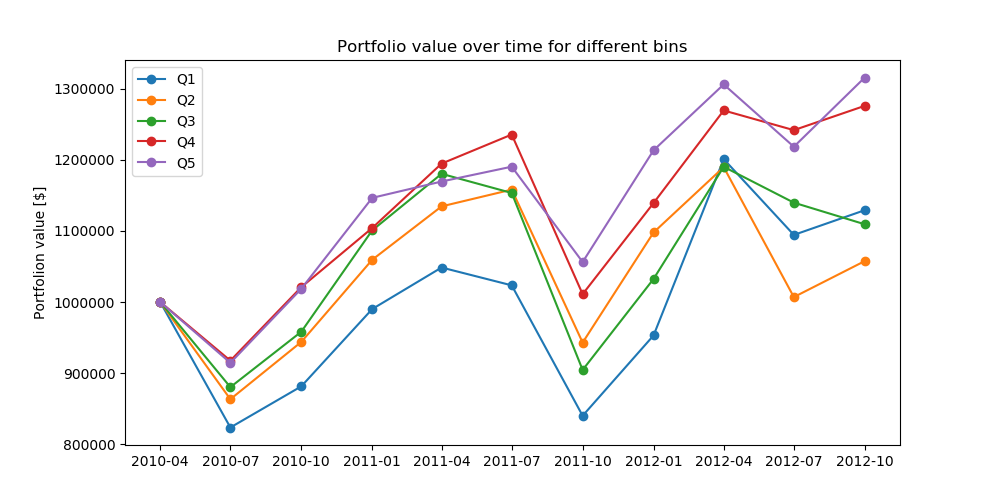

Text(0, 0.5, 'Portfolion value [$]')

In [57]:
plt.figure(figsize=(10, 5))
for l in s['bin_labels']:
    x = []
    y = []
    for qtr in s['list_qtr'][1:]:
        start = "{}{}{}".format(str(qtr[0]), str(((qtr[1])-1)*3+1).zfill(2), '01')
        x.append(datetime.strptime(start, '%Y%m%d').date())
        y.append(pf_values['diff_cosine_tf'][l][qtr][0])
    plt.plot_date(x, y, label=l, linestyle='-')
plt.legend()
plt.title('Portfolio value over time for different bins')
plt.ylabel('Portfolion value [$]')

<IPython.core.display.Javascript object>


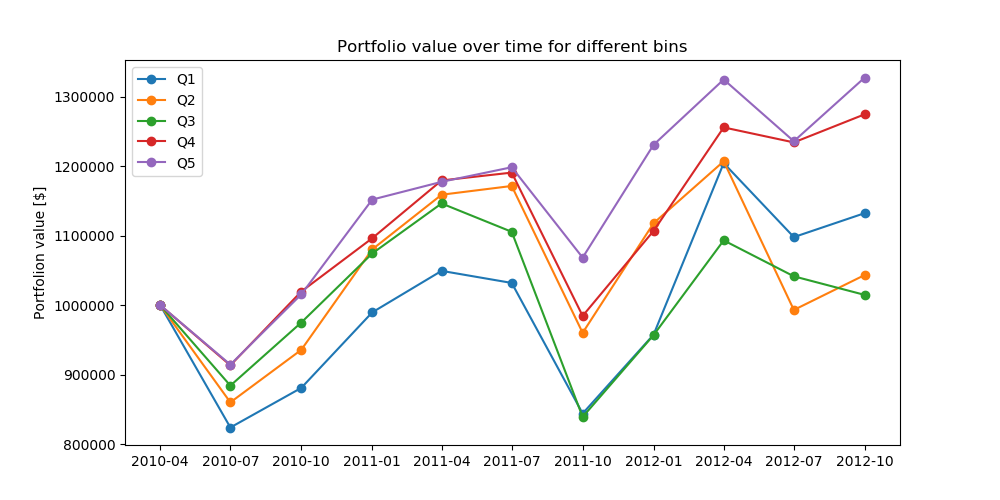

Text(0, 0.5, 'Portfolion value [$]')

In [58]:
plt.figure(figsize=(10, 5))
for l in s['bin_labels']:
    x = []
    y = []
    for qtr in s['list_qtr'][1:]:
        start = "{}{}{}".format(str(qtr[0]), str(((qtr[1])-1)*3+1).zfill(2), '01')
        x.append(datetime.strptime(start, '%Y%m%d').date())
        y.append(pf_values['diff_cosine_tf_idf'][l][qtr][0])
    plt.plot_date(x, y, label=l, linestyle='-')
plt.legend()
plt.title('Portfolio value over time for different bins')
plt.ylabel('Portfolion value [$]')

In [ ]:
for qtr in s['list_qtr'][1:]:
    print(qtr, pf_values['diff_jaccard']['Q5'][qtr][0])

In [ ]:
test_qtr_data = master_dict['diff_jaccard'][(2010, 2)]

In [ ]:
# [DEBUG] Show the Apple data for that time period
extracted_cik_scores = cik_scores[data_to_process[0][0]]
extracted_cik_scores

In [ ]:
#ticker = lookup[320193]
ticker = lookup[data_to_process[0][0]]
start = "{}{}{}".format(str(s['time_range'][0][0]), str(((s['time_range'][0][1])-1)*3+1).zfill(2), '01')
stop = "{}{}{}".format(str(s['time_range'][1][0]), str(((s['time_range'][1][1]))*3).zfill(2), '31')
start_date = datetime.strptime(start, '%Y%m%d').date()
stop_date = datetime.strptime(stop, '%Y%m%d').date()
#print(s['time_range'], start_date)
#print(s['time_range'], stop_date)
extracted_stock_data = {k: v for k, v in stock_data[ticker].items() if start_date <= k <= stop_date}
#print(extracted_data)


# Display the data

In [ ]:
stock_data[ticker]

## For a given ticker

### Metrics vs stock price

In [ ]:
display.diff_vs_stock(extracted_cik_scores, extracted_stock_data, ticker, s, method='diff')

### Sentiment vs stock price

In [ ]:
display.diff_vs_stock(extracted_cik_scores, extracted_stock_data, s, method='sentiment')

## For a given qtr